# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
MyDrive


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH #'/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
#os.chdir('/content')
os.chdir(DATA_PATH)

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()

    #-----------KMARATHE test code----------
    print("......Data before preprocessing.......")
    print(data[0:1000])

    print("\n\n")
    print(".......Data after preprocessing......")
    data = " ".join(data.split())
    print(data[0:1000])
    #----------- KMARATHE test code ------------
    
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    i=0
    for char in data:
        #pass # TODO Fill this in
        # ********VTHOMA******
        if not char in voc2ind:
            voc2ind[char]=i
            i+=1
        # ********VTHOMA******


    print("\n")
    print("voc2ind=", voc2ind)
    ind2voc = {val: key for key, val in voc2ind.items()}
    print("ind2voc=", ind2voc)

    # KMARATHE Added this --------------
    print("len(data)=", len(data))
    num_chars = len(data)
    training_num_chars = int(num_chars * 0.8)
    print("training_num_chars=", training_num_chars)
    testing_num_chars = num_chars  - training_num_chars
    print("testing_num_chars=", testing_num_chars)

    train_text = data[0:training_num_chars ]
    print("last part of train:", train_text[training_num_chars-10:training_num_chars])
    test_text = data[training_num_chars:num_chars ]
    print("starting of test:", test_text[0:10])
    # KMARATHE Added this --------------


    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
    # ---- ADDED BY VTHOMA FOR TESTING PURPOSE ------
    pickle.dump({'tokens': test_text[0:23], 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'vthoma_test.pkl', 'wb'))

prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        # kmarathe debug
        #print("array  in array to words-----", arr)
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        # kmarathe debug 
        #print("words in words to array----" words)
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

print("\nDetails of v_train....")
v_train = Vocabulary(DATA_PATH + 'harry_potter_chars_train.pkl')
print("ind2voc=", v_train.ind2voc)
print("ind2voc=",v_train.voc2ind)
print("v_train.array_to_words([1, 2, 3, 4, 5])=",v_train.array_to_words([1, 2, 3, 4, 5] ))
print("v_train.words_to_array(['H', 'a', 'r', 'r', 'y'] )=", v_train.words_to_array(['H', 'a', 'r', 'r', 'y'] ))
print("v_train.__len__()=",v_train.__len__())

print("\nDetails of v_test.....")
v_test = Vocabulary(DATA_PATH + 'harry_potter_chars_test.pkl')
print("ind2voc=",v_test.ind2voc)
print("ind2voc=",v_test.voc2ind)
print("v_train.array_to_words([1, 2, 3, 4, 5])=", v_test.array_to_words([1, 2, 3, 4, 5]))
print("v_train.words_to_array(['H', 'a', 'r', 'r', 'y'] )=", v_test.words_to_array(['H', 'a', 'r', 'r', 'y'] ))
print("v_train.__len__()=",v_test.__len__())



......Data before preprocessing.......
Harry Potter and the Sorcerer's Stone 

CHAPTER ONE 

THE BOY WHO LIVED 

Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. 

Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere. 

The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn't think they could bear i

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [ ]:
import math

class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)


        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

            # KMARATHE Test are we supposed to truncate the data in case length is not a multiple of batch size?? 
            #print(type(dataset))
        #print("Original dataset=", dataset['tokens'])
        #print("token rep")

      
        # TODO: Any preprocessing on the data to get it to the right shape.
        # ----- ADDED BY VTHOMA -------
        # kMARATHE Modified ==== dataset['token']  contains the actual data not dataset....
        len_dataset = (int(len(dataset['tokens'])/batch_size))*batch_size
        dataset = dataset['tokens'][0:len_dataset]
        self.len_dataset = len_dataset

        self.len_chunk = self.len_dataset/self.batch_size

        # ----- ADDED BY VTHOMA -------

        # KMARATHE ADDING TEST CODE--------
        #print("after preprocessing the dataset -----------")
        #print("len_dataset = ",self.len_dataset)
        #print("preprocessed dataset=",dataset)
        self.dataset = dataset
        # KMARATHE ADDING TEST CODE--------

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        # raise NotImplementedError 
        
        # ---- ADDED BY VTHOMA ------
        # Not sure what is meant by 'number of unique sequences'. Assuming that 
        # for the example given, this value is 6.
        #print("in __len__")
        #len_chunk = self.len_dataset/self.batch_size
        num_seq_per_chunk = math.ceil((self.len_chunk-1)/self.sequence_length)

        
        # KMARATHE adding test code -----
        #print("len_chunk=", len_chunk)
        #self.len_chunk = len_chunk
        #print("num_seq_per_chunk=", num_seq_per_chunk)
        #print("num_seq_per_chunk*batch_size=", num_seq_per_chunk*self.batch_size)
        # KMARATHE adding test code -----

        return num_seq_per_chunk*self.batch_size
        # ----- ADDED BY VTHOMA -----
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO

        # --------------------KMARATHE ADDED THIS-----------
        #print("dataset=",self.dataset)
        batch_number = idx//self.batch_size
        #print("batch number=", batch_number)
        col_num = idx % self.batch_size
        #print("col number =", col_num)
        #print("start data=", self.len_chunk * col_num + (batch_number) * self.sequence_length )
        start = int(self.len_chunk * col_num + (batch_number) * self.sequence_length )
        
        max_num_allowed = self.len_chunk * (col_num +1 )-2
        end = int(min(self.len_chunk * col_num + (batch_number) * self.sequence_length +self.sequence_length-1, max_num_allowed))
        #print("end(inclusive) data=", end)
        #print(self.dataset)
        #print(self.dataset[start: end+1])
        data = self.vocab.words_to_array(self.dataset[start: end+1])
        labels = self.vocab.words_to_array(self.dataset[start+1: end+2])

        #print("data", data)
        #print("labels", labels)
        return data, labels

         # --------------------KMARATHE ADDED THIS---------

        #data = None
        #return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)


# ----- ADDED BY VTHOMA ------
print("\n Testing HarryPotterDataset class.......")
TEST_SEQUENCE_LENGTH = 3
TEST_BATCH_SIZE = 2
data_file = DATA_PATH + 'vthoma_test.pkl'
with open(data_file, 'rb') as data_pkl:
    dataset = pickle.load(data_pkl)
print("Dataset=", dataset['tokens'])

data_vthoma_test = HarryPotterDataset(DATA_PATH + 'vthoma_test.pkl', 3, 2)
print("Dataset as tokens=", data_vthoma_test.vocab.words_to_array(dataset['tokens']))
print("Test batch size=", TEST_BATCH_SIZE)
print("Test sequence length=", TEST_SEQUENCE_LENGTH)
print("Number of unique sequences=", data_vthoma_test.__len__() )
print("Data and label for idx=3 is", data_vthoma_test.__getitem__(3))

# ----- ADDED BY VTHOMA ------



 Testing HarryPotterDataset class.......
Dataset= a great sigh and leaned
Dataset as tokens= tensor([ 1,  4, 44,  2,  8,  1,  7,  4, 15, 38, 44, 11,  4,  1,  9, 10,  4, 33,
         8,  1,  9,  8, 10])
Test batch size= 2
Test sequence length= 3
Number of unique sequences= 8
Data and label for idx=3 is (tensor([ 9, 10,  4]), tensor([10,  4, 33]))


# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        # KMARATHE TESTING EMBEDDING ----------
        print(self.vocab_size)
        print(self.feature_size)
        print(self.encoder)
        # KMARATHE TESTING EMBEDDING ----------
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        print(self.gru)

        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        

        print(self.decoder)
        # This shares the encoder and decoder weights as described in lecture.
        # KMARATHE WHY???
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # raise NotImplementedError 
        # ----- ADDED BY VTHOMA -----
        encoded = self.encoder(x)
        output,hidden_state = self.gru(encoded, hidden_state)
        #output, hidden_state = self.gru(encoded.view(batch_size, sequence_length, -1),hidden_state)
        decoded = self.decoder(output)
        x = decoded
        # ----- ADDED BY VTHOMA -----

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [ ]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
      
    outputs = []
    for ii in range(sequence_length):
        # TODO

        # ---- ADDED BY VTHOMA ----
        #max_prob_index = np.argmax(output.numpy())
        val, argmax = output.max(-1)
        max_prob_index = argmax.item()
     
        #max_prob_char = vocab.ind2voc[max_prob_index]
        max_prob_char = vocab.array_to_words([max_prob_index])
        max_prob_char_array = vocab.words_to_array(max_prob_char)
        outputs.append(max_prob_index)

        max_prob_char_array = max_prob_char_array.to(device)
        output, hidden = model.inference(max_prob_char_array, hidden, temperature=TEMPERATURE)

        # ---- ADDED BY VTHOMA ----

    print("out of for loop")
    print(outputs)
    return outputs


def sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []
    for ii in range(sequence_length):
        # TODO

        p = output.to(device).cpu().numpy().flatten()
        chosen_prob_index = np.random.choice(vocab.__len__(), size=None, p=p)
        chosen_prob_char = vocab.array_to_words([chosen_prob_index])
        chosen_prob_char_array = vocab.words_to_array(chosen_prob_char)

        outputs.append(chosen_prob_index)
        chosen_prob_char_array = chosen_prob_char_array.to(device)
        output, hidden = model.inference(chosen_prob_char_array, hidden, temperature=TEMPERATURE)

    return outputs


def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device):
    outputs = []
    #beams = [([], output, hidden, 0)]
    beams = []
    # TODO
    #raise NotImplementedError

    # ---- ADDED BY VTHOMA ----
    """
    1. Initialize the beam list with the single existing empty beam
    2. Repeat for the sequence length:
      1. For each beam in the beam list:
          1. Compute the next distribution over the output space for that state
          2. Sample from the distribution with replacement
          3. For each sample:
              1. Compute its score
              2. Record its hidden state and chosen value
          4. Add all the samples to the new beam list      
      2. Rank the new beam list
      3. Throw out all but the top N beams
    3. Return the top beam's chosen values.
    """
    #print("Inside beam sampling. output=", output)
    output = output.to(device)
    scores = torch.log(output[0])
    #print("scores=", scores)
    scores_index_sorted = torch.argsort(scores)[-beam_width:]
    #print("scores_index_sorted=", scores_index_sorted)
    
    for i in scores_index_sorted:
      score = torch.log(scores[i])
      beams.append(([i],hidden, output,score))   
    
    for li in range(sequence_length):
      #print("li=", li)
      new_beams = []
      for beam in beams:
        #print("beam=", beam)
        #print("beam[0]=", beam[0])
        #ind = torch.LongTensor(beam[0])
        if len(beam[0])>1:
          ind = torch.LongTensor([beam[0][-1]])
        else:
          ind = torch.LongTensor(beam[0])
        #print("ind=", ind)
        output, hidden = model.inference(ind.to(device), beam[1], temperature=TEMPERATURE)
        samples = torch.multinomial(output, beam_width)
        #print("samples=", samples)
        for sample in samples[0]:
          new_beam_seq = beam[0].copy()
          new_beam_seq.append(sample)
          score = beam[3] + torch.log(output[0][sample])
          new_beam = (new_beam_seq, hidden, output, score)
          new_beams.append(new_beam)

      #Sort new_beams
      #print("Sorting new_beams.....")
      #print("new_beams=", new_beams)
      new_beams = sorted(new_beams, key=lambda x: x[3], reverse=True)
      #print("len_new_beams=", len(new_beams))

      #Keep only BEAM WIDTH top beams
      beams = new_beams[0:BEAM_WIDTH]
      
    #Return top beams chosen values
    outputs = beams[0][0]

    # ---- ADDED BY VTHOMA ----
    return outputs


"""
def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    
    # KMARATHE
    #print("output", output)
    #print("hidden", hidden)
    
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # raise NotImplementedError

        # ---- ADDED BY VTHOMA ----
        #max_prob_index = np.argmax(output.numpy())
        val, argmax = output.max(-1)
        max_prob_index = argmax.item()
     
        #max_prob_char = vocab.ind2voc[max_prob_index]
        max_prob_char = vocab.array_to_words([max_prob_index])
        max_prob_char_array = vocab.words_to_array(max_prob_char)
        #outputs.append(max_prob_char)
        outputs.append(max_prob_index)

        if(torch.cuda.is_available()):

          model.cuda()# rnn is your model 
          max_prob_char_array = max_prob_char_array.cuda() 
          hidden = hidden.cuda()
          output, hidden = model.inference(max_prob_char_array, hidden)
          # KMARATHE
          #print("output", output)
          #print("hidden", hidden)

        # ---- ADDED BY VTHOMA ----
    print("out of for loop")
    print(outputs)
    return outputs


def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # raise NotImplementedError

        # ---- ADDED BY VTHOMA ----
        # Again, I am not sure why this function takes model and hidden as aprameters
        #print(vocab)
        #print(vocab.__len__())
        #print(output)
        #print(type(output))
        p = output.cpu().numpy().flatten()
        #print("p shape", p.shape)
        chosen_prob_index = np.random.choice(vocab.__len__(), size=None, p=p)
        chosen_prob_char = vocab.array_to_words([chosen_prob_index])
        chosen_prob_char_array = vocab.words_to_array(chosen_prob_char)

        outputs.append(chosen_prob_index)
        if(torch.cuda.is_available()):
          model.cuda()
          chosen_prob_char_array = chosen_prob_char_array.cuda()
          hidden = hidden.cuda()
          output, hidden = model.inference(chosen_prob_char_array, hidden)
        # ---- ADDED BY VTHOMA ----
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device):
    outputs = []
    #beams = [([], output, hidden, 0)]
    beams = []
    # TODO
    #raise NotImplementedError

    # ---- ADDED BY VTHOMA ----
    1. Initialize the beam list with the single existing empty beam
    2. Repeat for the sequence length:
      1. For each beam in the beam list:
          1. Compute the next distribution over the output space for that state
          2. Sample from the distribution with replacement
          3. For each sample:
              1. Compute its score
              2. Record its hidden state and chosen value
          4. Add all the samples to the new beam list      
      2. Rank the new beam list
      3. Throw out all but the top N beams
    3. Return the top beam's chosen values.
    for li in range(sequence_length):
      #print("li=", li)
      new_beams = []
      for beam in beams:
        # Sample BEAM WIDTH items
        #print("beam=", beam)
        for k in range(BEAM_WIDTH):
          #print("k=", k)
          #print("output=", output)
          #print('output.to(device)=',output.to(device))
          p = output.to(device).cpu().numpy().flatten()
          #print("p=",p)
          sample_index = np.random.choice(vocab.__len__(), size=None, p=p)
          #print("sample_index=", sample_index)
          sample_prob = p[sample_index]
          #print("sample_prob=", sample_prob)
          sample_char = vocab.array_to_words([sample_index])
          #print("sample_char=", sample_char)
          sample_char_vector = vocab.words_to_array(sample_char)
          #print("sample_char_vector=", sample_char_vector)
          #new_beam = beam
          #new_beam[0].append(sample_index)
          new_beam_seq = beam[0].copy()
          new_beam_seq.append(sample_index)
          sample_char_vector = sample_char_vector.to(device)
          output, hidden = model.inference(sample_char_vector, hidden)
          score = math.log(sample_prob) + beam[3] #NOT SURE ABOUT THIS
          new_beam = (new_beam_seq, output, hidden, score)
          new_beams.append(new_beam)

      #Sort new_beams
      #print("Sorting new_beams.....")
      new_beams = sorted(new_beams, key=lambda x: x[3], reverse=True)
      #print("len_new_beams=", len(new_beams))

      #Keep only BEAM WIDTH top beams
      beams = new_beams[0:BEAM_WIDTH]
      check_out = beams[0][0]
      
    #Return top beams chosen values
    beams = sorted(beams, key=lambda x: x[3], reverse=True)
    outputs = beams[0][0]

    # ---- ADDED BY VTHOMA ----
    return outputs
"""

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            #kmarathe debugging
            print("in sampling strategy max-----------------------") 
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
89
512
Embedding(89, 512)
GRU(512, 512, batch_first=True)
Linear(in_features=512, out_features=89, bias=True)
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	9mm~$mZw/wVW\m[Uwzim[0Uwmmm*[/UwUUU\i9'i~[\F/FFzp*F\m;\Fimm%%ppp\\\w/*/pp/o![!Uwe!(~~jwww~Tom//*/wwP


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	]\ wh=wUUU\\]]i~\iZ'iDw/[UwwP~~~e\$22L=ww];G:2=!~$\GZv.\*[U!\]UU\wpvwwi/F/UU~\UU9UUU***2=wUUU\i]if*p


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	w^L

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 17.0508, Accuracy: 11535/1254400 (1%)



  2%|▏         | 3/195 [00:00<00:32,  5.84it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 17.068178


  7%|▋         | 13/195 [00:01<00:19,  9.54it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 11.658224


 12%|█▏        | 23/195 [00:02<00:15, 10.76it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 5.814556


 17%|█▋        | 33/195 [00:03<00:14, 10.86it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 3.703465


 22%|██▏       | 43/195 [00:04<00:13, 10.98it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.744738


 27%|██▋       | 53/195 [00:04<00:13, 10.76it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.650831


 32%|███▏      | 63/195 [00:05<00:12, 10.96it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 3.775549


 37%|███▋      | 73/195 [00:06<00:11, 11.00it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 2.752006


 43%|████▎     | 83/195 [00:07<00:10, 11.09it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 2.298775


 48%|████▊     | 93/195 [00:08<00:09, 11.14it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 2.231066


 53%|█████▎    | 103/195 [00:09<00:08, 11.06it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 2.154677


 58%|█████▊    | 113/195 [00:10<00:07, 11.08it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.991447


 63%|██████▎   | 123/195 [00:11<00:06, 10.98it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.914508


 68%|██████▊   | 133/195 [00:12<00:05, 10.87it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.924224


 73%|███████▎  | 143/195 [00:13<00:04, 11.01it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 2.215154


 78%|███████▊  | 153/195 [00:14<00:03, 10.99it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 2.419715


 84%|████████▎ | 163/195 [00:14<00:02, 10.81it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 2.131732


 89%|████████▊ | 173/195 [00:15<00:01, 11.04it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.970583


 94%|█████████▍| 183/195 [00:16<00:01, 11.00it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.843532


 99%|█████████▉| 193/195 [00:17<00:00, 10.94it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.801023


100%|██████████| 195/195 [00:17<00:00, 10.90it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rlriad hudhttnd hiargd anain   the pome   tasl  "Y sn aarre .  "e said  "Yon't yauki  todi  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eus   the sft   oone  tnd Harry sa l d tumbledore aeck an o the cnk sued yed aoet horl   toe mooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd loodpeng tn the paddle of the poro aashttneued in tagw'ead d "or wf  ter iday aorent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Didge comper and not reemed to the cont the Hione and like the back and he been and rolle. "I said Harry suppook his and and look again a looking in her and her was a long the Orumbledor and the books 



  1%|          | 1/195 [00:00<00:36,  5.25it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.766310


  6%|▌         | 12/195 [00:01<00:18,  9.68it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.778210


 11%|█▏        | 22/195 [00:02<00:16, 10.76it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.748293


 16%|█▋        | 32/195 [00:03<00:14, 10.94it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 2.124817


 22%|██▏       | 42/195 [00:03<00:13, 11.01it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 2.319567


 27%|██▋       | 52/195 [00:04<00:13, 10.90it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 2.004130


 32%|███▏      | 62/195 [00:05<00:12, 10.86it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.812496


 37%|███▋      | 72/195 [00:06<00:11, 10.74it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.751559


 42%|████▏     | 82/195 [00:07<00:10, 10.93it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.792315


 47%|████▋     | 92/195 [00:08<00:09, 11.04it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.718756


 52%|█████▏    | 102/195 [00:09<00:08, 10.93it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.692724


 57%|█████▋    | 112/195 [00:10<00:07, 10.86it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.665291


 63%|██████▎   | 122/195 [00:11<00:06, 10.83it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.714641


 68%|██████▊   | 132/195 [00:12<00:05, 10.79it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.724283


 73%|███████▎  | 142/195 [00:13<00:04, 10.91it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.759597


 78%|███████▊  | 152/195 [00:14<00:04, 10.73it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.694523


 83%|████████▎ | 162/195 [00:14<00:03, 10.79it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.708159


 88%|████████▊ | 172/195 [00:15<00:02, 10.76it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.666592


 93%|█████████▎| 182/195 [00:16<00:01, 10.64it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.612502


 98%|█████████▊| 192/195 [00:17<00:00, 10.92it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.601000


100%|██████████| 195/195 [00:18<00:00, 10.80it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreed iodnttnd hiadtd ttain   the some  iaasl  "Y ss aarre .. He said  "Win't wanki  sodt  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ess d the snt r tone  tnd tarry saad d tumbledore weck tn o the fnk soed yed thet torl d toe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd liedpeng tn the sigdee of the sirk aashttnuued in tagw ead d Hor wfe tisridle aerent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. All the littening to pose the of the windows and squees and a lasson was a sunned the was a sound for mession some the silvery did not a little the too be and him and in front partant the mimed to the 



  1%|          | 1/195 [00:00<00:33,  5.86it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.600381


  7%|▋         | 13/195 [00:01<00:18, 10.01it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.611195


 12%|█▏        | 23/195 [00:02<00:15, 10.81it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.654759


 17%|█▋        | 33/195 [00:03<00:14, 10.95it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.660165


 22%|██▏       | 43/195 [00:04<00:14, 10.74it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.614589


 27%|██▋       | 53/195 [00:04<00:13, 10.92it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.583577


 32%|███▏      | 63/195 [00:05<00:12, 10.96it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.566773


 37%|███▋      | 73/195 [00:06<00:11, 10.94it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.565886


 43%|████▎     | 83/195 [00:07<00:10, 10.96it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.551881


 48%|████▊     | 93/195 [00:08<00:09, 10.87it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.598022


 53%|█████▎    | 103/195 [00:09<00:08, 10.95it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.681280


 58%|█████▊    | 113/195 [00:10<00:07, 11.05it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.812910


 63%|██████▎   | 123/195 [00:11<00:06, 10.82it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.749678


 68%|██████▊   | 133/195 [00:12<00:05, 10.70it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.660113


 73%|███████▎  | 143/195 [00:13<00:04, 10.97it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.575320


 78%|███████▊  | 153/195 [00:14<00:03, 10.89it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.548486


 84%|████████▎ | 163/195 [00:14<00:02, 10.84it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.550191


 89%|████████▊ | 173/195 [00:15<00:02, 10.63it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.538256


 94%|█████████▍| 183/195 [00:16<00:01, 10.80it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.511881


 99%|█████████▉| 193/195 [00:17<00:00, 10.75it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.524030


100%|██████████| 195/195 [00:17<00:00, 10.85it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoiet Hodnttnd siaddd ttain,t the sose  eaisl  "Y sm ahrri .  "e said  "Iin't wanky  todt  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ows d the snt   aose  tnd harry sa p d humbledore weck tn o the fnk ooet ye  thet tonl d ooe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd lianpeng tn the sigdle of the foyk aashttnuuet hn tagwmead   Hor wfe wiwrible aerent warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Uncle Vernon going the studentes as going the wing him was so that he was he had been to be able to the time the cloak at the for the night. Harry floor and the table to the time to the worry with usle



  1%|          | 1/195 [00:00<00:34,  5.59it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.534349


  6%|▌         | 12/195 [00:01<00:19,  9.52it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.527592


 12%|█▏        | 23/195 [00:02<00:16, 10.39it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.581095


 17%|█▋        | 33/195 [00:03<00:15, 10.75it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.681796


 22%|██▏       | 43/195 [00:04<00:14, 10.69it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.597404


 27%|██▋       | 53/195 [00:05<00:13, 10.51it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.529956


 32%|███▏      | 63/195 [00:05<00:12, 10.60it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.513276


 37%|███▋      | 73/195 [00:06<00:11, 10.73it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.502763


 43%|████▎     | 83/195 [00:07<00:10, 10.70it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.477401


 48%|████▊     | 93/195 [00:08<00:09, 10.74it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.499506


 53%|█████▎    | 103/195 [00:09<00:08, 10.66it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.494062


 58%|█████▊    | 113/195 [00:10<00:07, 10.67it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.469645


 63%|██████▎   | 123/195 [00:11<00:06, 10.54it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.489963


 68%|██████▊   | 133/195 [00:12<00:05, 10.76it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.510299


 73%|███████▎  | 143/195 [00:13<00:04, 10.71it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.508689


 78%|███████▊  | 153/195 [00:14<00:03, 10.51it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.498901


 84%|████████▎ | 163/195 [00:15<00:02, 10.68it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.490534


 89%|████████▊ | 173/195 [00:16<00:02, 10.50it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.498349


 94%|█████████▍| 183/195 [00:17<00:01, 10.42it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.503492


 99%|█████████▉| 193/195 [00:18<00:00, 10.75it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.525015


100%|██████████| 195/195 [00:18<00:00, 10.60it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tloiat Hodnttnd toaddd ttain,t the tase  oaisl  "I tm tarri".  "e said  "Iin't wanky  tot,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ows d the tnt r aase  tnd tarry aa p d tumbledore wack tnto the tnk ooit ye  that tonl d aha taoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng htd tionping hntthe tagdle of the tirk aaghttnuuethhnttagwmeade  "or wne wowrible tarent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Who was cantally uncornationally want to the teach on the other wall and gave a long to with a strong on the thost of the won's that way to wat it was at the too nomit out of the class that was the was



  1%|          | 1/195 [00:00<00:33,  5.74it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.529203


  7%|▋         | 13/195 [00:01<00:18,  9.65it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.504406


 12%|█▏        | 23/195 [00:02<00:16, 10.56it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.473122


 17%|█▋        | 33/195 [00:03<00:15, 10.79it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.483016


 22%|██▏       | 43/195 [00:04<00:14, 10.59it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.474985


 27%|██▋       | 53/195 [00:05<00:13, 10.39it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.502030


 32%|███▏      | 63/195 [00:06<00:12, 10.61it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.461371


 37%|███▋      | 73/195 [00:06<00:11, 10.47it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.456970


 43%|████▎     | 83/195 [00:07<00:10, 10.49it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.434136


 48%|████▊     | 93/195 [00:08<00:09, 10.55it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.451583


 53%|█████▎    | 103/195 [00:09<00:08, 10.56it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.449859


 58%|█████▊    | 113/195 [00:10<00:07, 10.49it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.432865


 63%|██████▎   | 123/195 [00:11<00:06, 10.51it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.448394


 68%|██████▊   | 133/195 [00:12<00:05, 10.57it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.482367


 73%|███████▎  | 143/195 [00:13<00:04, 10.48it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.484960


 78%|███████▊  | 153/195 [00:14<00:04, 10.48it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.471018


 84%|████████▎ | 163/195 [00:15<00:03, 10.62it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.443021


 89%|████████▊ | 173/195 [00:16<00:02, 10.62it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.433452


 94%|█████████▍| 183/195 [00:17<00:01, 10.41it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.434934


 99%|█████████▉| 193/195 [00:18<00:00, 10.60it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.442134


100%|██████████| 195/195 [00:18<00:00, 10.50it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	ssoeat Hudnttsd soaded ttain,t the sose  aaisl  "I tm thrr ".  He said  "Wun't wauky  iot,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ows d the snt r aose  and harry sa p d humbledore seck an o the snk ooit ye  toet torl d ohe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ni  ng htd hionpeng hn the siddle of the serk aash tnuuethhn tagwmeade  Hor wf  wewrible terent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall still down the sitting the down the stop pointing to the floor on the sides. "What was going to so you." Harry smiled at Harry has been at Harry as though him with the pour playing



  1%|          | 1/195 [00:00<00:37,  5.22it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.447145


  7%|▋         | 13/195 [00:01<00:18,  9.64it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.436948


 12%|█▏        | 23/195 [00:02<00:16, 10.33it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.444920


 17%|█▋        | 33/195 [00:03<00:15, 10.56it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.444985


 22%|██▏       | 43/195 [00:04<00:14, 10.33it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.437651


 27%|██▋       | 53/195 [00:05<00:13, 10.36it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.437883


 32%|███▏      | 63/195 [00:06<00:12, 10.32it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.430586


 37%|███▋      | 73/195 [00:07<00:11, 10.32it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.432912


 43%|████▎     | 83/195 [00:08<00:10, 10.50it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.408489


 48%|████▊     | 93/195 [00:09<00:09, 10.37it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.424313


 53%|█████▎    | 103/195 [00:09<00:08, 10.36it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.432738


 58%|█████▊    | 113/195 [00:10<00:07, 10.28it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.415199


 63%|██████▎   | 123/195 [00:11<00:07, 10.23it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.422662


 68%|██████▊   | 133/195 [00:12<00:05, 10.41it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.488635


 73%|███████▎  | 143/195 [00:13<00:05, 10.22it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.502129


 78%|███████▊  | 153/195 [00:14<00:04, 10.44it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.449592


 84%|████████▎ | 163/195 [00:15<00:03, 10.37it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.415032


 89%|████████▊ | 173/195 [00:16<00:02, 10.39it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.395588


 94%|█████████▍| 183/195 [00:17<00:01, 10.32it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.402625


 99%|█████████▉| 193/195 [00:18<00:00, 10.45it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.416593


100%|██████████| 195/195 [00:18<00:00, 10.33it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat Hhgnttnd hoaned ttain,t the sose  oaasl  "I sm thrr ".  "e said  "Wun't warky, tot,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ows d the snr r aose  and harry sa p d humbledore seck on o the snk otit ye  that horl d ohe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ni  ng hnd hianpeng hn the siddle of the sork aash tnuuethhn tagwmeade  "or af  wewrible torent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall with his wand and he ramp of the stame with the and with his wand was the back of the staff and he had been still that he was sting on the pointed the hour and pulled off the side 



  1%|          | 1/195 [00:00<00:35,  5.47it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.422744


  7%|▋         | 13/195 [00:01<00:18,  9.75it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.420491


 12%|█▏        | 23/195 [00:02<00:16, 10.32it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.411629


 17%|█▋        | 33/195 [00:03<00:15, 10.52it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.419743


 22%|██▏       | 43/195 [00:04<00:14, 10.30it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.412851


 27%|██▋       | 53/195 [00:05<00:13, 10.21it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.409629


 32%|███▏      | 63/195 [00:06<00:12, 10.37it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.403679


 37%|███▋      | 73/195 [00:07<00:11, 10.33it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.416370


 43%|████▎     | 83/195 [00:08<00:10, 10.20it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.417562


 48%|████▊     | 93/195 [00:09<00:09, 10.38it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.409227


 53%|█████▎    | 103/195 [00:10<00:08, 10.30it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.410495


 57%|█████▋    | 111/195 [00:10<00:08, 10.41it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.387783


 63%|██████▎   | 123/195 [00:11<00:06, 10.44it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.403895


 68%|██████▊   | 133/195 [00:12<00:05, 10.38it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.423722


 73%|███████▎  | 143/195 [00:13<00:05, 10.37it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.417737


 78%|███████▊  | 153/195 [00:14<00:03, 10.56it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.415284


 84%|████████▎ | 163/195 [00:15<00:03, 10.36it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.407020


 89%|████████▊ | 173/195 [00:16<00:02, 10.31it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.397969


 94%|█████████▍| 183/195 [00:17<00:01, 10.32it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.384944


 99%|█████████▉| 193/195 [00:18<00:00, 10.47it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.398302


100%|██████████| 195/195 [00:18<00:00, 10.31it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rloeat Hhgnttnd hoaned tnain,t the sase  oaasl  "I dm thrr ".  "e said  "Wun't wanry  ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ows d the snr r aore  and harry saap d humbledore seck onto the snk otit ye  that horl d ohe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nir ng hnd hionpeng hn the saddle of the serk aash tnuoethhn tagwmeade  "or sf  wewrible torent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I those what was a bunch and granced and wat to the sound of who was going to see the one who show he was about the girls of the shough he hundred to the door and he was have to place of the moment whe



  1%|          | 1/195 [00:00<00:35,  5.41it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.405815


  6%|▌         | 12/195 [00:01<00:19,  9.34it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.397325


 12%|█▏        | 23/195 [00:02<00:17, 10.07it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.394886


 16%|█▋        | 32/195 [00:03<00:16, 10.12it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.407681


 22%|██▏       | 42/195 [00:04<00:14, 10.25it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.397848


 27%|██▋       | 52/195 [00:05<00:14, 10.21it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.398233


 32%|███▏      | 62/195 [00:06<00:12, 10.45it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.422266


 37%|███▋      | 72/195 [00:07<00:12, 10.19it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.402845


 42%|████▏     | 82/195 [00:08<00:10, 10.35it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.392360


 47%|████▋     | 92/195 [00:09<00:10, 10.21it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.395338


 52%|█████▏    | 102/195 [00:10<00:09, 10.22it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.401532


 57%|█████▋    | 112/195 [00:11<00:08, 10.18it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.384374


 63%|██████▎   | 122/195 [00:11<00:07, 10.14it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.390418


 68%|██████▊   | 132/195 [00:12<00:06, 10.16it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.423685


 73%|███████▎  | 142/195 [00:13<00:05, 10.27it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.406645


 78%|███████▊  | 152/195 [00:14<00:04, 10.12it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.398484


 83%|████████▎ | 162/195 [00:15<00:03, 10.19it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.374672


 88%|████████▊ | 172/195 [00:16<00:02, 10.16it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.372346


 93%|█████████▎| 182/195 [00:17<00:01,  9.83it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.378446


 99%|█████████▉| 193/195 [00:18<00:00, 10.28it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.400527


100%|██████████| 195/195 [00:19<00:00, 10.16it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat shgntond hoaned ttain,t the saser oaask  "I dm nhrr ".  "e said  "Wun't warky "ihr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ows d the snr r aore  and harry saad d humbledore seck onto the snk ohcr yer ahet hrrl d ohe saoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nir ng and heonpeng hn the saddle of the serk aash anuoethhn tagwmeade  "rr af  wewrible aarent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor Trelawney entrance long a long began to remember and he was sented the door and more not long at his brooms in an impression of the back of the managed to return to his chair what he was a li



  1%|          | 1/195 [00:00<00:34,  5.54it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.411030


  6%|▌         | 12/195 [00:01<00:19,  9.37it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.387161


 11%|█▏        | 22/195 [00:02<00:17, 10.01it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.387492


 16%|█▋        | 32/195 [00:03<00:16, 10.14it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.397061


 22%|██▏       | 42/195 [00:04<00:14, 10.35it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.388551


 27%|██▋       | 52/195 [00:05<00:13, 10.37it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.369434


 32%|███▏      | 62/195 [00:06<00:13,  9.94it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.382893


 37%|███▋      | 72/195 [00:07<00:12, 10.21it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.377534


 42%|████▏     | 82/195 [00:08<00:11, 10.08it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.366560


 47%|████▋     | 92/195 [00:09<00:10, 10.17it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.376888


 52%|█████▏    | 102/195 [00:10<00:09, 10.17it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.385436


 57%|█████▋    | 112/195 [00:11<00:08, 10.23it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.366867


 63%|██████▎   | 122/195 [00:12<00:07, 10.13it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.376244


 68%|██████▊   | 132/195 [00:13<00:06, 10.09it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.413113


 73%|███████▎  | 142/195 [00:14<00:05,  9.90it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.393126


 78%|███████▊  | 152/195 [00:15<00:04,  9.94it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.389478


 83%|████████▎ | 161/195 [00:15<00:03, 10.19it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.371488


 89%|████████▊ | 173/195 [00:17<00:02, 10.28it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.374466


 94%|█████████▍| 183/195 [00:18<00:01, 10.05it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.368437


 99%|█████████▉| 193/195 [00:19<00:00, 10.12it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.393853


100%|██████████| 195/195 [00:19<00:00, 10.10it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat shgntond soanid ttain,t the baser oahsk  "I dm shrri".  "e said  "Wun't wanky "ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	owsed the bnr r aorer and harry saad d humbledore seck onto the cnk oiir yer aoan hrrl d ohe baoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nir ng and seenpeng hn the saddle of the serk aash anuoethhn tagwmeade  "rr an  wewrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. It seemed to see the back of and himself sapparantly. "You have been in anyone who was a bit of burnies, you would be all right to have been such a serce of your ords of Harry's much her eyes and what 



  1%|          | 1/195 [00:00<00:35,  5.39it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.401232


  6%|▌         | 12/195 [00:01<00:19,  9.21it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.380915


 11%|█▏        | 22/195 [00:02<00:17,  9.93it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.377613


 16%|█▋        | 32/195 [00:03<00:15, 10.20it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.386087


 22%|██▏       | 42/195 [00:04<00:15, 10.07it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.381405


 27%|██▋       | 53/195 [00:05<00:14, 10.04it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.366399


 32%|███▏      | 63/195 [00:06<00:12, 10.32it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.377483


 37%|███▋      | 73/195 [00:07<00:11, 10.23it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.370727


 43%|████▎     | 83/195 [00:08<00:10, 10.26it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.364952


 48%|████▊     | 93/195 [00:09<00:10, 10.10it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.373747


 52%|█████▏    | 101/195 [00:10<00:09, 10.16it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.375795


 58%|█████▊    | 113/195 [00:11<00:08, 10.19it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.358478


 63%|██████▎   | 123/195 [00:12<00:07, 10.26it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.366965


 68%|██████▊   | 133/195 [00:13<00:06, 10.19it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.392967


 72%|███████▏  | 141/195 [00:13<00:05, 10.33it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.385024


 78%|███████▊  | 153/195 [00:15<00:04, 10.11it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.382857


 84%|████████▎ | 163/195 [00:16<00:03, 10.09it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.359095


 89%|████████▊ | 173/195 [00:17<00:02, 10.23it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.359673


 94%|█████████▍| 183/195 [00:18<00:01, 10.19it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.352437


 98%|█████████▊| 191/195 [00:18<00:00, 10.18it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.373681


100%|██████████| 195/195 [00:19<00:00, 10.12it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat shgntand soanid ttainst the baser oaasl  "I dm shlri".  "e said  "Wun't wanky "tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the bnt r aoser and terry saad d iumbledore seck anto the cnk otcr yer toan hrrl d ohe baoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seenpeng hn ahe caddle of the cerk aaghtanuaethtn tagwmeade  "rr afe weurible aorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Percy said, "I don't you know what what you are to tell you are you think about the feast and read you will and here, and it making even to much and me at How a cour from nothing and All by the first y



  1%|          | 1/195 [00:00<00:34,  5.65it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.386680


  7%|▋         | 13/195 [00:01<00:19,  9.51it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.375621


 11%|█▏        | 22/195 [00:02<00:17,  9.75it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.371405


 16%|█▋        | 32/195 [00:03<00:16, 10.02it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.379569


 22%|██▏       | 42/195 [00:04<00:15, 10.05it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.377788


 27%|██▋       | 52/195 [00:05<00:14, 10.15it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.381700


 32%|███▏      | 62/195 [00:06<00:13,  9.99it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.385673


 37%|███▋      | 72/195 [00:07<00:12,  9.91it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.377923


 42%|████▏     | 82/195 [00:08<00:11,  9.95it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.357189


 47%|████▋     | 92/195 [00:09<00:10,  9.92it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.361338


 52%|█████▏    | 102/195 [00:10<00:09,  9.97it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.366289


 57%|█████▋    | 112/195 [00:11<00:08, 10.04it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.350187


 63%|██████▎   | 122/195 [00:12<00:07, 10.19it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.359329


 68%|██████▊   | 132/195 [00:13<00:06, 10.08it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.380249


 73%|███████▎  | 142/195 [00:14<00:05, 10.09it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.378244


 78%|███████▊  | 152/195 [00:15<00:04, 10.00it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.375273


 83%|████████▎ | 162/195 [00:16<00:03,  9.98it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.353277


 88%|████████▊ | 172/195 [00:17<00:02, 10.08it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.350024


 93%|█████████▎| 182/195 [00:18<00:01, 10.19it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.347279


 98%|█████████▊| 192/195 [00:19<00:00, 10.12it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.363065


100%|██████████| 195/195 [00:19<00:00, 10.02it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat sugntand soadid ttainst the base  oaasl  "I dm shlri".  "e said, "Wun't wauky,"tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the bnt r aore  and tarry saad d tumbledore teck tnto the cnk otct yer toan hrrl d ohe caoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd sienpeng an ahe caddle of the cork aaghtanuaethtn tagwmeade  "rr afe weurible aorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor Trelawney was a very of the black of the stairs swing. Harry the turned to be been and but she felt so that he couldn't mean that the furney was slitting at him, which was so face that the gl



  1%|          | 1/195 [00:00<00:36,  5.30it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.377159


  6%|▌         | 12/195 [00:01<00:19,  9.25it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.367206


 11%|█▏        | 22/195 [00:02<00:17,  9.82it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.368369


 17%|█▋        | 33/195 [00:03<00:16,  9.98it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.372211


 21%|██        | 41/195 [00:04<00:15, 10.02it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.366915


 27%|██▋       | 52/195 [00:05<00:15,  9.41it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.352189


 32%|███▏      | 63/195 [00:06<00:13,  9.77it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.368861


 36%|███▋      | 71/195 [00:07<00:12,  9.99it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.362285


 42%|████▏     | 82/195 [00:08<00:11,  9.87it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.351676


 47%|████▋     | 91/195 [00:09<00:10, 10.07it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.358652


 52%|█████▏    | 102/195 [00:10<00:09,  9.68it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.372475


 58%|█████▊    | 113/195 [00:11<00:08,  9.97it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.351521


 63%|██████▎   | 123/195 [00:12<00:07,  9.92it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.355981


 68%|██████▊   | 132/195 [00:13<00:06,  9.75it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.375411


 73%|███████▎  | 142/195 [00:14<00:05,  9.91it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.373464


 78%|███████▊  | 153/195 [00:15<00:04,  9.92it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.372500


 83%|████████▎ | 162/195 [00:16<00:03,  9.98it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.350067


 88%|████████▊ | 172/195 [00:17<00:02,  9.77it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.337348


 93%|█████████▎| 182/195 [00:18<00:01,  9.83it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.341057


 99%|█████████▉| 193/195 [00:19<00:00,  9.95it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.358835


100%|██████████| 195/195 [00:19<00:00,  9.88it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet sulntand soadid ttainst the case  oaasl  "I dm shlri".  "e said  "Wun't wauky,"tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the cnt r aore  and tarry saad d aumbledore seck tn o the cnk otct yer toan hrrl d ohe caoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd soenpeng an ahe caddle of the cork aaghtanuaethtn tagwmeade  "rr afe weurible aorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. in strong strong the cast and behind him and straightening about the morning around the class and disappearing rather than a perfect of his back of his back of the grum what he had flained to his face 



  1%|          | 1/195 [00:00<00:33,  5.81it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.373392


  6%|▌         | 12/195 [00:01<00:19,  9.36it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.361367


 11%|█▏        | 22/195 [00:02<00:18,  9.60it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.363986


 16%|█▋        | 32/195 [00:03<00:16,  9.70it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.367715


 22%|██▏       | 42/195 [00:04<00:15,  9.91it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.361183


 27%|██▋       | 52/195 [00:05<00:14,  9.67it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.344557


 32%|███▏      | 62/195 [00:06<00:13,  9.79it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.371219


 37%|███▋      | 73/195 [00:07<00:12,  9.97it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.370745


 43%|████▎     | 83/195 [00:08<00:11,  9.82it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.350516


 47%|████▋     | 92/195 [00:09<00:10,  9.83it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.356833


 53%|█████▎    | 103/195 [00:10<00:09,  9.88it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.355170


 57%|█████▋    | 112/195 [00:11<00:08,  9.91it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.335809


 63%|██████▎   | 123/195 [00:12<00:07,  9.84it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.345940


 68%|██████▊   | 132/195 [00:13<00:06,  9.77it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.368323


 73%|███████▎  | 143/195 [00:14<00:05,  9.79it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.370129


 78%|███████▊  | 152/195 [00:15<00:04,  9.85it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.368421


 84%|████████▎ | 163/195 [00:16<00:03, 10.03it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.342541


 88%|████████▊ | 172/195 [00:17<00:02,  9.63it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.331422


 93%|█████████▎| 182/195 [00:18<00:01,  9.80it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.334685


 98%|█████████▊| 192/195 [00:19<00:00,  9.86it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.354136


100%|██████████| 195/195 [00:19<00:00,  9.83it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet sulntand soavid atainst the case  oaasl  "I dm shlri".  "e said  "Wun't wauky,"Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed toe cnt r aore  and harry saaded aumbledore seck an o the cnk otat yer toat hrrled ohe caoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd soanpeng an ahe caddle of the cork aaghtanuaet tn tagwmeade  "rr afe waurible aorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. So the chair of the floor of the chair of armack. "Hermione didn't see what the Dobby like and say, I said it was a few off with a chair of a large and made and which Harry got to the corner to him and



  1%|          | 1/195 [00:00<00:37,  5.21it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.367915


  7%|▋         | 13/195 [00:01<00:19,  9.50it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.357245


 11%|█▏        | 22/195 [00:02<00:17, 10.01it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.360676


 16%|█▌        | 31/195 [00:03<00:17,  9.56it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.364179


 22%|██▏       | 43/195 [00:04<00:15,  9.86it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.354353


 26%|██▌       | 51/195 [00:05<00:14,  9.81it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.337968


 32%|███▏      | 62/195 [00:06<00:13, 10.17it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.362406


 37%|███▋      | 72/195 [00:07<00:12,  9.73it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.363094


 42%|████▏     | 82/195 [00:08<00:11,  9.77it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.345020


 48%|████▊     | 93/195 [00:09<00:10,  9.72it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.353129


 52%|█████▏    | 102/195 [00:10<00:09,  9.97it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.352077


 57%|█████▋    | 112/195 [00:11<00:08, 10.03it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.332571


 63%|██████▎   | 123/195 [00:12<00:07, 10.01it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.342279


 68%|██████▊   | 133/195 [00:13<00:06, 10.10it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.363173


 73%|███████▎  | 143/195 [00:14<00:05, 10.00it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.365743


 78%|███████▊  | 153/195 [00:15<00:04, 10.03it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.362171


 83%|████████▎ | 162/195 [00:16<00:03,  9.94it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.335825


 88%|████████▊ | 172/195 [00:17<00:02,  9.35it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.328285


 94%|█████████▍| 183/195 [00:18<00:01,  9.87it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.330012


 98%|█████████▊| 192/195 [00:19<00:00,  9.87it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.348738


100%|██████████| 195/195 [00:19<00:00,  9.91it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat sulntand soavid atainst the case  ooasl  "I wm selri".  "e said  "Iun't wauky, Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed toe ctt r aore  and harry saaded aumbledore aeck anto the cnk otat yer toat hrrled ahe caoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd soanpeng an ahe caddle of the cork aaghtanuaethtn tagwmeade  "rr afe waurible aorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mr. Weasley said Harry and the castle and slid on her to the door. "Yeah, Malfoy, What someone was all out of the point, to so up the jape for the first for me, but there was a good for an your for a f



  1%|          | 1/195 [00:00<00:34,  5.61it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.363202


  6%|▌         | 12/195 [00:01<00:19,  9.42it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.352816


 11%|█▏        | 22/195 [00:02<00:18,  9.46it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.354573


 16%|█▋        | 32/195 [00:03<00:16, 10.01it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.360779


 22%|██▏       | 42/195 [00:04<00:15, 10.12it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.349124


 27%|██▋       | 52/195 [00:05<00:14, 10.12it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.333362


 32%|███▏      | 62/195 [00:06<00:13,  9.79it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.355716


 37%|███▋      | 73/195 [00:07<00:12,  9.96it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.353650


 42%|████▏     | 81/195 [00:08<00:11, 10.07it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.339201


 47%|████▋     | 91/195 [00:09<00:10, 10.14it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.346626


 52%|█████▏    | 102/195 [00:10<00:09, 10.06it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.348019


 57%|█████▋    | 112/195 [00:11<00:08, 10.04it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.329693


 63%|██████▎   | 122/195 [00:12<00:07, 10.07it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.340004


 68%|██████▊   | 132/195 [00:13<00:06, 10.08it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.358519


 73%|███████▎  | 143/195 [00:14<00:05,  9.95it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.362543


 78%|███████▊  | 152/195 [00:15<00:04,  9.64it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.358039


 84%|████████▎ | 163/195 [00:16<00:03, 10.01it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.333261


 89%|████████▊ | 173/195 [00:17<00:02, 10.02it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.326217


 94%|█████████▍| 183/195 [00:18<00:01,  9.89it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.326763


 99%|█████████▉| 193/195 [00:19<00:00,  9.94it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.345067


100%|██████████| 195/195 [00:19<00:00,  9.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat sulntand soavid ttainst the case  ooasl  "I wm selri".  "e said, "Iun't wauky, Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the ctt r aore  and harry saaded aumbledore aeck tnto the cnk otat,yer toat horled ahe caoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd soanpeng hn ahe caddle of the cark aaghtanaaethtn tagwmeade  "or afe waurible worent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mallowed at the fire of the castle. "No you want to get and some in the castle we called my linger to will of the other was a table of the only when said Harry was so for some so parents and the one of



  1%|          | 1/195 [00:00<00:36,  5.26it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.358958


  7%|▋         | 13/195 [00:01<00:18,  9.61it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.350783


 11%|█▏        | 22/195 [00:02<00:17,  9.63it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.352951


 16%|█▋        | 32/195 [00:03<00:16,  9.69it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.357604


 22%|██▏       | 42/195 [00:04<00:15,  9.77it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.344323


 27%|██▋       | 52/195 [00:05<00:14,  9.58it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.327839


 32%|███▏      | 63/195 [00:06<00:13,  9.94it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.348258


 37%|███▋      | 73/195 [00:07<00:12, 10.08it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.344689


 42%|████▏     | 82/195 [00:08<00:11,  9.99it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.334604


 48%|████▊     | 93/195 [00:09<00:10,  9.87it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.341533


 53%|█████▎    | 103/195 [00:10<00:09,  9.88it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.346243


 57%|█████▋    | 112/195 [00:11<00:08,  9.88it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.328808


 63%|██████▎   | 122/195 [00:12<00:07,  9.90it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.339666


 68%|██████▊   | 133/195 [00:13<00:06,  9.84it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.355496


 73%|███████▎  | 143/195 [00:14<00:05,  9.94it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.357795


 78%|███████▊  | 153/195 [00:15<00:04,  9.96it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.354796


 83%|████████▎ | 162/195 [00:16<00:03,  9.66it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.329137


 88%|████████▊ | 171/195 [00:17<00:02,  9.67it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.323121


 94%|█████████▍| 183/195 [00:18<00:01,  9.89it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.323468


 98%|█████████▊| 192/195 [00:19<00:00,  9.79it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.342346


100%|██████████| 195/195 [00:19<00:00,  9.87it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat sulntand soavid ttainst the case  ooasl  "I wm selri".  "e said, "Iun't wauky, Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the ctt r aore  and harry saaded humbledore aeck tnto the cnk otat,yer toat horled ahe caoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd soanpeng hn ahe caddle of the cark eaghtanaaethtn tagwmeade  "or af  waurible warent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. when the other dementors were started at all the top of the castle. "What's the moment, the first years of got to be so that more that not allow to get in the way of the chamber of the back. "There you



  1%|          | 1/195 [00:00<00:37,  5.16it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.355251


  7%|▋         | 13/195 [00:01<00:18,  9.61it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.348941


 11%|█▏        | 22/195 [00:02<00:17,  9.93it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.351774


 16%|█▋        | 32/195 [00:03<00:16, 10.02it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.354761


 22%|██▏       | 42/195 [00:04<00:15,  9.78it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.341116


 27%|██▋       | 52/195 [00:05<00:14,  9.67it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.323979


 32%|███▏      | 63/195 [00:06<00:13, 10.04it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.342362


 37%|███▋      | 72/195 [00:07<00:12,  9.77it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.339176


 42%|████▏     | 81/195 [00:08<00:11, 10.01it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.330357


 48%|████▊     | 93/195 [00:09<00:10, 10.10it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.338054


 53%|█████▎    | 103/195 [00:10<00:08, 10.23it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.342928


 58%|█████▊    | 113/195 [00:11<00:08, 10.17it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.325810


 63%|██████▎   | 123/195 [00:12<00:07, 10.21it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.339665


 67%|██████▋   | 131/195 [00:13<00:06, 10.00it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.353228


 73%|███████▎  | 142/195 [00:14<00:05, 10.09it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.354084


 78%|███████▊  | 152/195 [00:15<00:04, 10.16it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.353313


 83%|████████▎ | 162/195 [00:16<00:03, 10.01it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.325470


 88%|████████▊ | 172/195 [00:17<00:02, 10.04it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.321279


 93%|█████████▎| 182/195 [00:18<00:01,  9.94it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.320570


 99%|█████████▉| 193/195 [00:19<00:00,  9.98it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.339878


100%|██████████| 195/195 [00:19<00:00,  9.99it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat sulntond soavid ttainst the case  oohsl  "I wm selri".  "e said, "Iun't warky, Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the ctt r aore  and harry saaded humbledore seck tnto the cnk otat,yer toat horled ahe caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd soanpeng hn ahe caddle of the cark eaghtanaaethtn tagwmeade  "or af  waurible warent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. when he had been cared at her five of the parental and started on the cartain room to his bother to her back in a loud light a shaking back of the good of the back of the staff room the shall of his vi



  1%|          | 1/195 [00:00<00:37,  5.15it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.352329


  7%|▋         | 13/195 [00:01<00:19,  9.26it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.346698


 11%|█▏        | 22/195 [00:02<00:17,  9.87it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.349123


 17%|█▋        | 33/195 [00:03<00:16, 10.09it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.351952


 22%|██▏       | 43/195 [00:04<00:15, 10.08it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.338748


 27%|██▋       | 52/195 [00:05<00:14,  9.90it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.321010


 32%|███▏      | 62/195 [00:06<00:13, 10.01it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.337736


 37%|███▋      | 72/195 [00:07<00:12,  9.99it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.335348


 43%|████▎     | 83/195 [00:08<00:11, 10.12it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.325775


 48%|████▊     | 93/195 [00:09<00:10, 10.06it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.334209


 53%|█████▎    | 103/195 [00:10<00:09,  9.96it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.339623


 57%|█████▋    | 112/195 [00:11<00:08,  9.98it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.323293


 63%|██████▎   | 122/195 [00:12<00:07,  9.68it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.339010


 68%|██████▊   | 133/195 [00:13<00:06,  9.99it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.351573


 73%|███████▎  | 143/195 [00:14<00:05, 10.02it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.351832


 78%|███████▊  | 153/195 [00:15<00:04,  9.99it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.350121


 84%|████████▎ | 163/195 [00:16<00:03,  9.97it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.322666


 88%|████████▊ | 172/195 [00:17<00:02,  9.92it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.318936


 93%|█████████▎| 182/195 [00:18<00:01,  9.96it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.317735


 99%|█████████▉| 193/195 [00:19<00:00,  9.83it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.336531


100%|██████████| 195/195 [00:19<00:00,  9.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlntond soavid ttain t the case  oohll  "I wm selri".  "e said, "Iun't warky, Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the ctr r aore  and harry saaded humbledore seck tnto the cnk otat,yer toat horled the caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd soanpeng hn ahe caddle of the cark eaghtanaaet tn tagwmeade  "or af  waurible warent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. which because he was still standing down the front of the face behind him and a feet back to the edge and the owl of the castle at Harry that he had been happening at her wand and scared of the early s



  1%|          | 1/195 [00:00<00:34,  5.69it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.350091


  7%|▋         | 13/195 [00:01<00:18,  9.73it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.344088


 12%|█▏        | 23/195 [00:02<00:17,  9.90it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.344772


 17%|█▋        | 33/195 [00:03<00:16,  9.96it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.348898


 22%|██▏       | 42/195 [00:04<00:15, 10.04it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.337146


 27%|██▋       | 52/195 [00:05<00:14,  9.97it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.319243


 31%|███▏      | 61/195 [00:06<00:13, 10.16it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.334490


 37%|███▋      | 72/195 [00:07<00:12,  9.79it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.332286


 42%|████▏     | 82/195 [00:08<00:11,  9.92it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.321692


 47%|████▋     | 92/195 [00:09<00:10,  9.98it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.330915


 52%|█████▏    | 102/195 [00:10<00:09, 10.11it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.337695


 57%|█████▋    | 112/195 [00:11<00:08, 10.07it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.320772


 63%|██████▎   | 122/195 [00:12<00:07,  9.56it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.337561


 68%|██████▊   | 132/195 [00:13<00:06,  9.82it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.349564


 73%|███████▎  | 142/195 [00:14<00:05,  9.76it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.349824


 78%|███████▊  | 152/195 [00:15<00:04,  9.82it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.348380


 83%|████████▎ | 162/195 [00:16<00:03, 10.00it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.321667


 88%|████████▊ | 172/195 [00:17<00:02,  9.85it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.316219


 93%|█████████▎| 182/195 [00:18<00:01,  9.74it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.314957


 98%|█████████▊| 192/195 [00:19<00:00,  9.77it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.333851


100%|██████████| 195/195 [00:19<00:00,  9.93it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlntond soavid ttain t the case  ooall  "I wm selr, .  "e said, "Iun't warky, Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the ctr r aore  and sarry saaded humbledore seck tnto the cnk otat,yer toat horled the caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd soanpeng hn ahe caddle of the cark eaghtanaaet an tagwmeade  "or af  waurible warent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. ... and he seemed to see the Slytherin was momenting at the Death and heady as the marker of her wand when he was straightened in her through the forest, he was so so that he was still spared of the sh



  1%|          | 1/195 [00:00<00:36,  5.32it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.347226


  6%|▌         | 12/195 [00:01<00:19,  9.27it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.341783


 11%|█▏        | 22/195 [00:02<00:17,  9.80it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.340897


 16%|█▌        | 31/195 [00:03<00:16, 10.01it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.346518


 21%|██        | 41/195 [00:04<00:15, 10.12it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.335287


 27%|██▋       | 52/195 [00:05<00:14,  9.81it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.317629


 31%|███▏      | 61/195 [00:06<00:13,  9.86it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.331779


 37%|███▋      | 72/195 [00:07<00:12,  9.69it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.329347


 42%|████▏     | 82/195 [00:08<00:11,  9.93it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.318835


 47%|████▋     | 92/195 [00:09<00:10, 10.00it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.328338


 52%|█████▏    | 102/195 [00:10<00:09,  9.86it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.334788


 57%|█████▋    | 112/195 [00:11<00:08,  9.90it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.317995


 63%|██████▎   | 123/195 [00:12<00:07,  9.92it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.335898


 68%|██████▊   | 132/195 [00:13<00:06,  9.77it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.347669


 73%|███████▎  | 143/195 [00:14<00:05, 10.07it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.347363


 78%|███████▊  | 152/195 [00:15<00:04,  9.96it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.344590


 83%|████████▎ | 162/195 [00:16<00:03,  9.99it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.319270


 88%|████████▊ | 172/195 [00:17<00:02,  9.86it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.313654


 93%|█████████▎| 182/195 [00:18<00:01, 10.12it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.312629


 98%|█████████▊| 192/195 [00:19<00:00, 10.08it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.331879


100%|██████████| 195/195 [00:19<00:00,  9.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlntond soavid ttain t the care  ooall  "I wm selr, .  "e said, "Iun't warky, Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the str r aore  and sarry saaded humbledore seck tnto the cnk otat,yer aoat horled the caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd soanpeng hn ahe caddle of the cark eaghtanaaet an tagwmeade  "or af  waurible warent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . ." "I students an ear of the bottom of the cate and like a both of what he was started to the up in the car for the says. I'm for the forest that you don't can get it as a look of the school 



  1%|          | 1/195 [00:00<00:36,  5.37it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.344742


  6%|▌         | 12/195 [00:01<00:19,  9.41it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.339094


 11%|█▏        | 22/195 [00:02<00:17, 10.03it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.336107


 16%|█▋        | 32/195 [00:03<00:16,  9.86it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.344067


 22%|██▏       | 43/195 [00:04<00:15, 10.07it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.333636


 27%|██▋       | 52/195 [00:05<00:14,  9.75it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.316451


 32%|███▏      | 62/195 [00:06<00:13,  9.95it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.329984


 37%|███▋      | 72/195 [00:07<00:12,  9.81it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.326748


 43%|████▎     | 83/195 [00:08<00:11,  9.85it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.316370


 47%|████▋     | 92/195 [00:09<00:10,  9.94it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.326206


 52%|█████▏    | 102/195 [00:10<00:09, 10.05it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.332380


 57%|█████▋    | 112/195 [00:11<00:08, 10.09it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.314826


 63%|██████▎   | 122/195 [00:12<00:07,  9.73it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.333250


 68%|██████▊   | 133/195 [00:13<00:06, 10.11it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.345787


 72%|███████▏  | 141/195 [00:14<00:05, 10.03it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.344938


 78%|███████▊  | 152/195 [00:15<00:04,  9.76it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.338828


 84%|████████▎ | 163/195 [00:16<00:03,  9.98it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.316586


 88%|████████▊ | 172/195 [00:17<00:02, 10.00it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.312631


 94%|█████████▍| 183/195 [00:18<00:01,  9.87it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.310683


 99%|█████████▉| 193/195 [00:19<00:00,  9.92it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.329995


100%|██████████| 195/195 [00:19<00:00,  9.91it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat stlntond soadid ttain t the care  ooall  "I wm selr, .  "e said, "Iun't warky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the str r aore  and sarry saaded humbledore seck into the cnk otat,yer,aoat horled the caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd soanpeng hn the caddle of the cark eaghtanaaet an tagwmeade  "or af  waurible warent warr


Input	 help, but there was nobody to be see

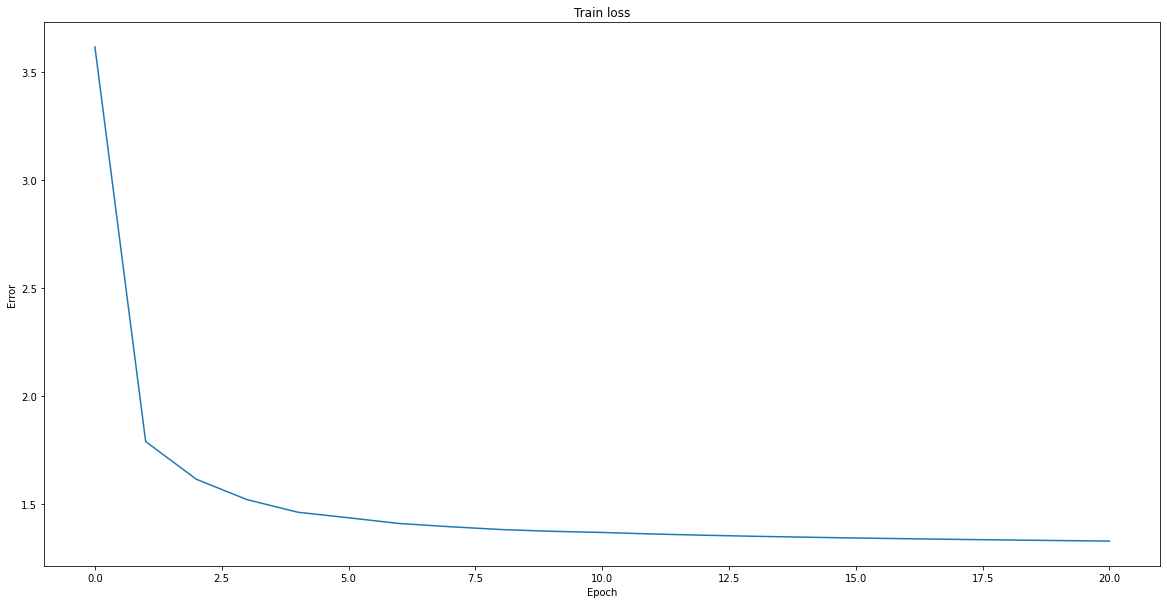

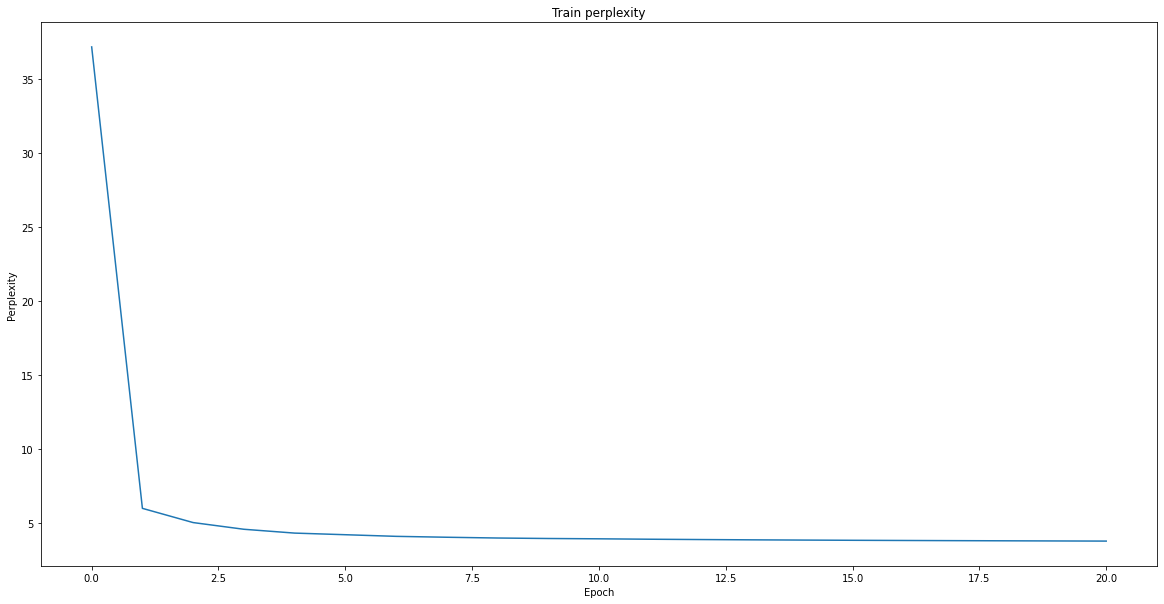

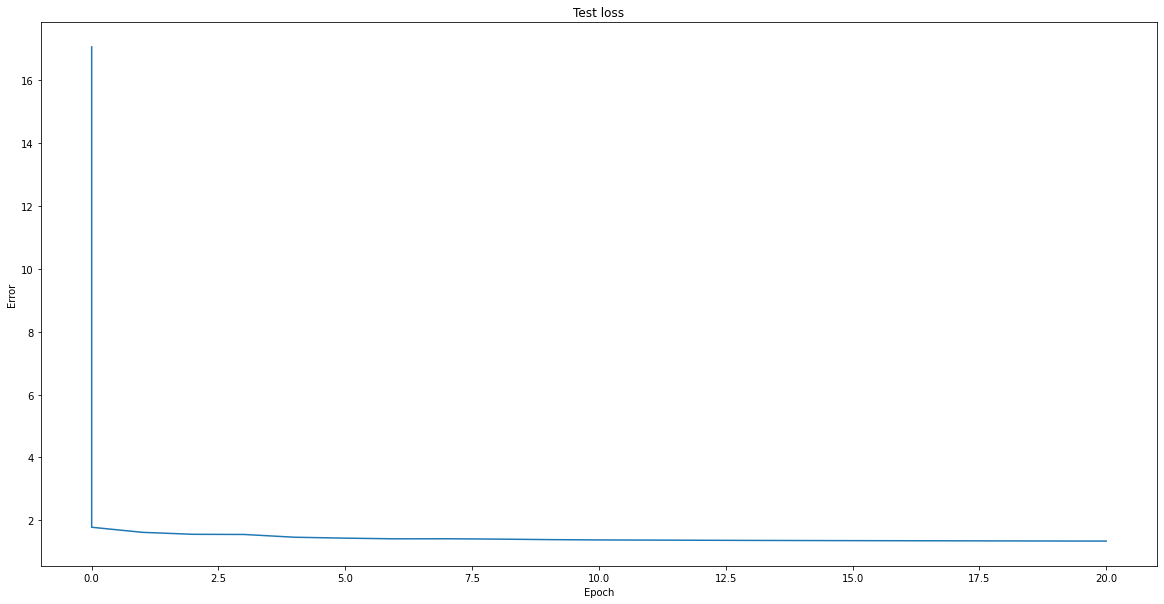

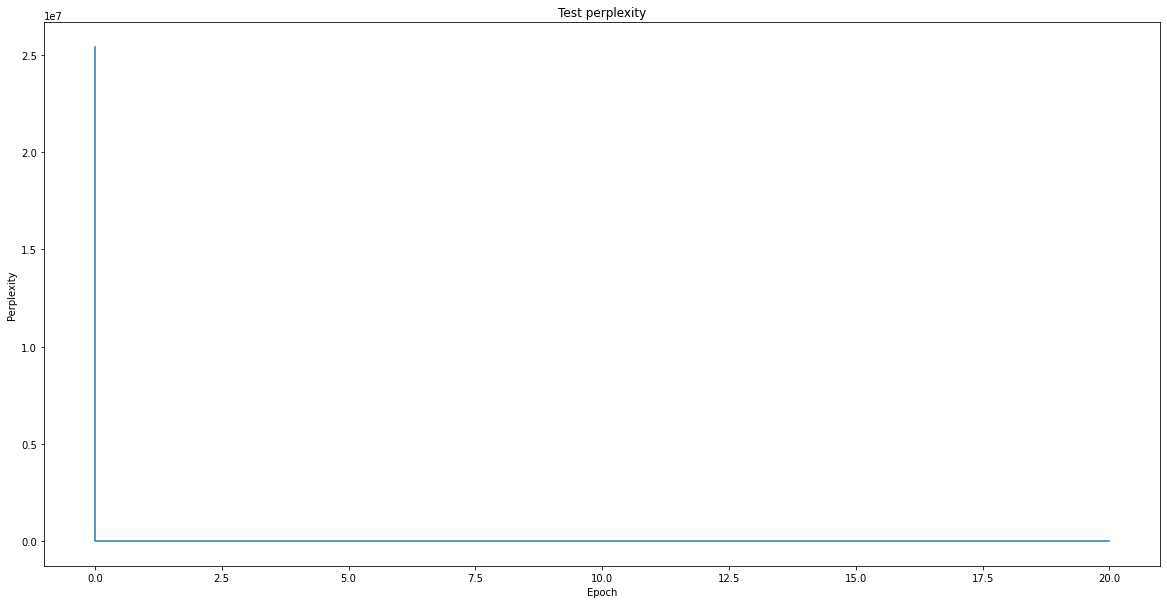

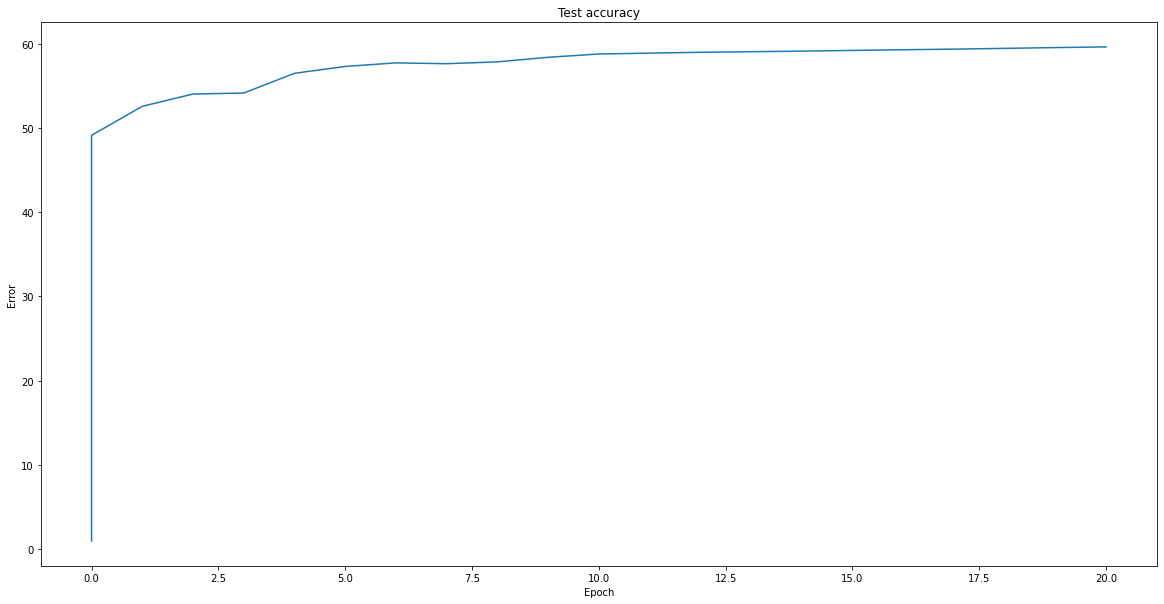

Final test accuracy =  59.67012117346939
Final test perplexity = 3.828577940003643


In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)


            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '


            # KMARATHE debugging
            print("here----in try 111111-----------------------")
            # KMARATHE debugging
       
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')



            # KMARATHE debugging
            print("here----in try 22222-----------------------")
            # KMARATHE debugging
       
            print('generated max\t\t', generated_sentence)

            
             

            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
         # KMARATHE debugging
        print("here----in except-----------------------")
        # KMARATHE debugging
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        
        ep, train_val = zip(*train_losses)
        pt_util.plot(ep, train_val, 'Train loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(train_val),'Train perplexity', 'Epoch', 'Perplexity')

        ep, test_val = zip(*test_losses)
        pt_util.plot(ep, test_val, 'Test loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(test_val),'Test perplexity', 'Epoch', 'Perplexity')

        ep, val = zip(*test_accuracies)       
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        print("Final test accuracy = ", val[-1])
        print("Final test perplexity =", np.exp(test_val[-1]))
        
        return model, vocab, device

final_model, vocab, device = main()

# New Section

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200 #COMMENTED FOR TESTING VTHOMA
    #sequence_length = 20

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

in sampling strategy max-----------------------
out of for loop
[4, 15, 7, 1, 2, 7, 8, 10, 4, 7, 6, 4, 7, 11, 8, 4, 13, 1, 2, 8, 4, 6, 35, 4, 7, 11, 8, 4, 13, 1, 15, 7, 33, 8, 4, 1, 9, 10, 4, 15, 7, 1, 2, 7, 8, 10, 4, 7, 6, 4, 37, 8, 4, 1, 37, 33, 8, 4, 7, 6, 4, 7, 11, 8, 4, 6, 7, 11, 8, 2, 4, 15, 38, 10, 8, 4, 6, 35, 4, 7, 11, 8, 4, 13, 1, 15, 7, 33, 8, 4, 1, 9, 10, 4, 15, 7, 1, 2, 7, 8, 10, 4, 7, 6, 4, 37, 8, 4, 1, 37, 33, 8, 4, 7, 6, 4, 7, 11, 8, 4, 6, 7, 11, 8, 2, 4, 15, 38, 10, 8, 4, 6, 35, 4, 7, 11, 8, 4, 13, 1, 15, 7, 33, 8, 4, 1, 9, 10, 4, 15, 7, 1, 2, 7, 8, 10, 4, 7, 6, 4, 37, 8, 4, 1, 37, 33, 8, 4, 7, 6, 4, 7, 11, 8, 4, 6, 7, 11, 8, 2, 4, 15, 38, 10, 8, 4, 6, 35, 4, 7, 11, 8, 4, 13, 1, 15, 7, 33, 8, 4]
generated with max	 Harry Potter and the started to the care of the castle and started to be able to the other side of the castle and started to be able to the other side of the castle and started to be able to the other side of the castle 
generated with sample	 Harry Potter a

In [ ]:
#----MORE EXPERIMENTS
seed = "Voldemort "
sequence_length = 100

generated_sentence = generate_language(final_model, device, seed, sequence_length, vocab, 'max')
print('generated with max\t', generated_sentence)

generated_sentence = generate_language(final_model, device, seed, sequence_length, vocab, 'sample')
print('generated with sample\t', generated_sentence)

seed = "Harry was ready with "
generated_sentence = generate_language(final_model, device, seed, sequence_length, vocab, 'beam')
print('generated with beam\t', generated_sentence)

seed = "Harry was ready to "
generated_sentence = generate_language(final_model, device, seed, sequence_length, vocab, 'beam')
print('generated with beam\t', generated_sentence)

in sampling strategy max-----------------------
out of for loop
[40, 1, 15, 4, 1, 4, 15, 7, 2, 8, 7, 13, 11, 4, 6, 35, 4, 7, 11, 8, 4, 13, 1, 15, 7, 33, 8, 4, 6, 35, 4, 7, 11, 8, 4, 13, 1, 15, 7, 33, 8, 4, 6, 35, 4, 7, 11, 8, 4, 13, 1, 15, 7, 33, 8, 4, 1, 9, 10, 4, 7, 11, 8, 4, 15, 7, 1, 2, 7, 8, 10, 4, 15, 7, 32, 10, 8, 9, 7, 15, 4, 1, 9, 10, 4, 15, 7, 1, 2, 7, 8, 10, 4, 7, 6, 4, 7, 11, 8, 4]
generated with max	 Voldemort was a stretch of the castle of the castle of the castle and the started students and started to the 
generated with sample	 Voldemort have read the Interneation of Magic is here and fear our to the back of the darkness course he was t
generated with beam	 Harry was ready with everything to the rumbledore who had been summering the back of the corridor, then he said, who was s
generated with beam	 Harry was ready to Harry and Hermione for the screeches were specting out of the school and damp as though he was not as


In [ ]:
# MORE EXPERIMNETS ----- CHANGE TEMPERATURE VALUE -----
BEAM_WIDTH = 10
TEMPERATURE_LIST = [-0.5, 0, 0.5, 0.8, 1.5, 2]
seed = "Harry was ready "
sequence_length = 100

for TEMP in TEMPERATURE_LIST:
  TEMPERATURE = TEMP  
  print(" -------Testing TEMPERATURE=", TEMPERATURE)

  generated_sentence = generate_language(final_model, device, seed, sequence_length, vocab, 'sample')
  print('generated with sample\t', generated_sentence)

  generated_sentence = generate_language(final_model, device, seed, sequence_length, vocab, 'beam')
  print('generated with beam\t', generated_sentence)



 -------Testing TEMPERATURE= -0.5
generated with sample	 Harry was ready quite and started to the start of the castle and started to the stairs and started to the stairs and
generated with beam	 Harry was ready up to the stairs and started to the started and started to the stairs and started to the stairs and s
 -------Testing TEMPERATURE= 0
generated with sample	 Harry was ready something and said it was a stream of the castle of the castle and started to the stairs and started
generated with beam	 Harry was ready up to the stairs and started to the started and started to the stairs and started to the stairs and s
 -------Testing TEMPERATURE= 0.5
generated with sample	 Harry was ready at the wand when he had seen the bag in his wand and streamed and sprang his wand, but he had been h
generated with beam	 Harry was ready up the ground later, "I has got a better out of the Dumbledore at the Dursleys, that he was so that h
 -------Testing TEMPERATURE= 0.8
generated with sample	 Harry was

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



In [ ]:
# ------------------ADDED BY KMARATHE : CHARLES DARWIN DATASET EXPERIMENT ----------------------
# TRYING OTHER DATASET: DARWIN AND EVOLUTION
if not os.path.exists(os.path.join(DATA_PATH, 'Charles_Darwin.txt')):
    os.chdir(BASE_PATH)
    !git clone https://github.com/kalyani7195/charles_darwin_gutenberg.git
    !cp charles_darwin_gutenberg/Charles_Darwin.txt Charles_Darwin.txt
os.chdir(BASE_PATH)

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util



In [ ]:
#------------------------ADDED BY KMARATHE : CHARLES DARWIN DATASET EXPERIMENT---------------------
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()

    #-----------KMARATHE test code----------
    print("......Data before preprocessing.......")
    print(data[0:1000])

    print("\n\n")
    print(".......Data after preprocessing......")
    data = " ".join(data.split())
    print(data[0:1000])
    #----------- KMARATHE test code ------------
    
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    i=0
    for char in data:
        #pass # TODO Fill this in
        # ********VTHOMA******
        if not char in voc2ind:
            voc2ind[char]=i
            i+=1
        # ********VTHOMA******


    print("\n")
    print("voc2ind=", voc2ind)
    ind2voc = {val: key for key, val in voc2ind.items()}
    print("ind2voc=", ind2voc)

    # KMARATHE Added this --------------
    print("len(data)=", len(data))
    num_chars = len(data)
    training_num_chars = int(num_chars * 0.8)
    print("training_num_chars=", training_num_chars)
    testing_num_chars = num_chars  - training_num_chars
    print("testing_num_chars=", testing_num_chars)

    train_text = data[0:training_num_chars ]
    print("last part of train:", train_text[training_num_chars-10:training_num_chars])
    test_text = data[training_num_chars:num_chars ]
    print("starting of test:", test_text[0:10])
    # KMARATHE Added this --------------


    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'Charles_Darwin_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'Charles_Darwin_chars_test.pkl', 'wb'))
    
    # ---- ADDED BY VTHOMA FOR TESTING PURPOSE ------
    pickle.dump({'tokens': test_text[0:23], 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'charlesdarwin_23_test.pkl', 'wb'))

prepare_data(DATA_PATH + 'Charles_Darwin.txt')

class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        # kmarathe debug
        #print("array  in array to words-----", arr)
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        # kmarathe debug 
        #print("words in words to array----" words)
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

print("\nDetails of v_train....")
v_train = Vocabulary(DATA_PATH + 'Charles_Darwin_chars_train.pkl')
print("ind2voc=", v_train.ind2voc)
print("ind2voc=",v_train.voc2ind)
print("v_train.array_to_words([1, 2, 3, 4, 5])=",v_train.array_to_words([1, 2, 3, 4, 5] ))
print("v_train.words_to_array(['H', 'a', 'r', 'r', 'y'] )=", v_train.words_to_array(['H', 'a', 'r', 'r', 'y'] ))
print("v_train.__len__()=",v_train.__len__())

print("\nDetails of v_test.....")
v_test = Vocabulary(DATA_PATH + 'Charles_Darwin_chars_test.pkl')
print("ind2voc=",v_test.ind2voc)
print("ind2voc=",v_test.voc2ind)
print("v_train.array_to_words([1, 2, 3, 4, 5])=", v_test.array_to_words([1, 2, 3, 4, 5]))
print("v_train.words_to_array(['H', 'a', 'r', 'r', 'y'] )=", v_test.words_to_array(['H', 'a', 'r', 'r', 'y'] ))
print("v_train.__len__()=",v_test.__len__())



......Data before preprocessing.......
The Project Gutenberg EBook of The Descent of Man, by Charles Darwin

This eBook is for the use of anyone anywhere at no cost and with almost
no restrictions whatsoever. You may copy it, give it away or re-use
it under the terms of the Project Gutenberg License included with this
eBook or online at www.gutenberg.org


Title: The Descent of Man

Author: Charles Darwin

Posting Date: January 6, 2013 [EBook #2300]
First Posted: November 28, 1999
Last Updated: October 9, 2017

Language: English


*** START OF THIS PROJECT GUTENBERG EBOOK THE DESCENT OF MAN ***




Produced by Sue Asscher










THE DESCENT OF MAN

AND

SELECTION IN RELATION TO SEX


Works by Charles Darwin, F.R.S.

Life and Letters of Charles Darwin. With an Autobiographical Chapter.
Edited by Francis Darwin. Portraits. 3 volumes 36s. Popular Edition.
Condensed in 1 volume 7s 6d.

Naturalist's Journal of Researches into the Natural History and
Geology of Countries Visited during a 

In [ ]:
#----------- ADDED BY KMARATHE --- CHARLES DARWIN DATASET---------

import math

class CharlesDarwinDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(CharlesDarwinDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)


        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

            # KMARATHE Test are we supposed to truncate the data in case length is not a multiple of batch size?? 
            #print(type(dataset))
        #print("Original dataset=", dataset['tokens'])
        #print("token rep")

      
        # TODO: Any preprocessing on the data to get it to the right shape.
        # ----- ADDED BY VTHOMA -------
        # kMARATHE Modified ==== dataset['token']  contains the actual data not dataset....
        len_dataset = (int(len(dataset['tokens'])/batch_size))*batch_size
        dataset = dataset['tokens'][0:len_dataset]
        self.len_dataset = len_dataset

        self.len_chunk = self.len_dataset/self.batch_size

        # ----- ADDED BY VTHOMA -------

        # KMARATHE ADDING TEST CODE--------
        #print("after preprocessing the dataset -----------")
        #print("len_dataset = ",self.len_dataset)
        #print("preprocessed dataset=",dataset)
        self.dataset = dataset
        # KMARATHE ADDING TEST CODE--------

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        # raise NotImplementedError 
        
        # ---- ADDED BY VTHOMA ------
        # Not sure what is meant by 'number of unique sequences'. Assuming that 
        # for the example given, this value is 6.
        #print("in __len__")
        #len_chunk = self.len_dataset/self.batch_size
        num_seq_per_chunk = math.ceil((self.len_chunk-1)/self.sequence_length)

        
        # KMARATHE adding test code -----
        #print("len_chunk=", len_chunk)
        #self.len_chunk = len_chunk
        #print("num_seq_per_chunk=", num_seq_per_chunk)
        #print("num_seq_per_chunk*batch_size=", num_seq_per_chunk*self.batch_size)
        # KMARATHE adding test code -----

        return num_seq_per_chunk*self.batch_size
        # ----- ADDED BY VTHOMA -----
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO

        # --------------------KMARATHE ADDED THIS-----------
        #print("dataset=",self.dataset)
        batch_number = idx//self.batch_size
        #print("batch number=", batch_number)
        col_num = idx % self.batch_size
        #print("col number =", col_num)
        #print("start data=", self.len_chunk * col_num + (batch_number) * self.sequence_length )
        start = int(self.len_chunk * col_num + (batch_number) * self.sequence_length )
        
        max_num_allowed = self.len_chunk * (col_num +1 )-2
        end = int(min(self.len_chunk * col_num + (batch_number) * self.sequence_length +self.sequence_length-1, max_num_allowed))
        #print("end(inclusive) data=", end)
        #print(self.dataset)
        #print(self.dataset[start: end+1])
        data = self.vocab.words_to_array(self.dataset[start: end+1])
        labels = self.vocab.words_to_array(self.dataset[start+1: end+2])

        #print("data", data)
        #print("labels", labels)
        return data, labels

         # --------------------KMARATHE ADDED THIS---------

        #data = None
        #return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)


print("\n Testing CharlesDarwinDataset class.......")
TEST_SEQUENCE_LENGTH = 3
TEST_BATCH_SIZE = 2
data_file = DATA_PATH + 'charlesdarwin_23_test.pkl'
with open(data_file, 'rb') as data_pkl:
    dataset = pickle.load(data_pkl)
print("Dataset=", dataset['tokens'])

data_vthoma_test = CharlesDarwinDataset(DATA_PATH + 'charlesdarwin_23_test.pkl', 3, 2)
print("Dataset as tokens=", data_vthoma_test.vocab.words_to_array(dataset['tokens']))
print("Test batch size=", TEST_BATCH_SIZE)
print("Test sequence length=", TEST_SEQUENCE_LENGTH)
print("Number of unique sequences=", data_vthoma_test.__len__() )
print("Data and label for idx=3 is", data_vthoma_test.__getitem__(3))






 Testing CharlesDarwinDataset class.......
Dataset= ee to be bound by the t
Dataset as tokens= tensor([ 2,  2,  3,  9,  6,  3, 13,  2,  3, 13,  6, 11, 12, 29,  3, 13, 24,  3,
         9,  1,  2,  3,  9])
Test batch size= 2
Test sequence length= 3
Number of unique sequences= 8
Data and label for idx=3 is (tensor([ 3, 13, 24]), tensor([13, 24,  3]))


In [ ]:
# --------- ADDED BY KMARATHE-- CHARLES DARWIN DATASET

TEMPERATURE = 0.5

class CharlesDarwinNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(CharlesDarwinNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        # KMARATHE TESTING EMBEDDING ----------
        print(self.vocab_size)
        print(self.feature_size)
        print(self.encoder)
        # KMARATHE TESTING EMBEDDING ----------
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        print(self.gru)

        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        

        print(self.decoder)
        # This shares the encoder and decoder weights as described in lecture.
        # KMARATHE WHY???
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # raise NotImplementedError 
        # ----- ADDED BY VTHOMA -----
        encoded = self.encoder(x)
        output,hidden_state = self.gru(encoded, hidden_state)
        #output, hidden_state = self.gru(encoded.view(batch_size, sequence_length, -1),hidden_state)
        decoded = self.decoder(output)
        x = decoded
        # ----- ADDED BY VTHOMA -----

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


In [ ]:
# ADDED BY KMARATHE CHARLES DARWIN DATASET

TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
      
    outputs = []
    for ii in range(sequence_length):
        # TODO

        # ---- ADDED BY VTHOMA ----
        #max_prob_index = np.argmax(output.numpy())
        val, argmax = output.max(-1)
        max_prob_index = argmax.item()
     
        #max_prob_char = vocab.ind2voc[max_prob_index]
        max_prob_char = vocab.array_to_words([max_prob_index])
        max_prob_char_array = vocab.words_to_array(max_prob_char)
        outputs.append(max_prob_index)

        max_prob_char_array = max_prob_char_array.to(device)
        output, hidden = model.inference(max_prob_char_array, hidden, temperature = TEMPERATURE)

        # ---- ADDED BY VTHOMA ----

    print("out of for loop")
    print(outputs)
    return outputs


def sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []
    for ii in range(sequence_length):
        # TODO

        p = output.to(device).cpu().numpy().flatten()
        chosen_prob_index = np.random.choice(vocab.__len__(), size=None, p=p)
        chosen_prob_char = vocab.array_to_words([chosen_prob_index])
        chosen_prob_char_array = vocab.words_to_array(chosen_prob_char)

        outputs.append(chosen_prob_index)
        chosen_prob_char_array = chosen_prob_char_array.to(device)
        output, hidden = model.inference(chosen_prob_char_array, hidden, temperature  = TEMPERATURE)

    return outputs


def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device):
    outputs = []
    #beams = [([], output, hidden, 0)]
    beams = []
    # TODO
    #raise NotImplementedError

    # ---- ADDED BY VTHOMA ----
    """
    1. Initialize the beam list with the single existing empty beam
    2. Repeat for the sequence length:
      1. For each beam in the beam list:
          1. Compute the next distribution over the output space for that state
          2. Sample from the distribution with replacement
          3. For each sample:
              1. Compute its score
              2. Record its hidden state and chosen value
          4. Add all the samples to the new beam list      
      2. Rank the new beam list
      3. Throw out all but the top N beams
    3. Return the top beam's chosen values.
    """
    #print("Inside beam sampling. output=", output)
    output = output.to(device)
    scores = torch.log(output[0])
    #print("scores=", scores)
    scores_index_sorted = torch.argsort(scores)[-beam_width:]
    #print("scores_index_sorted=", scores_index_sorted)
    
    for i in scores_index_sorted:
      score = torch.log(scores[i])
      beams.append(([i],hidden, output,score))   
    
    for li in range(sequence_length):
      #print("li=", li)
      new_beams = []
      for beam in beams:
        #print("beam=", beam)
        #print("beam[0]=", beam[0])
        #ind = torch.LongTensor(beam[0])
        if len(beam[0])>1:
          ind = torch.LongTensor([beam[0][-1]])
        else:
          ind = torch.LongTensor(beam[0])
        #print("ind=", ind)
        output, hidden = model.inference(ind.to(device), beam[1], temperature = TEMPERATURE)
        samples = torch.multinomial(output, beam_width)
        #print("samples=", samples)
        for sample in samples[0]:
          new_beam_seq = beam[0].copy()
          new_beam_seq.append(sample)
          score = beam[3] + torch.log(output[0][sample])
          new_beam = (new_beam_seq, hidden, output, score)
          new_beams.append(new_beam)

      #Sort new_beams
      #print("Sorting new_beams.....")
      #print("new_beams=", new_beams)
      new_beams = sorted(new_beams, key=lambda x: x[3], reverse=True)
      #print("len_new_beams=", len(new_beams))

      #Keep only BEAM WIDTH top beams
      beams = new_beams[0:BEAM_WIDTH]
      
    #Return top beams chosen values
    outputs = beams[0][0]

    # ---- ADDED BY VTHOMA ----
    return outputs



def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden, temperature = TEMPERATURE)
        
        if sampling_strategy == 'max':
            #kmarathe debugging
            print("in sampling strategy max-----------------------") 
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)


In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
156
512
Embedding(156, 512)
GRU(512, 512, batch_first=True)
Linear(in_features=512, out_features=156, bias=True)
Restoring:
encoder.weight -> 	torch.Size([156, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([156, 512]) = 0MB
decoder.bias -> 	torch.Size([156]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints_charles_darwin/020.pt
Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te setnd ty the srrms of thes sneeement  aou way bnsain t lemeld ooom the srrion of sverri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are locate

  0%|          | 0/310 [00:00<?, ?it/s]


Test set: Average loss: 1.4488, Accuracy: 1163913/1996800 (58%)



  0%|          | 1/310 [00:00<00:52,  5.92it/s]

Train Epoch: 20 [0/79360 (0%)]	Loss: 1.363930


  4%|▍         | 13/310 [00:01<00:27, 10.61it/s]

Train Epoch: 20 [2560/79360 (3%)]	Loss: 1.653449


  7%|▋         | 23/310 [00:01<00:23, 12.01it/s]

Train Epoch: 20 [5120/79360 (6%)]	Loss: 1.467945


 11%|█         | 33/310 [00:02<00:22, 12.06it/s]

Train Epoch: 20 [7680/79360 (10%)]	Loss: 1.440357


 14%|█▍        | 43/310 [00:03<00:22, 11.78it/s]

Train Epoch: 20 [10240/79360 (13%)]	Loss: 1.379004


 17%|█▋        | 53/310 [00:04<00:21, 12.16it/s]

Train Epoch: 20 [12800/79360 (16%)]	Loss: 1.410063


 20%|██        | 63/310 [00:05<00:20, 11.87it/s]

Train Epoch: 20 [15360/79360 (19%)]	Loss: 1.382961


 24%|██▎       | 73/310 [00:06<00:19, 12.06it/s]

Train Epoch: 20 [17920/79360 (23%)]	Loss: 1.338682


 27%|██▋       | 83/310 [00:07<00:19, 11.87it/s]

Train Epoch: 20 [20480/79360 (26%)]	Loss: 1.352384


 30%|███       | 93/310 [00:07<00:18, 11.96it/s]

Train Epoch: 20 [23040/79360 (29%)]	Loss: 1.354236


 33%|███▎      | 103/310 [00:08<00:17, 11.98it/s]

Train Epoch: 20 [25600/79360 (32%)]	Loss: 1.369318


 36%|███▋      | 113/310 [00:09<00:16, 11.98it/s]

Train Epoch: 20 [28160/79360 (35%)]	Loss: 1.378091


 40%|███▉      | 123/310 [00:10<00:15, 11.79it/s]

Train Epoch: 20 [30720/79360 (39%)]	Loss: 1.393406


 43%|████▎     | 133/310 [00:11<00:15, 11.68it/s]

Train Epoch: 20 [33280/79360 (42%)]	Loss: 1.388633


 46%|████▌     | 143/310 [00:12<00:14, 11.68it/s]

Train Epoch: 20 [35840/79360 (45%)]	Loss: 1.358407


 49%|████▉     | 153/310 [00:12<00:13, 11.93it/s]

Train Epoch: 20 [38400/79360 (48%)]	Loss: 1.371163


 53%|█████▎    | 163/310 [00:13<00:12, 11.81it/s]

Train Epoch: 20 [40960/79360 (52%)]	Loss: 1.363019


 56%|█████▌    | 173/310 [00:14<00:11, 11.80it/s]

Train Epoch: 20 [43520/79360 (55%)]	Loss: 1.383287


 59%|█████▉    | 183/310 [00:15<00:10, 11.82it/s]

Train Epoch: 20 [46080/79360 (58%)]	Loss: 1.384404


 62%|██████▏   | 193/310 [00:16<00:09, 11.80it/s]

Train Epoch: 20 [48640/79360 (61%)]	Loss: 1.359748


 65%|██████▌   | 203/310 [00:17<00:09, 11.82it/s]

Train Epoch: 20 [51200/79360 (65%)]	Loss: 1.397365


 69%|██████▊   | 213/310 [00:18<00:08, 11.60it/s]

Train Epoch: 20 [53760/79360 (68%)]	Loss: 1.370422


 72%|███████▏  | 223/310 [00:18<00:07, 11.72it/s]

Train Epoch: 20 [56320/79360 (71%)]	Loss: 1.359004


 75%|███████▌  | 233/310 [00:19<00:06, 11.71it/s]

Train Epoch: 20 [58880/79360 (74%)]	Loss: 1.359700


 78%|███████▊  | 243/310 [00:20<00:05, 11.69it/s]

Train Epoch: 20 [61440/79360 (77%)]	Loss: 1.396448


 82%|████████▏ | 253/310 [00:21<00:04, 11.57it/s]

Train Epoch: 20 [64000/79360 (81%)]	Loss: 1.364417


 85%|████████▍ | 263/310 [00:22<00:04, 11.63it/s]

Train Epoch: 20 [66560/79360 (84%)]	Loss: 1.403818


 88%|████████▊ | 273/310 [00:23<00:03, 11.63it/s]

Train Epoch: 20 [69120/79360 (87%)]	Loss: 1.394864


 91%|█████████▏| 283/310 [00:24<00:02, 11.75it/s]

Train Epoch: 20 [71680/79360 (90%)]	Loss: 1.380445


 95%|█████████▍| 293/310 [00:24<00:01, 11.65it/s]

Train Epoch: 20 [74240/79360 (94%)]	Loss: 1.364464


 98%|█████████▊| 303/310 [00:25<00:00, 11.48it/s]

Train Epoch: 20 [76800/79360 (97%)]	Loss: 1.374553


100%|██████████| 310/310 [00:26<00:00, 11.76it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te setnd ty the srrms of thes sneeement  aeu way bfsain t lemeld toom the srrion of sxeiri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States  T  t yinsividual sirk os at the srrlis oowenn on the snited States ond tourwne tenkled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oarkeahe sat  of tour sanltry ws t mition oh the srrms of thes sneeement oetore tenn ywd,ng  aonirng


Input	with this eBook or online at www.gute

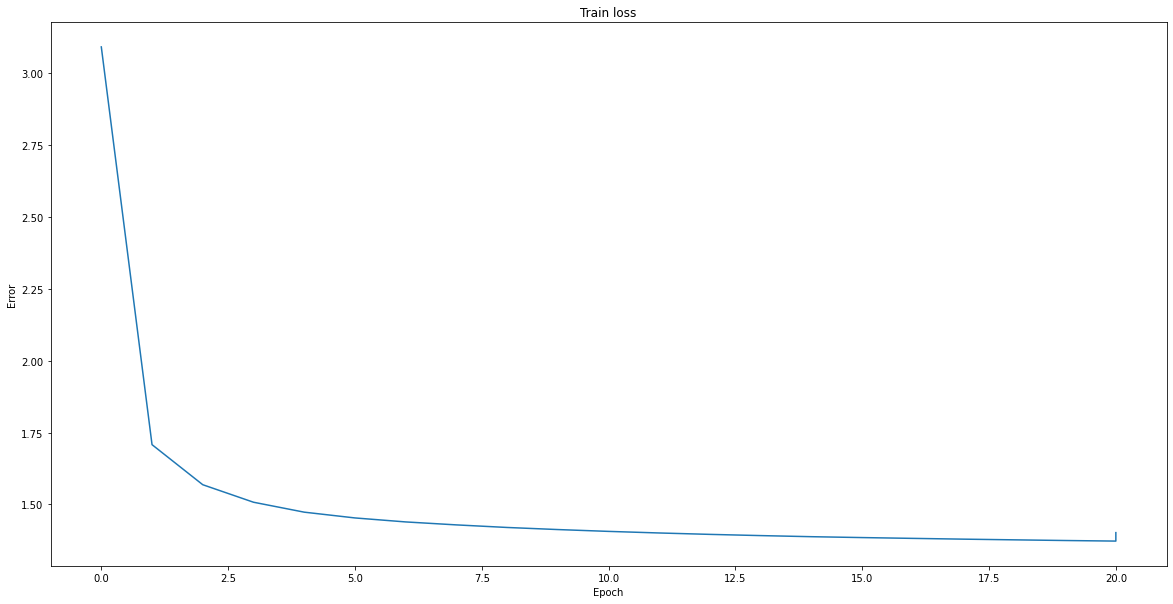

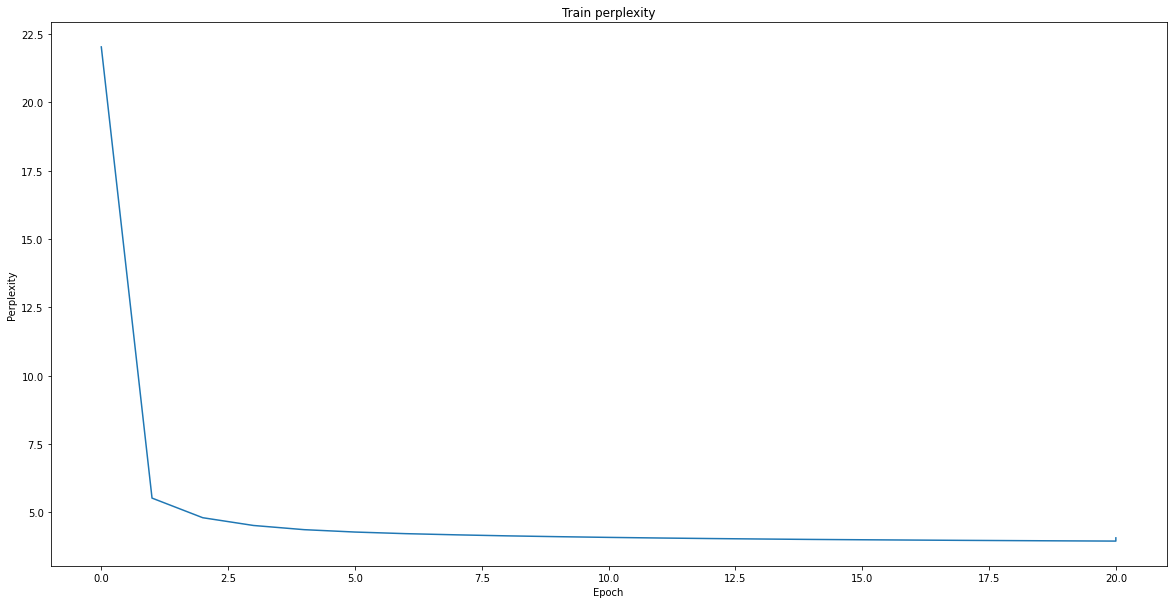

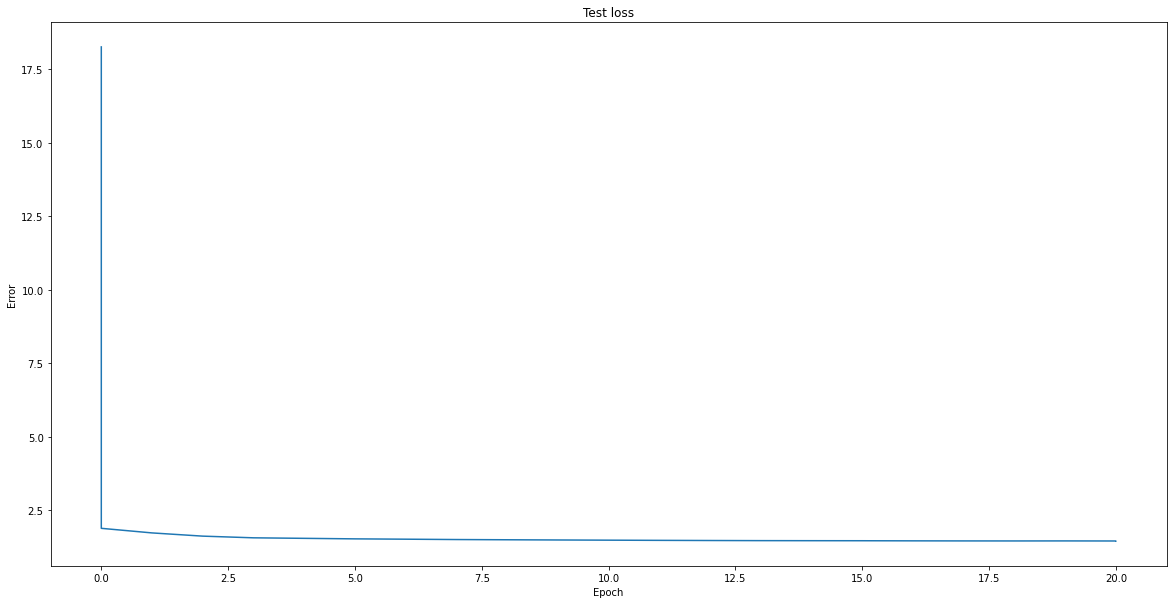

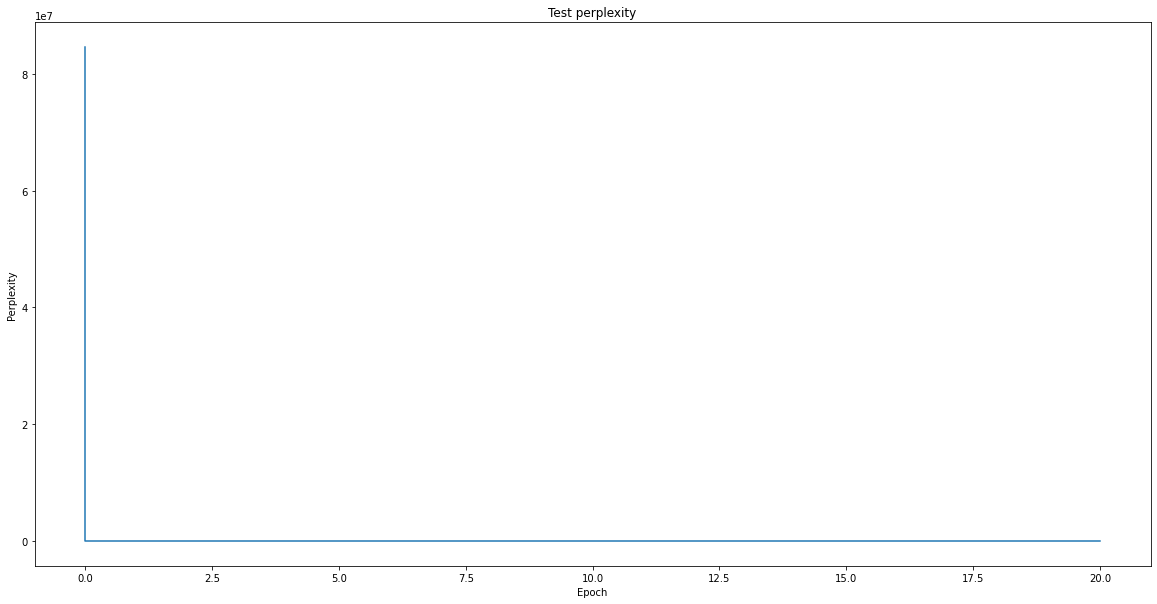

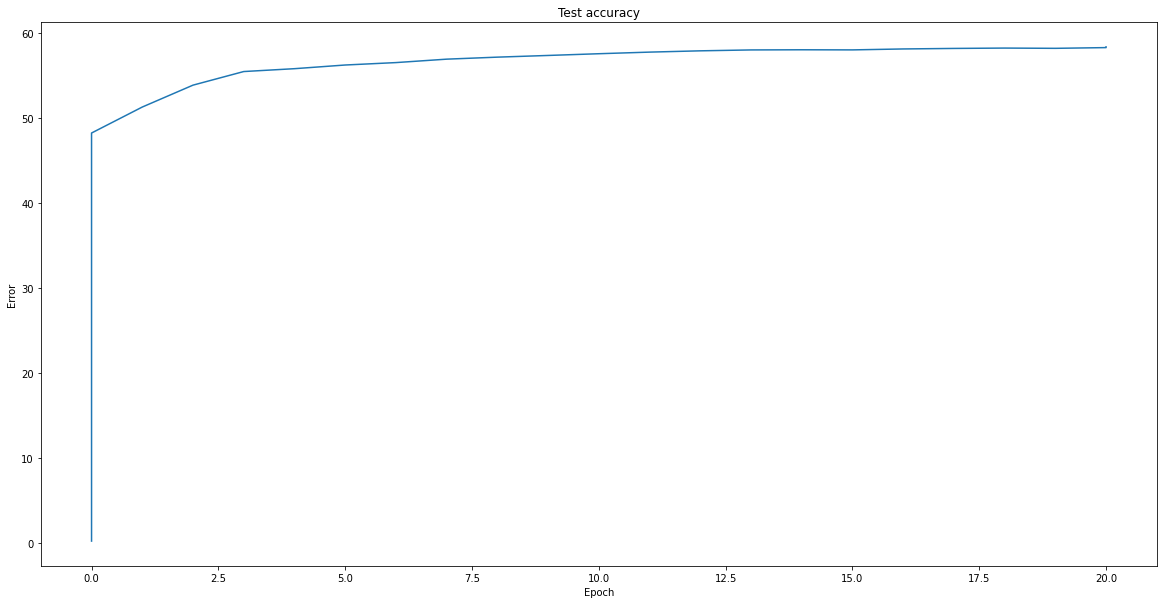

Final test accuracy =  58.37059294871795
Final test perplexity = 4.243072128091712


In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs_charles_darwin/log.pkl'


    data_train = CharlesDarwinDataset(DATA_PATH + 'Charles_Darwin_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = CharlesDarwinDataset(DATA_PATH + 'Charles_Darwin_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = CharlesDarwinNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_charles_darwin')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_charles_darwin/%03d.pt' % epoch)


            seed_words = 'When we look to the hereditary varieties or races of our domestic animals and plants'


            # KMARATHE debugging
            print("here----in try 111111-----------------------")
            # KMARATHE debugging
       
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')



            # KMARATHE debugging
            print("here----in try 22222-----------------------")
            # KMARATHE debugging
       
            print('generated max\t\t', generated_sentence)

            
             

            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
         # KMARATHE debugging
        print("here----in except-----------------------")
        # KMARATHE debugging
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_charles_darwin/%03d.pt' % epoch, 0)
        
        ep, train_val = zip(*train_losses)
        pt_util.plot(ep, train_val, 'Train loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(train_val),'Train perplexity', 'Epoch', 'Perplexity')

        ep, test_val = zip(*test_losses)
        pt_util.plot(ep, test_val, 'Test loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(test_val),'Test perplexity', 'Epoch', 'Perplexity')

        ep, val = zip(*test_accuracies)       
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        print("Final test accuracy = ", val[-1])
        print("Final test perplexity =", np.exp(test_val[-1]))
        
        return model, vocab, device

final_model, vocab, device = main()

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Worms appear to be less sensitive to'
    sequence_length = 200 #COMMENTED FOR TESTING VTHOMA
    #sequence_length = 20

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

in sampling strategy max-----------------------
out of for loop
[3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18]
generated with max	 Worms appear to be less sensitive to the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species o

In [ ]:
#----MORE EXPERIMENTS KMARATHE ADDED THIS --- EXPERIMENTS WITH SEQUENCE LENGTH
seed = "Dogs are "
for sequence_length in range(50, 1000, 50):
  print("----------- SEQUENCE LENGTH----------- =", sequence_length  )
  generated_sentence = generate_language(final_model, device, seed, sequence_length, vocab, 'max')
  print('generated with max\t', generated_sentence)

  generated_sentence = generate_language(final_model, device, seed, sequence_length, vocab, 'sample')
  print('generated with sample\t', generated_sentence)

  generated_sentence = generate_language(final_model, device, seed, sequence_length, vocab, 'beam')
  print('generated with beam\t', generated_sentence)

  generated_sentence = generate_language(final_model, device, seed, sequence_length, vocab, 'beam')
  print('generated with beam\t', generated_sentence)

----------- SEQUENCE LENGTH----------- = 50
in sampling strategy max-----------------------
out of for loop
[22, 26, 26, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22]
generated with max	 Dogs are all the same species of the same species of the sa
generated with sample	 Dogs are of the same to a smiller and except in the same sp
generated with beam	 Dogs are easily drawn of gradually and some of the same spec
generated with beam	 Dogs are extraordinary smaller as a few wealth is not a litt
----------- SEQUENCE LENGTH----------- = 100
in sampling strategy max-----------------------
out of for loop
[22, 26, 26, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18,

In [ ]:
# MORE EXPERIMNETS ----- CHANGE TEMPERATURE VALUE -----
BEAM_WIDTH = 10
TEMPERATURE_LIST = [-0.5, 0, 0.5, 0.8, 1, 1.5, 2]
seed = "Butterfly "
sequence_length = 100

for TEMP in TEMPERATURE_LIST:
  TEMPERATURE = TEMP  
  print(" -------Testing TEMPERATURE=", TEMPERATURE)

  generated_sentence = generate_language(final_model, device, seed, sequence_length, vocab, 'sample')
  print('generated with sample\t', generated_sentence)

  generated_sentence = generate_language(final_model, device, seed, sequence_length, vocab, 'beam')
  print('generated with beam\t', generated_sentence)



 -------Testing TEMPERATURE= -0.5
generated with sample	 Butterfly and the same species of the same species of the same species of the same species of the same species
generated with beam	 Butterfly ′alled species of the same species of the same species of the same species of the same species of the
 -------Testing TEMPERATURE= 0
generated with sample	 Butterfly and the same species of the same species of the same species of the same species of the same species
generated with beam	 Butterfly ′alled species of the same species of the same species of the same species of the same species of the
 -------Testing TEMPERATURE= 0.5
generated with sample	 Butterfly and others in the same themselves at any of the plants of the same grave, but the reference of the o
generated with beam	 Butterfly experience of any of which the organs of the terms of structure is not a complex and produced for the
 -------Testing TEMPERATURE= 0.8
generated with sample	 Butterfly redust to known in the same male. A

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# -------- VTHOMA ---------------
# TRYING LSTM

TEMPERATURE = 0.5

class HarryPotterNetLSTM(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNetLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        # KMARATHE TESTING EMBEDDING ----------
        print(self.vocab_size)
        print(self.feature_size)
        print(self.encoder)
        # KMARATHE TESTING EMBEDDING ----------
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, 2, dropout=0.5, batch_first=True)
        print(self.lstm)

        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        

        print(self.decoder)
        # This shares the encoder and decoder weights as described in lecture.
        # KMARATHE WHY???
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None, cell_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # raise NotImplementedError 
        # ----- ADDED BY VTHOMA -----
        encoded = self.encoder(x)
        output,hidden_state = self.lstm(encoded, hidden_state)
        #output,(hidden_state, cell_state) = self.lstm(encoded, (hidden_state, cell_state))
        decoded = self.decoder(output)
        x = decoded
        # ----- ADDED BY VTHOMA -----

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
89
512
Embedding(89, 512)
LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5)
Linear(in_features=512, out_features=89, bias=True)
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	ZZEEvv?===}}aaE9QQ}ZZ}%%ZZZ99Z%===VV%%l%%%lEEE}}==///EEEvvvv?MTMQVVVZV9MMMQQCQC==CkkkEE===ll==U=9=Q9


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	Evkk%%VVVVVVv?VyV%%l%llll QQ9ELLEEV}EV%==QNh;;%yy}vhZ%9EE9%9==!VVV}}M=VZZZ9}}VV!!!=MM}}}}===VV%%%%V%


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one h

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 4.8540, Accuracy: 7794/1254400 (1%)



  1%|          | 1/195 [00:00<01:03,  3.06it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 4.975954


  6%|▌         | 11/195 [00:02<00:40,  4.60it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 3.396163


 11%|█         | 21/195 [00:04<00:37,  4.64it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 2.694394


 16%|█▌        | 31/195 [00:06<00:35,  4.63it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.470835


 21%|██        | 41/195 [00:08<00:33,  4.62it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.328651


 26%|██▌       | 51/195 [00:11<00:31,  4.62it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.238350


 31%|███▏      | 61/195 [00:13<00:29,  4.52it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 2.194688


 36%|███▋      | 71/195 [00:15<00:26,  4.60it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 2.121656


 42%|████▏     | 81/195 [00:17<00:24,  4.62it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 2.077386


 47%|████▋     | 91/195 [00:19<00:22,  4.56it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 2.047115


 52%|█████▏    | 101/195 [00:21<00:20,  4.57it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.999914


 57%|█████▋    | 111/195 [00:24<00:18,  4.57it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.967079


 62%|██████▏   | 121/195 [00:26<00:16,  4.55it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.961948


 67%|██████▋   | 131/195 [00:28<00:14,  4.51it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.940430


 72%|███████▏  | 141/195 [00:30<00:11,  4.51it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.919678


 77%|███████▋  | 151/195 [00:33<00:09,  4.50it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.897315


 83%|████████▎ | 161/195 [00:35<00:07,  4.56it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.868239


 88%|████████▊ | 171/195 [00:37<00:05,  4.53it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.857521


 93%|█████████▎| 181/195 [00:39<00:03,  4.47it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.831645


 98%|█████████▊| 191/195 [00:41<00:00,  4.50it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.820317


100%|██████████| 195/195 [00:42<00:00,  4.56it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat ttthttnd toar d tnain   the sore  etasl  "I snetarr  .  "e said  HHun't tardi  aade  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	outed the sft r tone  tnd tarry ward d tumbledore teck an o the snk ater yed thet tonl d the sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	se  ng tnd toegpeng tn the seneee tf the sork aaghttnaaad tn tagw edt d "ur tf  teu inle aorent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron and and the was and and be said under caurse that mere in first to the the stering to be can at the last all the rearth the was had been can the from and he that start to the the for was the was le



  1%|          | 1/195 [00:00<01:01,  3.16it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.827707


  6%|▌         | 11/195 [00:02<00:41,  4.44it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.816120


 11%|█         | 21/195 [00:04<00:38,  4.48it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.799899


 16%|█▌        | 31/195 [00:06<00:37,  4.43it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.796680


 21%|██        | 41/195 [00:09<00:34,  4.50it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.780177


 26%|██▌       | 51/195 [00:11<00:32,  4.45it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.758744


 31%|███▏      | 61/195 [00:13<00:30,  4.43it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.761789


 36%|███▋      | 71/195 [00:15<00:27,  4.44it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.743805


 42%|████▏     | 81/195 [00:18<00:25,  4.45it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.722718


 47%|████▋     | 91/195 [00:20<00:23,  4.43it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.726196


 52%|█████▏    | 101/195 [00:22<00:21,  4.45it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.720760


 57%|█████▋    | 111/195 [00:24<00:18,  4.46it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.705859


 62%|██████▏   | 121/195 [00:27<00:16,  4.40it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.710989


 67%|██████▋   | 131/195 [00:29<00:14,  4.47it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.717012


 72%|███████▏  | 141/195 [00:31<00:12,  4.44it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.695551


 77%|███████▋  | 151/195 [00:33<00:10,  4.36it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.687632


 83%|████████▎ | 161/195 [00:36<00:07,  4.38it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.666214


 88%|████████▊ | 171/195 [00:38<00:05,  4.38it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.664064


 93%|█████████▎| 181/195 [00:40<00:03,  4.38it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.656276


 98%|█████████▊| 191/195 [00:43<00:00,  4.41it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.660399


100%|██████████| 195/195 [00:43<00:00,  4.44it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat ttdnttnd tear d tnain.  the sone  eaisk  "I wn tarr  .  "e said  "Iun't yauky  wal   said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the sft r tone  and tarry saad d tumbledore weck an o the snk atet yed thet horl d the soeaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd teedpeng an the sondee sf the sork aaghtanaaa eon tagw ette  "or tf  tiu ible terent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron was the comport of the to her had been of the before her and the door and her beling to be the trunned and when he said and seemed to the could the dear of the seemed a lirtly... Harry's had bood b



  1%|          | 1/195 [00:00<01:01,  3.15it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.665470


  6%|▌         | 11/195 [00:02<00:42,  4.35it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.662130


 11%|█         | 21/195 [00:04<00:39,  4.37it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.649251


 16%|█▌        | 31/195 [00:07<00:37,  4.41it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.652681


 21%|██        | 41/195 [00:09<00:35,  4.40it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.642781


 26%|██▌       | 51/195 [00:11<00:32,  4.43it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.618801


 31%|███▏      | 61/195 [00:13<00:30,  4.34it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.624382


 36%|███▋      | 71/195 [00:16<00:28,  4.39it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.619935


 42%|████▏     | 81/195 [00:18<00:26,  4.33it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.600197


 47%|████▋     | 91/195 [00:20<00:23,  4.40it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.622986


 52%|█████▏    | 101/195 [00:23<00:21,  4.33it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.615566


 57%|█████▋    | 111/195 [00:25<00:19,  4.36it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.592993


 62%|██████▏   | 121/195 [00:27<00:17,  4.33it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.599762


 67%|██████▋   | 131/195 [00:29<00:14,  4.40it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.605074


 72%|███████▏  | 141/195 [00:32<00:12,  4.33it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.610323


 77%|███████▋  | 151/195 [00:34<00:10,  4.29it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.596929


 83%|████████▎ | 161/195 [00:36<00:07,  4.34it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.584266


 88%|████████▊ | 171/195 [00:39<00:05,  4.32it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.574678


 93%|█████████▎| 181/195 [00:41<00:03,  4.35it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.562579


 98%|█████████▊| 191/195 [00:43<00:00,  4.33it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.569409


100%|██████████| 195/195 [00:44<00:00,  4.37it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat otnntand soavid tnain.t the sane  eaisk  "I wn tarr  .  "e said  "Ion't yauky  Ial," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eueed the snt r oone  and sarry saad d tumbledore weck an o the snk otet redsahet honl d aoe saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nedeng and soenpeng an the sondle sf the sork oashtanaue eon tagweeade  "rr afe oau ible aorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . ." "You can't be and all... "Is many sound of the first and place was staring in his face. "She was staying in the finger of the students and a began hand been the nex



  1%|          | 1/195 [00:00<01:03,  3.06it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.574954


  6%|▌         | 11/195 [00:02<00:43,  4.27it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.589082


 11%|█         | 21/195 [00:04<00:39,  4.35it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.575423


 16%|█▌        | 31/195 [00:07<00:37,  4.33it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.574794


 21%|██        | 41/195 [00:09<00:35,  4.36it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.570339


 26%|██▌       | 51/195 [00:11<00:33,  4.34it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.543991


 31%|███▏      | 61/195 [00:14<00:31,  4.31it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.571033


 36%|███▋      | 71/195 [00:16<00:28,  4.29it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.548799


 42%|████▏     | 81/195 [00:18<00:26,  4.31it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.535663


 47%|████▋     | 91/195 [00:21<00:24,  4.29it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.546929


 52%|█████▏    | 101/195 [00:23<00:21,  4.34it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.555497


 57%|█████▋    | 111/195 [00:25<00:19,  4.28it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.532873


 62%|██████▏   | 121/195 [00:28<00:17,  4.35it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.553001


 67%|██████▋   | 131/195 [00:30<00:14,  4.34it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.572510


 72%|███████▏  | 141/195 [00:32<00:12,  4.34it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.553024


 77%|███████▋  | 151/195 [00:34<00:10,  4.34it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.543519


 83%|████████▎ | 161/195 [00:37<00:07,  4.36it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.522556


 88%|████████▊ | 171/195 [00:39<00:05,  4.36it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.517929


 93%|█████████▎| 181/195 [00:41<00:03,  4.29it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.513990


 98%|█████████▊| 191/195 [00:44<00:00,  4.37it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.521872


100%|██████████| 195/195 [00:44<00:00,  4.34it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat atdntond soavid tnain.t the sare  aaisk. "I wl aa ri".  "e said, "Ion't yauky,"Iol," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the snt r oane  and sarry saaded tumbledore weck an o the snk oter redsahet horl d the soeaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nedeng tnd seanpeng tn the sondle of the sork oaghtanaueteon tagweeade  "rr ane oeurible aorent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. ... he said, then and unce only speaked to second the end of the more of the for the moment, she was noised to have to be still that they was so the side, in the ground that Harry all streated on the d



  1%|          | 1/195 [00:00<01:02,  3.13it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.535818


  6%|▌         | 11/195 [00:02<00:42,  4.29it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.543422


 11%|█         | 21/195 [00:04<00:39,  4.41it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.524124


 16%|█▌        | 31/195 [00:07<00:37,  4.39it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.532530


 21%|██        | 41/195 [00:09<00:34,  4.41it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.530543


 26%|██▌       | 51/195 [00:11<00:32,  4.42it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.503760


 31%|███▏      | 61/195 [00:13<00:30,  4.39it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.518170


 36%|███▋      | 71/195 [00:16<00:28,  4.33it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.517701


 42%|████▏     | 81/195 [00:18<00:26,  4.34it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.503116


 47%|████▋     | 91/195 [00:20<00:23,  4.39it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.515518


 52%|█████▏    | 101/195 [00:23<00:21,  4.33it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.522719


 57%|█████▋    | 111/195 [00:25<00:19,  4.30it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.504484


 62%|██████▏   | 121/195 [00:27<00:17,  4.34it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.521603


 67%|██████▋   | 131/195 [00:30<00:14,  4.32it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.553473


 72%|███████▏  | 141/195 [00:32<00:12,  4.30it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.518841


 77%|███████▋  | 151/195 [00:34<00:10,  4.32it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.510451


 83%|████████▎ | 161/195 [00:37<00:07,  4.28it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.502091


 88%|████████▊ | 171/195 [00:39<00:05,  4.29it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.486042


 93%|█████████▎| 181/195 [00:41<00:03,  4.22it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.490758


 98%|█████████▊| 191/195 [00:44<00:00,  4.23it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.489435


100%|██████████| 195/195 [00:44<00:00,  4.34it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat otnntond soavid tnain.t the sare  aoisl  "I wl aa r  .  "e said  "Ion't yauky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the snt r oane  and Harry waaded tumbledore weck tn o the snk otct red ahet horl d the saaaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nedeng and saanpeng tn the sondle of the sark oaghtanaeethon tagwteade  "rr afe oaurible torent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . there was the front of the wall streaming started to the more of the man of the chands of the table and the seat of the carced of the side back and completed and and face to his face of a botther



  1%|          | 1/195 [00:00<01:02,  3.09it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.504488


  6%|▌         | 11/195 [00:02<00:42,  4.37it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.513385


 11%|█         | 21/195 [00:04<00:40,  4.34it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.501798


 16%|█▌        | 31/195 [00:07<00:37,  4.41it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.517028


 21%|██        | 41/195 [00:09<00:35,  4.34it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.493521


 26%|██▌       | 51/195 [00:11<00:32,  4.41it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.487791


 31%|███▏      | 61/195 [00:13<00:30,  4.37it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.500085


 36%|███▋      | 71/195 [00:16<00:28,  4.40it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.494997


 42%|████▏     | 81/195 [00:18<00:26,  4.35it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.484501


 47%|████▋     | 91/195 [00:20<00:24,  4.33it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.485968


 52%|█████▏    | 101/195 [00:23<00:21,  4.41it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.509822


 57%|█████▋    | 111/195 [00:25<00:19,  4.32it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.475198


 62%|██████▏   | 121/195 [00:27<00:16,  4.38it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.492127


 67%|██████▋   | 131/195 [00:30<00:14,  4.33it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.506007


 72%|███████▏  | 141/195 [00:32<00:12,  4.36it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.501464


 77%|███████▋  | 151/195 [00:34<00:10,  4.30it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.489840


 83%|████████▎ | 161/195 [00:36<00:07,  4.34it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.475114


 88%|████████▊ | 171/195 [00:39<00:05,  4.35it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.464645


 93%|█████████▎| 181/195 [00:41<00:03,  4.32it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.464855


 98%|█████████▊| 191/195 [00:43<00:00,  4.35it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.471167


100%|██████████| 195/195 [00:44<00:00,  4.36it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlntond soaved tnain.t the saseraaoinl. "I wm se ri .  "e said, "Ion't yauky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the stt r oarer and sarry saaded humbledore weck tnto the snk otct rer,aoet hrrled ahe sooaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and saagpeng tn the sondle of the sark oaghtanueethan tagweeade  "rr tfe oeurible sorent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Creachers, the dear, who was a deepentions of beds and she would have been streathing and somethings when he are something before he had been to tell him and laughed to the Harry to Harry and Ron and H



  1%|          | 1/195 [00:00<01:02,  3.13it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.493737


  6%|▌         | 11/195 [00:02<00:42,  4.36it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.491265


 11%|█         | 21/195 [00:04<00:39,  4.37it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.486608


 16%|█▌        | 31/195 [00:07<00:37,  4.38it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.502051


 21%|██        | 41/195 [00:09<00:35,  4.36it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.487044


 26%|██▌       | 51/195 [00:11<00:33,  4.35it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.469111


 31%|███▏      | 61/195 [00:14<00:30,  4.34it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.488925


 36%|███▋      | 71/195 [00:16<00:28,  4.36it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.481529


 42%|████▏     | 81/195 [00:18<00:26,  4.35it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.459586


 47%|████▋     | 91/195 [00:20<00:23,  4.35it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.469119


 52%|█████▏    | 101/195 [00:23<00:21,  4.35it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.496126


 57%|█████▋    | 111/195 [00:25<00:19,  4.33it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.461802


 62%|██████▏   | 121/195 [00:27<00:17,  4.28it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.473242


 67%|██████▋   | 131/195 [00:30<00:14,  4.33it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.491146


 72%|███████▏  | 141/195 [00:32<00:12,  4.29it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.496813


 77%|███████▋  | 151/195 [00:34<00:10,  4.31it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.480442


 83%|████████▎ | 161/195 [00:37<00:07,  4.38it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.465190


 88%|████████▊ | 171/195 [00:39<00:05,  4.32it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.451513


 93%|█████████▎| 181/195 [00:41<00:03,  4.36it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.455420


 98%|█████████▊| 191/195 [00:44<00:00,  4.33it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.453912


100%|██████████| 195/195 [00:44<00:00,  4.34it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet btlntond soavtd tnain,t the sase aaainl  "I wm se ri".  "e said, "Ion't yauky,"Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the stthrsohne  and sarry waaded humbledore aeck tnto the snk otcterer.ahet hrrl d ahe sooaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seagpeng an the sondle of the sark aaghtanueet,an tagwmeade  "rr afe oeurible sorent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. and he had been to be gotten litter store of the walling for the made of the ceptains and she said, "Professor McGonagall was the other and good to be in any of the great of the onderstand for the stan



  1%|          | 1/195 [00:00<01:01,  3.14it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.482967


  6%|▌         | 11/195 [00:02<00:42,  4.32it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.485402


 11%|█         | 21/195 [00:04<00:39,  4.36it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.472004


 16%|█▌        | 31/195 [00:07<00:37,  4.37it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.477440


 21%|██        | 41/195 [00:09<00:35,  4.37it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.468974


 26%|██▌       | 51/195 [00:11<00:33,  4.36it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.456778


 31%|███▏      | 61/195 [00:14<00:30,  4.37it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.466401


 36%|███▋      | 71/195 [00:16<00:28,  4.35it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.472175


 42%|████▏     | 81/195 [00:18<00:26,  4.36it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.447070


 47%|████▋     | 91/195 [00:20<00:23,  4.35it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.466892


 52%|█████▏    | 101/195 [00:23<00:21,  4.34it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.468211


 57%|█████▋    | 111/195 [00:25<00:19,  4.33it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.449606


 62%|██████▏   | 121/195 [00:27<00:17,  4.32it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.464468


 67%|██████▋   | 131/195 [00:30<00:14,  4.34it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.508257


 72%|███████▏  | 141/195 [00:32<00:12,  4.32it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.477944


 77%|███████▋  | 151/195 [00:34<00:10,  4.26it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.458629


 83%|████████▎ | 161/195 [00:37<00:07,  4.30it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.477082


 88%|████████▊ | 171/195 [00:39<00:05,  4.30it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.441775


 93%|█████████▎| 181/195 [00:41<00:03,  4.33it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.439728


 98%|█████████▊| 191/195 [00:44<00:00,  4.31it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.448468


100%|██████████| 195/195 [00:44<00:00,  4.34it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat btlntond soavtd tnain,t the cose  oainl  "I wm se ri".  "e said, "Won't yauky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctthr ohre  hnd sarry saaded humbledore weck tn o the cnk otct red ahet hirl d the sooaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seagpeng hn the condle of the cark aaghtaiueethan tagwieade  "rr tfe oeurible sorent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. But the began to see the red of the room. Harry could have been the book and sudden the feet of the boot of the floor to his off the tears of the from the bable of the stake into the middle of the most



  1%|          | 1/195 [00:00<01:01,  3.15it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.460873


  6%|▌         | 11/195 [00:02<00:42,  4.32it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.466261


 11%|█         | 21/195 [00:04<00:39,  4.40it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.454191


 16%|█▌        | 31/195 [00:07<00:37,  4.40it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.479414


 21%|██        | 41/195 [00:09<00:35,  4.40it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.463015


 26%|██▌       | 51/195 [00:11<00:32,  4.37it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.442317


 31%|███▏      | 61/195 [00:13<00:30,  4.38it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.454408


 36%|███▋      | 71/195 [00:16<00:28,  4.38it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.456020


 42%|████▏     | 81/195 [00:18<00:26,  4.37it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.441578


 47%|████▋     | 91/195 [00:20<00:24,  4.33it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.452258


 52%|█████▏    | 101/195 [00:23<00:21,  4.38it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.451162


 57%|█████▋    | 111/195 [00:25<00:19,  4.35it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.437223


 62%|██████▏   | 121/195 [00:27<00:17,  4.34it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.450166


 67%|██████▋   | 131/195 [00:30<00:14,  4.34it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.470410


 72%|███████▏  | 141/195 [00:32<00:12,  4.37it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.473201


 77%|███████▋  | 151/195 [00:34<00:10,  4.32it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.453194


 83%|████████▎ | 161/195 [00:36<00:07,  4.35it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.439406


 88%|████████▊ | 171/195 [00:39<00:05,  4.31it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.426648


 93%|█████████▎| 181/195 [00:41<00:03,  4.37it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.430028


 98%|█████████▊| 191/195 [00:43<00:00,  4.36it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.433602


100%|██████████| 195/195 [00:44<00:00,  4.36it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat btlntond soaped ttain.t the careraoainl, "I wn se ri".  "e said, "Ion't yauky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the snthrsohrer and sarry saaded tumbledore weck tnto the cnk ftctered.ahat hrrled she saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and saanpeng an the sondle of the sark aagh aiuuetean tagwieade  "rr afe oaurible sorent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor The was on anyway. Harry three was a few later, he said along the dear hand, entered the castle of the right, her face with his back of his bard spider, and looked around and as though he had



  1%|          | 1/195 [00:00<01:02,  3.11it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.462791


  6%|▌         | 11/195 [00:02<00:42,  4.29it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.457490


 11%|█         | 21/195 [00:04<00:39,  4.40it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.448467


 16%|█▌        | 31/195 [00:07<00:37,  4.36it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.460604


 21%|██        | 41/195 [00:09<00:35,  4.40it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.457481


 26%|██▌       | 51/195 [00:11<00:33,  4.36it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.433968


 31%|███▏      | 61/195 [00:14<00:30,  4.35it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.459806


 36%|███▋      | 71/195 [00:16<00:28,  4.39it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.446554


 42%|████▏     | 81/195 [00:18<00:26,  4.35it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.425923


 47%|████▋     | 91/195 [00:20<00:23,  4.36it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.438198


 52%|█████▏    | 101/195 [00:23<00:21,  4.35it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.443876


 57%|█████▋    | 111/195 [00:25<00:19,  4.35it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.424361


 62%|██████▏   | 121/195 [00:27<00:17,  4.28it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.443333


 67%|██████▋   | 131/195 [00:30<00:14,  4.28it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.457357


 72%|███████▏  | 141/195 [00:32<00:12,  4.30it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.465317


 77%|███████▋  | 151/195 [00:34<00:10,  4.31it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.445607


 83%|████████▎ | 161/195 [00:37<00:07,  4.33it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.449588


 88%|████████▊ | 171/195 [00:39<00:05,  4.33it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.425512


 93%|█████████▎| 181/195 [00:41<00:03,  4.36it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.421399


 98%|█████████▊| 191/195 [00:44<00:00,  4.31it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.428631


100%|██████████| 195/195 [00:44<00:00,  4.34it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat btlntond soaved ttain,t the care  oaitl  "I wn se r ".  "e said, "Ion't yauky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctt r ohre  and sarry saad d tumbledore aeck tn o the cnk otet red.ahet hrrl d ahe saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soagpeng hn the candle of the cark aagh aiueetcan tagwieade  "rr tfe oeurible sorent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron and the comment of the front of the stairs and looked up and his eyes white was a lot of the point of the table, and said his wand and looked in a will back of his far and more to the dark on the c



  1%|          | 1/195 [00:00<01:02,  3.08it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.440721


  6%|▌         | 11/195 [00:02<00:42,  4.34it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.446910


 11%|█         | 21/195 [00:04<00:39,  4.36it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.436501


 16%|█▌        | 31/195 [00:07<00:37,  4.37it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.448035


 21%|██        | 41/195 [00:09<00:35,  4.37it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.437693


 26%|██▌       | 51/195 [00:11<00:32,  4.39it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.423897


 31%|███▏      | 61/195 [00:14<00:30,  4.33it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.445024


 36%|███▋      | 71/195 [00:16<00:28,  4.37it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.435249


 42%|████▏     | 81/195 [00:18<00:26,  4.32it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.416227


 47%|████▋     | 91/195 [00:20<00:23,  4.37it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.432999


 52%|█████▏    | 101/195 [00:23<00:21,  4.30it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.445081


 57%|█████▋    | 111/195 [00:25<00:19,  4.36it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.422547


 62%|██████▏   | 121/195 [00:27<00:17,  4.27it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.434380


 67%|██████▋   | 131/195 [00:30<00:14,  4.35it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.447505


 72%|███████▏  | 141/195 [00:32<00:12,  4.32it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.447311


 77%|███████▋  | 151/195 [00:34<00:10,  4.32it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.431488


 83%|████████▎ | 161/195 [00:37<00:07,  4.26it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.420617


 88%|████████▊ | 171/195 [00:39<00:05,  4.32it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.414834


 93%|█████████▎| 181/195 [00:41<00:03,  4.36it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.413716


 98%|█████████▊| 191/195 [00:44<00:00,  4.33it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.422624


100%|██████████| 195/195 [00:44<00:00,  4.33it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat bulntond soavtd ttain,t the core .ooitl. "I wl se ri".  "e said, "Ion't yauky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctthr ohre  and sarry saad d humbledore weck tnto the cnk stetered ahet hrrled the cooaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soagpeng hn the condle of the cark aaghtaiueetean tagwaeade  "ir tfe oeurible sorent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. his face to the trip of the deor. They were handing in the left and face with his prink in the staired into the dark as he and she was been to him the stairs and laughed as though the water was looking



  1%|          | 1/195 [00:00<01:04,  3.01it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.432926


  6%|▌         | 11/195 [00:02<00:42,  4.32it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.437969


 11%|█         | 21/195 [00:04<00:39,  4.41it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.426765


 16%|█▌        | 31/195 [00:07<00:37,  4.37it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.434522


 21%|██        | 41/195 [00:09<00:35,  4.38it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.425663


 26%|██▌       | 51/195 [00:11<00:32,  4.38it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.412738


 31%|███▏      | 61/195 [00:14<00:30,  4.35it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.436090


 36%|███▋      | 71/195 [00:16<00:29,  4.27it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.429180


 42%|████▏     | 81/195 [00:18<00:26,  4.38it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.405879


 47%|████▋     | 91/195 [00:20<00:24,  4.33it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.422535


 52%|█████▏    | 101/195 [00:23<00:21,  4.37it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.428255


 57%|█████▋    | 111/195 [00:25<00:19,  4.34it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.409351


 62%|██████▏   | 121/195 [00:27<00:17,  4.30it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.422958


 67%|██████▋   | 131/195 [00:30<00:14,  4.30it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.445091


 72%|███████▏  | 141/195 [00:32<00:12,  4.33it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.437268


 77%|███████▋  | 151/195 [00:34<00:10,  4.31it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.424638


 83%|████████▎ | 161/195 [00:37<00:07,  4.29it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.406623


 88%|████████▊ | 171/195 [00:39<00:05,  4.31it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.409639


 93%|█████████▎| 181/195 [00:41<00:03,  4.34it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.414219


 98%|█████████▊| 191/195 [00:44<00:00,  4.33it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.407782


100%|██████████| 195/195 [00:44<00:00,  4.34it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat sulntond soavtd ttain.t the care aooiyl  "I wl te ri".  "e said, "Ion't yauky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctthn oore  and sarry saad d humbledore weck tnto the cnk ftet rer ahat hrrled the caoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soanpeng hn the candle of the cark aagh aiueet,an tagwieade  "rr tfe oaurible sorent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dumbledore was an a lot of the corridor. "Oh the other was all are you have to be from to Harry had been accoming stood and stared to him to the castle, that Harry stood his own watching his face. "The



  1%|          | 1/195 [00:00<01:00,  3.19it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.424950


  6%|▌         | 11/195 [00:02<00:42,  4.32it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.423862


 11%|█         | 21/195 [00:04<00:39,  4.39it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.419230


 16%|█▌        | 31/195 [00:07<00:37,  4.39it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.427553


 21%|██        | 41/195 [00:09<00:35,  4.32it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.426696


 26%|██▌       | 51/195 [00:11<00:32,  4.40it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.406144


 31%|███▏      | 61/195 [00:14<00:30,  4.37it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.425817


 36%|███▋      | 71/195 [00:16<00:28,  4.32it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.415468


 42%|████▏     | 81/195 [00:18<00:26,  4.33it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.396701


 47%|████▋     | 91/195 [00:20<00:24,  4.32it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.417932


 52%|█████▏    | 101/195 [00:23<00:21,  4.34it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.425808


 57%|█████▋    | 111/195 [00:25<00:19,  4.29it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.403530


 62%|██████▏   | 121/195 [00:27<00:17,  4.34it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.414210


 67%|██████▋   | 131/195 [00:30<00:14,  4.32it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.424285


 72%|███████▏  | 141/195 [00:32<00:12,  4.27it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.430671


 77%|███████▋  | 151/195 [00:34<00:10,  4.36it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.422474


 83%|████████▎ | 161/195 [00:37<00:07,  4.30it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.400494


 88%|████████▊ | 171/195 [00:39<00:05,  4.34it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.398200


 93%|█████████▎| 181/195 [00:41<00:03,  4.34it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.397118


 98%|█████████▊| 191/195 [00:44<00:00,  4.37it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.407816


100%|██████████| 195/195 [00:44<00:00,  4.34it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat sulntond soavtd ttain.t the care aooitl. "I wl se ri .  "e said  "Ion't yauky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctt n oore  and sarry saad d humbledore weck tnto the cnk ftet rer ahat hrrled the caoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soanpeng hn the candle of the fark aagh aioeet an tagwaeade  "rr afe oerrible sorent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was finning them but the other caredron caught the next blook purpled from the corner, and the first face side and she was been and stared at her back the book cared. "Hermione see



  1%|          | 1/195 [00:00<01:02,  3.10it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.423321


  6%|▌         | 11/195 [00:02<00:42,  4.35it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.418516


 11%|█         | 21/195 [00:04<00:39,  4.45it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.424671


 16%|█▌        | 31/195 [00:07<00:37,  4.32it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.427695


 21%|██        | 41/195 [00:09<00:34,  4.43it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.417832


 26%|██▌       | 51/195 [00:11<00:32,  4.38it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.399939


 31%|███▏      | 61/195 [00:14<00:30,  4.37it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.413948


 36%|███▋      | 71/195 [00:16<00:28,  4.37it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.412211


 42%|████▏     | 81/195 [00:18<00:26,  4.36it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.398267


 47%|████▋     | 91/195 [00:20<00:23,  4.35it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.405286


 52%|█████▏    | 101/195 [00:23<00:21,  4.31it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.428442


 57%|█████▋    | 111/195 [00:25<00:19,  4.34it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.405970


 62%|██████▏   | 121/195 [00:27<00:17,  4.32it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.407984


 67%|██████▋   | 131/195 [00:30<00:14,  4.30it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.421258


 72%|███████▏  | 141/195 [00:32<00:12,  4.33it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.420346


 77%|███████▋  | 151/195 [00:34<00:10,  4.32it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.412662


 83%|████████▎ | 161/195 [00:37<00:07,  4.31it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.391328


 88%|████████▊ | 171/195 [00:39<00:05,  4.34it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.392682


 93%|█████████▎| 181/195 [00:41<00:03,  4.34it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.387321


 98%|█████████▊| 191/195 [00:43<00:00,  4.36it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.404058


100%|██████████| 195/195 [00:44<00:00,  4.35it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat sulntond soavtd ttainst the core aooitl. "I wl se r  .  "e said, "Ion't yarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctt n oore  and sarry saad d humbledore aeck tnto the cnk otet rer ahat hrrled the cooaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soagpeng hn the coddle of the cork aash aiueet an tagwmeade  "rr afe oerrible sarent warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dumbledore was an all around in his mouth from the time and sleeped to his face of a long spidery first trees and said in his hand. "So that was the only back in the little boy. I was a serion from the



  1%|          | 1/195 [00:00<01:02,  3.12it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.414249


  6%|▌         | 11/195 [00:02<00:42,  4.32it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.411819


 11%|█         | 21/195 [00:04<00:39,  4.44it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.402719


 16%|█▌        | 31/195 [00:07<00:37,  4.37it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.416110


 21%|██        | 41/195 [00:09<00:34,  4.41it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.407681


 26%|██▌       | 51/195 [00:11<00:33,  4.34it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.391548


 31%|███▏      | 61/195 [00:14<00:30,  4.34it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.403373


 36%|███▋      | 71/195 [00:16<00:28,  4.36it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.401843


 42%|████▏     | 81/195 [00:18<00:26,  4.34it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.395775


 47%|████▋     | 91/195 [00:20<00:23,  4.34it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.401295


 52%|█████▏    | 101/195 [00:23<00:21,  4.34it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.410148


 57%|█████▋    | 111/195 [00:25<00:19,  4.36it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.396001


 62%|██████▏   | 121/195 [00:27<00:17,  4.34it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.402997


 67%|██████▋   | 131/195 [00:30<00:14,  4.29it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.414927


 72%|███████▏  | 141/195 [00:32<00:12,  4.24it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.416194


 77%|███████▋  | 151/195 [00:34<00:10,  4.32it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.403078


 83%|████████▎ | 161/195 [00:37<00:07,  4.30it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.384112


 88%|████████▊ | 171/195 [00:39<00:05,  4.34it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.386215


 93%|█████████▎| 181/195 [00:41<00:03,  4.33it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.379950


 98%|█████████▊| 191/195 [00:43<00:00,  4.35it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.401690


100%|██████████| 195/195 [00:44<00:00,  4.35it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat dtlntond soaved ttainst the sase  ooitl. "I wn te ri".  "e said, "Ion't yarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the stt r oore  and sarry saad d humbledore aeck tnto the cnk otet rer ahat hrrled the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soanpeng hn the candle of the cark aash aiueet an tagwmeade  "rr afe oerrible sarent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron and Hermione, was a size of the threat of the castle on the catch of the spell back in the desk to his face. "I say, it's the only magic and the match of the next of the compartment and was in the 



  1%|          | 1/195 [00:00<01:01,  3.16it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.409455


  6%|▌         | 11/195 [00:02<00:42,  4.38it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.408400


 11%|█         | 21/195 [00:04<00:39,  4.38it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.401901


 16%|█▌        | 31/195 [00:07<00:37,  4.40it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.417388


 21%|██        | 41/195 [00:09<00:35,  4.37it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.403851


 26%|██▌       | 51/195 [00:11<00:33,  4.35it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.389520


 31%|███▏      | 61/195 [00:14<00:30,  4.36it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.394283


 36%|███▋      | 71/195 [00:16<00:28,  4.37it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.395484


 42%|████▏     | 81/195 [00:18<00:26,  4.34it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.390420


 47%|████▋     | 91/195 [00:20<00:23,  4.38it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.399001


 52%|█████▏    | 101/195 [00:23<00:21,  4.34it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.404370


 57%|█████▋    | 111/195 [00:25<00:19,  4.34it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.387320


 62%|██████▏   | 121/195 [00:27<00:17,  4.32it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.402553


 67%|██████▋   | 131/195 [00:30<00:14,  4.32it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.414021


 72%|███████▏  | 141/195 [00:32<00:12,  4.36it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.414568


 77%|███████▋  | 151/195 [00:34<00:10,  4.31it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.398236


 83%|████████▎ | 161/195 [00:37<00:07,  4.37it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.384447


 88%|████████▊ | 171/195 [00:39<00:05,  4.31it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.385260


 93%|█████████▎| 181/195 [00:41<00:03,  4.28it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.380396


 98%|█████████▊| 191/195 [00:43<00:00,  4.29it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.391999


100%|██████████| 195/195 [00:44<00:00,  4.35it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat sulntond soavtd ttain.t the care eooitl. "I wl se r  .  "e said  "Ion't yarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctt n oore  and sarry saad d humbledore weck tnto the cnk otet rer ahat hinl d the sooaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soanpeng hn the candle of the cork aash aiueet an tagwmeade  "ir afe teurible sament warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Malfoy was a large tower than panich at Harry feet and saw the care of the night with a bell of the pretending door was last to the four table. They were but the same with was an another did in the dem



  1%|          | 1/195 [00:00<01:02,  3.12it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.404650


  6%|▌         | 11/195 [00:02<00:42,  4.34it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.406722


 11%|█         | 21/195 [00:04<00:39,  4.38it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.399421


 16%|█▌        | 31/195 [00:07<00:37,  4.37it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.410980


 21%|██        | 41/195 [00:09<00:35,  4.38it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.401809


 26%|██▌       | 51/195 [00:11<00:32,  4.37it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.380848


 31%|███▏      | 61/195 [00:14<00:30,  4.38it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.396684


 36%|███▋      | 71/195 [00:16<00:28,  4.39it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.396311


 42%|████▏     | 81/195 [00:18<00:26,  4.34it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.384182


 47%|████▋     | 91/195 [00:20<00:23,  4.33it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.390421


 52%|█████▏    | 101/195 [00:23<00:21,  4.35it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.400560


 57%|█████▋    | 111/195 [00:25<00:19,  4.33it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.383896


 62%|██████▏   | 121/195 [00:27<00:17,  4.31it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.392205


 67%|██████▋   | 131/195 [00:30<00:14,  4.28it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.409124


 72%|███████▏  | 141/195 [00:32<00:12,  4.31it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.408951


 77%|███████▋  | 151/195 [00:34<00:10,  4.37it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.394464


 83%|████████▎ | 161/195 [00:37<00:07,  4.31it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.382641


 88%|████████▊ | 171/195 [00:39<00:05,  4.32it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.378694


 93%|█████████▎| 181/195 [00:41<00:03,  4.28it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.381652


 98%|█████████▊| 191/195 [00:44<00:00,  4.34it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.387096


100%|██████████| 195/195 [00:44<00:00,  4.34it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat selntond soaved ttain.t the fare  ooitl. "I wl se r  .  "e said  "Ion't warky  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed toe stt rsoare  and sarry saad d humbledore weck tnto the cnk stet rer aoat hrrled the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soanpeng hn the caddle of the fork aash aiueet an tagwmeade  "or afe oeurible sament oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Bred and her eyes leaving him and slightly into his bed. "I'm need to me dead under understand. I was a preferst of the front in front of the moment as the grounds take to speak and stoop to get the pa



  1%|          | 1/195 [00:00<01:01,  3.17it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.404144


  6%|▌         | 11/195 [00:02<00:42,  4.33it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.396742


 11%|█         | 21/195 [00:04<00:39,  4.36it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.399712


 16%|█▌        | 31/195 [00:07<00:37,  4.37it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.409842


 21%|██        | 41/195 [00:09<00:35,  4.33it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.393721


 26%|██▌       | 51/195 [00:11<00:33,  4.36it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.373468


 31%|███▏      | 61/195 [00:14<00:30,  4.35it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.397968


 36%|███▋      | 71/195 [00:16<00:28,  4.35it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.386779


 42%|████▏     | 81/195 [00:18<00:26,  4.36it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.374611


 47%|████▋     | 91/195 [00:20<00:23,  4.34it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.389583


 52%|█████▏    | 101/195 [00:23<00:21,  4.31it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.399070


 57%|█████▋    | 111/195 [00:25<00:19,  4.32it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.379192


 62%|██████▏   | 121/195 [00:27<00:17,  4.32it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.390529


 67%|██████▋   | 131/195 [00:30<00:14,  4.32it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.405995


 72%|███████▏  | 141/195 [00:32<00:12,  4.34it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.398724


 77%|███████▋  | 151/195 [00:34<00:10,  4.29it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.391642


 83%|████████▎ | 161/195 [00:37<00:07,  4.32it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.374888


 88%|████████▊ | 171/195 [00:39<00:05,  4.33it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.374081


 93%|█████████▎| 181/195 [00:41<00:03,  4.34it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.371890


 98%|█████████▊| 191/195 [00:44<00:00,  4.32it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.383696


100%|██████████| 195/195 [00:44<00:00,  4.34it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat sulntond soaved ttain.t the fare  ooitl. "I wm te r  .  "e said  "Ion't yarky  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the stt n oore  and sarry saad d humbledore weck anto the snk otet rer aoat hrnled the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soanpeng hn the condle of the sork aash aiueet an tagwmeade  "ir ane oeurible soment warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. ... In the Ministry and George in the same side, and the book was a lot fie silent visit silent by the moment of the time. He said to the time to work and gold at Harry with a bottle fight surprised to



  1%|          | 1/195 [00:00<01:06,  2.91it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.402600


  6%|▌         | 11/195 [00:02<00:43,  4.25it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.402477


 11%|█         | 21/195 [00:04<00:39,  4.38it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.387747


 16%|█▌        | 31/195 [00:07<00:37,  4.36it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.405254


 21%|██        | 41/195 [00:09<00:35,  4.34it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.389251


 26%|██▌       | 51/195 [00:11<00:33,  4.35it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.378966


 31%|███▏      | 61/195 [00:14<00:30,  4.36it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.385737


 36%|███▋      | 71/195 [00:16<00:28,  4.40it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.382099


 42%|████▏     | 81/195 [00:18<00:25,  4.39it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.376007


 47%|████▋     | 91/195 [00:20<00:23,  4.37it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.382701


 52%|█████▏    | 101/195 [00:23<00:21,  4.34it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.393654


 57%|█████▋    | 111/195 [00:25<00:19,  4.36it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.376942


 62%|██████▏   | 121/195 [00:27<00:17,  4.31it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.391363


 67%|██████▋   | 131/195 [00:30<00:14,  4.36it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.410498


 72%|███████▏  | 141/195 [00:32<00:12,  4.26it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.405509


 77%|███████▋  | 151/195 [00:34<00:10,  4.29it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.391347


 83%|████████▎ | 161/195 [00:37<00:07,  4.33it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.377840


 88%|████████▊ | 171/195 [00:39<00:05,  4.32it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.374514


 93%|█████████▎| 181/195 [00:41<00:03,  4.31it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.366584


 98%|█████████▊| 191/195 [00:44<00:00,  4.34it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.380153


100%|██████████| 195/195 [00:44<00:00,  4.34it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat selntond soavid ttain.t the fare  ooitl. "I wm se r  .  "e said  "Ion't yarky  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the stt nsoore  and sarry saad d humbledore weck tnto the fnk otet rer ahat honl d the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soanping hn the candle of the fork aash aiueet an tagwmeade  "ir ane oeurible sament warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dumbledore was all the Fred and George seemed to get in their back in the summer hoor and was along the parchment and pulled up the dementors of the office heads of with a little to the food the back i



  1%|          | 1/195 [00:00<01:02,  3.08it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.395831


  6%|▌         | 11/195 [00:02<00:42,  4.34it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.396110


 11%|█         | 21/195 [00:04<00:39,  4.39it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.389658


 16%|█▌        | 31/195 [00:07<00:37,  4.38it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.407133


 21%|██        | 41/195 [00:09<00:34,  4.41it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.388217


 26%|██▌       | 51/195 [00:11<00:32,  4.37it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.370126


 31%|███▏      | 61/195 [00:14<00:30,  4.36it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.385604


 36%|███▋      | 71/195 [00:16<00:28,  4.37it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.381476


 42%|████▏     | 81/195 [00:18<00:26,  4.30it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.368031


 47%|████▋     | 91/195 [00:20<00:23,  4.40it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.384936


 52%|█████▏    | 101/195 [00:23<00:21,  4.38it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.395270


 57%|█████▋    | 111/195 [00:25<00:19,  4.30it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.379460


 62%|██████▏   | 121/195 [00:27<00:17,  4.33it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.387551


 67%|██████▋   | 131/195 [00:30<00:14,  4.36it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.403327


 72%|███████▏  | 141/195 [00:32<00:12,  4.35it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.396279


 77%|███████▋  | 151/195 [00:34<00:10,  4.35it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.388357


 83%|████████▎ | 161/195 [00:37<00:07,  4.34it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.362362


 88%|████████▊ | 171/195 [00:39<00:05,  4.32it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.365245


 93%|█████████▎| 181/195 [00:41<00:03,  4.34it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.364839


 98%|█████████▊| 191/195 [00:43<00:00,  4.31it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.385184


100%|██████████| 195/195 [00:44<00:00,  4.35it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat sulntond seavid ttainst the fare  ooisl  "I wm ah r  .  "e said  "Ion't yarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the stt n oore  and sarry waad d humbledore weck tnto the fnh otet rer ahat hrrl d the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soanping hn the sandle of the fork aash aiaeet an tagwmeade  "or afe oerrible sarent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Chees was a particular change part of a mage of the stairs. The door was a large toward the catch of the team and landed on the back of the barget, stone spect to his feet and dragged in the door and p



  1%|          | 1/195 [00:00<01:01,  3.15it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.395409


  6%|▌         | 11/195 [00:02<00:42,  4.32it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.397218


 11%|█         | 21/195 [00:04<00:39,  4.35it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.388514


 16%|█▌        | 31/195 [00:07<00:37,  4.37it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.397912


 21%|██        | 41/195 [00:09<00:35,  4.38it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.383054


 26%|██▌       | 51/195 [00:11<00:32,  4.38it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.368432


 31%|███▏      | 61/195 [00:14<00:30,  4.33it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.382304


 36%|███▋      | 71/195 [00:16<00:28,  4.32it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.382571


 42%|████▏     | 81/195 [00:18<00:26,  4.32it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.367671


 47%|████▋     | 91/195 [00:20<00:24,  4.32it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.381629


 52%|█████▏    | 101/195 [00:23<00:21,  4.29it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.388331


 57%|█████▋    | 111/195 [00:25<00:19,  4.38it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.372247


 62%|██████▏   | 121/195 [00:27<00:17,  4.28it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.381242


 67%|██████▋   | 131/195 [00:30<00:14,  4.30it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.406532


 72%|███████▏  | 141/195 [00:32<00:12,  4.30it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.396996


 77%|███████▋  | 151/195 [00:34<00:10,  4.33it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.381387


 83%|████████▎ | 161/195 [00:37<00:07,  4.34it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.365480


 88%|████████▊ | 171/195 [00:39<00:05,  4.33it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.365295


 93%|█████████▎| 181/195 [00:41<00:03,  4.35it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.362958


 98%|█████████▊| 191/195 [00:43<00:00,  4.40it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.375160


100%|██████████| 195/195 [00:44<00:00,  4.35it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat sulntond saavid ttain.t the fare  ooisl  "I wm se r  .  "e said  "Ion't yarky  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the stt n oare  and sarry waad d humbledore aeck tnto the cnk stet rer ahat hrrl d the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd saanping hn the candle of the fork aash aireet an tagwmeade  "rr ane oarrible sarent warr


Input	 help, but there was nobody to be see

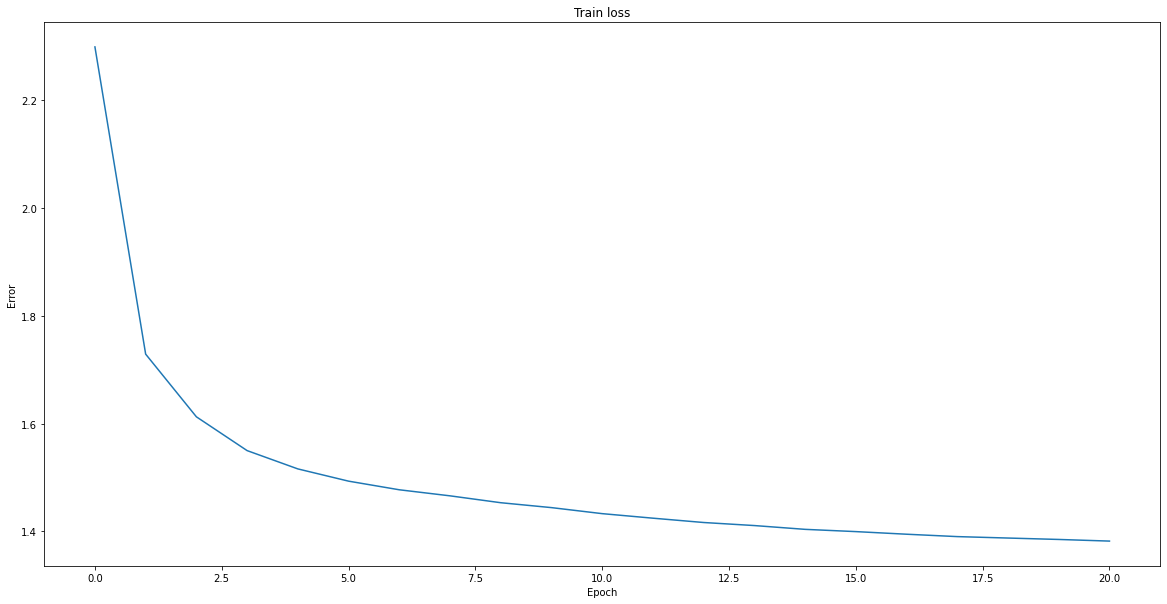

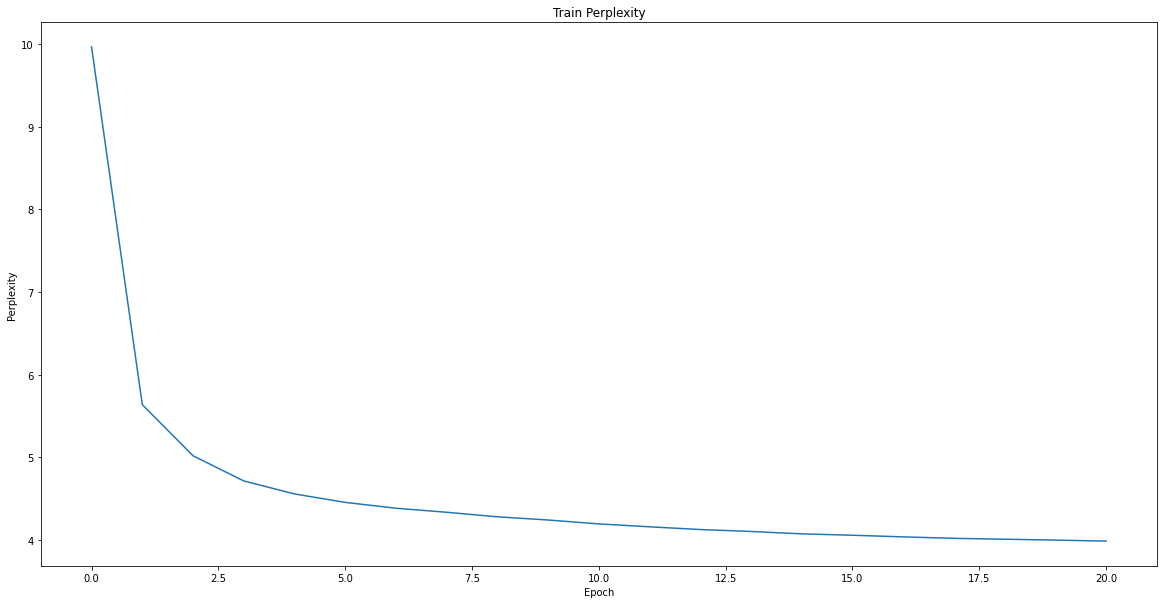

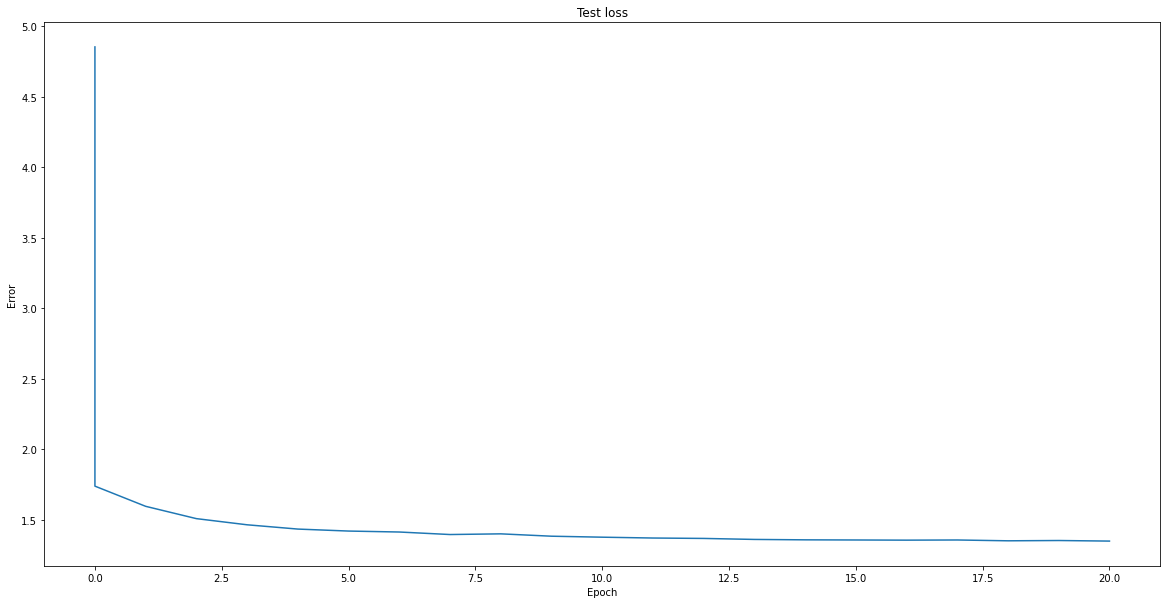

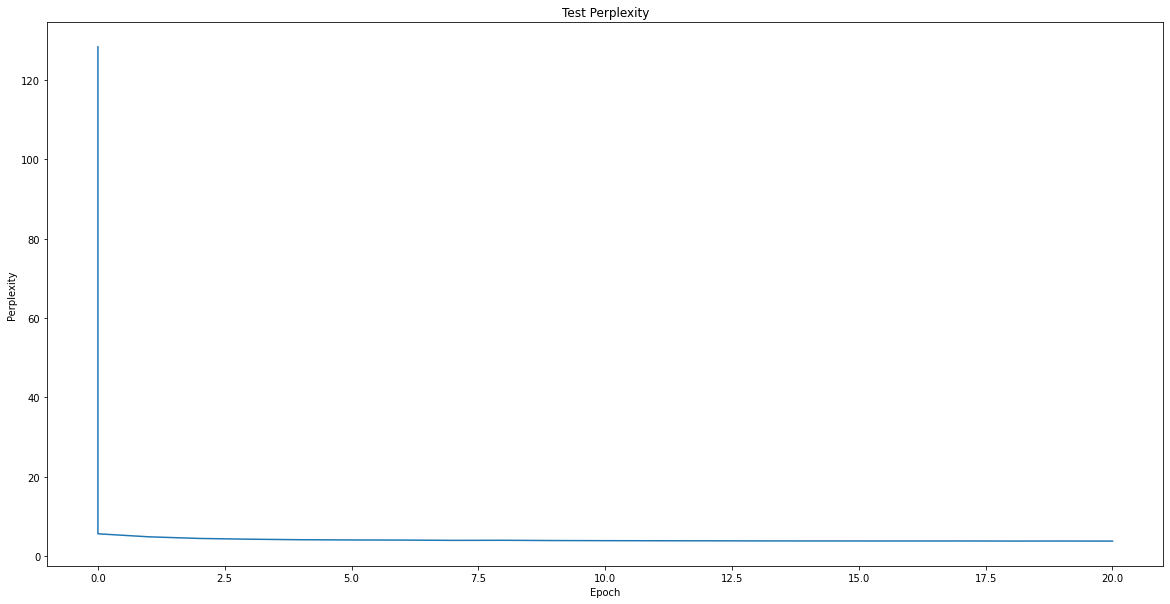

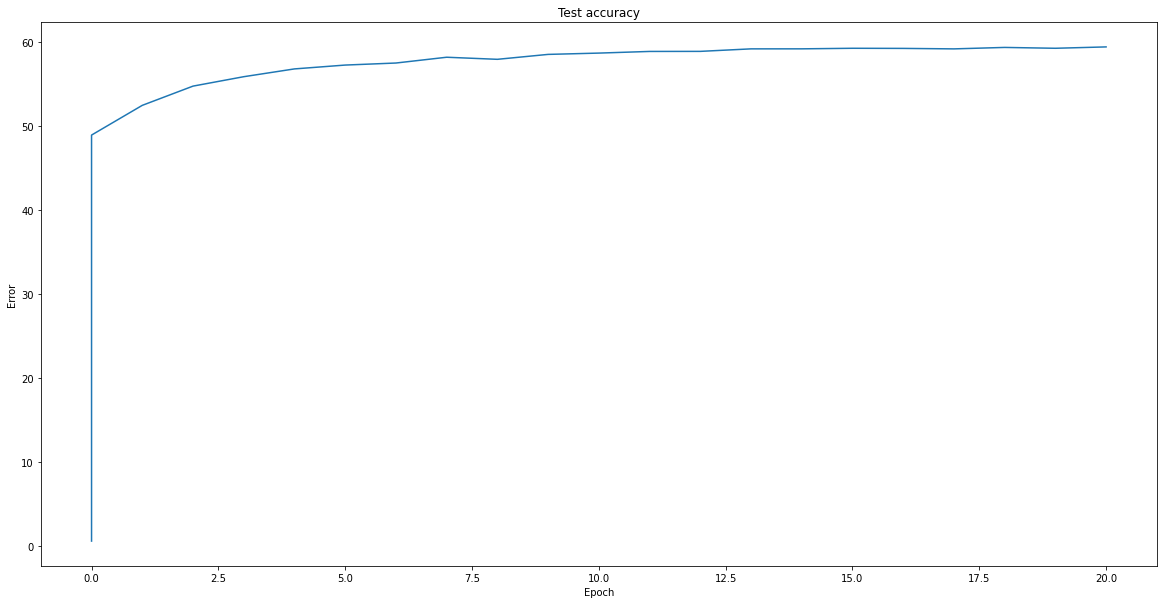

Final Test accuracy= 59.38568239795919
Final Test perplexity= 3.8524294980931275


In [ ]:
# -------- VTHOMA -------------
# -------- TYRING LSTM -----------
def mainLSTM():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs_LSTM/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNetLSTM(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_LSTM')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_LSTM/%03d.pt' % epoch)


            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '

       
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max', device)
       
            print('generated max\t\t', generated_sentence)

            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_LSTM/%03d.pt' % epoch, 0)
        ep, train_val = zip(*train_losses)
        pt_util.plot(ep, train_val, 'Train loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(train_val), 'Train Perplexity', 'Epoch', 'Perplexity')

        ep, test_val = zip(*test_losses)
        pt_util.plot(ep, test_val, 'Test loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(test_val), 'Test Perplexity', 'Epoch', 'Perplexity')

        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        print("Final Test accuracy=", val[-1])
        print("Final Test perplexity=", np.exp(test_val[-1]))
        return model, vocab, device

final_model_LSTM, vocab, device = mainLSTM()

In [ ]:
# ------ VTHOMA --------
# ------- TRYING LSTM --------

eval_final_model(final_model_LSTM, vocab, device)

in sampling strategy max-----------------------
out of for loop
[4, 15, 7, 1, 9, 10, 38, 9, 44, 4, 15, 7, 1, 9, 10, 15, 4, 6, 35, 4, 7, 11, 8, 4, 35, 38, 2, 15, 7, 4, 7, 38, 36, 8, 4, 7, 6, 4, 7, 11, 8, 4, 35, 38, 2, 15, 7, 4, 7, 38, 36, 8, 4, 7, 6, 4, 7, 11, 8, 4, 35, 38, 2, 15, 7, 4, 7, 38, 36, 8, 4, 7, 11, 1, 7, 4, 11, 8, 4, 40, 1, 15, 4, 15, 7, 38, 33, 33, 4, 15, 7, 1, 9, 10, 38, 9, 44, 4, 1, 7, 4, 7, 11, 8, 4, 35, 38, 2, 15, 7, 4, 7, 38, 36, 8, 4, 7, 6, 4, 7, 11, 8, 4, 35, 38, 2, 15, 7, 4, 7, 38, 36, 8, 4, 7, 6, 4, 7, 11, 8, 4, 35, 38, 2, 15, 7, 4, 7, 38, 36, 8, 4, 7, 6, 4, 7, 11, 8, 4, 35, 38, 2, 15, 7, 4, 7, 38, 36, 8, 4, 7, 6, 4, 7, 11, 8, 4, 35, 38, 2, 15, 7, 4, 7, 38, 36, 8, 4, 7, 6, 4, 7, 11, 8, 4, 35, 38, 2, 15, 7]
generated with max	 Harry Potter and the standing stands of the first time to the first time to the first time that he was still standing at the first time to the first time to the first time to the first time to the first time to the first
generated with sample	

Using device cuda
num workers: 2
156
512
Embedding(156, 512)
LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5)
Linear(in_features=512, out_features=156, bias=True)
Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	333eÉ×2—×"222”””P×××üüÉÉ£Bªªªüü×ü×éª×PPJ£KK££Éee××××××e×22W×××××××j×îî””î22××üüü—33ªªâª×ªª×××××PP——×


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	´L;jj×±××;ÉÉ3Éyyy ×××î×jjjj×j×££ªú××ªªª×××××ü———??±±”××W×××××××××ü?L´L;jj×±××;ÉÉe j×××××××××üü×WW×j


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement befor

  0%|          | 0/310 [00:00<?, ?it/s]


Test set: Average loss: 5.4105, Accuracy: 11677/1996800 (1%)



  0%|          | 1/310 [00:00<01:35,  3.25it/s]

Train Epoch: 0 [0/79360 (0%)]	Loss: 5.526271


  4%|▎         | 11/310 [00:02<01:08,  4.37it/s]

Train Epoch: 0 [2560/79360 (3%)]	Loss: 3.346313


  7%|▋         | 21/310 [00:04<01:05,  4.43it/s]

Train Epoch: 0 [5120/79360 (6%)]	Loss: 2.693705


 10%|█         | 31/310 [00:07<01:04,  4.36it/s]

Train Epoch: 0 [7680/79360 (10%)]	Loss: 2.495181


 13%|█▎        | 41/310 [00:09<01:01,  4.40it/s]

Train Epoch: 0 [10240/79360 (13%)]	Loss: 2.364430


 16%|█▋        | 51/310 [00:11<00:59,  4.37it/s]

Train Epoch: 0 [12800/79360 (16%)]	Loss: 2.292819


 20%|█▉        | 61/310 [00:13<00:56,  4.39it/s]

Train Epoch: 0 [15360/79360 (19%)]	Loss: 2.221337


 23%|██▎       | 71/310 [00:16<00:54,  4.38it/s]

Train Epoch: 0 [17920/79360 (23%)]	Loss: 2.150259


 26%|██▌       | 81/310 [00:18<00:52,  4.36it/s]

Train Epoch: 0 [20480/79360 (26%)]	Loss: 2.116195


 29%|██▉       | 91/310 [00:20<00:50,  4.31it/s]

Train Epoch: 0 [23040/79360 (29%)]	Loss: 2.098946


 33%|███▎      | 101/310 [00:23<00:47,  4.37it/s]

Train Epoch: 0 [25600/79360 (32%)]	Loss: 2.076346


 36%|███▌      | 111/310 [00:25<00:46,  4.29it/s]

Train Epoch: 0 [28160/79360 (35%)]	Loss: 2.050054


 39%|███▉      | 121/310 [00:27<00:43,  4.33it/s]

Train Epoch: 0 [30720/79360 (39%)]	Loss: 2.043099


 42%|████▏     | 131/310 [00:30<00:41,  4.29it/s]

Train Epoch: 0 [33280/79360 (42%)]	Loss: 2.014822


 45%|████▌     | 141/310 [00:32<00:39,  4.32it/s]

Train Epoch: 0 [35840/79360 (45%)]	Loss: 1.983103


 49%|████▊     | 151/310 [00:34<00:36,  4.30it/s]

Train Epoch: 0 [38400/79360 (48%)]	Loss: 1.953371


 52%|█████▏    | 161/310 [00:36<00:34,  4.32it/s]

Train Epoch: 0 [40960/79360 (52%)]	Loss: 1.934186


 55%|█████▌    | 171/310 [00:39<00:32,  4.30it/s]

Train Epoch: 0 [43520/79360 (55%)]	Loss: 1.931904


 58%|█████▊    | 181/310 [00:41<00:30,  4.29it/s]

Train Epoch: 0 [46080/79360 (58%)]	Loss: 1.913558


 62%|██████▏   | 191/310 [00:43<00:27,  4.30it/s]

Train Epoch: 0 [48640/79360 (61%)]	Loss: 1.887755


 65%|██████▍   | 201/310 [00:46<00:25,  4.27it/s]

Train Epoch: 0 [51200/79360 (65%)]	Loss: 1.918442


 68%|██████▊   | 211/310 [00:48<00:23,  4.19it/s]

Train Epoch: 0 [53760/79360 (68%)]	Loss: 1.870631


 71%|███████▏  | 221/310 [00:51<00:20,  4.26it/s]

Train Epoch: 0 [56320/79360 (71%)]	Loss: 1.848116


 75%|███████▍  | 231/310 [00:53<00:18,  4.26it/s]

Train Epoch: 0 [58880/79360 (74%)]	Loss: 1.841301


 78%|███████▊  | 241/310 [00:55<00:16,  4.25it/s]

Train Epoch: 0 [61440/79360 (77%)]	Loss: 1.863928


 81%|████████  | 251/310 [00:58<00:14,  4.21it/s]

Train Epoch: 0 [64000/79360 (81%)]	Loss: 1.813455


 84%|████████▍ | 261/310 [01:00<00:11,  4.29it/s]

Train Epoch: 0 [66560/79360 (84%)]	Loss: 1.834595


 87%|████████▋ | 271/310 [01:02<00:09,  4.26it/s]

Train Epoch: 0 [69120/79360 (87%)]	Loss: 1.851463


 91%|█████████ | 281/310 [01:05<00:06,  4.27it/s]

Train Epoch: 0 [71680/79360 (90%)]	Loss: 1.808429


 94%|█████████▍| 291/310 [01:07<00:04,  4.32it/s]

Train Epoch: 0 [74240/79360 (94%)]	Loss: 1.779098


 97%|█████████▋| 301/310 [01:09<00:02,  4.31it/s]

Train Epoch: 0 [76800/79360 (97%)]	Loss: 1.779237


100%|██████████| 310/310 [01:11<00:00,  4.32it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 noh te sednd oe the shnei of thes snaea ent  aou won sfsenn onseaelt toom the srriin of tacrli oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	tir oortes  I  tndtn ividual sirkson sn the srrlisaoi enn on the snitir oortes ond tou sne sinktid i


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oarieooe siss of tou  oonltri on t vinionsoh the shrei of thes snaea ent oy ore ti n ywg ng  aone ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Poless, of the and the same of any one of the same of the oday propesion of the limeral sill and perision of their dears of the same of the beans of pronsiding of the mind will so consinct of the suppo



  0%|          | 1/310 [00:00<01:40,  3.06it/s]

Train Epoch: 1 [0/79360 (0%)]	Loss: 1.766555


  4%|▎         | 11/310 [00:02<01:09,  4.32it/s]

Train Epoch: 1 [2560/79360 (3%)]	Loss: 1.782233


  7%|▋         | 21/310 [00:04<01:06,  4.35it/s]

Train Epoch: 1 [5120/79360 (6%)]	Loss: 1.742736


 10%|█         | 31/310 [00:07<01:04,  4.33it/s]

Train Epoch: 1 [7680/79360 (10%)]	Loss: 1.764365


 13%|█▎        | 41/310 [00:09<01:02,  4.31it/s]

Train Epoch: 1 [10240/79360 (13%)]	Loss: 1.727981


 16%|█▋        | 51/310 [00:11<00:59,  4.33it/s]

Train Epoch: 1 [12800/79360 (16%)]	Loss: 1.750830


 20%|█▉        | 61/310 [00:14<00:57,  4.30it/s]

Train Epoch: 1 [15360/79360 (19%)]	Loss: 1.729771


 23%|██▎       | 71/310 [00:16<00:55,  4.31it/s]

Train Epoch: 1 [17920/79360 (23%)]	Loss: 1.680300


 26%|██▌       | 81/310 [00:18<00:53,  4.31it/s]

Train Epoch: 1 [20480/79360 (26%)]	Loss: 1.694801


 29%|██▉       | 91/310 [00:21<00:50,  4.33it/s]

Train Epoch: 1 [23040/79360 (29%)]	Loss: 1.702205


 33%|███▎      | 101/310 [00:23<00:48,  4.27it/s]

Train Epoch: 1 [25600/79360 (32%)]	Loss: 1.708067


 36%|███▌      | 111/310 [00:25<00:46,  4.26it/s]

Train Epoch: 1 [28160/79360 (35%)]	Loss: 1.716465


 39%|███▉      | 121/310 [00:28<00:43,  4.31it/s]

Train Epoch: 1 [30720/79360 (39%)]	Loss: 1.720808


 42%|████▏     | 131/310 [00:30<00:41,  4.29it/s]

Train Epoch: 1 [33280/79360 (42%)]	Loss: 1.695541


 45%|████▌     | 141/310 [00:32<00:39,  4.28it/s]

Train Epoch: 1 [35840/79360 (45%)]	Loss: 1.675682


 49%|████▊     | 151/310 [00:35<00:37,  4.28it/s]

Train Epoch: 1 [38400/79360 (48%)]	Loss: 1.677859


 52%|█████▏    | 161/310 [00:37<00:34,  4.28it/s]

Train Epoch: 1 [40960/79360 (52%)]	Loss: 1.665730


 55%|█████▌    | 171/310 [00:39<00:33,  4.19it/s]

Train Epoch: 1 [43520/79360 (55%)]	Loss: 1.691710


 58%|█████▊    | 181/310 [00:42<00:30,  4.23it/s]

Train Epoch: 1 [46080/79360 (58%)]	Loss: 1.683276


 62%|██████▏   | 191/310 [00:44<00:28,  4.24it/s]

Train Epoch: 1 [48640/79360 (61%)]	Loss: 1.659006


 65%|██████▍   | 201/310 [00:46<00:25,  4.21it/s]

Train Epoch: 1 [51200/79360 (65%)]	Loss: 1.686597


 68%|██████▊   | 211/310 [00:49<00:23,  4.25it/s]

Train Epoch: 1 [53760/79360 (68%)]	Loss: 1.649410


 71%|███████▏  | 221/310 [00:51<00:20,  4.25it/s]

Train Epoch: 1 [56320/79360 (71%)]	Loss: 1.638932


 75%|███████▍  | 231/310 [00:53<00:18,  4.29it/s]

Train Epoch: 1 [58880/79360 (74%)]	Loss: 1.636053


 78%|███████▊  | 241/310 [00:56<00:16,  4.29it/s]

Train Epoch: 1 [61440/79360 (77%)]	Loss: 1.683418


 81%|████████  | 251/310 [00:58<00:13,  4.29it/s]

Train Epoch: 1 [64000/79360 (81%)]	Loss: 1.632883


 84%|████████▍ | 261/310 [01:00<00:11,  4.26it/s]

Train Epoch: 1 [66560/79360 (84%)]	Loss: 1.669086


 87%|████████▋ | 271/310 [01:03<00:09,  4.31it/s]

Train Epoch: 1 [69120/79360 (87%)]	Loss: 1.671574


 91%|█████████ | 281/310 [01:05<00:06,  4.27it/s]

Train Epoch: 1 [71680/79360 (90%)]	Loss: 1.646182


 94%|█████████▍| 291/310 [01:07<00:04,  4.30it/s]

Train Epoch: 1 [74240/79360 (94%)]	Loss: 1.625735


 97%|█████████▋| 301/310 [01:10<00:02,  4.27it/s]

Train Epoch: 1 [76800/79360 (97%)]	Loss: 1.628909


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	  oh te setnd oe the shrms of thes snaee ent  aou woy bfsein tnseselc orom the srrien of txeile oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	te  oeates  In tn tn ividual sirkson an the srrlisaoe enn on the snete  oeates ond tou wne senklid a


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oankeihe sats of tou  sonltri on t vition oh the shrms of thes snaee ent oe ore ti n ywd ng  aonl ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. CHARE APLEL HATTE OF CACISS TO CAATE CILETES SONIF-SO-CEATES APNAE AOTE TO HARINE OF BATE OF THE ANDE SION, AND CARAR CHAALIN TO FORE OF FHELAET OF OF ANTE CHAATS OF FAREEP. CHALRATLE LATE ARR. SARLAT 



  0%|          | 1/310 [00:00<01:40,  3.07it/s]

Train Epoch: 2 [0/79360 (0%)]	Loss: 1.615133


  4%|▎         | 11/310 [00:02<01:09,  4.31it/s]

Train Epoch: 2 [2560/79360 (3%)]	Loss: 1.652067


  7%|▋         | 21/310 [00:04<01:06,  4.37it/s]

Train Epoch: 2 [5120/79360 (6%)]	Loss: 1.621382


 10%|█         | 31/310 [00:07<01:03,  4.36it/s]

Train Epoch: 2 [7680/79360 (10%)]	Loss: 1.637153


 13%|█▎        | 41/310 [00:09<01:02,  4.30it/s]

Train Epoch: 2 [10240/79360 (13%)]	Loss: 1.607360


 16%|█▋        | 51/310 [00:11<00:59,  4.38it/s]

Train Epoch: 2 [12800/79360 (16%)]	Loss: 1.646120


 20%|█▉        | 61/310 [00:14<00:57,  4.36it/s]

Train Epoch: 2 [15360/79360 (19%)]	Loss: 1.618807


 23%|██▎       | 71/310 [00:16<00:54,  4.37it/s]

Train Epoch: 2 [17920/79360 (23%)]	Loss: 1.582458


 26%|██▌       | 81/310 [00:18<00:53,  4.26it/s]

Train Epoch: 2 [20480/79360 (26%)]	Loss: 1.591357


 29%|██▉       | 91/310 [00:21<00:51,  4.25it/s]

Train Epoch: 2 [23040/79360 (29%)]	Loss: 1.590175


 33%|███▎      | 101/310 [00:23<00:48,  4.34it/s]

Train Epoch: 2 [25600/79360 (32%)]	Loss: 1.607363


 36%|███▌      | 111/310 [00:25<00:46,  4.26it/s]

Train Epoch: 2 [28160/79360 (35%)]	Loss: 1.610946


 39%|███▉      | 121/310 [00:27<00:44,  4.27it/s]

Train Epoch: 2 [30720/79360 (39%)]	Loss: 1.624790


 42%|████▏     | 131/310 [00:30<00:41,  4.30it/s]

Train Epoch: 2 [33280/79360 (42%)]	Loss: 1.609718


 45%|████▌     | 141/310 [00:32<00:39,  4.31it/s]

Train Epoch: 2 [35840/79360 (45%)]	Loss: 1.591058


 49%|████▊     | 151/310 [00:34<00:37,  4.29it/s]

Train Epoch: 2 [38400/79360 (48%)]	Loss: 1.594208


 52%|█████▏    | 161/310 [00:37<00:35,  4.25it/s]

Train Epoch: 2 [40960/79360 (52%)]	Loss: 1.588930


 55%|█████▌    | 171/310 [00:39<00:32,  4.23it/s]

Train Epoch: 2 [43520/79360 (55%)]	Loss: 1.602759


 58%|█████▊    | 181/310 [00:42<00:30,  4.22it/s]

Train Epoch: 2 [46080/79360 (58%)]	Loss: 1.596398


 62%|██████▏   | 191/310 [00:44<00:28,  4.24it/s]

Train Epoch: 2 [48640/79360 (61%)]	Loss: 1.609480


 65%|██████▍   | 201/310 [00:46<00:25,  4.22it/s]

Train Epoch: 2 [51200/79360 (65%)]	Loss: 1.627122


 68%|██████▊   | 211/310 [00:49<00:23,  4.22it/s]

Train Epoch: 2 [53760/79360 (68%)]	Loss: 1.581114


 71%|███████▏  | 221/310 [00:51<00:21,  4.23it/s]

Train Epoch: 2 [56320/79360 (71%)]	Loss: 1.572820


 75%|███████▍  | 231/310 [00:53<00:18,  4.30it/s]

Train Epoch: 2 [58880/79360 (74%)]	Loss: 1.575820


 78%|███████▊  | 241/310 [00:56<00:16,  4.20it/s]

Train Epoch: 2 [61440/79360 (77%)]	Loss: 1.612762


 81%|████████  | 251/310 [00:58<00:13,  4.34it/s]

Train Epoch: 2 [64000/79360 (81%)]	Loss: 1.570735


 84%|████████▍ | 261/310 [01:00<00:11,  4.33it/s]

Train Epoch: 2 [66560/79360 (84%)]	Loss: 1.608017


 87%|████████▋ | 271/310 [01:03<00:08,  4.35it/s]

Train Epoch: 2 [69120/79360 (87%)]	Loss: 1.614481


 91%|█████████ | 281/310 [01:05<00:06,  4.34it/s]

Train Epoch: 2 [71680/79360 (90%)]	Loss: 1.590626


 94%|█████████▍| 291/310 [01:07<00:04,  4.30it/s]

Train Epoch: 2 [74240/79360 (94%)]	Loss: 1.578028


 97%|█████████▋| 301/310 [01:10<00:02,  4.29it/s]

Train Epoch: 2 [76800/79360 (97%)]	Loss: 1.574678


100%|██████████| 310/310 [01:12<00:00,  4.31it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 noh te setnd te the swrms of thes snaee ents aou wuy bfsein tnsemelc toom the srrioniof txeire oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ter States, In tn ansividual sirksos an the srrlisaoimennson the sniter States,ond tou wne sookled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oarkeihe sets of tour solltri on t vitionsoh the shrms of thes snaee entsoe ore te n ywdsng  aona ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Morest, which are supposed to me, who was how this less so more to seems to be one with the surfaces of the poditions with the country of the tender of the period of the cases of the period of the same



  0%|          | 1/310 [00:00<01:40,  3.08it/s]

Train Epoch: 3 [0/79360 (0%)]	Loss: 1.561721


  4%|▎         | 11/310 [00:02<01:09,  4.32it/s]

Train Epoch: 3 [2560/79360 (3%)]	Loss: 1.591366


  7%|▋         | 21/310 [00:04<01:06,  4.37it/s]

Train Epoch: 3 [5120/79360 (6%)]	Loss: 1.551213


 10%|█         | 31/310 [00:07<01:04,  4.35it/s]

Train Epoch: 3 [7680/79360 (10%)]	Loss: 1.582973


 13%|█▎        | 41/310 [00:09<01:02,  4.33it/s]

Train Epoch: 3 [10240/79360 (13%)]	Loss: 1.558785


 16%|█▋        | 51/310 [00:11<00:59,  4.33it/s]

Train Epoch: 3 [12800/79360 (16%)]	Loss: 1.600120


 20%|█▉        | 61/310 [00:14<00:57,  4.35it/s]

Train Epoch: 3 [15360/79360 (19%)]	Loss: 1.574994


 23%|██▎       | 71/310 [00:16<00:55,  4.33it/s]

Train Epoch: 3 [17920/79360 (23%)]	Loss: 1.525142


 26%|██▌       | 81/310 [00:18<00:52,  4.32it/s]

Train Epoch: 3 [20480/79360 (26%)]	Loss: 1.538964


 29%|██▉       | 91/310 [00:21<00:50,  4.33it/s]

Train Epoch: 3 [23040/79360 (29%)]	Loss: 1.545777


 33%|███▎      | 101/310 [00:23<00:48,  4.31it/s]

Train Epoch: 3 [25600/79360 (32%)]	Loss: 1.569078


 36%|███▌      | 111/310 [00:25<00:46,  4.31it/s]

Train Epoch: 3 [28160/79360 (35%)]	Loss: 1.577854


 39%|███▉      | 121/310 [00:28<00:44,  4.28it/s]

Train Epoch: 3 [30720/79360 (39%)]	Loss: 1.590306


 42%|████▏     | 131/310 [00:30<00:42,  4.26it/s]

Train Epoch: 3 [33280/79360 (42%)]	Loss: 1.564930


 45%|████▌     | 141/310 [00:32<00:39,  4.26it/s]

Train Epoch: 3 [35840/79360 (45%)]	Loss: 1.544414


 49%|████▊     | 151/310 [00:35<00:37,  4.29it/s]

Train Epoch: 3 [38400/79360 (48%)]	Loss: 1.567638


 52%|█████▏    | 161/310 [00:37<00:35,  4.23it/s]

Train Epoch: 3 [40960/79360 (52%)]	Loss: 1.549876


 55%|█████▌    | 171/310 [00:39<00:32,  4.26it/s]

Train Epoch: 3 [43520/79360 (55%)]	Loss: 1.570567


 58%|█████▊    | 181/310 [00:42<00:30,  4.27it/s]

Train Epoch: 3 [46080/79360 (58%)]	Loss: 1.564765


 62%|██████▏   | 191/310 [00:44<00:28,  4.22it/s]

Train Epoch: 3 [48640/79360 (61%)]	Loss: 1.550901


 65%|██████▍   | 201/310 [00:46<00:25,  4.19it/s]

Train Epoch: 3 [51200/79360 (65%)]	Loss: 1.580361


 68%|██████▊   | 211/310 [00:49<00:23,  4.25it/s]

Train Epoch: 3 [53760/79360 (68%)]	Loss: 1.550429


 71%|███████▏  | 221/310 [00:51<00:20,  4.27it/s]

Train Epoch: 3 [56320/79360 (71%)]	Loss: 1.538102


 75%|███████▍  | 231/310 [00:53<00:18,  4.26it/s]

Train Epoch: 3 [58880/79360 (74%)]	Loss: 1.549021


 78%|███████▊  | 241/310 [00:56<00:15,  4.33it/s]

Train Epoch: 3 [61440/79360 (77%)]	Loss: 1.576148


 81%|████████  | 251/310 [00:58<00:13,  4.30it/s]

Train Epoch: 3 [64000/79360 (81%)]	Loss: 1.537367


 84%|████████▍ | 261/310 [01:00<00:11,  4.30it/s]

Train Epoch: 3 [66560/79360 (84%)]	Loss: 1.577893


 87%|████████▋ | 271/310 [01:03<00:09,  4.32it/s]

Train Epoch: 3 [69120/79360 (87%)]	Loss: 1.589076


 91%|█████████ | 281/310 [01:05<00:06,  4.30it/s]

Train Epoch: 3 [71680/79360 (90%)]	Loss: 1.553219


 94%|█████████▍| 291/310 [01:07<00:04,  4.32it/s]

Train Epoch: 3 [74240/79360 (94%)]	Loss: 1.530897


 97%|█████████▋| 301/310 [01:10<00:02,  4.34it/s]

Train Epoch: 3 [76800/79360 (97%)]	Loss: 1.573308


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	  oh te setnd ty the swrms of thes snaee ents aou way bfsainet seseld toom the sarionsof txeiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States  T  t  insividual sirksos tn the sarlis oimennson the snited States ond tourhne tinkled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oarkeihe sats of tour sonntry on t a tionsoo the shrms of thes snaee entsoe ore ti n ywdsng  aoni ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. More so more species on the surgrations of the animals and the part of the early species of the same species in the such as the rath of the some single of the appearance of the range of the plants of t



  0%|          | 1/310 [00:00<01:40,  3.07it/s]

Train Epoch: 4 [0/79360 (0%)]	Loss: 1.544997


  4%|▎         | 11/310 [00:02<01:09,  4.32it/s]

Train Epoch: 4 [2560/79360 (3%)]	Loss: 1.552686


  7%|▋         | 21/310 [00:04<01:06,  4.34it/s]

Train Epoch: 4 [5120/79360 (6%)]	Loss: 1.531131


 10%|█         | 31/310 [00:07<01:03,  4.36it/s]

Train Epoch: 4 [7680/79360 (10%)]	Loss: 1.555630


 13%|█▎        | 41/310 [00:09<01:01,  4.36it/s]

Train Epoch: 4 [10240/79360 (13%)]	Loss: 1.534558


 16%|█▋        | 51/310 [00:11<00:59,  4.32it/s]

Train Epoch: 4 [12800/79360 (16%)]	Loss: 1.562688


 20%|█▉        | 61/310 [00:14<00:57,  4.37it/s]

Train Epoch: 4 [15360/79360 (19%)]	Loss: 1.542415


 23%|██▎       | 71/310 [00:16<00:55,  4.34it/s]

Train Epoch: 4 [17920/79360 (23%)]	Loss: 1.505541


 26%|██▌       | 81/310 [00:18<00:52,  4.37it/s]

Train Epoch: 4 [20480/79360 (26%)]	Loss: 1.513849


 29%|██▉       | 91/310 [00:21<00:51,  4.29it/s]

Train Epoch: 4 [23040/79360 (29%)]	Loss: 1.521270


 33%|███▎      | 101/310 [00:23<00:48,  4.31it/s]

Train Epoch: 4 [25600/79360 (32%)]	Loss: 1.538916


 36%|███▌      | 111/310 [00:25<00:46,  4.31it/s]

Train Epoch: 4 [28160/79360 (35%)]	Loss: 1.548358


 39%|███▉      | 121/310 [00:28<00:44,  4.26it/s]

Train Epoch: 4 [30720/79360 (39%)]	Loss: 1.554005


 42%|████▏     | 131/310 [00:30<00:41,  4.28it/s]

Train Epoch: 4 [33280/79360 (42%)]	Loss: 1.538809


 45%|████▌     | 141/310 [00:32<00:39,  4.30it/s]

Train Epoch: 4 [35840/79360 (45%)]	Loss: 1.521820


 49%|████▊     | 151/310 [00:35<00:37,  4.24it/s]

Train Epoch: 4 [38400/79360 (48%)]	Loss: 1.535101


 52%|█████▏    | 161/310 [00:37<00:35,  4.22it/s]

Train Epoch: 4 [40960/79360 (52%)]	Loss: 1.520936


 55%|█████▌    | 171/310 [00:39<00:33,  4.20it/s]

Train Epoch: 4 [43520/79360 (55%)]	Loss: 1.544553


 58%|█████▊    | 181/310 [00:42<00:30,  4.23it/s]

Train Epoch: 4 [46080/79360 (58%)]	Loss: 1.536330


 62%|██████▏   | 191/310 [00:44<00:28,  4.23it/s]

Train Epoch: 4 [48640/79360 (61%)]	Loss: 1.529440


 65%|██████▍   | 201/310 [00:46<00:25,  4.25it/s]

Train Epoch: 4 [51200/79360 (65%)]	Loss: 1.566886


 68%|██████▊   | 211/310 [00:49<00:23,  4.24it/s]

Train Epoch: 4 [53760/79360 (68%)]	Loss: 1.528763


 71%|███████▏  | 221/310 [00:51<00:20,  4.27it/s]

Train Epoch: 4 [56320/79360 (71%)]	Loss: 1.515015


 75%|███████▍  | 231/310 [00:53<00:18,  4.28it/s]

Train Epoch: 4 [58880/79360 (74%)]	Loss: 1.511222


 78%|███████▊  | 241/310 [00:56<00:16,  4.26it/s]

Train Epoch: 4 [61440/79360 (77%)]	Loss: 1.556122


 81%|████████  | 251/310 [00:58<00:13,  4.28it/s]

Train Epoch: 4 [64000/79360 (81%)]	Loss: 1.515195


 84%|████████▍ | 261/310 [01:00<00:11,  4.34it/s]

Train Epoch: 4 [66560/79360 (84%)]	Loss: 1.552476


 87%|████████▋ | 271/310 [01:03<00:08,  4.34it/s]

Train Epoch: 4 [69120/79360 (87%)]	Loss: 1.563492


 91%|█████████ | 281/310 [01:05<00:06,  4.32it/s]

Train Epoch: 4 [71680/79360 (90%)]	Loss: 1.539551


 94%|█████████▍| 291/310 [01:07<00:04,  4.33it/s]

Train Epoch: 4 [74240/79360 (94%)]	Loss: 1.514954


 97%|█████████▋| 301/310 [01:10<00:02,  4.33it/s]

Train Epoch: 4 [76800/79360 (97%)]	Loss: 1.531316


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 noh te setnd ty the shrms of thes cneee ent  aou way bfsain t seseld toom the sarion of txeiri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, T  t  insividual sirksos tn the sarlis oimetn on the snited States ond tounhne tinkled a


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oarkeohe sats of tour sonntry on t mitionsoh the shrms of thes cneee ent oeiore timn ywd ng  aoni ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Man strange part of the same had been from being seent to the male, and other wings and remarks, had a considerable species in the trame of the seales of the weathers, and the male of the selection of 



  0%|          | 1/310 [00:00<01:39,  3.11it/s]

Train Epoch: 5 [0/79360 (0%)]	Loss: 1.515853


  4%|▎         | 11/310 [00:02<01:09,  4.31it/s]

Train Epoch: 5 [2560/79360 (3%)]	Loss: 1.535072


  7%|▋         | 21/310 [00:04<01:06,  4.36it/s]

Train Epoch: 5 [5120/79360 (6%)]	Loss: 1.511198


 10%|█         | 31/310 [00:07<01:04,  4.35it/s]

Train Epoch: 5 [7680/79360 (10%)]	Loss: 1.531406


 13%|█▎        | 41/310 [00:09<01:02,  4.32it/s]

Train Epoch: 5 [10240/79360 (13%)]	Loss: 1.511230


 16%|█▋        | 51/310 [00:11<00:59,  4.36it/s]

Train Epoch: 5 [12800/79360 (16%)]	Loss: 1.535680


 20%|█▉        | 61/310 [00:14<00:57,  4.30it/s]

Train Epoch: 5 [15360/79360 (19%)]	Loss: 1.519697


 23%|██▎       | 71/310 [00:16<00:54,  4.35it/s]

Train Epoch: 5 [17920/79360 (23%)]	Loss: 1.483091


 26%|██▌       | 81/310 [00:18<00:52,  4.33it/s]

Train Epoch: 5 [20480/79360 (26%)]	Loss: 1.495234


 29%|██▉       | 91/310 [00:21<00:50,  4.31it/s]

Train Epoch: 5 [23040/79360 (29%)]	Loss: 1.497024


 33%|███▎      | 101/310 [00:23<00:49,  4.26it/s]

Train Epoch: 5 [25600/79360 (32%)]	Loss: 1.506155


 36%|███▌      | 111/310 [00:25<00:46,  4.31it/s]

Train Epoch: 5 [28160/79360 (35%)]	Loss: 1.536730


 39%|███▉      | 121/310 [00:28<00:44,  4.26it/s]

Train Epoch: 5 [30720/79360 (39%)]	Loss: 1.540756


 42%|████▏     | 131/310 [00:30<00:42,  4.26it/s]

Train Epoch: 5 [33280/79360 (42%)]	Loss: 1.528004


 45%|████▌     | 141/310 [00:32<00:39,  4.24it/s]

Train Epoch: 5 [35840/79360 (45%)]	Loss: 1.495404


 49%|████▊     | 151/310 [00:35<00:37,  4.25it/s]

Train Epoch: 5 [38400/79360 (48%)]	Loss: 1.512130


 52%|█████▏    | 161/310 [00:37<00:35,  4.24it/s]

Train Epoch: 5 [40960/79360 (52%)]	Loss: 1.508126


 55%|█████▌    | 171/310 [00:39<00:33,  4.20it/s]

Train Epoch: 5 [43520/79360 (55%)]	Loss: 1.526192


 58%|█████▊    | 181/310 [00:42<00:30,  4.20it/s]

Train Epoch: 5 [46080/79360 (58%)]	Loss: 1.516959


 62%|██████▏   | 191/310 [00:44<00:28,  4.21it/s]

Train Epoch: 5 [48640/79360 (61%)]	Loss: 1.505399


 65%|██████▍   | 201/310 [00:46<00:25,  4.21it/s]

Train Epoch: 5 [51200/79360 (65%)]	Loss: 1.557368


 68%|██████▊   | 211/310 [00:49<00:23,  4.27it/s]

Train Epoch: 5 [53760/79360 (68%)]	Loss: 1.517637


 71%|███████▏  | 221/310 [00:51<00:20,  4.27it/s]

Train Epoch: 5 [56320/79360 (71%)]	Loss: 1.495003


 75%|███████▍  | 231/310 [00:53<00:18,  4.27it/s]

Train Epoch: 5 [58880/79360 (74%)]	Loss: 1.495585


 78%|███████▊  | 241/310 [00:56<00:15,  4.31it/s]

Train Epoch: 5 [61440/79360 (77%)]	Loss: 1.535423


 81%|████████  | 251/310 [00:58<00:13,  4.31it/s]

Train Epoch: 5 [64000/79360 (81%)]	Loss: 1.492968


 84%|████████▍ | 261/310 [01:00<00:11,  4.34it/s]

Train Epoch: 5 [66560/79360 (84%)]	Loss: 1.528583


 87%|████████▋ | 271/310 [01:03<00:09,  4.33it/s]

Train Epoch: 5 [69120/79360 (87%)]	Loss: 1.530221


 91%|█████████ | 281/310 [01:05<00:06,  4.35it/s]

Train Epoch: 5 [71680/79360 (90%)]	Loss: 1.509084


 94%|█████████▍| 291/310 [01:07<00:04,  4.33it/s]

Train Epoch: 5 [74240/79360 (94%)]	Loss: 1.516748


 97%|█████████▋| 301/310 [01:10<00:02,  4.35it/s]

Train Epoch: 5 [76800/79360 (97%)]	Loss: 1.515352


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 dth te setndety the serms of thes sneeement  aou way bfsain t semeld toom the sarion of txeeri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, T  a  intividual sirksws an the sarlis oimenn on the snited States,ond tounwne tiskled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oarkeihe sat  of tour conntry as t mitionsoh the serms of thes sneeement oeiore temn ywd ng  aony ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mere that it was the simple differences of the males of the case of the closely several so that the same species of the same of the base of the same general structure of the limit of the naturalist of 



  0%|          | 1/310 [00:00<01:37,  3.17it/s]

Train Epoch: 6 [0/79360 (0%)]	Loss: 1.496646


  4%|▎         | 11/310 [00:02<01:10,  4.26it/s]

Train Epoch: 6 [2560/79360 (3%)]	Loss: 1.524160


  7%|▋         | 21/310 [00:04<01:06,  4.36it/s]

Train Epoch: 6 [5120/79360 (6%)]	Loss: 1.489058


 10%|█         | 31/310 [00:07<01:03,  4.38it/s]

Train Epoch: 6 [7680/79360 (10%)]	Loss: 1.515324


 13%|█▎        | 41/310 [00:09<01:01,  4.38it/s]

Train Epoch: 6 [10240/79360 (13%)]	Loss: 1.487956


 16%|█▋        | 51/310 [00:11<00:59,  4.33it/s]

Train Epoch: 6 [12800/79360 (16%)]	Loss: 1.522416


 20%|█▉        | 61/310 [00:14<00:57,  4.30it/s]

Train Epoch: 6 [15360/79360 (19%)]	Loss: 1.500677


 23%|██▎       | 71/310 [00:16<00:55,  4.33it/s]

Train Epoch: 6 [17920/79360 (23%)]	Loss: 1.461622


 26%|██▌       | 81/310 [00:18<00:53,  4.31it/s]

Train Epoch: 6 [20480/79360 (26%)]	Loss: 1.480752


 29%|██▉       | 91/310 [00:21<00:50,  4.35it/s]

Train Epoch: 6 [23040/79360 (29%)]	Loss: 1.475739


 33%|███▎      | 101/310 [00:23<00:48,  4.31it/s]

Train Epoch: 6 [25600/79360 (32%)]	Loss: 1.492313


 36%|███▌      | 111/310 [00:25<00:46,  4.29it/s]

Train Epoch: 6 [28160/79360 (35%)]	Loss: 1.513972


 39%|███▉      | 121/310 [00:27<00:44,  4.27it/s]

Train Epoch: 6 [30720/79360 (39%)]	Loss: 1.520684


 42%|████▏     | 131/310 [00:30<00:41,  4.27it/s]

Train Epoch: 6 [33280/79360 (42%)]	Loss: 1.506788


 45%|████▌     | 141/310 [00:32<00:40,  4.22it/s]

Train Epoch: 6 [35840/79360 (45%)]	Loss: 1.489121


 49%|████▊     | 151/310 [00:34<00:36,  4.31it/s]

Train Epoch: 6 [38400/79360 (48%)]	Loss: 1.495831


 52%|█████▏    | 161/310 [00:37<00:35,  4.26it/s]

Train Epoch: 6 [40960/79360 (52%)]	Loss: 1.492485


 55%|█████▌    | 171/310 [00:39<00:32,  4.22it/s]

Train Epoch: 6 [43520/79360 (55%)]	Loss: 1.512967


 58%|█████▊    | 181/310 [00:42<00:30,  4.25it/s]

Train Epoch: 6 [46080/79360 (58%)]	Loss: 1.502714


 62%|██████▏   | 191/310 [00:44<00:28,  4.19it/s]

Train Epoch: 6 [48640/79360 (61%)]	Loss: 1.484843


 65%|██████▍   | 201/310 [00:46<00:25,  4.25it/s]

Train Epoch: 6 [51200/79360 (65%)]	Loss: 1.538620


 68%|██████▊   | 211/310 [00:49<00:23,  4.24it/s]

Train Epoch: 6 [53760/79360 (68%)]	Loss: 1.496161


 71%|███████▏  | 221/310 [00:51<00:20,  4.30it/s]

Train Epoch: 6 [56320/79360 (71%)]	Loss: 1.481671


 75%|███████▍  | 231/310 [00:53<00:18,  4.25it/s]

Train Epoch: 6 [58880/79360 (74%)]	Loss: 1.481840


 78%|███████▊  | 241/310 [00:56<00:16,  4.26it/s]

Train Epoch: 6 [61440/79360 (77%)]	Loss: 1.519903


 81%|████████  | 251/310 [00:58<00:13,  4.29it/s]

Train Epoch: 6 [64000/79360 (81%)]	Loss: 1.482923


 84%|████████▍ | 261/310 [01:00<00:11,  4.25it/s]

Train Epoch: 6 [66560/79360 (84%)]	Loss: 1.519878


 87%|████████▋ | 271/310 [01:03<00:08,  4.34it/s]

Train Epoch: 6 [69120/79360 (87%)]	Loss: 1.530325


 91%|█████████ | 281/310 [01:05<00:06,  4.31it/s]

Train Epoch: 6 [71680/79360 (90%)]	Loss: 1.499380


 94%|█████████▍| 291/310 [01:07<00:04,  4.32it/s]

Train Epoch: 6 [74240/79360 (94%)]	Loss: 1.477362


 97%|█████████▋| 301/310 [01:10<00:02,  4.33it/s]

Train Epoch: 6 [76800/79360 (97%)]	Loss: 1.486990


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te tetndety the srrms of thes sneeement  aou way bnsein t semeld toom the srrion of txeere oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, T  t  ansividual sirksos nn the srrlis oimetn on the snited States,ond Mounwre tiokled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaakethe sat  of tour lonntry os t mitionsoh the serms of thes sneeement oeiore temn ywdeng  aony ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. On the females of the season, which is one fact their some of the enere of the latter consection of the breeds of the regions of difference. I have been live me the female selection, and the sealoy was



  0%|          | 1/310 [00:00<01:38,  3.15it/s]

Train Epoch: 7 [0/79360 (0%)]	Loss: 1.480132


  4%|▎         | 11/310 [00:02<01:09,  4.31it/s]

Train Epoch: 7 [2560/79360 (3%)]	Loss: 1.511143


  7%|▋         | 21/310 [00:04<01:06,  4.36it/s]

Train Epoch: 7 [5120/79360 (6%)]	Loss: 1.478308


 10%|█         | 31/310 [00:07<01:03,  4.37it/s]

Train Epoch: 7 [7680/79360 (10%)]	Loss: 1.504205


 13%|█▎        | 41/310 [00:09<01:02,  4.34it/s]

Train Epoch: 7 [10240/79360 (13%)]	Loss: 1.476667


 16%|█▋        | 51/310 [00:11<01:00,  4.31it/s]

Train Epoch: 7 [12800/79360 (16%)]	Loss: 1.511750


 20%|█▉        | 61/310 [00:14<00:57,  4.35it/s]

Train Epoch: 7 [15360/79360 (19%)]	Loss: 1.487709


 23%|██▎       | 71/310 [00:16<00:55,  4.29it/s]

Train Epoch: 7 [17920/79360 (23%)]	Loss: 1.445097


 26%|██▌       | 81/310 [00:18<00:52,  4.33it/s]

Train Epoch: 7 [20480/79360 (26%)]	Loss: 1.468724


 29%|██▉       | 91/310 [00:21<00:50,  4.33it/s]

Train Epoch: 7 [23040/79360 (29%)]	Loss: 1.462350


 33%|███▎      | 101/310 [00:23<00:48,  4.32it/s]

Train Epoch: 7 [25600/79360 (32%)]	Loss: 1.476504


 36%|███▌      | 111/310 [00:25<00:46,  4.28it/s]

Train Epoch: 7 [28160/79360 (35%)]	Loss: 1.489249


 39%|███▉      | 121/310 [00:28<00:44,  4.27it/s]

Train Epoch: 7 [30720/79360 (39%)]	Loss: 1.504632


 42%|████▏     | 131/310 [00:30<00:42,  4.26it/s]

Train Epoch: 7 [33280/79360 (42%)]	Loss: 1.497912


 45%|████▌     | 141/310 [00:32<00:39,  4.28it/s]

Train Epoch: 7 [35840/79360 (45%)]	Loss: 1.470345


 49%|████▊     | 151/310 [00:35<00:37,  4.22it/s]

Train Epoch: 7 [38400/79360 (48%)]	Loss: 1.482263


 52%|█████▏    | 161/310 [00:37<00:35,  4.20it/s]

Train Epoch: 7 [40960/79360 (52%)]	Loss: 1.474972


 55%|█████▌    | 171/310 [00:39<00:32,  4.25it/s]

Train Epoch: 7 [43520/79360 (55%)]	Loss: 1.501653


 58%|█████▊    | 181/310 [00:42<00:30,  4.24it/s]

Train Epoch: 7 [46080/79360 (58%)]	Loss: 1.490980


 62%|██████▏   | 191/310 [00:44<00:28,  4.22it/s]

Train Epoch: 7 [48640/79360 (61%)]	Loss: 1.475051


 65%|██████▍   | 201/310 [00:46<00:26,  4.17it/s]

Train Epoch: 7 [51200/79360 (65%)]	Loss: 1.503995


 68%|██████▊   | 211/310 [00:49<00:23,  4.27it/s]

Train Epoch: 7 [53760/79360 (68%)]	Loss: 1.480290


 71%|███████▏  | 221/310 [00:51<00:21,  4.20it/s]

Train Epoch: 7 [56320/79360 (71%)]	Loss: 1.466123


 75%|███████▍  | 231/310 [00:53<00:18,  4.26it/s]

Train Epoch: 7 [58880/79360 (74%)]	Loss: 1.473449


 78%|███████▊  | 241/310 [00:56<00:15,  4.31it/s]

Train Epoch: 7 [61440/79360 (77%)]	Loss: 1.505584


 81%|████████  | 251/310 [00:58<00:13,  4.29it/s]

Train Epoch: 7 [64000/79360 (81%)]	Loss: 1.470687


 84%|████████▍ | 261/310 [01:00<00:11,  4.26it/s]

Train Epoch: 7 [66560/79360 (84%)]	Loss: 1.504584


 87%|████████▋ | 271/310 [01:03<00:09,  4.30it/s]

Train Epoch: 7 [69120/79360 (87%)]	Loss: 1.510337


 91%|█████████ | 281/310 [01:05<00:06,  4.33it/s]

Train Epoch: 7 [71680/79360 (90%)]	Loss: 1.488293


 94%|█████████▍| 291/310 [01:07<00:04,  4.31it/s]

Train Epoch: 7 [74240/79360 (94%)]	Loss: 1.466097


 97%|█████████▋| 301/310 [01:10<00:02,  4.34it/s]

Train Epoch: 7 [76800/79360 (97%)]	Loss: 1.482053


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te tedndety the swrms of thes cneeement  aou way bnsein t semeld toom the sarion of tateri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, T  t  ansividual sirksos an the sarlis oomenn on the snited States ond tou wse tiokled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskethe sats of tour aonntry as t mitionsoh the serms of thes cneeement oyiore tewn ywdeng  aony ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mr. And will have been so much the more strate of the animals and worms of the case of the same of the females, which has not compared with the same of the thickness of the admitated of their points of



  0%|          | 1/310 [00:00<01:40,  3.07it/s]

Train Epoch: 8 [0/79360 (0%)]	Loss: 1.469843


  4%|▎         | 11/310 [00:02<01:08,  4.33it/s]

Train Epoch: 8 [2560/79360 (3%)]	Loss: 1.491245


  7%|▋         | 21/310 [00:04<01:06,  4.33it/s]

Train Epoch: 8 [5120/79360 (6%)]	Loss: 1.463278


 10%|█         | 31/310 [00:07<01:03,  4.38it/s]

Train Epoch: 8 [7680/79360 (10%)]	Loss: 1.487616


 13%|█▎        | 41/310 [00:09<01:02,  4.33it/s]

Train Epoch: 8 [10240/79360 (13%)]	Loss: 1.457695


 16%|█▋        | 51/310 [00:11<00:59,  4.34it/s]

Train Epoch: 8 [12800/79360 (16%)]	Loss: 1.506428


 20%|█▉        | 61/310 [00:14<00:57,  4.31it/s]

Train Epoch: 8 [15360/79360 (19%)]	Loss: 1.483211


 23%|██▎       | 71/310 [00:16<00:55,  4.32it/s]

Train Epoch: 8 [17920/79360 (23%)]	Loss: 1.437593


 26%|██▌       | 81/310 [00:18<00:53,  4.30it/s]

Train Epoch: 8 [20480/79360 (26%)]	Loss: 1.451140


 29%|██▉       | 91/310 [00:21<00:50,  4.32it/s]

Train Epoch: 8 [23040/79360 (29%)]	Loss: 1.446372


 33%|███▎      | 101/310 [00:23<00:48,  4.31it/s]

Train Epoch: 8 [25600/79360 (32%)]	Loss: 1.472715


 36%|███▌      | 111/310 [00:25<00:45,  4.33it/s]

Train Epoch: 8 [28160/79360 (35%)]	Loss: 1.485953


 39%|███▉      | 121/310 [00:28<00:43,  4.30it/s]

Train Epoch: 8 [30720/79360 (39%)]	Loss: 1.492960


 42%|████▏     | 131/310 [00:30<00:41,  4.30it/s]

Train Epoch: 8 [33280/79360 (42%)]	Loss: 1.484429


 45%|████▌     | 141/310 [00:32<00:39,  4.29it/s]

Train Epoch: 8 [35840/79360 (45%)]	Loss: 1.456927


 49%|████▊     | 151/310 [00:35<00:37,  4.25it/s]

Train Epoch: 8 [38400/79360 (48%)]	Loss: 1.465428


 52%|█████▏    | 161/310 [00:37<00:34,  4.30it/s]

Train Epoch: 8 [40960/79360 (52%)]	Loss: 1.464987


 55%|█████▌    | 171/310 [00:39<00:32,  4.24it/s]

Train Epoch: 8 [43520/79360 (55%)]	Loss: 1.482913


 58%|█████▊    | 181/310 [00:42<00:30,  4.20it/s]

Train Epoch: 8 [46080/79360 (58%)]	Loss: 1.479769


 62%|██████▏   | 191/310 [00:44<00:28,  4.19it/s]

Train Epoch: 8 [48640/79360 (61%)]	Loss: 1.463716


 65%|██████▍   | 201/310 [00:46<00:25,  4.28it/s]

Train Epoch: 8 [51200/79360 (65%)]	Loss: 1.497820


 68%|██████▊   | 211/310 [00:49<00:23,  4.22it/s]

Train Epoch: 8 [53760/79360 (68%)]	Loss: 1.468400


 71%|███████▏  | 221/310 [00:51<00:20,  4.31it/s]

Train Epoch: 8 [56320/79360 (71%)]	Loss: 1.454093


 75%|███████▍  | 231/310 [00:53<00:18,  4.31it/s]

Train Epoch: 8 [58880/79360 (74%)]	Loss: 1.465508


 78%|███████▊  | 241/310 [00:56<00:16,  4.30it/s]

Train Epoch: 8 [61440/79360 (77%)]	Loss: 1.494151


 81%|████████  | 251/310 [00:58<00:13,  4.27it/s]

Train Epoch: 8 [64000/79360 (81%)]	Loss: 1.456154


 84%|████████▍ | 261/310 [01:00<00:11,  4.25it/s]

Train Epoch: 8 [66560/79360 (84%)]	Loss: 1.490765


 87%|████████▋ | 271/310 [01:03<00:09,  4.29it/s]

Train Epoch: 8 [69120/79360 (87%)]	Loss: 1.501413


 91%|█████████ | 281/310 [01:05<00:06,  4.30it/s]

Train Epoch: 8 [71680/79360 (90%)]	Loss: 1.475225


 94%|█████████▍| 291/310 [01:07<00:04,  4.35it/s]

Train Epoch: 8 [74240/79360 (94%)]	Loss: 1.457097


 97%|█████████▋| 301/310 [01:10<00:02,  4.30it/s]

Train Epoch: 8 [76800/79360 (97%)]	Loss: 1.465249


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te sednd ty the swrms of thes sneeement  aou way bnsain t semeld toom the sarion of tateri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, I  t yinsividual sirksos an the srrlis oimetn on the snited States,ond tou wre ninkled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskethe sats of tour oonntry as t mitionsoh the serms of thes sneeement oyiore tewn ywdeng  aony ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mr. Don, of the latter having been as no man which will seen the propertion of the wild animals, and the males of a fact produced in sight some of the same animals of the beak of the coloured and of th



  0%|          | 1/310 [00:00<01:39,  3.12it/s]

Train Epoch: 9 [0/79360 (0%)]	Loss: 1.455400


  4%|▎         | 11/310 [00:02<01:09,  4.28it/s]

Train Epoch: 9 [2560/79360 (3%)]	Loss: 1.486961


  7%|▋         | 21/310 [00:04<01:06,  4.34it/s]

Train Epoch: 9 [5120/79360 (6%)]	Loss: 1.453543


 10%|█         | 31/310 [00:07<01:03,  4.40it/s]

Train Epoch: 9 [7680/79360 (10%)]	Loss: 1.476566


 13%|█▎        | 41/310 [00:09<01:02,  4.33it/s]

Train Epoch: 9 [10240/79360 (13%)]	Loss: 1.448461


 16%|█▋        | 51/310 [00:11<00:59,  4.36it/s]

Train Epoch: 9 [12800/79360 (16%)]	Loss: 1.489012


 20%|█▉        | 61/310 [00:14<00:57,  4.32it/s]

Train Epoch: 9 [15360/79360 (19%)]	Loss: 1.471466


 23%|██▎       | 71/310 [00:16<00:55,  4.34it/s]

Train Epoch: 9 [17920/79360 (23%)]	Loss: 1.429353


 26%|██▌       | 81/310 [00:18<00:52,  4.33it/s]

Train Epoch: 9 [20480/79360 (26%)]	Loss: 1.443367


 29%|██▉       | 91/310 [00:21<00:50,  4.31it/s]

Train Epoch: 9 [23040/79360 (29%)]	Loss: 1.443822


 33%|███▎      | 101/310 [00:23<00:48,  4.33it/s]

Train Epoch: 9 [25600/79360 (32%)]	Loss: 1.464954


 36%|███▌      | 111/310 [00:25<00:46,  4.27it/s]

Train Epoch: 9 [28160/79360 (35%)]	Loss: 1.478353


 39%|███▉      | 121/310 [00:28<00:44,  4.26it/s]

Train Epoch: 9 [30720/79360 (39%)]	Loss: 1.487001


 42%|████▏     | 131/310 [00:30<00:41,  4.28it/s]

Train Epoch: 9 [33280/79360 (42%)]	Loss: 1.476142


 45%|████▌     | 141/310 [00:32<00:39,  4.23it/s]

Train Epoch: 9 [35840/79360 (45%)]	Loss: 1.449401


 49%|████▊     | 151/310 [00:35<00:37,  4.23it/s]

Train Epoch: 9 [38400/79360 (48%)]	Loss: 1.458778


 52%|█████▏    | 161/310 [00:37<00:35,  4.25it/s]

Train Epoch: 9 [40960/79360 (52%)]	Loss: 1.458892


 55%|█████▌    | 171/310 [00:39<00:32,  4.23it/s]

Train Epoch: 9 [43520/79360 (55%)]	Loss: 1.482841


 58%|█████▊    | 181/310 [00:42<00:30,  4.19it/s]

Train Epoch: 9 [46080/79360 (58%)]	Loss: 1.473285


 62%|██████▏   | 191/310 [00:44<00:28,  4.22it/s]

Train Epoch: 9 [48640/79360 (61%)]	Loss: 1.446295


 65%|██████▍   | 201/310 [00:46<00:25,  4.26it/s]

Train Epoch: 9 [51200/79360 (65%)]	Loss: 1.512620


 68%|██████▊   | 211/310 [00:49<00:23,  4.24it/s]

Train Epoch: 9 [53760/79360 (68%)]	Loss: 1.463007


 71%|███████▏  | 221/310 [00:51<00:20,  4.28it/s]

Train Epoch: 9 [56320/79360 (71%)]	Loss: 1.448612


 75%|███████▍  | 231/310 [00:53<00:18,  4.24it/s]

Train Epoch: 9 [58880/79360 (74%)]	Loss: 1.451041


 78%|███████▊  | 241/310 [00:56<00:16,  4.29it/s]

Train Epoch: 9 [61440/79360 (77%)]	Loss: 1.485624


 81%|████████  | 251/310 [00:58<00:13,  4.31it/s]

Train Epoch: 9 [64000/79360 (81%)]	Loss: 1.450884


 84%|████████▍ | 261/310 [01:00<00:11,  4.31it/s]

Train Epoch: 9 [66560/79360 (84%)]	Loss: 1.482815


 87%|████████▋ | 271/310 [01:03<00:08,  4.38it/s]

Train Epoch: 9 [69120/79360 (87%)]	Loss: 1.484056


 91%|█████████ | 281/310 [01:05<00:06,  4.35it/s]

Train Epoch: 9 [71680/79360 (90%)]	Loss: 1.467981


 94%|█████████▍| 291/310 [01:07<00:04,  4.34it/s]

Train Epoch: 9 [74240/79360 (94%)]	Loss: 1.446743


 97%|█████████▋| 301/310 [01:10<00:02,  4.32it/s]

Train Epoch: 9 [76800/79360 (97%)]	Loss: 1.458156


100%|██████████| 310/310 [01:11<00:00,  4.31it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te sednd ty the srrms of thes sneeement  aou way bnsain t semeld toom the srrion of txtiri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, T  t yinsividual sirksos an the srrlis oimetn on the snited States ond tounwne tiokled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaakethe sats of tour lonntry as t mitionsoo the serms of thes sneeement oeiore tewn ywdeng  aony ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mr. And Read Indian structure of the large stripitarity of the males are the remarkable transmitted by the same offare the necessary of the bard of males sefection. I have not considered from the males



  0%|          | 1/310 [00:00<01:39,  3.12it/s]

Train Epoch: 10 [0/79360 (0%)]	Loss: 1.449031


  4%|▎         | 11/310 [00:02<01:09,  4.32it/s]

Train Epoch: 10 [2560/79360 (3%)]	Loss: 1.479293


  7%|▋         | 21/310 [00:04<01:06,  4.33it/s]

Train Epoch: 10 [5120/79360 (6%)]	Loss: 1.440209


 10%|█         | 31/310 [00:07<01:03,  4.37it/s]

Train Epoch: 10 [7680/79360 (10%)]	Loss: 1.465223


 13%|█▎        | 41/310 [00:09<01:01,  4.35it/s]

Train Epoch: 10 [10240/79360 (13%)]	Loss: 1.446730


 16%|█▋        | 51/310 [00:11<00:59,  4.36it/s]

Train Epoch: 10 [12800/79360 (16%)]	Loss: 1.480741


 20%|█▉        | 61/310 [00:14<00:57,  4.34it/s]

Train Epoch: 10 [15360/79360 (19%)]	Loss: 1.461437


 23%|██▎       | 71/310 [00:16<00:55,  4.32it/s]

Train Epoch: 10 [17920/79360 (23%)]	Loss: 1.422324


 26%|██▌       | 81/310 [00:18<00:53,  4.26it/s]

Train Epoch: 10 [20480/79360 (26%)]	Loss: 1.438792


 29%|██▉       | 91/310 [00:21<00:51,  4.28it/s]

Train Epoch: 10 [23040/79360 (29%)]	Loss: 1.432289


 33%|███▎      | 101/310 [00:23<00:48,  4.33it/s]

Train Epoch: 10 [25600/79360 (32%)]	Loss: 1.451618


 36%|███▌      | 111/310 [00:25<00:46,  4.25it/s]

Train Epoch: 10 [28160/79360 (35%)]	Loss: 1.467630


 39%|███▉      | 121/310 [00:28<00:44,  4.28it/s]

Train Epoch: 10 [30720/79360 (39%)]	Loss: 1.478523


 42%|████▏     | 131/310 [00:30<00:42,  4.20it/s]

Train Epoch: 10 [33280/79360 (42%)]	Loss: 1.465925


 45%|████▌     | 141/310 [00:32<00:39,  4.28it/s]

Train Epoch: 10 [35840/79360 (45%)]	Loss: 1.436746


 49%|████▊     | 151/310 [00:35<00:37,  4.22it/s]

Train Epoch: 10 [38400/79360 (48%)]	Loss: 1.451946


 52%|█████▏    | 161/310 [00:37<00:35,  4.23it/s]

Train Epoch: 10 [40960/79360 (52%)]	Loss: 1.448317


 55%|█████▌    | 171/310 [00:39<00:32,  4.28it/s]

Train Epoch: 10 [43520/79360 (55%)]	Loss: 1.473996


 58%|█████▊    | 181/310 [00:42<00:30,  4.25it/s]

Train Epoch: 10 [46080/79360 (58%)]	Loss: 1.463512


 62%|██████▏   | 191/310 [00:44<00:28,  4.24it/s]

Train Epoch: 10 [48640/79360 (61%)]	Loss: 1.448710


 65%|██████▍   | 201/310 [00:46<00:25,  4.25it/s]

Train Epoch: 10 [51200/79360 (65%)]	Loss: 1.478267


 68%|██████▊   | 211/310 [00:49<00:23,  4.17it/s]

Train Epoch: 10 [53760/79360 (68%)]	Loss: 1.454298


 71%|███████▏  | 221/310 [00:51<00:21,  4.21it/s]

Train Epoch: 10 [56320/79360 (71%)]	Loss: 1.445293


 75%|███████▍  | 231/310 [00:53<00:18,  4.31it/s]

Train Epoch: 10 [58880/79360 (74%)]	Loss: 1.447144


 78%|███████▊  | 241/310 [00:56<00:16,  4.29it/s]

Train Epoch: 10 [61440/79360 (77%)]	Loss: 1.477227


 81%|████████  | 251/310 [00:58<00:13,  4.29it/s]

Train Epoch: 10 [64000/79360 (81%)]	Loss: 1.443512


 84%|████████▍ | 261/310 [01:00<00:11,  4.34it/s]

Train Epoch: 10 [66560/79360 (84%)]	Loss: 1.477520


 87%|████████▋ | 271/310 [01:03<00:09,  4.30it/s]

Train Epoch: 10 [69120/79360 (87%)]	Loss: 1.486380


 91%|█████████ | 281/310 [01:05<00:06,  4.34it/s]

Train Epoch: 10 [71680/79360 (90%)]	Loss: 1.462445


 94%|█████████▍| 291/310 [01:07<00:04,  4.35it/s]

Train Epoch: 10 [74240/79360 (94%)]	Loss: 1.443994


 97%|█████████▋| 301/310 [01:10<00:02,  4.34it/s]

Train Epoch: 10 [76800/79360 (97%)]	Loss: 1.453968


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te sednd ty the srrms of thes sneeement  aou way bnsain t semeld trom the srrion of sxtiri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, I  t yansividual sarksos an the srrlis oimetn os the snited States ond Mou wre niokled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskethe sats of tour sonntry as t mitionsth the serms of thes sneeement oeiore tiwn ywdeng  aonysng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mr. Halled short about the complete of the season, the states of the males have been sub-breed, as it is sometimes that the adult of the females being before from a lime and the sexes of the species ar



  0%|          | 1/310 [00:00<01:39,  3.11it/s]

Train Epoch: 11 [0/79360 (0%)]	Loss: 1.442433


  4%|▎         | 11/310 [00:02<01:09,  4.31it/s]

Train Epoch: 11 [2560/79360 (3%)]	Loss: 1.470389


  7%|▋         | 21/310 [00:04<01:06,  4.36it/s]

Train Epoch: 11 [5120/79360 (6%)]	Loss: 1.433428


 10%|█         | 31/310 [00:07<01:04,  4.36it/s]

Train Epoch: 11 [7680/79360 (10%)]	Loss: 1.460015


 13%|█▎        | 41/310 [00:09<01:02,  4.33it/s]

Train Epoch: 11 [10240/79360 (13%)]	Loss: 1.436505


 16%|█▋        | 51/310 [00:11<00:59,  4.37it/s]

Train Epoch: 11 [12800/79360 (16%)]	Loss: 1.473436


 20%|█▉        | 61/310 [00:14<00:57,  4.31it/s]

Train Epoch: 11 [15360/79360 (19%)]	Loss: 1.457829


 23%|██▎       | 71/310 [00:16<00:56,  4.25it/s]

Train Epoch: 11 [17920/79360 (23%)]	Loss: 1.410876


 26%|██▌       | 81/310 [00:18<00:52,  4.33it/s]

Train Epoch: 11 [20480/79360 (26%)]	Loss: 1.427563


 29%|██▉       | 91/310 [00:21<00:51,  4.28it/s]

Train Epoch: 11 [23040/79360 (29%)]	Loss: 1.425241


 33%|███▎      | 101/310 [00:23<00:48,  4.32it/s]

Train Epoch: 11 [25600/79360 (32%)]	Loss: 1.448732


 36%|███▌      | 111/310 [00:25<00:46,  4.27it/s]

Train Epoch: 11 [28160/79360 (35%)]	Loss: 1.458908


 39%|███▉      | 121/310 [00:28<00:44,  4.26it/s]

Train Epoch: 11 [30720/79360 (39%)]	Loss: 1.469807


 42%|████▏     | 131/310 [00:30<00:41,  4.27it/s]

Train Epoch: 11 [33280/79360 (42%)]	Loss: 1.462494


 45%|████▌     | 141/310 [00:32<00:39,  4.25it/s]

Train Epoch: 11 [35840/79360 (45%)]	Loss: 1.428300


 49%|████▊     | 151/310 [00:35<00:37,  4.28it/s]

Train Epoch: 11 [38400/79360 (48%)]	Loss: 1.449210


 52%|█████▏    | 161/310 [00:37<00:35,  4.25it/s]

Train Epoch: 11 [40960/79360 (52%)]	Loss: 1.444473


 55%|█████▌    | 171/310 [00:39<00:32,  4.25it/s]

Train Epoch: 11 [43520/79360 (55%)]	Loss: 1.465408


 58%|█████▊    | 181/310 [00:42<00:30,  4.28it/s]

Train Epoch: 11 [46080/79360 (58%)]	Loss: 1.457688


 62%|██████▏   | 191/310 [00:44<00:28,  4.17it/s]

Train Epoch: 11 [48640/79360 (61%)]	Loss: 1.440252


 65%|██████▍   | 201/310 [00:46<00:25,  4.25it/s]

Train Epoch: 11 [51200/79360 (65%)]	Loss: 1.474063


 68%|██████▊   | 211/310 [00:49<00:23,  4.23it/s]

Train Epoch: 11 [53760/79360 (68%)]	Loss: 1.452329


 71%|███████▏  | 221/310 [00:51<00:21,  4.13it/s]

Train Epoch: 11 [56320/79360 (71%)]	Loss: 1.437986


 75%|███████▍  | 231/310 [00:53<00:18,  4.29it/s]

Train Epoch: 11 [58880/79360 (74%)]	Loss: 1.439283


 78%|███████▊  | 241/310 [00:56<00:16,  4.29it/s]

Train Epoch: 11 [61440/79360 (77%)]	Loss: 1.472448


 81%|████████  | 251/310 [00:58<00:13,  4.31it/s]

Train Epoch: 11 [64000/79360 (81%)]	Loss: 1.438117


 84%|████████▍ | 261/310 [01:00<00:11,  4.33it/s]

Train Epoch: 11 [66560/79360 (84%)]	Loss: 1.471021


 87%|████████▋ | 271/310 [01:03<00:09,  4.31it/s]

Train Epoch: 11 [69120/79360 (87%)]	Loss: 1.472687


 91%|█████████ | 281/310 [01:05<00:06,  4.35it/s]

Train Epoch: 11 [71680/79360 (90%)]	Loss: 1.457894


 94%|█████████▍| 291/310 [01:07<00:04,  4.33it/s]

Train Epoch: 11 [74240/79360 (94%)]	Loss: 1.439057


 97%|█████████▋| 301/310 [01:10<00:02,  4.31it/s]

Train Epoch: 11 [76800/79360 (97%)]	Loss: 1.447858


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te sednd ty the srrms of thes sneeement  aou way bfsain t semesd trom the srrion of sxtiri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, I  t yan ividual sorksos an the srrlis oometn os the snited States ond tou wre niokled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oasksihe sat  of tour lonntry ws t mitionsto the srrms of thes sneeement oe ore ti n ywdeng  aony ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mr. Magidle, how sometimes a very strong other continued to the species of the back, and in the living and change of the same quarter-some of the same cases of the same species, the soil of the beak at



  0%|          | 1/310 [00:00<01:39,  3.10it/s]

Train Epoch: 12 [0/79360 (0%)]	Loss: 1.436759


  4%|▎         | 11/310 [00:02<01:09,  4.30it/s]

Train Epoch: 12 [2560/79360 (3%)]	Loss: 1.461578


  7%|▋         | 21/310 [00:04<01:06,  4.33it/s]

Train Epoch: 12 [5120/79360 (6%)]	Loss: 1.431979


 10%|█         | 31/310 [00:07<01:03,  4.38it/s]

Train Epoch: 12 [7680/79360 (10%)]	Loss: 1.454068


 13%|█▎        | 41/310 [00:09<01:01,  4.36it/s]

Train Epoch: 12 [10240/79360 (13%)]	Loss: 1.433213


 16%|█▋        | 51/310 [00:11<00:59,  4.32it/s]

Train Epoch: 12 [12800/79360 (16%)]	Loss: 1.465705


 20%|█▉        | 61/310 [00:14<00:57,  4.33it/s]

Train Epoch: 12 [15360/79360 (19%)]	Loss: 1.449338


 23%|██▎       | 71/310 [00:16<00:55,  4.30it/s]

Train Epoch: 12 [17920/79360 (23%)]	Loss: 1.412422


 26%|██▌       | 81/310 [00:18<00:53,  4.31it/s]

Train Epoch: 12 [20480/79360 (26%)]	Loss: 1.426990


 29%|██▉       | 91/310 [00:21<00:51,  4.29it/s]

Train Epoch: 12 [23040/79360 (29%)]	Loss: 1.425103


 33%|███▎      | 101/310 [00:23<00:48,  4.29it/s]

Train Epoch: 12 [25600/79360 (32%)]	Loss: 1.445509


 36%|███▌      | 111/310 [00:25<00:46,  4.30it/s]

Train Epoch: 12 [28160/79360 (35%)]	Loss: 1.451122


 39%|███▉      | 121/310 [00:28<00:44,  4.26it/s]

Train Epoch: 12 [30720/79360 (39%)]	Loss: 1.470418


 42%|████▏     | 131/310 [00:30<00:41,  4.27it/s]

Train Epoch: 12 [33280/79360 (42%)]	Loss: 1.459986


 45%|████▌     | 141/310 [00:32<00:39,  4.27it/s]

Train Epoch: 12 [35840/79360 (45%)]	Loss: 1.427352


 49%|████▊     | 151/310 [00:35<00:37,  4.22it/s]

Train Epoch: 12 [38400/79360 (48%)]	Loss: 1.443768


 52%|█████▏    | 161/310 [00:37<00:34,  4.26it/s]

Train Epoch: 12 [40960/79360 (52%)]	Loss: 1.438093


 55%|█████▌    | 171/310 [00:39<00:32,  4.23it/s]

Train Epoch: 12 [43520/79360 (55%)]	Loss: 1.462658


 58%|█████▊    | 181/310 [00:42<00:30,  4.20it/s]

Train Epoch: 12 [46080/79360 (58%)]	Loss: 1.455658


 62%|██████▏   | 191/310 [00:44<00:27,  4.26it/s]

Train Epoch: 12 [48640/79360 (61%)]	Loss: 1.435752


 65%|██████▍   | 201/310 [00:46<00:25,  4.24it/s]

Train Epoch: 12 [51200/79360 (65%)]	Loss: 1.460521


 68%|██████▊   | 211/310 [00:49<00:23,  4.25it/s]

Train Epoch: 12 [53760/79360 (68%)]	Loss: 1.445572


 71%|███████▏  | 221/310 [00:51<00:21,  4.21it/s]

Train Epoch: 12 [56320/79360 (71%)]	Loss: 1.435511


 75%|███████▍  | 231/310 [00:54<00:18,  4.26it/s]

Train Epoch: 12 [58880/79360 (74%)]	Loss: 1.435892


 78%|███████▊  | 241/310 [00:56<00:16,  4.29it/s]

Train Epoch: 12 [61440/79360 (77%)]	Loss: 1.468874


 81%|████████  | 251/310 [00:58<00:13,  4.28it/s]

Train Epoch: 12 [64000/79360 (81%)]	Loss: 1.440912


 84%|████████▍ | 261/310 [01:00<00:11,  4.33it/s]

Train Epoch: 12 [66560/79360 (84%)]	Loss: 1.465661


 87%|████████▋ | 271/310 [01:03<00:09,  4.31it/s]

Train Epoch: 12 [69120/79360 (87%)]	Loss: 1.470545


 91%|█████████ | 281/310 [01:05<00:06,  4.29it/s]

Train Epoch: 12 [71680/79360 (90%)]	Loss: 1.450794


 94%|█████████▍| 291/310 [01:07<00:04,  4.34it/s]

Train Epoch: 12 [74240/79360 (94%)]	Loss: 1.432485


 97%|█████████▋| 301/310 [01:10<00:02,  4.32it/s]

Train Epoch: 12 [76800/79360 (97%)]	Loss: 1.441609


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te srdnd ty the srrms of thes sneeement  aou way bfsain t semesd trom the srrion of sxtiri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, I  t yansividual sark os an the srrlic oometn os the snited States ond tou wre niokled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskeihe sat  of tour lonntry ws t mitionsto the srrms of thes sneeement oe ore tiwn ywdeng  aonysng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Chall so many seeds all breeds of a slight season, and the female rather has been some sea--effects in the increase of the several cases of life in the same side, which I have such as the elife of spec



  0%|          | 1/310 [00:00<01:41,  3.03it/s]

Train Epoch: 13 [0/79360 (0%)]	Loss: 1.432065


  4%|▎         | 11/310 [00:02<01:09,  4.30it/s]

Train Epoch: 13 [2560/79360 (3%)]	Loss: 1.458626


  7%|▋         | 21/310 [00:04<01:06,  4.37it/s]

Train Epoch: 13 [5120/79360 (6%)]	Loss: 1.425710


 10%|█         | 31/310 [00:07<01:03,  4.36it/s]

Train Epoch: 13 [7680/79360 (10%)]	Loss: 1.452767


 13%|█▎        | 41/310 [00:09<01:01,  4.37it/s]

Train Epoch: 13 [10240/79360 (13%)]	Loss: 1.427103


 16%|█▋        | 51/310 [00:11<01:00,  4.31it/s]

Train Epoch: 13 [12800/79360 (16%)]	Loss: 1.461550


 20%|█▉        | 61/310 [00:14<00:57,  4.36it/s]

Train Epoch: 13 [15360/79360 (19%)]	Loss: 1.445419


 23%|██▎       | 71/310 [00:16<00:55,  4.33it/s]

Train Epoch: 13 [17920/79360 (23%)]	Loss: 1.404234


 26%|██▌       | 81/310 [00:18<00:53,  4.32it/s]

Train Epoch: 13 [20480/79360 (26%)]	Loss: 1.420430


 29%|██▉       | 91/310 [00:21<00:50,  4.31it/s]

Train Epoch: 13 [23040/79360 (29%)]	Loss: 1.423055


 33%|███▎      | 101/310 [00:23<00:49,  4.24it/s]

Train Epoch: 13 [25600/79360 (32%)]	Loss: 1.444841


 36%|███▌      | 111/310 [00:25<00:46,  4.29it/s]

Train Epoch: 13 [28160/79360 (35%)]	Loss: 1.447707


 39%|███▉      | 121/310 [00:28<00:44,  4.30it/s]

Train Epoch: 13 [30720/79360 (39%)]	Loss: 1.461353


 42%|████▏     | 131/310 [00:30<00:42,  4.25it/s]

Train Epoch: 13 [33280/79360 (42%)]	Loss: 1.454289


 45%|████▌     | 141/310 [00:32<00:40,  4.22it/s]

Train Epoch: 13 [35840/79360 (45%)]	Loss: 1.427242


 49%|████▊     | 151/310 [00:35<00:37,  4.22it/s]

Train Epoch: 13 [38400/79360 (48%)]	Loss: 1.438927


 52%|█████▏    | 161/310 [00:37<00:35,  4.25it/s]

Train Epoch: 13 [40960/79360 (52%)]	Loss: 1.428147


 55%|█████▌    | 171/310 [00:39<00:32,  4.21it/s]

Train Epoch: 13 [43520/79360 (55%)]	Loss: 1.458906


 58%|█████▊    | 181/310 [00:42<00:30,  4.29it/s]

Train Epoch: 13 [46080/79360 (58%)]	Loss: 1.448860


 62%|██████▏   | 191/310 [00:44<00:28,  4.20it/s]

Train Epoch: 13 [48640/79360 (61%)]	Loss: 1.432295


 65%|██████▍   | 201/310 [00:46<00:25,  4.24it/s]

Train Epoch: 13 [51200/79360 (65%)]	Loss: 1.459660


 68%|██████▊   | 211/310 [00:49<00:23,  4.26it/s]

Train Epoch: 13 [53760/79360 (68%)]	Loss: 1.446956


 71%|███████▏  | 221/310 [00:51<00:20,  4.26it/s]

Train Epoch: 13 [56320/79360 (71%)]	Loss: 1.437609


 75%|███████▍  | 231/310 [00:53<00:18,  4.24it/s]

Train Epoch: 13 [58880/79360 (74%)]	Loss: 1.435364


 78%|███████▊  | 241/310 [00:56<00:16,  4.28it/s]

Train Epoch: 13 [61440/79360 (77%)]	Loss: 1.469667


 81%|████████  | 251/310 [00:58<00:13,  4.31it/s]

Train Epoch: 13 [64000/79360 (81%)]	Loss: 1.433943


 84%|████████▍ | 261/310 [01:00<00:11,  4.30it/s]

Train Epoch: 13 [66560/79360 (84%)]	Loss: 1.464696


 87%|████████▋ | 271/310 [01:03<00:08,  4.34it/s]

Train Epoch: 13 [69120/79360 (87%)]	Loss: 1.466199


 91%|█████████ | 281/310 [01:05<00:06,  4.31it/s]

Train Epoch: 13 [71680/79360 (90%)]	Loss: 1.448536


 94%|█████████▍| 291/310 [01:07<00:04,  4.34it/s]

Train Epoch: 13 [74240/79360 (94%)]	Loss: 1.428195


 97%|█████████▋| 301/310 [01:10<00:02,  4.35it/s]

Train Epoch: 13 [76800/79360 (97%)]	Loss: 1.437926


100%|██████████| 310/310 [01:12<00:00,  4.31it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te srdnd ty the srrms of thes sneeement  aeu way bfsain t semeld orom the srrion of sxdiri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, I  t yansividual sark os an the srrlis oimetn os the snited States,ond tou ane niokled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oasksihe sats of tour lonntry ws t mitionsto the srrms of thes sneeement oeiore ti n ywdeng  aonysng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor to see the same statement of the season, but the true of the shalled stomen would be seen through the present part of the walls of the males of the trouphomous extractions of considerable exf



  0%|          | 1/310 [00:00<01:37,  3.17it/s]

Train Epoch: 14 [0/79360 (0%)]	Loss: 1.427639


  4%|▎         | 11/310 [00:02<01:08,  4.36it/s]

Train Epoch: 14 [2560/79360 (3%)]	Loss: 1.457416


  7%|▋         | 21/310 [00:04<01:06,  4.37it/s]

Train Epoch: 14 [5120/79360 (6%)]	Loss: 1.423110


 10%|█         | 31/310 [00:07<01:03,  4.38it/s]

Train Epoch: 14 [7680/79360 (10%)]	Loss: 1.450781


 13%|█▎        | 41/310 [00:09<01:01,  4.39it/s]

Train Epoch: 14 [10240/79360 (13%)]	Loss: 1.420666


 16%|█▋        | 51/310 [00:11<01:00,  4.31it/s]

Train Epoch: 14 [12800/79360 (16%)]	Loss: 1.459647


 20%|█▉        | 61/310 [00:14<00:57,  4.30it/s]

Train Epoch: 14 [15360/79360 (19%)]	Loss: 1.441601


 23%|██▎       | 71/310 [00:16<00:55,  4.29it/s]

Train Epoch: 14 [17920/79360 (23%)]	Loss: 1.401677


 26%|██▌       | 81/310 [00:18<00:52,  4.32it/s]

Train Epoch: 14 [20480/79360 (26%)]	Loss: 1.418944


 29%|██▉       | 91/310 [00:20<00:50,  4.31it/s]

Train Epoch: 14 [23040/79360 (29%)]	Loss: 1.414555


 33%|███▎      | 101/310 [00:23<00:48,  4.34it/s]

Train Epoch: 14 [25600/79360 (32%)]	Loss: 1.438915


 36%|███▌      | 111/310 [00:25<00:46,  4.31it/s]

Train Epoch: 14 [28160/79360 (35%)]	Loss: 1.444729


 39%|███▉      | 121/310 [00:27<00:44,  4.27it/s]

Train Epoch: 14 [30720/79360 (39%)]	Loss: 1.460759


 42%|████▏     | 131/310 [00:30<00:41,  4.27it/s]

Train Epoch: 14 [33280/79360 (42%)]	Loss: 1.450962


 45%|████▌     | 141/310 [00:32<00:39,  4.30it/s]

Train Epoch: 14 [35840/79360 (45%)]	Loss: 1.422186


 49%|████▊     | 151/310 [00:34<00:37,  4.24it/s]

Train Epoch: 14 [38400/79360 (48%)]	Loss: 1.439145


 52%|█████▏    | 161/310 [00:37<00:35,  4.22it/s]

Train Epoch: 14 [40960/79360 (52%)]	Loss: 1.430543


 55%|█████▌    | 171/310 [00:39<00:32,  4.28it/s]

Train Epoch: 14 [43520/79360 (55%)]	Loss: 1.454475


 58%|█████▊    | 181/310 [00:41<00:30,  4.26it/s]

Train Epoch: 14 [46080/79360 (58%)]	Loss: 1.444621


 62%|██████▏   | 191/310 [00:44<00:27,  4.27it/s]

Train Epoch: 14 [48640/79360 (61%)]	Loss: 1.428221


 65%|██████▍   | 201/310 [00:46<00:25,  4.27it/s]

Train Epoch: 14 [51200/79360 (65%)]	Loss: 1.460769


 68%|██████▊   | 211/310 [00:49<00:23,  4.29it/s]

Train Epoch: 14 [53760/79360 (68%)]	Loss: 1.442037


 71%|███████▏  | 221/310 [00:51<00:20,  4.27it/s]

Train Epoch: 14 [56320/79360 (71%)]	Loss: 1.428597


 75%|███████▍  | 231/310 [00:53<00:18,  4.30it/s]

Train Epoch: 14 [58880/79360 (74%)]	Loss: 1.425505


 78%|███████▊  | 241/310 [00:56<00:16,  4.29it/s]

Train Epoch: 14 [61440/79360 (77%)]	Loss: 1.465297


 81%|████████  | 251/310 [00:58<00:13,  4.25it/s]

Train Epoch: 14 [64000/79360 (81%)]	Loss: 1.436399


 84%|████████▍ | 261/310 [01:00<00:11,  4.29it/s]

Train Epoch: 14 [66560/79360 (84%)]	Loss: 1.460769


 87%|████████▋ | 271/310 [01:03<00:08,  4.35it/s]

Train Epoch: 14 [69120/79360 (87%)]	Loss: 1.460882


 91%|█████████ | 281/310 [01:05<00:06,  4.34it/s]

Train Epoch: 14 [71680/79360 (90%)]	Loss: 1.444588


 94%|█████████▍| 291/310 [01:07<00:04,  4.28it/s]

Train Epoch: 14 [74240/79360 (94%)]	Loss: 1.424135


 97%|█████████▋| 301/310 [01:09<00:02,  4.30it/s]

Train Epoch: 14 [76800/79360 (97%)]	Loss: 1.436975


100%|██████████| 310/310 [01:11<00:00,  4.31it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te sednd ty the srrms of thes sneeement  aou wuy bfsain t semeld trom the srrionsof sxdiri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, I  t yinsividual sarksos sn the srrlis oimetn os the snited States,ond tourwne niokled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskeihe sats of tour lonntry ws t mitionsto the srrms of thes sneeement oefore tiwn ywdeng  aonysng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mollecter seems to me that the way as a strongly considerable to the highest part of the semes of the colour of the same genus may be first before a struck of the sea of a strong-land in the subject of



  0%|          | 1/310 [00:00<01:38,  3.14it/s]

Train Epoch: 15 [0/79360 (0%)]	Loss: 1.430060


  4%|▎         | 11/310 [00:02<01:10,  4.26it/s]

Train Epoch: 15 [2560/79360 (3%)]	Loss: 1.449778


  7%|▋         | 21/310 [00:04<01:05,  4.38it/s]

Train Epoch: 15 [5120/79360 (6%)]	Loss: 1.418139


 10%|█         | 31/310 [00:07<01:04,  4.35it/s]

Train Epoch: 15 [7680/79360 (10%)]	Loss: 1.445459


 13%|█▎        | 41/310 [00:09<01:01,  4.38it/s]

Train Epoch: 15 [10240/79360 (13%)]	Loss: 1.415438


 16%|█▋        | 51/310 [00:11<00:59,  4.32it/s]

Train Epoch: 15 [12800/79360 (16%)]	Loss: 1.456528


 20%|█▉        | 61/310 [00:14<00:57,  4.34it/s]

Train Epoch: 15 [15360/79360 (19%)]	Loss: 1.446020


 23%|██▎       | 71/310 [00:16<00:54,  4.35it/s]

Train Epoch: 15 [17920/79360 (23%)]	Loss: 1.396602


 26%|██▌       | 81/310 [00:18<00:53,  4.31it/s]

Train Epoch: 15 [20480/79360 (26%)]	Loss: 1.418907


 29%|██▉       | 91/310 [00:21<00:50,  4.34it/s]

Train Epoch: 15 [23040/79360 (29%)]	Loss: 1.410518


 33%|███▎      | 101/310 [00:23<00:48,  4.31it/s]

Train Epoch: 15 [25600/79360 (32%)]	Loss: 1.431828


 36%|███▌      | 111/310 [00:25<00:46,  4.28it/s]

Train Epoch: 15 [28160/79360 (35%)]	Loss: 1.443040


 39%|███▉      | 121/310 [00:28<00:44,  4.28it/s]

Train Epoch: 15 [30720/79360 (39%)]	Loss: 1.456619


 42%|████▏     | 131/310 [00:30<00:41,  4.27it/s]

Train Epoch: 15 [33280/79360 (42%)]	Loss: 1.444688


 45%|████▌     | 141/310 [00:32<00:39,  4.27it/s]

Train Epoch: 15 [35840/79360 (45%)]	Loss: 1.419669


 49%|████▊     | 151/310 [00:35<00:37,  4.28it/s]

Train Epoch: 15 [38400/79360 (48%)]	Loss: 1.434341


 52%|█████▏    | 161/310 [00:37<00:34,  4.27it/s]

Train Epoch: 15 [40960/79360 (52%)]	Loss: 1.429068


 55%|█████▌    | 171/310 [00:39<00:32,  4.22it/s]

Train Epoch: 15 [43520/79360 (55%)]	Loss: 1.450967


 58%|█████▊    | 181/310 [00:42<00:30,  4.20it/s]

Train Epoch: 15 [46080/79360 (58%)]	Loss: 1.436409


 62%|██████▏   | 191/310 [00:44<00:28,  4.22it/s]

Train Epoch: 15 [48640/79360 (61%)]	Loss: 1.428363


 65%|██████▍   | 201/310 [00:46<00:25,  4.22it/s]

Train Epoch: 15 [51200/79360 (65%)]	Loss: 1.455897


 68%|██████▊   | 211/310 [00:49<00:23,  4.24it/s]

Train Epoch: 15 [53760/79360 (68%)]	Loss: 1.435244


 71%|███████▏  | 221/310 [00:51<00:20,  4.27it/s]

Train Epoch: 15 [56320/79360 (71%)]	Loss: 1.435322


 75%|███████▍  | 231/310 [00:53<00:18,  4.28it/s]

Train Epoch: 15 [58880/79360 (74%)]	Loss: 1.426328


 78%|███████▊  | 241/310 [00:56<00:16,  4.28it/s]

Train Epoch: 15 [61440/79360 (77%)]	Loss: 1.461509


 81%|████████  | 251/310 [00:58<00:13,  4.25it/s]

Train Epoch: 15 [64000/79360 (81%)]	Loss: 1.426216


 84%|████████▍ | 261/310 [01:00<00:11,  4.33it/s]

Train Epoch: 15 [66560/79360 (84%)]	Loss: 1.460074


 87%|████████▋ | 271/310 [01:03<00:09,  4.32it/s]

Train Epoch: 15 [69120/79360 (87%)]	Loss: 1.457820


 91%|█████████ | 281/310 [01:05<00:06,  4.34it/s]

Train Epoch: 15 [71680/79360 (90%)]	Loss: 1.445104


 94%|█████████▍| 291/310 [01:07<00:04,  4.32it/s]

Train Epoch: 15 [74240/79360 (94%)]	Loss: 1.420295


 97%|█████████▋| 301/310 [01:10<00:02,  4.31it/s]

Train Epoch: 15 [76800/79360 (97%)]	Loss: 1.437032


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te sednd ty the srrms of thes sneeement  aou wuy bfsain t semeld orom the srrion of sxtrri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States  I  t yansividual sirksos an the srrlis oimetn os the snited States ond Mou ane niokled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskithe sats of tour lanntry ws t mitionsto the srrms of thes sneeement oytore tiwn ywdeng  aonysng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Counts, and of the first of the offspring of its considerable breeding of the breeding of the several plants of the same species of selection in the state of the same species, now the males of plants a



  0%|          | 1/310 [00:00<01:40,  3.08it/s]

Train Epoch: 16 [0/79360 (0%)]	Loss: 1.425652


  4%|▎         | 11/310 [00:02<01:09,  4.32it/s]

Train Epoch: 16 [2560/79360 (3%)]	Loss: 1.448650


  7%|▋         | 21/310 [00:04<01:05,  4.39it/s]

Train Epoch: 16 [5120/79360 (6%)]	Loss: 1.421691


 10%|█         | 31/310 [00:07<01:04,  4.33it/s]

Train Epoch: 16 [7680/79360 (10%)]	Loss: 1.446545


 13%|█▎        | 41/310 [00:09<01:01,  4.38it/s]

Train Epoch: 16 [10240/79360 (13%)]	Loss: 1.413728


 16%|█▋        | 51/310 [00:11<00:59,  4.34it/s]

Train Epoch: 16 [12800/79360 (16%)]	Loss: 1.453735


 20%|█▉        | 61/310 [00:14<00:57,  4.34it/s]

Train Epoch: 16 [15360/79360 (19%)]	Loss: 1.441519


 23%|██▎       | 71/310 [00:16<00:55,  4.33it/s]

Train Epoch: 16 [17920/79360 (23%)]	Loss: 1.393540


 26%|██▌       | 81/310 [00:18<00:53,  4.31it/s]

Train Epoch: 16 [20480/79360 (26%)]	Loss: 1.412746


 29%|██▉       | 91/310 [00:20<00:50,  4.35it/s]

Train Epoch: 16 [23040/79360 (29%)]	Loss: 1.408020


 33%|███▎      | 101/310 [00:23<00:48,  4.28it/s]

Train Epoch: 16 [25600/79360 (32%)]	Loss: 1.432434


 36%|███▌      | 111/310 [00:25<00:46,  4.28it/s]

Train Epoch: 16 [28160/79360 (35%)]	Loss: 1.438163


 39%|███▉      | 121/310 [00:27<00:44,  4.25it/s]

Train Epoch: 16 [30720/79360 (39%)]	Loss: 1.452832


 42%|████▏     | 131/310 [00:30<00:42,  4.25it/s]

Train Epoch: 16 [33280/79360 (42%)]	Loss: 1.445967


 45%|████▌     | 141/310 [00:32<00:39,  4.23it/s]

Train Epoch: 16 [35840/79360 (45%)]	Loss: 1.419668


 49%|████▊     | 151/310 [00:34<00:37,  4.25it/s]

Train Epoch: 16 [38400/79360 (48%)]	Loss: 1.431289


 52%|█████▏    | 161/310 [00:37<00:35,  4.20it/s]

Train Epoch: 16 [40960/79360 (52%)]	Loss: 1.423062


 55%|█████▌    | 171/310 [00:39<00:33,  4.19it/s]

Train Epoch: 16 [43520/79360 (55%)]	Loss: 1.449186


 58%|█████▊    | 181/310 [00:42<00:30,  4.23it/s]

Train Epoch: 16 [46080/79360 (58%)]	Loss: 1.436769


 62%|██████▏   | 191/310 [00:44<00:28,  4.18it/s]

Train Epoch: 16 [48640/79360 (61%)]	Loss: 1.426161


 65%|██████▍   | 201/310 [00:46<00:25,  4.20it/s]

Train Epoch: 16 [51200/79360 (65%)]	Loss: 1.450146


 68%|██████▊   | 211/310 [00:49<00:23,  4.29it/s]

Train Epoch: 16 [53760/79360 (68%)]	Loss: 1.435324


 71%|███████▏  | 221/310 [00:51<00:21,  4.23it/s]

Train Epoch: 16 [56320/79360 (71%)]	Loss: 1.426145


 75%|███████▍  | 231/310 [00:53<00:18,  4.25it/s]

Train Epoch: 16 [58880/79360 (74%)]	Loss: 1.426370


 78%|███████▊  | 241/310 [00:56<00:16,  4.29it/s]

Train Epoch: 16 [61440/79360 (77%)]	Loss: 1.458963


 81%|████████  | 251/310 [00:58<00:13,  4.30it/s]

Train Epoch: 16 [64000/79360 (81%)]	Loss: 1.423853


 84%|████████▍ | 261/310 [01:00<00:11,  4.29it/s]

Train Epoch: 16 [66560/79360 (84%)]	Loss: 1.459256


 87%|████████▋ | 271/310 [01:03<00:09,  4.30it/s]

Train Epoch: 16 [69120/79360 (87%)]	Loss: 1.458963


 91%|█████████ | 281/310 [01:05<00:06,  4.29it/s]

Train Epoch: 16 [71680/79360 (90%)]	Loss: 1.441608


 94%|█████████▍| 291/310 [01:07<00:04,  4.29it/s]

Train Epoch: 16 [74240/79360 (94%)]	Loss: 1.420846


 97%|█████████▋| 301/310 [01:10<00:02,  4.35it/s]

Train Epoch: 16 [76800/79360 (97%)]	Loss: 1.430917


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te sednd ty the srrms of thes sneeement  aou wuy bfsain t seseld orom the srrionsof sxgiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States,"T  t yinsividual cirk os an the srrlicaoometn os the snited States,ond Mou wne ninkled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskethe sets of tour lonntry ws t mitionsto the srrms of thes sneeement oetore ti n ywdeng  aonysng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mr. Passochal Society of the admitted seems to each other grass have been distated for the same seaces. The strupth of a single streat is of the base of the second are seemed to me to be more than the 



  0%|          | 1/310 [00:00<01:40,  3.07it/s]

Train Epoch: 17 [0/79360 (0%)]	Loss: 1.426738


  4%|▎         | 11/310 [00:02<01:09,  4.31it/s]

Train Epoch: 17 [2560/79360 (3%)]	Loss: 1.454430


  7%|▋         | 21/310 [00:04<01:06,  4.37it/s]

Train Epoch: 17 [5120/79360 (6%)]	Loss: 1.423392


 10%|█         | 31/310 [00:07<01:03,  4.37it/s]

Train Epoch: 17 [7680/79360 (10%)]	Loss: 1.443940


 13%|█▎        | 41/310 [00:09<01:01,  4.34it/s]

Train Epoch: 17 [10240/79360 (13%)]	Loss: 1.414403


 16%|█▋        | 51/310 [00:11<00:59,  4.33it/s]

Train Epoch: 17 [12800/79360 (16%)]	Loss: 1.449086


 20%|█▉        | 61/310 [00:14<00:57,  4.32it/s]

Train Epoch: 17 [15360/79360 (19%)]	Loss: 1.434807


 23%|██▎       | 71/310 [00:16<00:55,  4.34it/s]

Train Epoch: 17 [17920/79360 (23%)]	Loss: 1.391208


 26%|██▌       | 81/310 [00:18<00:52,  4.34it/s]

Train Epoch: 17 [20480/79360 (26%)]	Loss: 1.415387


 29%|██▉       | 91/310 [00:21<00:50,  4.32it/s]

Train Epoch: 17 [23040/79360 (29%)]	Loss: 1.408549


 33%|███▎      | 101/310 [00:23<00:48,  4.30it/s]

Train Epoch: 17 [25600/79360 (32%)]	Loss: 1.433599


 36%|███▌      | 111/310 [00:25<00:46,  4.31it/s]

Train Epoch: 17 [28160/79360 (35%)]	Loss: 1.437278


 39%|███▉      | 121/310 [00:28<00:43,  4.30it/s]

Train Epoch: 17 [30720/79360 (39%)]	Loss: 1.451205


 42%|████▏     | 131/310 [00:30<00:41,  4.31it/s]

Train Epoch: 17 [33280/79360 (42%)]	Loss: 1.443727


 45%|████▌     | 141/310 [00:32<00:39,  4.28it/s]

Train Epoch: 17 [35840/79360 (45%)]	Loss: 1.416150


 49%|████▊     | 151/310 [00:35<00:37,  4.26it/s]

Train Epoch: 17 [38400/79360 (48%)]	Loss: 1.431482


 52%|█████▏    | 161/310 [00:37<00:35,  4.24it/s]

Train Epoch: 17 [40960/79360 (52%)]	Loss: 1.423249


 55%|█████▌    | 171/310 [00:39<00:32,  4.23it/s]

Train Epoch: 17 [43520/79360 (55%)]	Loss: 1.451009


 58%|█████▊    | 181/310 [00:42<00:30,  4.19it/s]

Train Epoch: 17 [46080/79360 (58%)]	Loss: 1.440684


 62%|██████▏   | 191/310 [00:44<00:27,  4.27it/s]

Train Epoch: 17 [48640/79360 (61%)]	Loss: 1.423285


 65%|██████▍   | 201/310 [00:46<00:25,  4.21it/s]

Train Epoch: 17 [51200/79360 (65%)]	Loss: 1.445833


 68%|██████▊   | 211/310 [00:49<00:23,  4.26it/s]

Train Epoch: 17 [53760/79360 (68%)]	Loss: 1.430527


 71%|███████▏  | 221/310 [00:51<00:21,  4.23it/s]

Train Epoch: 17 [56320/79360 (71%)]	Loss: 1.419709


 75%|███████▍  | 231/310 [00:53<00:18,  4.26it/s]

Train Epoch: 17 [58880/79360 (74%)]	Loss: 1.423706


 78%|███████▊  | 241/310 [00:56<00:16,  4.29it/s]

Train Epoch: 17 [61440/79360 (77%)]	Loss: 1.464558


 81%|████████  | 251/310 [00:58<00:13,  4.32it/s]

Train Epoch: 17 [64000/79360 (81%)]	Loss: 1.424940


 84%|████████▍ | 261/310 [01:00<00:11,  4.30it/s]

Train Epoch: 17 [66560/79360 (84%)]	Loss: 1.458082


 87%|████████▋ | 271/310 [01:03<00:09,  4.29it/s]

Train Epoch: 17 [69120/79360 (87%)]	Loss: 1.452670


 91%|█████████ | 281/310 [01:05<00:06,  4.30it/s]

Train Epoch: 17 [71680/79360 (90%)]	Loss: 1.437642


 94%|█████████▍| 291/310 [01:07<00:04,  4.33it/s]

Train Epoch: 17 [74240/79360 (94%)]	Loss: 1.414554


 97%|█████████▋| 301/310 [01:10<00:02,  4.33it/s]

Train Epoch: 17 [76800/79360 (97%)]	Loss: 1.430637


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te sednd ty the srrms of thes sneeement  aou say bfsain t seseld orom the srrionsof sxtrri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted otates, I  t yinsividual cirk os an the srrlic oometn os the snited otates,ond tourane sinkled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oasketoe sats of tour lonntry ws t mitionsto the srrms of thes sneeement oetore ti n ywdeng  aonysng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Pan I do not found that the same species of the females have remarked a beautiful action of the degree and species of the same species, and the most seament conscious in the early and the same them to 



  0%|          | 1/310 [00:00<01:41,  3.06it/s]

Train Epoch: 18 [0/79360 (0%)]	Loss: 1.420927


  4%|▎         | 11/310 [00:02<01:09,  4.31it/s]

Train Epoch: 18 [2560/79360 (3%)]	Loss: 1.446013


  7%|▋         | 21/310 [00:04<01:06,  4.33it/s]

Train Epoch: 18 [5120/79360 (6%)]	Loss: 1.412829


 10%|█         | 31/310 [00:07<01:03,  4.37it/s]

Train Epoch: 18 [7680/79360 (10%)]	Loss: 1.441175


 13%|█▎        | 41/310 [00:09<01:01,  4.36it/s]

Train Epoch: 18 [10240/79360 (13%)]	Loss: 1.406305


 16%|█▋        | 51/310 [00:11<00:59,  4.34it/s]

Train Epoch: 18 [12800/79360 (16%)]	Loss: 1.447005


 20%|█▉        | 61/310 [00:14<00:57,  4.34it/s]

Train Epoch: 18 [15360/79360 (19%)]	Loss: 1.435621


 23%|██▎       | 71/310 [00:16<00:55,  4.33it/s]

Train Epoch: 18 [17920/79360 (23%)]	Loss: 1.395702


 26%|██▌       | 81/310 [00:18<00:52,  4.35it/s]

Train Epoch: 18 [20480/79360 (26%)]	Loss: 1.418272


 29%|██▉       | 91/310 [00:21<00:50,  4.33it/s]

Train Epoch: 18 [23040/79360 (29%)]	Loss: 1.412750


 33%|███▎      | 101/310 [00:23<00:48,  4.28it/s]

Train Epoch: 18 [25600/79360 (32%)]	Loss: 1.423117


 36%|███▌      | 111/310 [00:25<00:46,  4.30it/s]

Train Epoch: 18 [28160/79360 (35%)]	Loss: 1.435793


 39%|███▉      | 121/310 [00:28<00:44,  4.29it/s]

Train Epoch: 18 [30720/79360 (39%)]	Loss: 1.446602


 42%|████▏     | 131/310 [00:30<00:41,  4.27it/s]

Train Epoch: 18 [33280/79360 (42%)]	Loss: 1.439591


 45%|████▌     | 141/310 [00:32<00:39,  4.23it/s]

Train Epoch: 18 [35840/79360 (45%)]	Loss: 1.414340


 49%|████▊     | 151/310 [00:35<00:37,  4.27it/s]

Train Epoch: 18 [38400/79360 (48%)]	Loss: 1.427436


 52%|█████▏    | 161/310 [00:37<00:34,  4.29it/s]

Train Epoch: 18 [40960/79360 (52%)]	Loss: 1.416605


 55%|█████▌    | 171/310 [00:39<00:33,  4.20it/s]

Train Epoch: 18 [43520/79360 (55%)]	Loss: 1.447474


 58%|█████▊    | 181/310 [00:42<00:30,  4.22it/s]

Train Epoch: 18 [46080/79360 (58%)]	Loss: 1.438190


 62%|██████▏   | 191/310 [00:44<00:28,  4.25it/s]

Train Epoch: 18 [48640/79360 (61%)]	Loss: 1.418036


 65%|██████▍   | 201/310 [00:46<00:25,  4.27it/s]

Train Epoch: 18 [51200/79360 (65%)]	Loss: 1.448489


 68%|██████▊   | 211/310 [00:49<00:23,  4.18it/s]

Train Epoch: 18 [53760/79360 (68%)]	Loss: 1.431557


 71%|███████▏  | 221/310 [00:51<00:20,  4.27it/s]

Train Epoch: 18 [56320/79360 (71%)]	Loss: 1.419683


 75%|███████▍  | 231/310 [00:53<00:18,  4.30it/s]

Train Epoch: 18 [58880/79360 (74%)]	Loss: 1.422603


 78%|███████▊  | 241/310 [00:56<00:16,  4.29it/s]

Train Epoch: 18 [61440/79360 (77%)]	Loss: 1.459131


 81%|████████  | 251/310 [00:58<00:13,  4.31it/s]

Train Epoch: 18 [64000/79360 (81%)]	Loss: 1.422729


 84%|████████▍ | 261/310 [01:00<00:11,  4.29it/s]

Train Epoch: 18 [66560/79360 (84%)]	Loss: 1.449873


 87%|████████▋ | 271/310 [01:03<00:09,  4.31it/s]

Train Epoch: 18 [69120/79360 (87%)]	Loss: 1.454189


 91%|█████████ | 281/310 [01:05<00:06,  4.32it/s]

Train Epoch: 18 [71680/79360 (90%)]	Loss: 1.447766


 94%|█████████▍| 291/310 [01:07<00:04,  4.33it/s]

Train Epoch: 18 [74240/79360 (94%)]	Loss: 1.420823


 97%|█████████▋| 301/310 [01:10<00:02,  4.29it/s]

Train Epoch: 18 [76800/79360 (97%)]	Loss: 1.430820


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te sednd ty the srrms of thes sneeement  aou say bfsain t semeld orom the srrion of sagrri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, T  t yansividual sark os an the srrlis oemetn os the snited States,ond toursne sinkled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskethe sats of tour lonntry ws t mitionsto the srrms of thes sneeement oetore ti n yud ng  aony ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Prof. I can be seen a considering power of the least and great conclusions of flowers and now domesticated by the tail of the same groups of a pollen, and when a single species is a little sexual selec



  0%|          | 1/310 [00:00<01:40,  3.08it/s]

Train Epoch: 19 [0/79360 (0%)]	Loss: 1.421520


  4%|▎         | 11/310 [00:02<01:09,  4.32it/s]

Train Epoch: 19 [2560/79360 (3%)]	Loss: 1.442993


  7%|▋         | 21/310 [00:04<01:06,  4.34it/s]

Train Epoch: 19 [5120/79360 (6%)]	Loss: 1.412264


 10%|█         | 31/310 [00:07<01:03,  4.36it/s]

Train Epoch: 19 [7680/79360 (10%)]	Loss: 1.438209


 13%|█▎        | 41/310 [00:09<01:01,  4.35it/s]

Train Epoch: 19 [10240/79360 (13%)]	Loss: 1.406840


 16%|█▋        | 51/310 [00:11<01:00,  4.31it/s]

Train Epoch: 19 [12800/79360 (16%)]	Loss: 1.446316


 20%|█▉        | 61/310 [00:14<00:57,  4.35it/s]

Train Epoch: 19 [15360/79360 (19%)]	Loss: 1.435870


 23%|██▎       | 71/310 [00:16<00:55,  4.34it/s]

Train Epoch: 19 [17920/79360 (23%)]	Loss: 1.391533


 26%|██▌       | 81/310 [00:18<00:52,  4.33it/s]

Train Epoch: 19 [20480/79360 (26%)]	Loss: 1.410273


 29%|██▉       | 91/310 [00:21<00:50,  4.30it/s]

Train Epoch: 19 [23040/79360 (29%)]	Loss: 1.406276


 33%|███▎      | 101/310 [00:23<00:48,  4.30it/s]

Train Epoch: 19 [25600/79360 (32%)]	Loss: 1.422453


 36%|███▌      | 111/310 [00:25<00:46,  4.29it/s]

Train Epoch: 19 [28160/79360 (35%)]	Loss: 1.432447


 39%|███▉      | 121/310 [00:28<00:44,  4.26it/s]

Train Epoch: 19 [30720/79360 (39%)]	Loss: 1.444070


 42%|████▏     | 131/310 [00:30<00:41,  4.30it/s]

Train Epoch: 19 [33280/79360 (42%)]	Loss: 1.439045


 45%|████▌     | 141/310 [00:32<00:39,  4.23it/s]

Train Epoch: 19 [35840/79360 (45%)]	Loss: 1.412547


 49%|████▊     | 151/310 [00:35<00:37,  4.26it/s]

Train Epoch: 19 [38400/79360 (48%)]	Loss: 1.427479


 52%|█████▏    | 161/310 [00:37<00:35,  4.20it/s]

Train Epoch: 19 [40960/79360 (52%)]	Loss: 1.415557


 55%|█████▌    | 171/310 [00:39<00:32,  4.25it/s]

Train Epoch: 19 [43520/79360 (55%)]	Loss: 1.440715


 58%|█████▊    | 181/310 [00:42<00:30,  4.23it/s]

Train Epoch: 19 [46080/79360 (58%)]	Loss: 1.437133


 62%|██████▏   | 191/310 [00:44<00:28,  4.20it/s]

Train Epoch: 19 [48640/79360 (61%)]	Loss: 1.423133


 65%|██████▍   | 201/310 [00:46<00:25,  4.24it/s]

Train Epoch: 19 [51200/79360 (65%)]	Loss: 1.451450


 68%|██████▊   | 211/310 [00:49<00:23,  4.19it/s]

Train Epoch: 19 [53760/79360 (68%)]	Loss: 1.424483


 71%|███████▏  | 221/310 [00:51<00:21,  4.21it/s]

Train Epoch: 19 [56320/79360 (71%)]	Loss: 1.415349


 75%|███████▍  | 231/310 [00:53<00:18,  4.29it/s]

Train Epoch: 19 [58880/79360 (74%)]	Loss: 1.421208


 78%|███████▊  | 241/310 [00:56<00:16,  4.31it/s]

Train Epoch: 19 [61440/79360 (77%)]	Loss: 1.461374


 81%|████████  | 251/310 [00:58<00:13,  4.27it/s]

Train Epoch: 19 [64000/79360 (81%)]	Loss: 1.417214


 84%|████████▍ | 261/310 [01:00<00:11,  4.34it/s]

Train Epoch: 19 [66560/79360 (84%)]	Loss: 1.451810


 87%|████████▋ | 271/310 [01:03<00:09,  4.33it/s]

Train Epoch: 19 [69120/79360 (87%)]	Loss: 1.454395


 91%|█████████ | 281/310 [01:05<00:06,  4.35it/s]

Train Epoch: 19 [71680/79360 (90%)]	Loss: 1.434506


 94%|█████████▍| 291/310 [01:07<00:04,  4.34it/s]

Train Epoch: 19 [74240/79360 (94%)]	Loss: 1.417018


 97%|█████████▋| 301/310 [01:10<00:02,  4.30it/s]

Train Epoch: 19 [76800/79360 (97%)]	Loss: 1.424044


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te sednd ty the srrms of thes sneeement  aou way bfsain t semeld orom the srrionsof sxtrri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, I  t yansividual sark os an the srrlis oimetn os the snited States,ond toursne tiokled b


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskethe sats of tour lonntry ws t mitionsto the srrms of thes sneeement oetore ti n ywdeng  aony ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Changes and a small structure of the females, and the same species of the groups is not distinguished as the most of salific and character by the rule of the parts of the other hand, and the terms of t



  0%|          | 1/310 [00:00<01:38,  3.13it/s]

Train Epoch: 20 [0/79360 (0%)]	Loss: 1.418726


  4%|▎         | 11/310 [00:02<01:09,  4.29it/s]

Train Epoch: 20 [2560/79360 (3%)]	Loss: 1.440180


  7%|▋         | 21/310 [00:04<01:06,  4.35it/s]

Train Epoch: 20 [5120/79360 (6%)]	Loss: 1.408890


 10%|█         | 31/310 [00:07<01:03,  4.36it/s]

Train Epoch: 20 [7680/79360 (10%)]	Loss: 1.439962


 13%|█▎        | 41/310 [00:09<01:01,  4.37it/s]

Train Epoch: 20 [10240/79360 (13%)]	Loss: 1.404584


 16%|█▋        | 51/310 [00:11<00:59,  4.35it/s]

Train Epoch: 20 [12800/79360 (16%)]	Loss: 1.446361


 20%|█▉        | 61/310 [00:14<00:57,  4.33it/s]

Train Epoch: 20 [15360/79360 (19%)]	Loss: 1.430814


 23%|██▎       | 71/310 [00:16<00:55,  4.31it/s]

Train Epoch: 20 [17920/79360 (23%)]	Loss: 1.394141


 26%|██▌       | 81/310 [00:18<00:53,  4.30it/s]

Train Epoch: 20 [20480/79360 (26%)]	Loss: 1.406427


 29%|██▉       | 91/310 [00:21<00:50,  4.29it/s]

Train Epoch: 20 [23040/79360 (29%)]	Loss: 1.404686


 33%|███▎      | 101/310 [00:23<00:48,  4.27it/s]

Train Epoch: 20 [25600/79360 (32%)]	Loss: 1.424144


 36%|███▌      | 111/310 [00:25<00:46,  4.28it/s]

Train Epoch: 20 [28160/79360 (35%)]	Loss: 1.432150


 39%|███▉      | 121/310 [00:28<00:44,  4.24it/s]

Train Epoch: 20 [30720/79360 (39%)]	Loss: 1.446660


 42%|████▏     | 131/310 [00:30<00:41,  4.31it/s]

Train Epoch: 20 [33280/79360 (42%)]	Loss: 1.436574


 45%|████▌     | 141/310 [00:32<00:39,  4.29it/s]

Train Epoch: 20 [35840/79360 (45%)]	Loss: 1.408885


 49%|████▊     | 151/310 [00:35<00:37,  4.29it/s]

Train Epoch: 20 [38400/79360 (48%)]	Loss: 1.425077


 52%|█████▏    | 161/310 [00:37<00:35,  4.18it/s]

Train Epoch: 20 [40960/79360 (52%)]	Loss: 1.415802


 55%|█████▌    | 171/310 [00:39<00:33,  4.21it/s]

Train Epoch: 20 [43520/79360 (55%)]	Loss: 1.447460


 58%|█████▊    | 181/310 [00:42<00:30,  4.24it/s]

Train Epoch: 20 [46080/79360 (58%)]	Loss: 1.434884


 62%|██████▏   | 191/310 [00:44<00:28,  4.18it/s]

Train Epoch: 20 [48640/79360 (61%)]	Loss: 1.416265


 65%|██████▍   | 201/310 [00:46<00:25,  4.23it/s]

Train Epoch: 20 [51200/79360 (65%)]	Loss: 1.445152


 68%|██████▊   | 211/310 [00:49<00:23,  4.28it/s]

Train Epoch: 20 [53760/79360 (68%)]	Loss: 1.430964


 71%|███████▏  | 221/310 [00:51<00:20,  4.29it/s]

Train Epoch: 20 [56320/79360 (71%)]	Loss: 1.417802


 75%|███████▍  | 231/310 [00:53<00:18,  4.27it/s]

Train Epoch: 20 [58880/79360 (74%)]	Loss: 1.419417


 78%|███████▊  | 241/310 [00:56<00:16,  4.26it/s]

Train Epoch: 20 [61440/79360 (77%)]	Loss: 1.453694


 81%|████████  | 251/310 [00:58<00:13,  4.27it/s]

Train Epoch: 20 [64000/79360 (81%)]	Loss: 1.419896


 84%|████████▍ | 261/310 [01:00<00:11,  4.31it/s]

Train Epoch: 20 [66560/79360 (84%)]	Loss: 1.450216


 87%|████████▋ | 271/310 [01:03<00:09,  4.32it/s]

Train Epoch: 20 [69120/79360 (87%)]	Loss: 1.452683


 91%|█████████ | 281/310 [01:05<00:06,  4.29it/s]

Train Epoch: 20 [71680/79360 (90%)]	Loss: 1.436904


 94%|█████████▍| 291/310 [01:07<00:04,  4.32it/s]

Train Epoch: 20 [74240/79360 (94%)]	Loss: 1.415331


 97%|█████████▋| 301/310 [01:10<00:02,  4.33it/s]

Train Epoch: 20 [76800/79360 (97%)]	Loss: 1.424650


100%|██████████| 310/310 [01:12<00:00,  4.30it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te sednd ty the srrms of thes sneeement  aou say bfsain t semeld orom the srrionsof sxgiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, I  t yansividual sark os an the srrlic oometn os the snited States,ond Mounsne sinkled b


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oasketoe sats of tour lonntry ws t mitionsto the serms of thes sneeement oetore te n ywdeng  aony ng


Input	with this eBook or online at www.gute

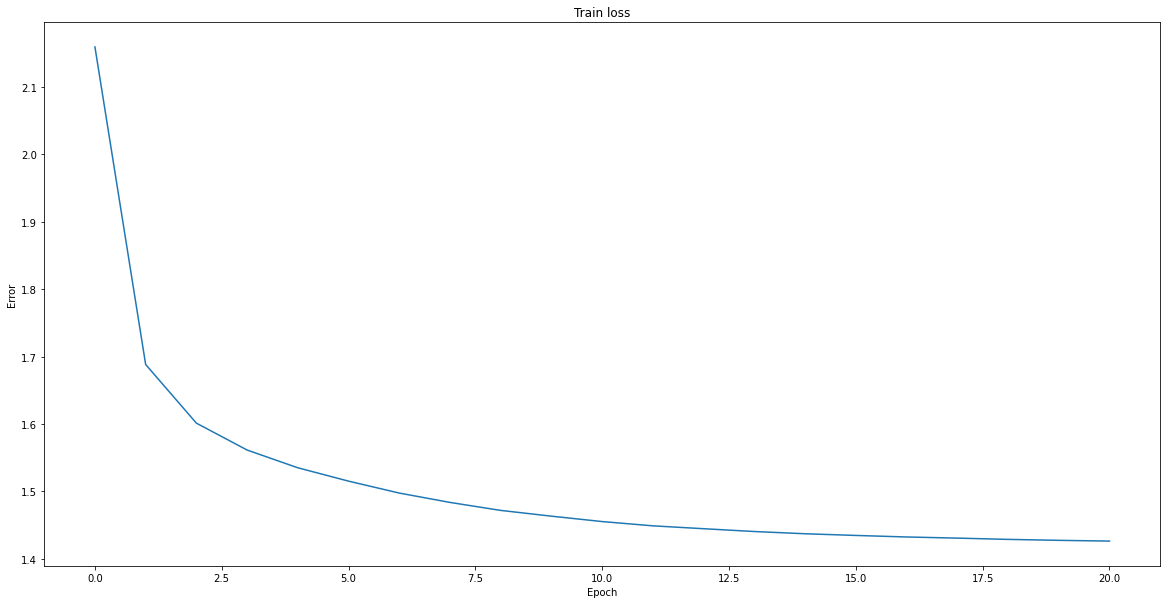

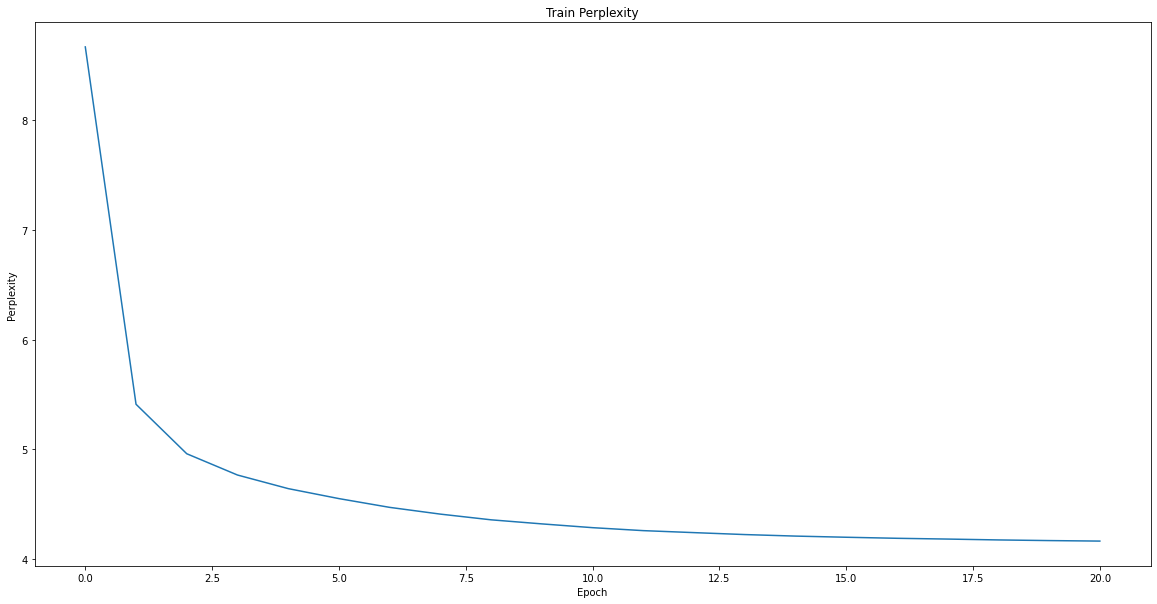

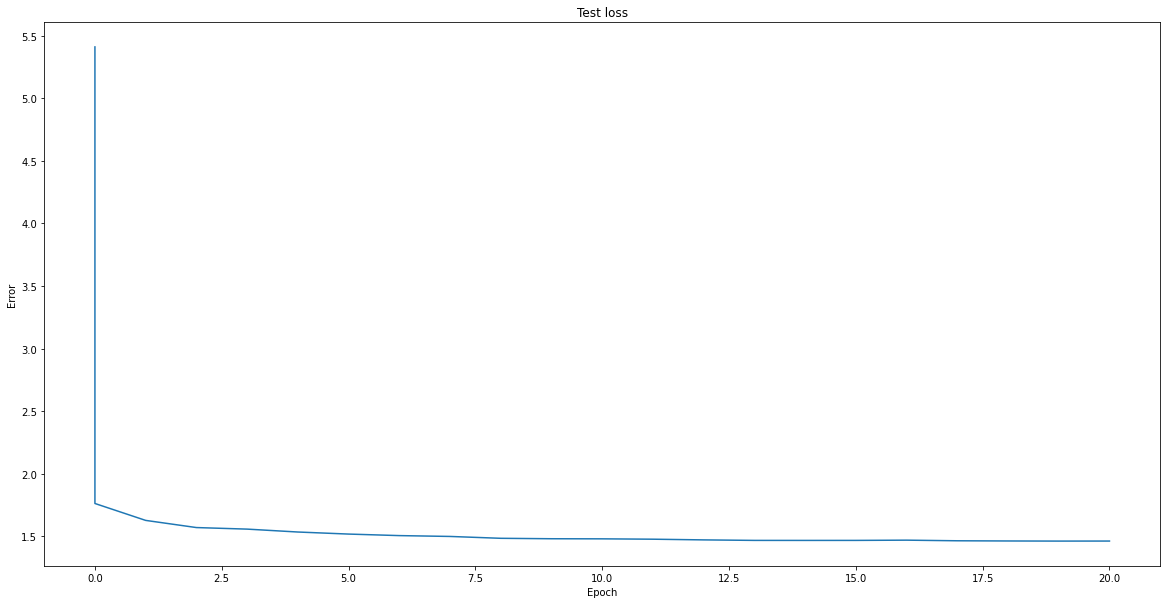

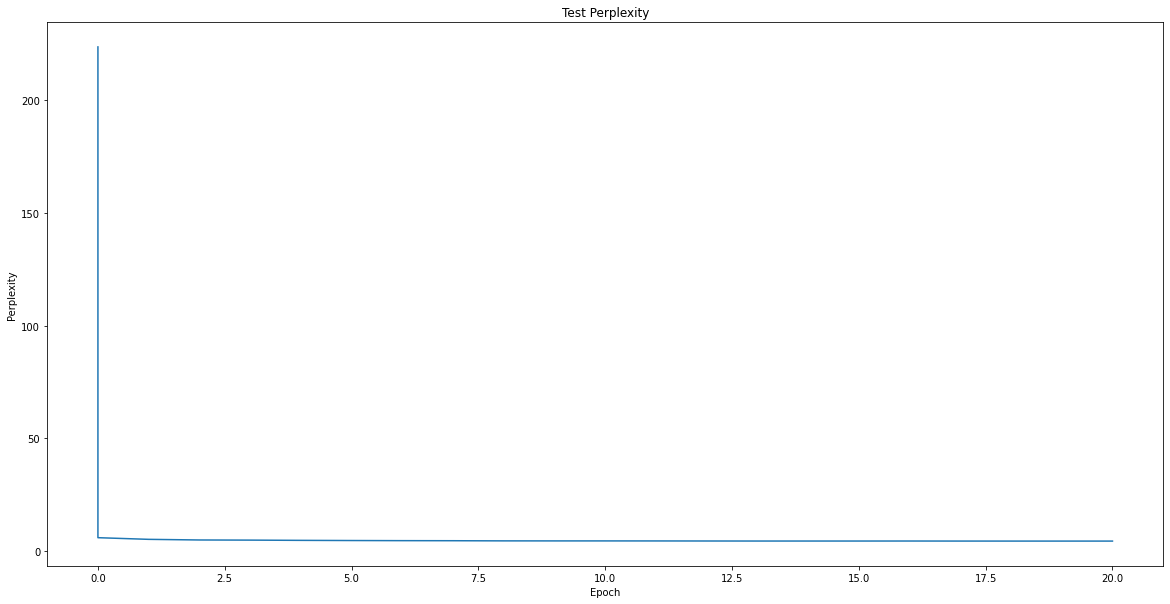

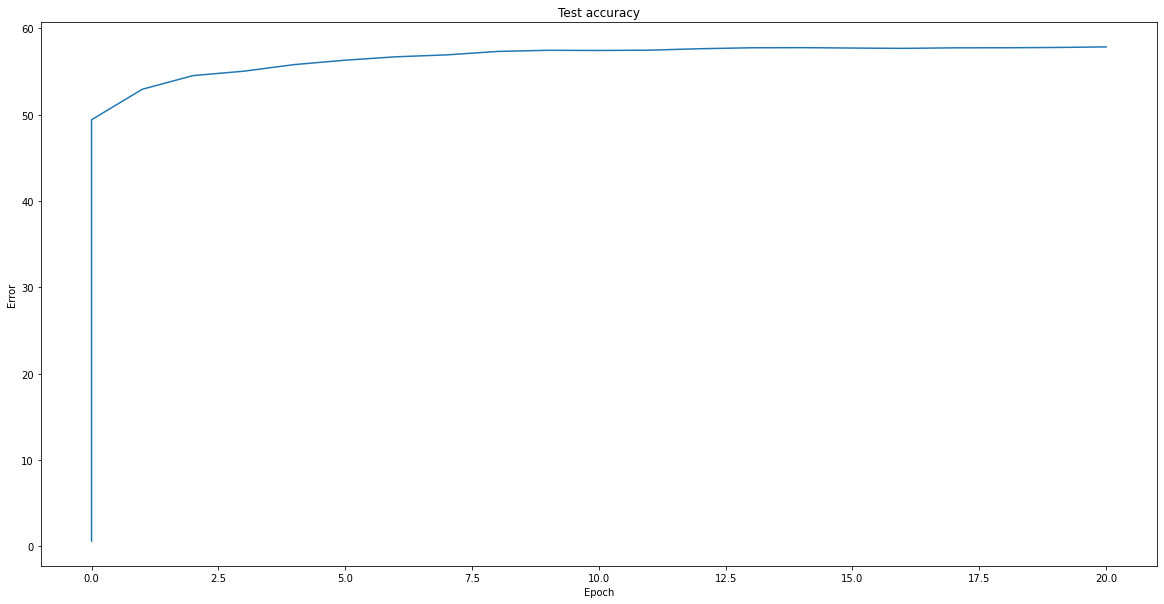

Final Test accuracy= 57.85927483974359
Final Test perplexity= 4.317084649318287


In [ ]:
# -------- VTHOMA -------------
# -------- TYRING LSTM ON CHARLES DARWIN-----------
def mainLSTM_CD():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs_LSTM_CD/log.pkl'

    data_train = CharlesDarwinDataset(DATA_PATH + 'Charles_Darwin_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = CharlesDarwinDataset(DATA_PATH + 'Charles_Darwin_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)

    #data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    #data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNetLSTM(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_LSTM_CD')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_LSTM_CD/%03d.pt' % epoch)


            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '

       
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max', device)
       
            print('generated max\t\t', generated_sentence)

            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_LSTM_CD/%03d.pt' % epoch, 0)
        ep, train_val = zip(*train_losses)
        pt_util.plot(ep, train_val, 'Train loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(train_val), 'Train Perplexity', 'Epoch', 'Perplexity')

        ep, test_val = zip(*test_losses)
        pt_util.plot(ep, test_val, 'Test loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(test_val), 'Test Perplexity', 'Epoch', 'Perplexity')

        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        print("Final Test accuracy=", val[-1])
        print("Final Test perplexity=", np.exp(test_val[-1]))
        return model, vocab, device

final_model_LSTM_CD, vocab, device = mainLSTM_CD()

In [ ]:
# ------ VTHOMA --------
# ------- TRYING LSTM on CHRLES DARWIN --------

seed = "Dogs are "
sequence_length = 200

generated_sentence = generate_language(final_model_LSTM_CD, device, seed, sequence_length, vocab, 'max')
print('generated with max\t', generated_sentence)

generated_sentence = generate_language(final_model_LSTM_CD, device, seed, sequence_length, vocab, 'sample')
print('generated with sample\t', generated_sentence)

generated_sentence = generate_language(final_model_LSTM_CD, device, seed, sequence_length, vocab, 'beam')
print('generated with beam\t', generated_sentence)

generated_sentence = generate_language(final_model_LSTM_CD, device, seed, sequence_length, vocab, 'beam')
print('generated with beam\t', generated_sentence)

in sampling strategy max-----------------------
out of for loop
[20, 6, 3, 30, 11, 8, 1, 3, 20, 11, 34, 34, 6, 20, 2, 29, 3, 9, 6, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3]
generated with max	 Dogs are so much supposed to the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of 
generated with sample	 D

In [ ]:
# ------- ADDED BY VTHOMA ---------------
# ------ NEW NETWORK ARCHITECURE ------------------
# Invrease num layers in GRU, increase feature_size, 

TEMPERATURE = 0.5
NUM_LAYERS=3

class HarryPotterNet_Updated(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet_Updated, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, NUM_LAYERS, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        #self.init_weights()
        
        self.best_accuracy = -1

    def init_weights(self):
        R = 0.1
        self.encoder.weight.data.uniform_(-R, R)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-R, R)

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # raise NotImplementedError 
        # ----- ADDED BY VTHOMA -----
        encoded = self.encoder(x)
        output,hidden_state = self.gru(encoded, hidden_state)
        decoded = self.decoder(output)
        x = decoded
        # ----- ADDED BY VTHOMA -----

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
gru.weight_ih_l1 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l1 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l1 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l1 -> 	torch.Size([1536]) = 0MB
gru.weight_ih_l2 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l2 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l2 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l2 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/colab_files/hw2/checkpoints_UpdatedModel/015.pt
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned agai

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.3385, Accuracy: 744943/1254400 (59%)



  1%|          | 2/195 [00:00<00:55,  3.45it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.332769


  6%|▌         | 11/195 [00:02<00:41,  4.46it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 2.622367


 11%|█         | 21/195 [00:04<00:38,  4.50it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.879460


 16%|█▌        | 31/195 [00:06<00:36,  4.50it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.636993


 21%|██        | 41/195 [00:09<00:33,  4.55it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.510398


 26%|██▌       | 51/195 [00:11<00:31,  4.60it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.438471


 31%|███▏      | 61/195 [00:13<00:29,  4.52it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.414581


 36%|███▋      | 71/195 [00:15<00:27,  4.49it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.392210


 42%|████▏     | 81/195 [00:17<00:25,  4.47it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.361624


 47%|████▋     | 91/195 [00:20<00:22,  4.55it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.362944


 52%|█████▏    | 101/195 [00:22<00:20,  4.51it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.359000


 57%|█████▋    | 111/195 [00:24<00:18,  4.53it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.336616


 62%|██████▏   | 121/195 [00:26<00:16,  4.49it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.342983


 67%|██████▋   | 131/195 [00:29<00:14,  4.46it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.369708


 72%|███████▏  | 141/195 [00:31<00:12,  4.44it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.361498


 77%|███████▋  | 151/195 [00:33<00:10,  4.40it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.353279


 83%|████████▎ | 161/195 [00:35<00:07,  4.39it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.331293


 88%|████████▊ | 171/195 [00:38<00:05,  4.37it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.320886


 93%|█████████▎| 181/195 [00:40<00:03,  4.35it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.320001


 98%|█████████▊| 191/195 [00:42<00:00,  4.33it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.333125


100%|██████████| 195/195 [00:43<00:00,  4.47it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat degntond soaded ttainst the core  ooask  "I dm ie r  .  "e said, "Ion't barry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the cntrr tore  and tarry sa ded humbledore teck onto the cnk oternyer,toat horl d ohe cooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seonpeng ht the coddle of the cork aaghtanueetlon tagwmeade  "or tfe oewrible sorent warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dumbred was followed to be remore the door, and Harry was horrible and the entrance was looking at her blank and slowly as he looked as the few weeken whispered Harry stared at the end of the back of t



  1%|          | 1/195 [00:00<01:11,  2.70it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.338463


  6%|▌         | 11/195 [00:02<00:42,  4.29it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.352923


 11%|█         | 21/195 [00:04<00:39,  4.36it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.382493


 16%|█▌        | 31/195 [00:07<00:37,  4.35it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.362731


 21%|██        | 41/195 [00:09<00:35,  4.30it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.333158


 26%|██▌       | 51/195 [00:11<00:33,  4.26it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.317137


 31%|███▏      | 61/195 [00:14<00:31,  4.25it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.339034


 36%|███▋      | 71/195 [00:16<00:29,  4.22it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.331228


 42%|████▏     | 81/195 [00:18<00:27,  4.21it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.315627


 47%|████▋     | 91/195 [00:21<00:24,  4.18it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.339133


 52%|█████▏    | 101/195 [00:23<00:22,  4.10it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.348591


 57%|█████▋    | 111/195 [00:26<00:20,  4.14it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.325679


 62%|██████▏   | 121/195 [00:28<00:18,  4.11it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.330731


 67%|██████▋   | 131/195 [00:31<00:15,  4.11it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.364205


 72%|███████▏  | 141/195 [00:33<00:13,  4.11it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.349460


 77%|███████▋  | 151/195 [00:36<00:10,  4.04it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.349081


 83%|████████▎ | 161/195 [00:38<00:08,  4.10it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.323538


 88%|████████▊ | 171/195 [00:40<00:05,  4.09it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.313291


 93%|█████████▎| 181/195 [00:43<00:03,  4.06it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.310135


 98%|█████████▊| 191/195 [00:45<00:00,  4.08it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.328726


100%|██████████| 195/195 [00:46<00:00,  4.17it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet delntond seadid ttainst the core  aoisk  "I dm te r  .  "e said  "Ie 't yarky  tor," said Her


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctt r tore  tnd terry sa ded humbledore teck tnto the cny oeetnye ,thet horled ohe cooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring ttd seoppeng ht the coddle of the cerk waghtanoeet on tagwmeade  "or tfe oewrible worent warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. and a little in front of the wall, the sunuestion of the potion of her wand was coming to be out of their position of the way to he really because the dementors were the parchment of the recentration t



  1%|          | 1/195 [00:00<01:08,  2.83it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.342447


  6%|▌         | 11/195 [00:02<00:46,  3.94it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.349246


 11%|█         | 21/195 [00:05<00:43,  3.98it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.340493


 16%|█▌        | 31/195 [00:07<00:41,  3.91it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.349345


 21%|██        | 41/195 [00:10<00:39,  3.93it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.333652


 26%|██▌       | 51/195 [00:13<00:36,  3.90it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.312284


 31%|███▏      | 61/195 [00:15<00:34,  3.86it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.341144


 36%|███▋      | 71/195 [00:18<00:32,  3.80it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.335931


 42%|████▏     | 81/195 [00:20<00:29,  3.81it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.321127


 47%|████▋     | 91/195 [00:23<00:27,  3.79it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.333269


 52%|█████▏    | 101/195 [00:26<00:24,  3.78it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.330050


 57%|█████▋    | 111/195 [00:28<00:22,  3.81it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.314400


 62%|██████▏   | 121/195 [00:31<00:19,  3.78it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.322413


 67%|██████▋   | 131/195 [00:33<00:16,  3.80it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.376528


 72%|███████▏  | 141/195 [00:36<00:14,  3.82it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.341486


 77%|███████▋  | 151/195 [00:39<00:11,  3.80it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.333052


 83%|████████▎ | 161/195 [00:41<00:08,  3.82it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.318440


 88%|████████▊ | 171/195 [00:44<00:06,  3.83it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.307459


 93%|█████████▎| 181/195 [00:47<00:03,  3.87it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.306090


 98%|█████████▊| 191/195 [00:49<00:01,  3.88it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.323695


100%|██████████| 195/195 [00:50<00:00,  3.85it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet selntond soadid ttainst the sorer ooisks "I sm te ri .  "e said, "Io 't yarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed hhe ctt r tore  and tarry wa ded humbledore weck into the cny ooetnler,that horled hhe cooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring hnd seopping ht the coddle of the cork waghtaioeet an tagwmeade  "or afe oewrible worent warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Death weasley got to bore when he saw what we has already look off the case of what he had have been wanter to take its litter the basilisking eyes, but he was watching Harry's hand was suddenly he won



  1%|          | 1/195 [00:00<01:12,  2.68it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.334979


  6%|▌         | 11/195 [00:02<00:46,  3.96it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.351861


 11%|█         | 21/195 [00:05<00:43,  3.99it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.334182


 16%|█▌        | 31/195 [00:07<00:40,  4.02it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.340043


 21%|██        | 41/195 [00:10<00:38,  4.00it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.322674


 26%|██▌       | 51/195 [00:12<00:36,  3.93it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.311108


 31%|███▏      | 61/195 [00:15<00:33,  3.96it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.331477


 36%|███▋      | 71/195 [00:17<00:31,  3.94it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.324185


 42%|████▏     | 81/195 [00:20<00:28,  3.96it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.313453


 47%|████▋     | 91/195 [00:23<00:26,  3.93it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.336616


 52%|█████▏    | 101/195 [00:25<00:24,  3.90it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.330279


 57%|█████▋    | 111/195 [00:28<00:21,  3.87it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.315750


 62%|██████▏   | 121/195 [00:30<00:19,  3.85it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.322786


 67%|██████▋   | 131/195 [00:33<00:16,  3.86it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.356881


 72%|███████▏  | 141/195 [00:35<00:14,  3.84it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.341850


 77%|███████▋  | 151/195 [00:38<00:11,  3.86it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.333579


 83%|████████▎ | 161/195 [00:41<00:08,  3.84it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.316829


 88%|████████▊ | 171/195 [00:43<00:06,  3.83it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.299037


 93%|█████████▎| 181/195 [00:46<00:03,  3.87it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.307278


 98%|█████████▊| 191/195 [00:48<00:01,  3.87it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.321193


100%|██████████| 195/195 [00:49<00:00,  3.90it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet selntond seadid atainst the core aeoisls "I dm ae r  .  "e said  "Io 't yarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed hhe ctt r oore  and harry waaded humbledore aeck onto the cny otatnler,ahan horled ohe coeaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and seoppeng ht the coddle of the cerk waghtanoeet on tagsmeade  "or afe oewrible worent warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Death was already began to have something to be and a good to be stretched in the way out of the carefully of the school was all of the pain, which he was a note at all. I said the sound of the careene



  1%|          | 1/195 [00:00<01:10,  2.75it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.330569


  6%|▌         | 11/195 [00:02<00:46,  3.92it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.343684


 11%|█         | 21/195 [00:05<00:44,  3.90it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.325951


 16%|█▌        | 31/195 [00:08<00:41,  3.93it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.333276


 21%|██        | 41/195 [00:10<00:39,  3.89it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.314879


 26%|██▌       | 51/195 [00:13<00:36,  3.89it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.309111


 31%|███▏      | 61/195 [00:15<00:34,  3.92it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.317002


 36%|███▋      | 71/195 [00:18<00:32,  3.86it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.319611


 42%|████▏     | 81/195 [00:20<00:29,  3.86it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.309259


 47%|████▋     | 91/195 [00:23<00:26,  3.86it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.356206


 52%|█████▏    | 101/195 [00:26<00:24,  3.89it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.340045


 57%|█████▋    | 111/195 [00:28<00:21,  3.87it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.309642


 62%|██████▏   | 121/195 [00:31<00:19,  3.85it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.315692


 67%|██████▋   | 131/195 [00:33<00:16,  3.92it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.339757


 72%|███████▏  | 141/195 [00:36<00:13,  3.87it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.335298


 77%|███████▋  | 151/195 [00:38<00:11,  3.89it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.335134


 83%|████████▎ | 161/195 [00:41<00:08,  3.89it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.315418


 88%|████████▊ | 171/195 [00:44<00:06,  3.88it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.295119


 93%|█████████▎| 181/195 [00:46<00:03,  3.88it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.305397


 98%|█████████▊| 191/195 [00:49<00:01,  3.91it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.311939


100%|██████████| 195/195 [00:50<00:00,  3.89it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet delntond seadid otainst the cose  ooisls "I dm ae r  .  "e said  "Ion't yarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed hhe ctt r oore  and terry saaded oumbledore aeck onto the cny otatnler aoan horled ohe cooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring ond seonping hn the condle of the cerk waghtanoeet on tagwmeade  "or afe oerrible sorent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dementors was going to want to the pitch of the fire. "I don't be seen it, the only one with we have been come to the way, the one of the corridor was working in her cabinet desperating in the face of 



  1%|          | 1/195 [00:00<01:08,  2.82it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.325465


  6%|▌         | 11/195 [00:02<00:46,  3.97it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.341839


 11%|█         | 21/195 [00:05<00:44,  3.91it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.321625


 16%|█▌        | 31/195 [00:07<00:41,  3.93it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.332057


 21%|██        | 41/195 [00:10<00:39,  3.92it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.311005


 26%|██▌       | 51/195 [00:13<00:37,  3.89it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.299526


 31%|███▏      | 61/195 [00:15<00:34,  3.89it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.320517


 36%|███▋      | 71/195 [00:18<00:31,  3.89it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.315357


 42%|████▏     | 81/195 [00:20<00:29,  3.85it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.301955


 47%|████▋     | 91/195 [00:23<00:27,  3.85it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.321465


 52%|█████▏    | 101/195 [00:25<00:24,  3.81it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.326746


 57%|█████▋    | 111/195 [00:28<00:21,  3.89it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.301818


 62%|██████▏   | 121/195 [00:31<00:19,  3.81it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.305856


 67%|██████▋   | 131/195 [00:33<00:16,  3.87it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.341801


 72%|███████▏  | 141/195 [00:36<00:13,  3.86it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.336333


 77%|███████▋  | 151/195 [00:38<00:11,  3.86it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.320445


 83%|████████▎ | 161/195 [00:41<00:08,  3.86it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.312130


 88%|████████▊ | 171/195 [00:44<00:06,  3.82it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.293904


 93%|█████████▎| 181/195 [00:46<00:03,  3.86it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.296307


 98%|█████████▊| 191/195 [00:49<00:01,  3.88it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.309911


100%|██████████| 195/195 [00:50<00:00,  3.88it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet delntond seadid ttainst the cose  ooisl  "I dm ae r  .  "e said  "Io 't yarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed hhe ctt r oare  and tarry waaded humbledore teck on o the cny otatnler than horled ohe cooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring snd sionping ht the coddle of the cerk waghtanoeet on tagwmeade  "or afe oerrible soment warr


Input	 help, but there was nobody to be see

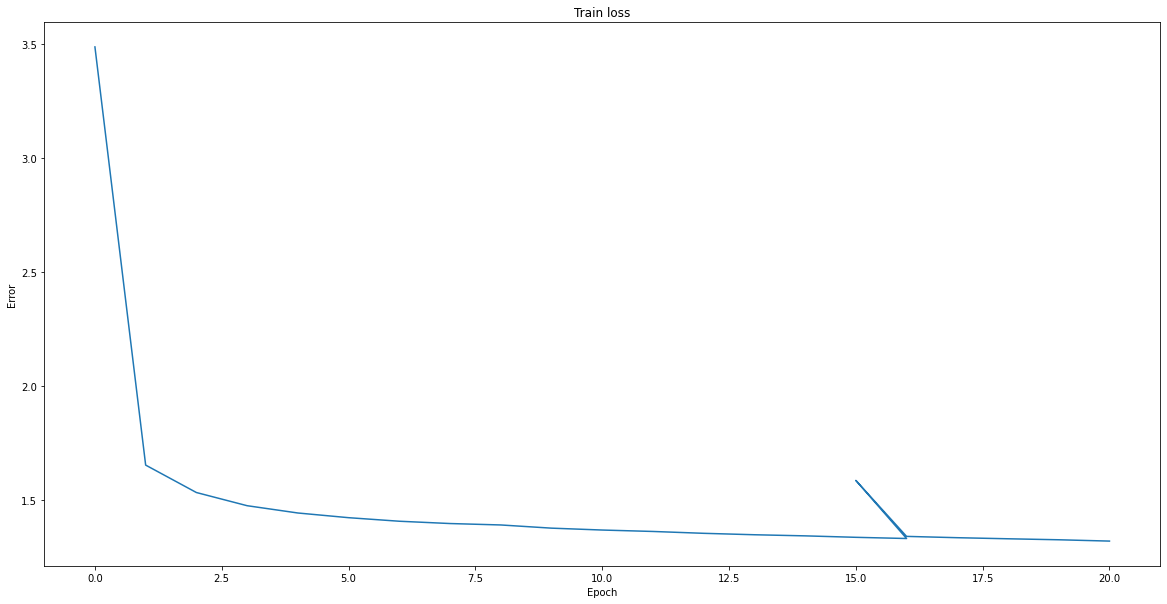

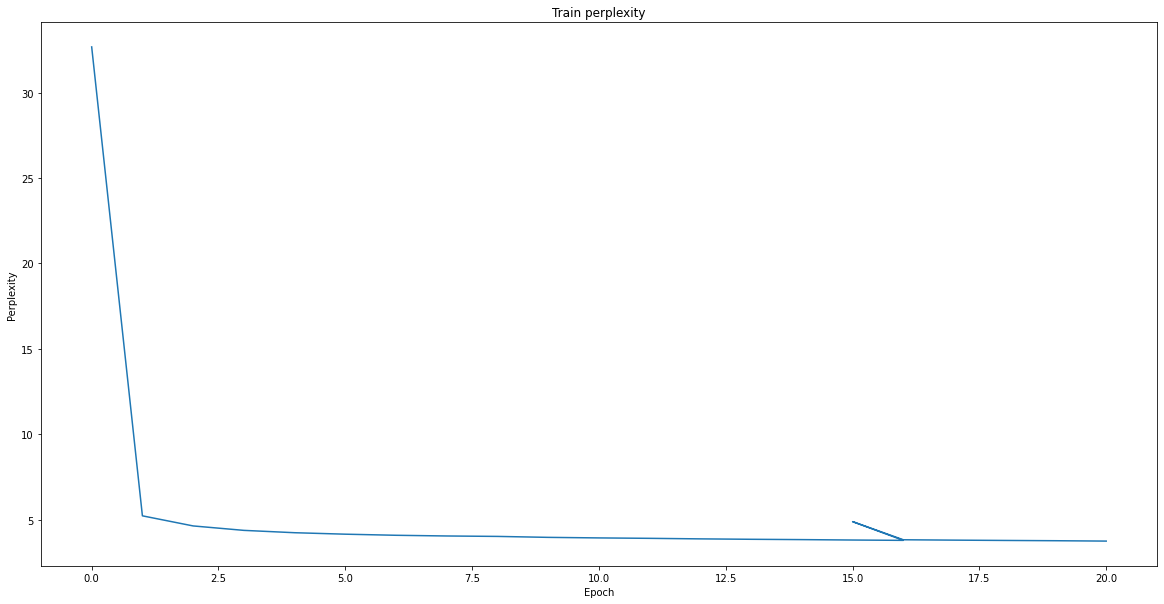

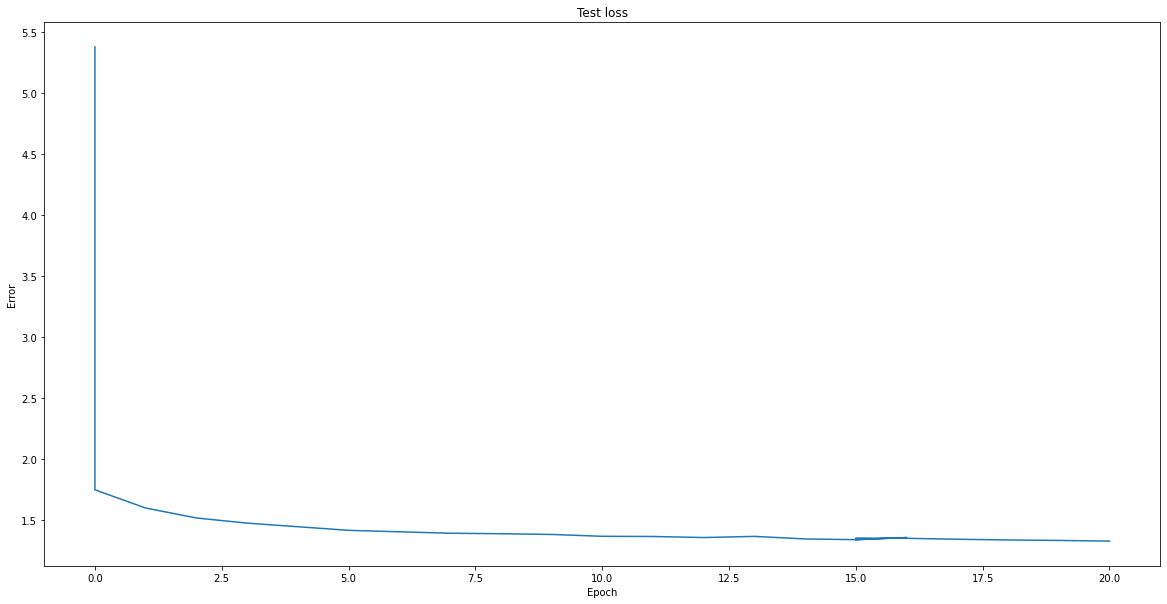

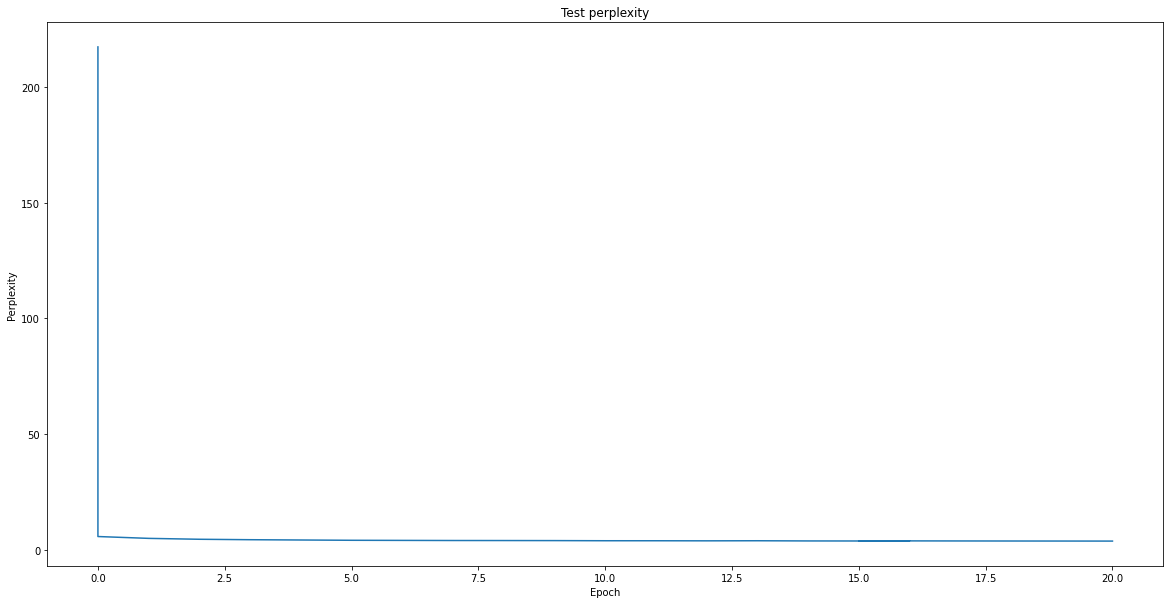

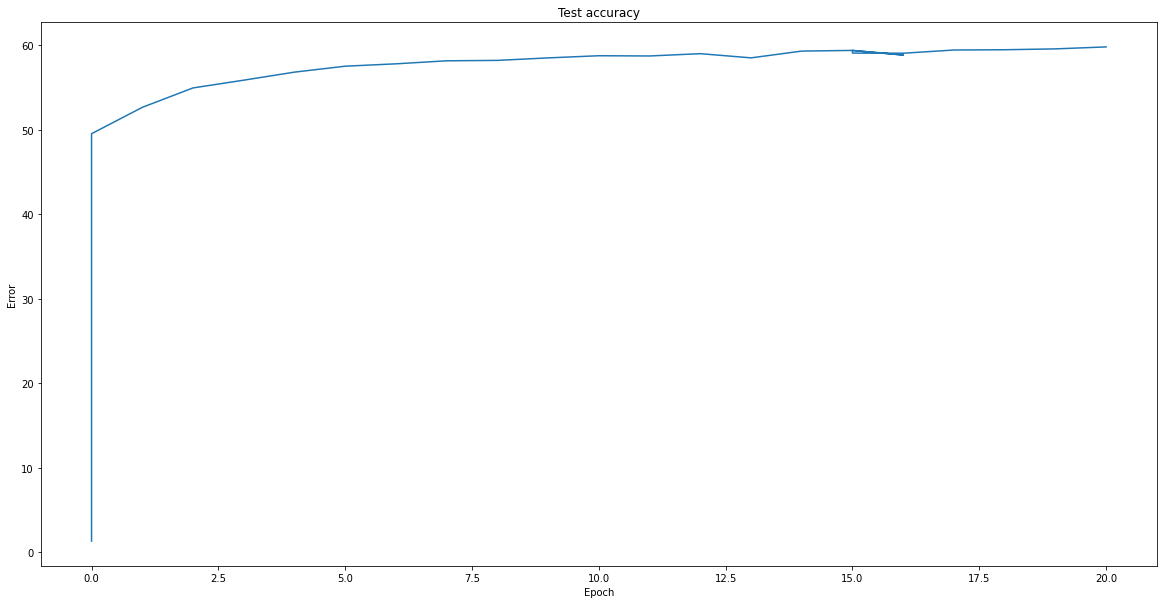

Final test accuracy= 59.80157844387755
Final test perplexity= 3.7687110232484895


In [ ]:
# -------- ADDED BY VTHOMA ------
# --------- NEW NETWORK ARCHITECTURE ------------

def main_UpdatedModel():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002#.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs_UpdatedModel/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet_Updated(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_UpdatedModel')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_UpdatedModel/%03d.pt' % epoch)


            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '

            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')


            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_UpdatedModel/%03d.pt' % epoch, 0)
        ep, train_val = zip(*train_losses)
        pt_util.plot(ep, train_val, 'Train loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(train_val), 'Train perplexity', 'Epoch', 'Perplexity')        
        
        ep, test_val = zip(*test_losses)
        pt_util.plot(ep, test_val, 'Test loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(test_val), 'Test perplexity', 'Epoch', 'Perplexity')
        
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        print("Final test accuracy=", val[-1])
        print("Final test perplexity=", np.exp(test_val[-1]))
        return model, vocab, device

final_model_updated, vocab, device = main_UpdatedModel()

Using device cuda
num workers: 2
Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	ÉÉÉËËËËËËÂÂËË,!FFFÉ’’’ËËËËËËgg66gg′′′Ë³ËY7ËË³³__66666


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	#³66ËËËËËËË||||666ggËœ6′′′ggggg³³³³#³66ËËËË’ÂÂËËËËFËËœ


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	ddœœFËË}ÂÂÂÂÂÂÂ66666g'||6666œœœË³6FFFÉ³³Ë!!!ËËËËœœœœLL'))œœœ6


Input	with

  0%|          | 0/310 [00:00<?, ?it/s]


Test set: Average loss: 7.1730, Accuracy: 2362/1996800 (0%)



  0%|          | 1/310 [00:00<01:44,  2.97it/s]

Train Epoch: 0 [0/79360 (0%)]	Loss: 7.141041


  4%|▎         | 11/310 [00:02<01:10,  4.25it/s]

Train Epoch: 0 [2560/79360 (3%)]	Loss: 18.317419


  7%|▋         | 21/310 [00:04<01:07,  4.28it/s]

Train Epoch: 0 [5120/79360 (6%)]	Loss: 14.510118


 10%|█         | 31/310 [00:07<01:06,  4.23it/s]

Train Epoch: 0 [7680/79360 (10%)]	Loss: 5.303863


 13%|█▎        | 41/310 [00:09<01:04,  4.18it/s]

Train Epoch: 0 [10240/79360 (13%)]	Loss: 3.481577


 16%|█▋        | 51/310 [00:12<01:01,  4.23it/s]

Train Epoch: 0 [12800/79360 (16%)]	Loss: 2.749280


 20%|█▉        | 61/310 [00:14<00:59,  4.18it/s]

Train Epoch: 0 [15360/79360 (19%)]	Loss: 2.462290


 23%|██▎       | 71/310 [00:16<00:57,  4.16it/s]

Train Epoch: 0 [17920/79360 (23%)]	Loss: 2.301089


 26%|██▌       | 81/310 [00:19<00:54,  4.17it/s]

Train Epoch: 0 [20480/79360 (26%)]	Loss: 2.216799


 29%|██▉       | 91/310 [00:21<00:53,  4.11it/s]

Train Epoch: 0 [23040/79360 (29%)]	Loss: 2.164477


 33%|███▎      | 101/310 [00:24<00:50,  4.12it/s]

Train Epoch: 0 [25600/79360 (32%)]	Loss: 2.144489


 36%|███▌      | 111/310 [00:26<00:47,  4.16it/s]

Train Epoch: 0 [28160/79360 (35%)]	Loss: 2.096783


 39%|███▉      | 121/310 [00:28<00:46,  4.10it/s]

Train Epoch: 0 [30720/79360 (39%)]	Loss: 2.073530


 42%|████▏     | 131/310 [00:31<00:43,  4.12it/s]

Train Epoch: 0 [33280/79360 (42%)]	Loss: 2.035135


 45%|████▌     | 141/310 [00:33<00:41,  4.06it/s]

Train Epoch: 0 [35840/79360 (45%)]	Loss: 1.996097


 49%|████▊     | 151/310 [00:36<00:39,  4.01it/s]

Train Epoch: 0 [38400/79360 (48%)]	Loss: 1.962664


 52%|█████▏    | 161/310 [00:38<00:36,  4.03it/s]

Train Epoch: 0 [40960/79360 (52%)]	Loss: 1.944031


 55%|█████▌    | 171/310 [00:41<00:35,  3.97it/s]

Train Epoch: 0 [43520/79360 (55%)]	Loss: 1.948223


 58%|█████▊    | 181/310 [00:43<00:32,  3.92it/s]

Train Epoch: 0 [46080/79360 (58%)]	Loss: 1.920150


 62%|██████▏   | 191/310 [00:46<00:30,  3.90it/s]

Train Epoch: 0 [48640/79360 (61%)]	Loss: 1.880820


 65%|██████▍   | 201/310 [00:49<00:28,  3.85it/s]

Train Epoch: 0 [51200/79360 (65%)]	Loss: 1.912004


 68%|██████▊   | 211/310 [00:51<00:26,  3.80it/s]

Train Epoch: 0 [53760/79360 (68%)]	Loss: 1.850905


 71%|███████▏  | 221/310 [00:54<00:23,  3.78it/s]

Train Epoch: 0 [56320/79360 (71%)]	Loss: 1.827076


 75%|███████▍  | 231/310 [00:56<00:20,  3.88it/s]

Train Epoch: 0 [58880/79360 (74%)]	Loss: 1.805923


 78%|███████▊  | 241/310 [00:59<00:18,  3.80it/s]

Train Epoch: 0 [61440/79360 (77%)]	Loss: 1.817668


 81%|████████  | 251/310 [01:02<00:15,  3.79it/s]

Train Epoch: 0 [64000/79360 (81%)]	Loss: 1.774759


 84%|████████▍ | 261/310 [01:04<00:12,  3.80it/s]

Train Epoch: 0 [66560/79360 (84%)]	Loss: 1.796560


 87%|████████▋ | 271/310 [01:07<00:10,  3.78it/s]

Train Epoch: 0 [69120/79360 (87%)]	Loss: 1.798983


 91%|█████████ | 281/310 [01:10<00:07,  3.74it/s]

Train Epoch: 0 [71680/79360 (90%)]	Loss: 1.760838


 94%|█████████▍| 291/310 [01:12<00:05,  3.70it/s]

Train Epoch: 0 [74240/79360 (94%)]	Loss: 1.759482


 97%|█████████▋| 301/310 [01:15<00:02,  3.64it/s]

Train Epoch: 0 [76800/79360 (97%)]	Loss: 1.743482


100%|██████████| 310/310 [01:17<00:00,  3.98it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	nnsh se suund ty the shrms of thes ssoeansnts aou san bfsennsisseauldeooom the srrsonsof aacrve oo s


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ths toatis, I  s dassividual sirksss ss the srrlisaaisennsss the sniths toatis,ond soursne sanktid t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaaasshe sass of tour sonntra osss m tionsoo the srrms of thes ssoeansntsoy ore ti n,ygsssg  aono ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement prossible sations of the speass. The same specisting the same so that the conditions of the save a sent semale, as for the graviss, that the same species on the same structure of the same ground that t



  0%|          | 1/310 [00:00<01:56,  2.65it/s]

Train Epoch: 1 [0/79360 (0%)]	Loss: 1.765836


  4%|▎         | 11/310 [00:03<01:25,  3.50it/s]

Train Epoch: 1 [2560/79360 (3%)]	Loss: 1.799025


  7%|▋         | 21/310 [00:06<01:21,  3.53it/s]

Train Epoch: 1 [5120/79360 (6%)]	Loss: 1.738950


 10%|█         | 31/310 [00:08<01:20,  3.47it/s]

Train Epoch: 1 [7680/79360 (10%)]	Loss: 1.722129


 13%|█▎        | 41/310 [00:11<01:17,  3.46it/s]

Train Epoch: 1 [10240/79360 (13%)]	Loss: 1.673617


 16%|█▋        | 51/310 [00:14<01:15,  3.41it/s]

Train Epoch: 1 [12800/79360 (16%)]	Loss: 1.704940


 20%|█▉        | 61/310 [00:17<01:13,  3.41it/s]

Train Epoch: 1 [15360/79360 (19%)]	Loss: 1.678770


 23%|██▎       | 71/310 [00:20<01:10,  3.39it/s]

Train Epoch: 1 [17920/79360 (23%)]	Loss: 1.626485


 26%|██▌       | 81/310 [00:23<01:06,  3.42it/s]

Train Epoch: 1 [20480/79360 (26%)]	Loss: 1.639115


 29%|██▉       | 91/310 [00:26<01:02,  3.49it/s]

Train Epoch: 1 [23040/79360 (29%)]	Loss: 1.681583


 33%|███▎      | 101/310 [00:29<00:59,  3.52it/s]

Train Epoch: 1 [25600/79360 (32%)]	Loss: 1.653782


 36%|███▌      | 111/310 [00:31<00:55,  3.57it/s]

Train Epoch: 1 [28160/79360 (35%)]	Loss: 1.669709


 39%|███▉      | 121/310 [00:34<00:52,  3.59it/s]

Train Epoch: 1 [30720/79360 (39%)]	Loss: 1.662419


 42%|████▏     | 131/310 [00:37<00:49,  3.64it/s]

Train Epoch: 1 [33280/79360 (42%)]	Loss: 1.633590


 45%|████▌     | 141/310 [00:40<00:46,  3.65it/s]

Train Epoch: 1 [35840/79360 (45%)]	Loss: 1.614209


 49%|████▊     | 151/310 [00:43<00:43,  3.64it/s]

Train Epoch: 1 [38400/79360 (48%)]	Loss: 1.662271


 52%|█████▏    | 161/310 [00:45<00:40,  3.65it/s]

Train Epoch: 1 [40960/79360 (52%)]	Loss: 1.657404


 55%|█████▌    | 171/310 [00:48<00:37,  3.67it/s]

Train Epoch: 1 [43520/79360 (55%)]	Loss: 1.666736


 58%|█████▊    | 181/310 [00:51<00:35,  3.67it/s]

Train Epoch: 1 [46080/79360 (58%)]	Loss: 1.634663


 62%|██████▏   | 191/310 [00:53<00:32,  3.70it/s]

Train Epoch: 1 [48640/79360 (61%)]	Loss: 1.597704


 65%|██████▍   | 201/310 [00:56<00:29,  3.68it/s]

Train Epoch: 1 [51200/79360 (65%)]	Loss: 1.625072


 68%|██████▊   | 211/310 [00:59<00:26,  3.69it/s]

Train Epoch: 1 [53760/79360 (68%)]	Loss: 1.595451


 71%|███████▏  | 221/310 [01:02<00:24,  3.64it/s]

Train Epoch: 1 [56320/79360 (71%)]	Loss: 1.601685


 75%|███████▍  | 231/310 [01:04<00:21,  3.65it/s]

Train Epoch: 1 [58880/79360 (74%)]	Loss: 1.596716


 78%|███████▊  | 241/310 [01:07<00:18,  3.63it/s]

Train Epoch: 1 [61440/79360 (77%)]	Loss: 1.629752


 81%|████████  | 251/310 [01:10<00:16,  3.65it/s]

Train Epoch: 1 [64000/79360 (81%)]	Loss: 1.594436


 84%|████████▍ | 261/310 [01:13<00:13,  3.60it/s]

Train Epoch: 1 [66560/79360 (84%)]	Loss: 1.611551


 87%|████████▋ | 271/310 [01:15<00:10,  3.56it/s]

Train Epoch: 1 [69120/79360 (87%)]	Loss: 1.597319


 91%|█████████ | 281/310 [01:18<00:08,  3.55it/s]

Train Epoch: 1 [71680/79360 (90%)]	Loss: 1.573693


 94%|█████████▍| 291/310 [01:21<00:05,  3.54it/s]

Train Epoch: 1 [74240/79360 (94%)]	Loss: 1.555933


 97%|█████████▋| 301/310 [01:24<00:02,  3.56it/s]

Train Epoch: 1 [76800/79360 (97%)]	Loss: 1.661067


100%|██████████| 310/310 [01:26<00:00,  3.57it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 dth te tednd ty the eerms of thes etaee ent  aeu way bfsein tttemeld toom the frrfon of tvdrri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	te  ttates  It t dam ividual sirk on tt the errlis oo etn ot the enite  ttates trd teu ale tiwktid t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oasksthe fars of tou  oomltry os t mition oo the eirms of thes etaee ent oy ore te n ygd,tg  tomy ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement may of the Vours, and the termetite of the time of the terms of the same ground to the other of March of the female of the females of the terms of the other of the extremed improved by the early experm



  0%|          | 1/310 [00:00<01:57,  2.63it/s]

Train Epoch: 2 [0/79360 (0%)]	Loss: 1.606357


  4%|▎         | 11/310 [00:03<01:24,  3.55it/s]

Train Epoch: 2 [2560/79360 (3%)]	Loss: 1.600714


  7%|▋         | 21/310 [00:05<01:20,  3.60it/s]

Train Epoch: 2 [5120/79360 (6%)]	Loss: 1.542150


 10%|█         | 31/310 [00:08<01:18,  3.54it/s]

Train Epoch: 2 [7680/79360 (10%)]	Loss: 1.564313


 13%|█▎        | 41/310 [00:11<01:15,  3.56it/s]

Train Epoch: 2 [10240/79360 (13%)]	Loss: 1.532744


 16%|█▋        | 51/310 [00:14<01:12,  3.55it/s]

Train Epoch: 2 [12800/79360 (16%)]	Loss: 1.563733


 20%|█▉        | 61/310 [00:17<01:10,  3.52it/s]

Train Epoch: 2 [15360/79360 (19%)]	Loss: 1.561763


 23%|██▎       | 71/310 [00:20<01:08,  3.51it/s]

Train Epoch: 2 [17920/79360 (23%)]	Loss: 1.512872


 26%|██▌       | 81/310 [00:22<01:04,  3.54it/s]

Train Epoch: 2 [20480/79360 (26%)]	Loss: 1.559891


 29%|██▉       | 91/310 [00:25<01:02,  3.52it/s]

Train Epoch: 2 [23040/79360 (29%)]	Loss: 1.654392


 33%|███▎      | 101/310 [00:28<00:59,  3.52it/s]

Train Epoch: 2 [25600/79360 (32%)]	Loss: 1.610649


 36%|███▌      | 111/310 [00:31<00:56,  3.54it/s]

Train Epoch: 2 [28160/79360 (35%)]	Loss: 1.567193


 39%|███▉      | 121/310 [00:34<00:53,  3.55it/s]

Train Epoch: 2 [30720/79360 (39%)]	Loss: 1.556835


 42%|████▏     | 131/310 [00:37<00:50,  3.53it/s]

Train Epoch: 2 [33280/79360 (42%)]	Loss: 1.536277


 45%|████▌     | 141/310 [00:39<00:47,  3.54it/s]

Train Epoch: 2 [35840/79360 (45%)]	Loss: 1.504964


 49%|████▊     | 151/310 [00:42<00:44,  3.56it/s]

Train Epoch: 2 [38400/79360 (48%)]	Loss: 1.516658


 52%|█████▏    | 161/310 [00:45<00:42,  3.54it/s]

Train Epoch: 2 [40960/79360 (52%)]	Loss: 1.505347


 55%|█████▌    | 171/310 [00:48<00:39,  3.54it/s]

Train Epoch: 2 [43520/79360 (55%)]	Loss: 1.528223


 58%|█████▊    | 181/310 [00:51<00:36,  3.54it/s]

Train Epoch: 2 [46080/79360 (58%)]	Loss: 1.525797


 62%|██████▏   | 191/310 [00:53<00:33,  3.56it/s]

Train Epoch: 2 [48640/79360 (61%)]	Loss: 1.505312


 65%|██████▍   | 201/310 [00:56<00:30,  3.56it/s]

Train Epoch: 2 [51200/79360 (65%)]	Loss: 1.562451


 68%|██████▊   | 211/310 [00:59<00:27,  3.54it/s]

Train Epoch: 2 [53760/79360 (68%)]	Loss: 1.530932


 71%|███████▏  | 221/310 [01:02<00:24,  3.59it/s]

Train Epoch: 2 [56320/79360 (71%)]	Loss: 1.542979


 75%|███████▍  | 231/310 [01:05<00:22,  3.57it/s]

Train Epoch: 2 [58880/79360 (74%)]	Loss: 1.531611


 78%|███████▊  | 241/310 [01:07<00:19,  3.57it/s]

Train Epoch: 2 [61440/79360 (77%)]	Loss: 1.544258


 81%|████████  | 251/310 [01:10<00:16,  3.56it/s]

Train Epoch: 2 [64000/79360 (81%)]	Loss: 1.499205


 84%|████████▍ | 261/310 [01:13<00:13,  3.56it/s]

Train Epoch: 2 [66560/79360 (84%)]	Loss: 1.540694


 87%|████████▋ | 271/310 [01:16<00:10,  3.57it/s]

Train Epoch: 2 [69120/79360 (87%)]	Loss: 1.529962


 91%|█████████ | 281/310 [01:19<00:08,  3.57it/s]

Train Epoch: 2 [71680/79360 (90%)]	Loss: 1.514009


 94%|█████████▍| 291/310 [01:21<00:05,  3.57it/s]

Train Epoch: 2 [74240/79360 (94%)]	Loss: 1.501848


 97%|█████████▋| 301/310 [01:24<00:02,  3.55it/s]

Train Epoch: 2 [76800/79360 (97%)]	Loss: 1.609598


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	nnph se srdnd oy the sirms of thes snaee ent  aeu say bfsein onsemeld orom the srrfon of sadioi oo s


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted otates  Tn indinsividual sirkson nn she srrlis oomenn on she snited otates ond sou sne siwktid o


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oask ahe sars of tour sonltry on s mition oo the sirms of thes snaee ent oyiore eemn ywd ng  aony ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement down some of species of considerable of species by their his are and the northow of the same manner of species of the experminated for the same species of a single species, and the first and was a cons



  0%|          | 1/310 [00:00<01:58,  2.60it/s]

Train Epoch: 3 [0/79360 (0%)]	Loss: 1.533435


  4%|▎         | 11/310 [00:03<01:22,  3.60it/s]

Train Epoch: 3 [2560/79360 (3%)]	Loss: 1.531162


  7%|▋         | 21/310 [00:05<01:20,  3.61it/s]

Train Epoch: 3 [5120/79360 (6%)]	Loss: 1.470694


 10%|█         | 31/310 [00:08<01:17,  3.59it/s]

Train Epoch: 3 [7680/79360 (10%)]	Loss: 1.509360


 13%|█▎        | 41/310 [00:11<01:15,  3.56it/s]

Train Epoch: 3 [10240/79360 (13%)]	Loss: 1.485500


 16%|█▋        | 51/310 [00:14<01:13,  3.51it/s]

Train Epoch: 3 [12800/79360 (16%)]	Loss: 1.527743


 20%|█▉        | 61/310 [00:17<01:10,  3.52it/s]

Train Epoch: 3 [15360/79360 (19%)]	Loss: 1.520423


 23%|██▎       | 71/310 [00:19<01:08,  3.50it/s]

Train Epoch: 3 [17920/79360 (23%)]	Loss: 1.465716


 26%|██▌       | 81/310 [00:22<01:05,  3.48it/s]

Train Epoch: 3 [20480/79360 (26%)]	Loss: 1.543655


 29%|██▉       | 91/310 [00:25<01:03,  3.44it/s]

Train Epoch: 3 [23040/79360 (29%)]	Loss: 1.482982


 33%|███▎      | 101/310 [00:28<01:00,  3.45it/s]

Train Epoch: 3 [25600/79360 (32%)]	Loss: 1.488438


 36%|███▌      | 111/310 [00:31<00:57,  3.49it/s]

Train Epoch: 3 [28160/79360 (35%)]	Loss: 1.489616


 39%|███▉      | 121/310 [00:34<00:53,  3.51it/s]

Train Epoch: 3 [30720/79360 (39%)]	Loss: 1.514429


 42%|████▏     | 131/310 [00:37<00:50,  3.55it/s]

Train Epoch: 3 [33280/79360 (42%)]	Loss: 1.489602


 45%|████▌     | 141/310 [00:40<00:47,  3.52it/s]

Train Epoch: 3 [35840/79360 (45%)]	Loss: 1.467062


 49%|████▊     | 151/310 [00:42<00:45,  3.53it/s]

Train Epoch: 3 [38400/79360 (48%)]	Loss: 1.509867


 52%|█████▏    | 161/310 [00:45<00:42,  3.54it/s]

Train Epoch: 3 [40960/79360 (52%)]	Loss: 1.530811


 55%|█████▌    | 171/310 [00:48<00:39,  3.54it/s]

Train Epoch: 3 [43520/79360 (55%)]	Loss: 1.516287


 58%|█████▊    | 181/310 [00:51<00:35,  3.59it/s]

Train Epoch: 3 [46080/79360 (58%)]	Loss: 1.499445


 62%|██████▏   | 191/310 [00:54<00:33,  3.59it/s]

Train Epoch: 3 [48640/79360 (61%)]	Loss: 1.469870


 65%|██████▍   | 201/310 [00:56<00:30,  3.60it/s]

Train Epoch: 3 [51200/79360 (65%)]	Loss: 1.500769


 68%|██████▊   | 211/310 [00:59<00:27,  3.58it/s]

Train Epoch: 3 [53760/79360 (68%)]	Loss: 1.480414


 71%|███████▏  | 221/310 [01:02<00:24,  3.61it/s]

Train Epoch: 3 [56320/79360 (71%)]	Loss: 1.506843


 75%|███████▍  | 231/310 [01:05<00:21,  3.59it/s]

Train Epoch: 3 [58880/79360 (74%)]	Loss: 1.517149


 78%|███████▊  | 241/310 [01:07<00:19,  3.58it/s]

Train Epoch: 3 [61440/79360 (77%)]	Loss: 1.547605


 81%|████████  | 251/310 [01:10<00:16,  3.57it/s]

Train Epoch: 3 [64000/79360 (81%)]	Loss: 1.482823


 84%|████████▍ | 261/310 [01:13<00:13,  3.57it/s]

Train Epoch: 3 [66560/79360 (84%)]	Loss: 1.504064


 87%|████████▋ | 271/310 [01:16<00:10,  3.57it/s]

Train Epoch: 3 [69120/79360 (87%)]	Loss: 1.497796


 91%|█████████ | 281/310 [01:19<00:08,  3.54it/s]

Train Epoch: 3 [71680/79360 (90%)]	Loss: 1.484987


 94%|█████████▍| 291/310 [01:21<00:05,  3.55it/s]

Train Epoch: 3 [74240/79360 (94%)]	Loss: 1.450252


 97%|█████████▋| 301/310 [01:24<00:02,  3.54it/s]

Train Epoch: 3 [76800/79360 (97%)]	Loss: 1.508104


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth se sednd te the serms of thes snaee ent  aeu way bfsein tnsemend trom the srrfon wf saeiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States  Tn tndintividual serksin nn the srrlis oomenn in the snited States tnd teunwne nenkled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oankeihe sens of tour sanntry in tnmition oh the serms of thes snaee ent oe ore te n ywd,ng  aonirng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement perfect in the structure and the same conditions of the surface of the sacial consection, and the structure in the structure, and the male than the length of the selection of the second the conditions 



  0%|          | 1/310 [00:00<01:54,  2.69it/s]

Train Epoch: 4 [0/79360 (0%)]	Loss: 1.486853


  4%|▎         | 11/310 [00:03<01:22,  3.61it/s]

Train Epoch: 4 [2560/79360 (3%)]	Loss: 1.498158


  7%|▋         | 21/310 [00:05<01:20,  3.60it/s]

Train Epoch: 4 [5120/79360 (6%)]	Loss: 1.450039


 10%|█         | 31/310 [00:08<01:17,  3.59it/s]

Train Epoch: 4 [7680/79360 (10%)]	Loss: 1.484464


 13%|█▎        | 41/310 [00:11<01:16,  3.53it/s]

Train Epoch: 4 [10240/79360 (13%)]	Loss: 1.483508


 16%|█▋        | 51/310 [00:14<01:13,  3.52it/s]

Train Epoch: 4 [12800/79360 (16%)]	Loss: 1.495715


 20%|█▉        | 61/310 [00:17<01:10,  3.52it/s]

Train Epoch: 4 [15360/79360 (19%)]	Loss: 1.476474


 23%|██▎       | 71/310 [00:19<01:08,  3.51it/s]

Train Epoch: 4 [17920/79360 (23%)]	Loss: 1.427756


 26%|██▌       | 81/310 [00:22<01:04,  3.54it/s]

Train Epoch: 4 [20480/79360 (26%)]	Loss: 1.460751


 29%|██▉       | 91/310 [00:25<01:02,  3.51it/s]

Train Epoch: 4 [23040/79360 (29%)]	Loss: 1.452474


 33%|███▎      | 101/310 [00:28<00:59,  3.51it/s]

Train Epoch: 4 [25600/79360 (32%)]	Loss: 1.468539


 36%|███▌      | 111/310 [00:31<00:56,  3.53it/s]

Train Epoch: 4 [28160/79360 (35%)]	Loss: 1.463745


 39%|███▉      | 121/310 [00:34<00:53,  3.55it/s]

Train Epoch: 4 [30720/79360 (39%)]	Loss: 1.485142


 42%|████▏     | 131/310 [00:37<00:50,  3.53it/s]

Train Epoch: 4 [33280/79360 (42%)]	Loss: 1.479753


 45%|████▌     | 141/310 [00:39<00:47,  3.52it/s]

Train Epoch: 4 [35840/79360 (45%)]	Loss: 1.439120


 49%|████▊     | 151/310 [00:42<00:45,  3.53it/s]

Train Epoch: 4 [38400/79360 (48%)]	Loss: 1.617795


 52%|█████▏    | 161/310 [00:45<00:42,  3.52it/s]

Train Epoch: 4 [40960/79360 (52%)]	Loss: 1.499186


 55%|█████▌    | 171/310 [00:48<00:38,  3.57it/s]

Train Epoch: 4 [43520/79360 (55%)]	Loss: 1.495227


 58%|█████▊    | 181/310 [00:51<00:36,  3.56it/s]

Train Epoch: 4 [46080/79360 (58%)]	Loss: 1.480072


 62%|██████▏   | 191/310 [00:53<00:33,  3.57it/s]

Train Epoch: 4 [48640/79360 (61%)]	Loss: 1.443304


 65%|██████▍   | 201/310 [00:56<00:30,  3.56it/s]

Train Epoch: 4 [51200/79360 (65%)]	Loss: 1.478197


 68%|██████▊   | 211/310 [00:59<00:27,  3.58it/s]

Train Epoch: 4 [53760/79360 (68%)]	Loss: 1.450981


 71%|███████▏  | 221/310 [01:02<00:25,  3.55it/s]

Train Epoch: 4 [56320/79360 (71%)]	Loss: 1.467986


 75%|███████▍  | 231/310 [01:05<00:21,  3.61it/s]

Train Epoch: 4 [58880/79360 (74%)]	Loss: 1.472518


 78%|███████▊  | 241/310 [01:07<00:19,  3.59it/s]

Train Epoch: 4 [61440/79360 (77%)]	Loss: 1.521573


 81%|████████  | 251/310 [01:10<00:16,  3.60it/s]

Train Epoch: 4 [64000/79360 (81%)]	Loss: 1.475911


 84%|████████▍ | 261/310 [01:13<00:13,  3.59it/s]

Train Epoch: 4 [66560/79360 (84%)]	Loss: 1.491334


 87%|████████▋ | 271/310 [01:16<00:10,  3.58it/s]

Train Epoch: 4 [69120/79360 (87%)]	Loss: 1.476396


 91%|█████████ | 281/310 [01:19<00:08,  3.58it/s]

Train Epoch: 4 [71680/79360 (90%)]	Loss: 1.461557


 94%|█████████▍| 291/310 [01:21<00:05,  3.60it/s]

Train Epoch: 4 [74240/79360 (94%)]	Loss: 1.430223


 97%|█████████▋| 301/310 [01:24<00:02,  3.54it/s]

Train Epoch: 4 [76800/79360 (97%)]	Loss: 1.485845


100%|██████████| 310/310 [01:26<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te iernd ty the sirms of thes snoee ent  wou way bfsain tnsemend trom the srrfonsof txtiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, Tn tndinsividual sirksin in the srrlis oomenn in the snited States,tnd tounwre tiwktid t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oankethe sars of tour sonntri in tnmitionsoh the sirms of thes snoee ent oeiore ti n ywt,ng  ionirng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement part of the same small or in the world some time to the birds of the standing the near the states the stripes of the first direction the tints of the species in the stand in similar state of the result



  0%|          | 1/310 [00:00<01:54,  2.70it/s]

Train Epoch: 5 [0/79360 (0%)]	Loss: 1.468890


  4%|▎         | 11/310 [00:03<01:23,  3.56it/s]

Train Epoch: 5 [2560/79360 (3%)]	Loss: 1.471219


  7%|▋         | 21/310 [00:05<01:20,  3.58it/s]

Train Epoch: 5 [5120/79360 (6%)]	Loss: 1.424566


 10%|█         | 31/310 [00:08<01:17,  3.58it/s]

Train Epoch: 5 [7680/79360 (10%)]	Loss: 1.462962


 13%|█▎        | 41/310 [00:11<01:16,  3.54it/s]

Train Epoch: 5 [10240/79360 (13%)]	Loss: 1.466810


 16%|█▋        | 51/310 [00:14<01:13,  3.52it/s]

Train Epoch: 5 [12800/79360 (16%)]	Loss: 1.474720


 20%|█▉        | 61/310 [00:17<01:10,  3.52it/s]

Train Epoch: 5 [15360/79360 (19%)]	Loss: 1.458506


 23%|██▎       | 71/310 [00:20<01:07,  3.53it/s]

Train Epoch: 5 [17920/79360 (23%)]	Loss: 1.404839


 26%|██▌       | 81/310 [00:22<01:05,  3.51it/s]

Train Epoch: 5 [20480/79360 (26%)]	Loss: 1.440337


 29%|██▉       | 91/310 [00:25<01:02,  3.50it/s]

Train Epoch: 5 [23040/79360 (29%)]	Loss: 1.440574


 33%|███▎      | 101/310 [00:28<00:59,  3.51it/s]

Train Epoch: 5 [25600/79360 (32%)]	Loss: 1.449496


 36%|███▌      | 111/310 [00:31<00:56,  3.53it/s]

Train Epoch: 5 [28160/79360 (35%)]	Loss: 1.458398


 39%|███▉      | 121/310 [00:34<00:53,  3.52it/s]

Train Epoch: 5 [30720/79360 (39%)]	Loss: 1.469395


 42%|████▏     | 131/310 [00:37<00:50,  3.52it/s]

Train Epoch: 5 [33280/79360 (42%)]	Loss: 1.461486


 45%|████▌     | 141/310 [00:39<00:47,  3.54it/s]

Train Epoch: 5 [35840/79360 (45%)]	Loss: 1.426742


 49%|████▊     | 151/310 [00:42<00:44,  3.57it/s]

Train Epoch: 5 [38400/79360 (48%)]	Loss: 1.464277


 52%|█████▏    | 161/310 [00:45<00:42,  3.54it/s]

Train Epoch: 5 [40960/79360 (52%)]	Loss: 1.439763


 55%|█████▌    | 171/310 [00:48<00:38,  3.57it/s]

Train Epoch: 5 [43520/79360 (55%)]	Loss: 1.451859


 58%|█████▊    | 181/310 [00:51<00:35,  3.59it/s]

Train Epoch: 5 [46080/79360 (58%)]	Loss: 1.454746


 62%|██████▏   | 191/310 [00:53<00:33,  3.59it/s]

Train Epoch: 5 [48640/79360 (61%)]	Loss: 1.438880


 65%|██████▍   | 201/310 [00:56<00:30,  3.58it/s]

Train Epoch: 5 [51200/79360 (65%)]	Loss: 1.520100


 68%|██████▊   | 211/310 [00:59<00:27,  3.61it/s]

Train Epoch: 5 [53760/79360 (68%)]	Loss: 1.474658


 71%|███████▏  | 221/310 [01:02<00:24,  3.57it/s]

Train Epoch: 5 [56320/79360 (71%)]	Loss: 1.450280


 75%|███████▍  | 231/310 [01:05<00:22,  3.57it/s]

Train Epoch: 5 [58880/79360 (74%)]	Loss: 1.431715


 78%|███████▊  | 241/310 [01:07<00:19,  3.54it/s]

Train Epoch: 5 [61440/79360 (77%)]	Loss: 1.482467


 81%|████████  | 251/310 [01:10<00:16,  3.58it/s]

Train Epoch: 5 [64000/79360 (81%)]	Loss: 1.440382


 84%|████████▍ | 261/310 [01:13<00:13,  3.58it/s]

Train Epoch: 5 [66560/79360 (84%)]	Loss: 1.468762


 87%|████████▋ | 271/310 [01:16<00:11,  3.54it/s]

Train Epoch: 5 [69120/79360 (87%)]	Loss: 1.459037


 91%|█████████ | 281/310 [01:19<00:08,  3.54it/s]

Train Epoch: 5 [71680/79360 (90%)]	Loss: 1.449018


 94%|█████████▍| 291/310 [01:21<00:05,  3.58it/s]

Train Epoch: 5 [74240/79360 (94%)]	Loss: 1.422951


 97%|█████████▋| 301/310 [01:24<00:02,  3.55it/s]

Train Epoch: 5 [76800/79360 (97%)]	Loss: 1.458209


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te teondeoy the serms of thes snoaement  aou way bfsain tnsamendetoom the sorfonsof tatiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, Tn tndontividual sorkson nn the srrlisaoomennson the snited States,ond tounwne tonkted t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oackethe eats of tour oonntry,on tnvitionsoo the serms of thes wnoaement oeaore temn ywtsng  aonyrng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement easted, in the southern would be for the most of the formation of the same naturalists of the sexestion was not expected to the now to see, and therefore the forms works which the stones, who early not



  0%|          | 1/310 [00:00<01:57,  2.64it/s]

Train Epoch: 6 [0/79360 (0%)]	Loss: 1.463084


  4%|▎         | 11/310 [00:03<01:23,  3.58it/s]

Train Epoch: 6 [2560/79360 (3%)]	Loss: 1.460154


  7%|▋         | 21/310 [00:05<01:20,  3.61it/s]

Train Epoch: 6 [5120/79360 (6%)]	Loss: 1.419880


 10%|█         | 31/310 [00:08<01:18,  3.57it/s]

Train Epoch: 6 [7680/79360 (10%)]	Loss: 1.456570


 13%|█▎        | 41/310 [00:11<01:15,  3.56it/s]

Train Epoch: 6 [10240/79360 (13%)]	Loss: 1.479873


 16%|█▋        | 51/310 [00:14<01:12,  3.55it/s]

Train Epoch: 6 [12800/79360 (16%)]	Loss: 1.469172


 20%|█▉        | 61/310 [00:17<01:10,  3.52it/s]

Train Epoch: 6 [15360/79360 (19%)]	Loss: 1.441148


 23%|██▎       | 71/310 [00:19<01:07,  3.53it/s]

Train Epoch: 6 [17920/79360 (23%)]	Loss: 1.385579


 26%|██▌       | 81/310 [00:22<01:05,  3.50it/s]

Train Epoch: 6 [20480/79360 (26%)]	Loss: 1.425935


 29%|██▉       | 91/310 [00:25<01:02,  3.48it/s]

Train Epoch: 6 [23040/79360 (29%)]	Loss: 1.422682


 33%|███▎      | 101/310 [00:28<00:59,  3.49it/s]

Train Epoch: 6 [25600/79360 (32%)]	Loss: 1.441729


 36%|███▌      | 111/310 [00:31<00:56,  3.53it/s]

Train Epoch: 6 [28160/79360 (35%)]	Loss: 1.443674


 39%|███▉      | 121/310 [00:34<00:53,  3.51it/s]

Train Epoch: 6 [30720/79360 (39%)]	Loss: 1.467616


 42%|████▏     | 131/310 [00:37<00:50,  3.53it/s]

Train Epoch: 6 [33280/79360 (42%)]	Loss: 1.454855


 45%|████▌     | 141/310 [00:39<00:47,  3.53it/s]

Train Epoch: 6 [35840/79360 (45%)]	Loss: 1.413015


 49%|████▊     | 151/310 [00:42<00:44,  3.54it/s]

Train Epoch: 6 [38400/79360 (48%)]	Loss: 1.450487


 52%|█████▏    | 161/310 [00:45<00:41,  3.56it/s]

Train Epoch: 6 [40960/79360 (52%)]	Loss: 1.442359


 55%|█████▌    | 171/310 [00:48<00:38,  3.59it/s]

Train Epoch: 6 [43520/79360 (55%)]	Loss: 1.443853


 58%|█████▊    | 181/310 [00:51<00:35,  3.59it/s]

Train Epoch: 6 [46080/79360 (58%)]	Loss: 1.445352


 62%|██████▏   | 191/310 [00:53<00:32,  3.61it/s]

Train Epoch: 6 [48640/79360 (61%)]	Loss: 1.432359


 65%|██████▍   | 201/310 [00:56<00:30,  3.60it/s]

Train Epoch: 6 [51200/79360 (65%)]	Loss: 1.478107


 68%|██████▊   | 211/310 [00:59<00:27,  3.61it/s]

Train Epoch: 6 [53760/79360 (68%)]	Loss: 1.456144


 71%|███████▏  | 221/310 [01:02<00:24,  3.60it/s]

Train Epoch: 6 [56320/79360 (71%)]	Loss: 1.430096


 75%|███████▍  | 231/310 [01:05<00:22,  3.59it/s]

Train Epoch: 6 [58880/79360 (74%)]	Loss: 1.428399


 78%|███████▊  | 241/310 [01:07<00:19,  3.58it/s]

Train Epoch: 6 [61440/79360 (77%)]	Loss: 1.464205


 81%|████████  | 251/310 [01:10<00:16,  3.59it/s]

Train Epoch: 6 [64000/79360 (81%)]	Loss: 1.425317


 84%|████████▍ | 261/310 [01:13<00:13,  3.58it/s]

Train Epoch: 6 [66560/79360 (84%)]	Loss: 1.456365


 87%|████████▋ | 271/310 [01:16<00:10,  3.58it/s]

Train Epoch: 6 [69120/79360 (87%)]	Loss: 1.456969


 91%|█████████ | 281/310 [01:18<00:08,  3.57it/s]

Train Epoch: 6 [71680/79360 (90%)]	Loss: 1.440448


 94%|█████████▍| 291/310 [01:21<00:05,  3.54it/s]

Train Epoch: 6 [74240/79360 (94%)]	Loss: 1.422341


 97%|█████████▋| 301/310 [01:24<00:02,  3.56it/s]

Train Epoch: 6 [76800/79360 (97%)]	Loss: 1.479341


100%|██████████| 310/310 [01:26<00:00,  3.57it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 noh te eeond oy the ownms of thes pnoee ent  aou way bnsain tnlamend ooom the oarfon of naeiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted ototes, Tn tnyontividual sark on an the carlis oomenn an the cndted ototes,ond tounwne tiwkted a


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oankeahe cat  of tour oonntry on tnvition oo the ownms of thes pnoee ent oyaore tiwn ywt,ng  aanyrng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement part of the same parents and expendent of the notes of the earth of the same nocklands of the natural selection of the page of the conditions of the name of the pollen of the earth of the same case of 



  0%|          | 1/310 [00:00<01:55,  2.68it/s]

Train Epoch: 7 [0/79360 (0%)]	Loss: 1.500885


  4%|▎         | 11/310 [00:03<01:23,  3.58it/s]

Train Epoch: 7 [2560/79360 (3%)]	Loss: 1.474731


  7%|▋         | 21/310 [00:05<01:20,  3.57it/s]

Train Epoch: 7 [5120/79360 (6%)]	Loss: 1.418733


 10%|█         | 31/310 [00:08<01:18,  3.55it/s]

Train Epoch: 7 [7680/79360 (10%)]	Loss: 1.445549


 13%|█▎        | 41/310 [00:11<01:15,  3.54it/s]

Train Epoch: 7 [10240/79360 (13%)]	Loss: 1.416710


 16%|█▋        | 51/310 [00:14<01:13,  3.52it/s]

Train Epoch: 7 [12800/79360 (16%)]	Loss: 1.446055


 20%|█▉        | 61/310 [00:17<01:10,  3.51it/s]

Train Epoch: 7 [15360/79360 (19%)]	Loss: 1.449767


 23%|██▎       | 71/310 [00:20<01:07,  3.52it/s]

Train Epoch: 7 [17920/79360 (23%)]	Loss: 1.382276


 26%|██▌       | 81/310 [00:22<01:05,  3.52it/s]

Train Epoch: 7 [20480/79360 (26%)]	Loss: 1.414686


 29%|██▉       | 91/310 [00:25<01:02,  3.52it/s]

Train Epoch: 7 [23040/79360 (29%)]	Loss: 1.405351


 33%|███▎      | 101/310 [00:28<00:59,  3.52it/s]

Train Epoch: 7 [25600/79360 (32%)]	Loss: 1.418913


 36%|███▌      | 111/310 [00:31<00:56,  3.55it/s]

Train Epoch: 7 [28160/79360 (35%)]	Loss: 1.432849


 39%|███▉      | 121/310 [00:34<00:53,  3.53it/s]

Train Epoch: 7 [30720/79360 (39%)]	Loss: 1.446171


 42%|████▏     | 131/310 [00:37<00:50,  3.51it/s]

Train Epoch: 7 [33280/79360 (42%)]	Loss: 1.443056


 45%|████▌     | 141/310 [00:39<00:47,  3.52it/s]

Train Epoch: 7 [35840/79360 (45%)]	Loss: 1.409353


 49%|████▊     | 151/310 [00:42<00:44,  3.55it/s]

Train Epoch: 7 [38400/79360 (48%)]	Loss: 1.428885


 52%|█████▏    | 161/310 [00:45<00:41,  3.56it/s]

Train Epoch: 7 [40960/79360 (52%)]	Loss: 1.417681


 55%|█████▌    | 171/310 [00:48<00:38,  3.57it/s]

Train Epoch: 7 [43520/79360 (55%)]	Loss: 1.447145


 58%|█████▊    | 181/310 [00:51<00:36,  3.57it/s]

Train Epoch: 7 [46080/79360 (58%)]	Loss: 1.439739


 62%|██████▏   | 191/310 [00:53<00:33,  3.58it/s]

Train Epoch: 7 [48640/79360 (61%)]	Loss: 1.417876


 65%|██████▍   | 201/310 [00:56<00:30,  3.58it/s]

Train Epoch: 7 [51200/79360 (65%)]	Loss: 1.455736


 68%|██████▊   | 211/310 [00:59<00:27,  3.60it/s]

Train Epoch: 7 [53760/79360 (68%)]	Loss: 1.493935


 71%|███████▏  | 221/310 [01:02<00:24,  3.60it/s]

Train Epoch: 7 [56320/79360 (71%)]	Loss: 1.455141


 75%|███████▍  | 231/310 [01:05<00:22,  3.58it/s]

Train Epoch: 7 [58880/79360 (74%)]	Loss: 1.427950


 78%|███████▊  | 241/310 [01:07<00:19,  3.59it/s]

Train Epoch: 7 [61440/79360 (77%)]	Loss: 1.447836


 81%|████████  | 251/310 [01:10<00:16,  3.58it/s]

Train Epoch: 7 [64000/79360 (81%)]	Loss: 1.413237


 84%|████████▍ | 261/310 [01:13<00:13,  3.58it/s]

Train Epoch: 7 [66560/79360 (84%)]	Loss: 1.442974


 87%|████████▋ | 271/310 [01:16<00:10,  3.55it/s]

Train Epoch: 7 [69120/79360 (87%)]	Loss: 1.438004


 91%|█████████ | 281/310 [01:19<00:08,  3.58it/s]

Train Epoch: 7 [71680/79360 (90%)]	Loss: 1.429735


 94%|█████████▍| 291/310 [01:21<00:05,  3.59it/s]

Train Epoch: 7 [74240/79360 (94%)]	Loss: 1.406892


 97%|█████████▋| 301/310 [01:24<00:02,  3.54it/s]

Train Epoch: 7 [76800/79360 (97%)]	Loss: 1.432881


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te setndeoy the sirms of thes snoeements aou way bfsain t semend ioom the sorion of txeiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States  Tt tnyintividual sirkson nn the srrlis oimenn in the snited States ond tounwre tiwkted i


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oackeihe sets of tour somntri,in t vitionsoo the sirms of thes snoee entsoyiore tiwn ywteng  aomiing


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement more than the countries of the colour of the sea---the earth colour. I have seen of the same time to the production of the two selection of these same species of the nearest seems to me than the struct



  0%|          | 1/310 [00:00<02:00,  2.57it/s]

Train Epoch: 8 [0/79360 (0%)]	Loss: 1.426649


  4%|▎         | 11/310 [00:03<01:22,  3.61it/s]

Train Epoch: 8 [2560/79360 (3%)]	Loss: 1.459506


  7%|▋         | 21/310 [00:05<01:19,  3.62it/s]

Train Epoch: 8 [5120/79360 (6%)]	Loss: 1.411568


 10%|█         | 31/310 [00:08<01:17,  3.58it/s]

Train Epoch: 8 [7680/79360 (10%)]	Loss: 1.438796


 13%|█▎        | 41/310 [00:11<01:15,  3.58it/s]

Train Epoch: 8 [10240/79360 (13%)]	Loss: 1.447373


 16%|█▋        | 51/310 [00:14<01:13,  3.52it/s]

Train Epoch: 8 [12800/79360 (16%)]	Loss: 1.456022


 20%|█▉        | 61/310 [00:17<01:11,  3.49it/s]

Train Epoch: 8 [15360/79360 (19%)]	Loss: 1.422246


 23%|██▎       | 71/310 [00:20<01:08,  3.47it/s]

Train Epoch: 8 [17920/79360 (23%)]	Loss: 1.382404


 26%|██▌       | 81/310 [00:22<01:06,  3.46it/s]

Train Epoch: 8 [20480/79360 (26%)]	Loss: 1.409996


 29%|██▉       | 91/310 [00:25<01:03,  3.45it/s]

Train Epoch: 8 [23040/79360 (29%)]	Loss: 1.399945


 33%|███▎      | 101/310 [00:28<01:00,  3.46it/s]

Train Epoch: 8 [25600/79360 (32%)]	Loss: 1.422033


 36%|███▌      | 111/310 [00:31<00:56,  3.52it/s]

Train Epoch: 8 [28160/79360 (35%)]	Loss: 1.423053


 39%|███▉      | 121/310 [00:34<00:53,  3.55it/s]

Train Epoch: 8 [30720/79360 (39%)]	Loss: 1.433985


 42%|████▏     | 131/310 [00:37<00:50,  3.54it/s]

Train Epoch: 8 [33280/79360 (42%)]	Loss: 1.425147


 45%|████▌     | 141/310 [00:40<00:47,  3.53it/s]

Train Epoch: 8 [35840/79360 (45%)]	Loss: 1.395646


 49%|████▊     | 151/310 [00:42<00:45,  3.52it/s]

Train Epoch: 8 [38400/79360 (48%)]	Loss: 1.425736


 52%|█████▏    | 161/310 [00:45<00:42,  3.54it/s]

Train Epoch: 8 [40960/79360 (52%)]	Loss: 1.414917


 55%|█████▌    | 171/310 [00:48<00:39,  3.54it/s]

Train Epoch: 8 [43520/79360 (55%)]	Loss: 1.422134


 58%|█████▊    | 181/310 [00:51<00:35,  3.59it/s]

Train Epoch: 8 [46080/79360 (58%)]	Loss: 1.418240


 62%|██████▏   | 191/310 [00:54<00:32,  3.61it/s]

Train Epoch: 8 [48640/79360 (61%)]	Loss: 1.407925


 65%|██████▍   | 201/310 [00:56<00:30,  3.60it/s]

Train Epoch: 8 [51200/79360 (65%)]	Loss: 1.475872


 68%|██████▊   | 211/310 [00:59<00:27,  3.59it/s]

Train Epoch: 8 [53760/79360 (68%)]	Loss: 1.425253


 71%|███████▏  | 221/310 [01:02<00:24,  3.60it/s]

Train Epoch: 8 [56320/79360 (71%)]	Loss: 1.410836


 75%|███████▍  | 231/310 [01:05<00:21,  3.61it/s]

Train Epoch: 8 [58880/79360 (74%)]	Loss: 1.420384


 78%|███████▊  | 241/310 [01:07<00:19,  3.60it/s]

Train Epoch: 8 [61440/79360 (77%)]	Loss: 1.460173


 81%|████████  | 251/310 [01:10<00:16,  3.59it/s]

Train Epoch: 8 [64000/79360 (81%)]	Loss: 1.412392


 84%|████████▍ | 261/310 [01:13<00:13,  3.59it/s]

Train Epoch: 8 [66560/79360 (84%)]	Loss: 1.433460


 87%|████████▋ | 271/310 [01:16<00:10,  3.56it/s]

Train Epoch: 8 [69120/79360 (87%)]	Loss: 1.431727


 91%|█████████ | 281/310 [01:19<00:08,  3.55it/s]

Train Epoch: 8 [71680/79360 (90%)]	Loss: 1.421533


 94%|█████████▍| 291/310 [01:21<00:05,  3.53it/s]

Train Epoch: 8 [74240/79360 (94%)]	Loss: 1.400131


 97%|█████████▋| 301/310 [01:24<00:02,  3.54it/s]

Train Epoch: 8 [76800/79360 (97%)]	Loss: 1.421953


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te sedndety the sirms of thes snoeement  aou way bfsain t semend toom the srrion of sxeiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States  Tt t yinsividual sirksin an the srrlis oimennsin the snited States ind tounwre tewkted i


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oackeihe sats of tour sountri in t vitionsoo the sirms of thes snoeement oyiore te n ywteng  aomiing


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement may be seen that of these sexual still sizes of the same against the forms of the coast of the parent of the persons of the sea; and the attacking in the sexes of the whole state of the slatest through



  0%|          | 1/310 [00:00<02:02,  2.52it/s]

Train Epoch: 9 [0/79360 (0%)]	Loss: 1.412339


  4%|▎         | 11/310 [00:03<01:23,  3.56it/s]

Train Epoch: 9 [2560/79360 (3%)]	Loss: 1.427887


  7%|▋         | 21/310 [00:05<01:20,  3.58it/s]

Train Epoch: 9 [5120/79360 (6%)]	Loss: 1.397354


 10%|█         | 31/310 [00:08<01:19,  3.53it/s]

Train Epoch: 9 [7680/79360 (10%)]	Loss: 1.433550


 13%|█▎        | 41/310 [00:11<01:16,  3.54it/s]

Train Epoch: 9 [10240/79360 (13%)]	Loss: 1.460322


 16%|█▋        | 51/310 [00:14<01:13,  3.52it/s]

Train Epoch: 9 [12800/79360 (16%)]	Loss: 1.435228


 20%|█▉        | 61/310 [00:17<01:10,  3.51it/s]

Train Epoch: 9 [15360/79360 (19%)]	Loss: 1.404708


 23%|██▎       | 71/310 [00:20<01:08,  3.50it/s]

Train Epoch: 9 [17920/79360 (23%)]	Loss: 1.356120


 26%|██▌       | 81/310 [00:22<01:05,  3.51it/s]

Train Epoch: 9 [20480/79360 (26%)]	Loss: 1.386662


 29%|██▉       | 91/310 [00:25<01:02,  3.52it/s]

Train Epoch: 9 [23040/79360 (29%)]	Loss: 1.397725


 33%|███▎      | 101/310 [00:28<00:59,  3.51it/s]

Train Epoch: 9 [25600/79360 (32%)]	Loss: 1.405445


 36%|███▌      | 111/310 [00:31<00:56,  3.53it/s]

Train Epoch: 9 [28160/79360 (35%)]	Loss: 1.415677


 39%|███▉      | 121/310 [00:34<00:53,  3.53it/s]

Train Epoch: 9 [30720/79360 (39%)]	Loss: 1.430413


 42%|████▏     | 131/310 [00:37<00:50,  3.56it/s]

Train Epoch: 9 [33280/79360 (42%)]	Loss: 1.423054


 45%|████▌     | 141/310 [00:39<00:47,  3.56it/s]

Train Epoch: 9 [35840/79360 (45%)]	Loss: 1.388091


 49%|████▊     | 151/310 [00:42<00:44,  3.55it/s]

Train Epoch: 9 [38400/79360 (48%)]	Loss: 1.405011


 52%|█████▏    | 161/310 [00:45<00:41,  3.57it/s]

Train Epoch: 9 [40960/79360 (52%)]	Loss: 1.395215


 55%|█████▌    | 171/310 [00:48<00:38,  3.59it/s]

Train Epoch: 9 [43520/79360 (55%)]	Loss: 1.418477


 58%|█████▊    | 181/310 [00:51<00:35,  3.60it/s]

Train Epoch: 9 [46080/79360 (58%)]	Loss: 1.412987


 62%|██████▏   | 191/310 [00:53<00:33,  3.57it/s]

Train Epoch: 9 [48640/79360 (61%)]	Loss: 1.401433


 65%|██████▍   | 201/310 [00:56<00:30,  3.58it/s]

Train Epoch: 9 [51200/79360 (65%)]	Loss: 1.463394


 68%|██████▊   | 211/310 [00:59<00:27,  3.58it/s]

Train Epoch: 9 [53760/79360 (68%)]	Loss: 1.448680


 71%|███████▏  | 221/310 [01:02<00:25,  3.56it/s]

Train Epoch: 9 [56320/79360 (71%)]	Loss: 1.417298


 75%|███████▍  | 231/310 [01:05<00:21,  3.61it/s]

Train Epoch: 9 [58880/79360 (74%)]	Loss: 1.417873


 78%|███████▊  | 241/310 [01:07<00:19,  3.60it/s]

Train Epoch: 9 [61440/79360 (77%)]	Loss: 1.436771


 81%|████████  | 251/310 [01:10<00:16,  3.56it/s]

Train Epoch: 9 [64000/79360 (81%)]	Loss: 1.393744


 84%|████████▍ | 261/310 [01:13<00:13,  3.61it/s]

Train Epoch: 9 [66560/79360 (84%)]	Loss: 1.422324


 87%|████████▋ | 271/310 [01:16<00:10,  3.57it/s]

Train Epoch: 9 [69120/79360 (87%)]	Loss: 1.427312


 91%|█████████ | 281/310 [01:19<00:08,  3.58it/s]

Train Epoch: 9 [71680/79360 (90%)]	Loss: 1.415478


 94%|█████████▍| 291/310 [01:21<00:05,  3.60it/s]

Train Epoch: 9 [74240/79360 (94%)]	Loss: 1.394156


 97%|█████████▋| 301/310 [01:24<00:02,  3.57it/s]

Train Epoch: 9 [76800/79360 (97%)]	Loss: 1.413732


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 noh se sernd oy the serms of thes snoeement  aou way bnsain t samend ooom the saamonsof saeiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted states  Tt tnyansividual sarksos an the sarlis oomennson the snited states ond tounwre senkted a


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskeihe sars of toun sanntri on t vitionsoo the serms of thes snoeement oyaore tewn ywteng  aoniing


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement many of the sea our such as the proper state of the constitutions, and far the increase in the state of the extinctions of the sexes of the above of the same species and perfect and seeds of their stat



  0%|          | 1/310 [00:00<02:01,  2.55it/s]

Train Epoch: 10 [0/79360 (0%)]	Loss: 1.400368


  4%|▎         | 11/310 [00:03<01:22,  3.62it/s]

Train Epoch: 10 [2560/79360 (3%)]	Loss: 1.412233


  7%|▋         | 21/310 [00:05<01:20,  3.60it/s]

Train Epoch: 10 [5120/79360 (6%)]	Loss: 1.387877


 10%|█         | 31/310 [00:08<01:17,  3.58it/s]

Train Epoch: 10 [7680/79360 (10%)]	Loss: 1.433823


 13%|█▎        | 41/310 [00:11<01:15,  3.56it/s]

Train Epoch: 10 [10240/79360 (13%)]	Loss: 1.397516


 16%|█▋        | 51/310 [00:14<01:13,  3.53it/s]

Train Epoch: 10 [12800/79360 (16%)]	Loss: 1.433672


 20%|█▉        | 61/310 [00:17<01:10,  3.52it/s]

Train Epoch: 10 [15360/79360 (19%)]	Loss: 1.399379


 23%|██▎       | 71/310 [00:20<01:08,  3.48it/s]

Train Epoch: 10 [17920/79360 (23%)]	Loss: 1.354138


 26%|██▌       | 81/310 [00:22<01:05,  3.48it/s]

Train Epoch: 10 [20480/79360 (26%)]	Loss: 1.385836


 29%|██▉       | 91/310 [00:25<01:02,  3.50it/s]

Train Epoch: 10 [23040/79360 (29%)]	Loss: 1.370267


 33%|███▎      | 101/310 [00:28<00:59,  3.51it/s]

Train Epoch: 10 [25600/79360 (32%)]	Loss: 1.392392


 36%|███▌      | 111/310 [00:31<00:56,  3.54it/s]

Train Epoch: 10 [28160/79360 (35%)]	Loss: 1.399580


 39%|███▉      | 121/310 [00:34<00:53,  3.52it/s]

Train Epoch: 10 [30720/79360 (39%)]	Loss: 1.441147


 42%|████▏     | 131/310 [00:37<00:50,  3.55it/s]

Train Epoch: 10 [33280/79360 (42%)]	Loss: 1.422643


 45%|████▌     | 141/310 [00:39<00:48,  3.52it/s]

Train Epoch: 10 [35840/79360 (45%)]	Loss: 1.385122


 49%|████▊     | 151/310 [00:42<00:45,  3.53it/s]

Train Epoch: 10 [38400/79360 (48%)]	Loss: 1.398825


 52%|█████▏    | 161/310 [00:45<00:41,  3.56it/s]

Train Epoch: 10 [40960/79360 (52%)]	Loss: 1.385076


 55%|█████▌    | 171/310 [00:48<00:38,  3.59it/s]

Train Epoch: 10 [43520/79360 (55%)]	Loss: 1.401997


 58%|█████▊    | 181/310 [00:51<00:35,  3.60it/s]

Train Epoch: 10 [46080/79360 (58%)]	Loss: 1.403443


 62%|██████▏   | 191/310 [00:53<00:33,  3.59it/s]

Train Epoch: 10 [48640/79360 (61%)]	Loss: 1.389088


 65%|██████▍   | 201/310 [00:56<00:30,  3.61it/s]

Train Epoch: 10 [51200/79360 (65%)]	Loss: 1.450142


 68%|██████▊   | 211/310 [00:59<00:27,  3.57it/s]

Train Epoch: 10 [53760/79360 (68%)]	Loss: 1.406824


 71%|███████▏  | 221/310 [01:02<00:24,  3.58it/s]

Train Epoch: 10 [56320/79360 (71%)]	Loss: 1.399797


 75%|███████▍  | 231/310 [01:05<00:22,  3.55it/s]

Train Epoch: 10 [58880/79360 (74%)]	Loss: 1.397297


 78%|███████▊  | 241/310 [01:07<00:19,  3.57it/s]

Train Epoch: 10 [61440/79360 (77%)]	Loss: 1.429344


 81%|████████  | 251/310 [01:10<00:16,  3.58it/s]

Train Epoch: 10 [64000/79360 (81%)]	Loss: 1.391564


 84%|████████▍ | 261/310 [01:13<00:13,  3.57it/s]

Train Epoch: 10 [66560/79360 (84%)]	Loss: 1.413533


 87%|████████▋ | 271/310 [01:16<00:10,  3.55it/s]

Train Epoch: 10 [69120/79360 (87%)]	Loss: 1.419004


 91%|█████████ | 281/310 [01:19<00:08,  3.56it/s]

Train Epoch: 10 [71680/79360 (90%)]	Loss: 1.400898


 94%|█████████▍| 291/310 [01:21<00:05,  3.53it/s]

Train Epoch: 10 [74240/79360 (94%)]	Loss: 1.387116


 97%|█████████▋| 301/310 [01:24<00:02,  3.52it/s]

Train Epoch: 10 [76800/79360 (97%)]	Loss: 1.398341


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth se serndety the serms of thes snaeement  aou way bnsain t semend trom the srrmon of sxtiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted states  Tt tnyansividual sirk os an the srrlis oogennson the snited states ond tounwre tinaled t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskeihe sars of toun sanntri ws t vitionsoh the serms of thes snaeement oyiore te n ywteng  aoniing


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement may be in considerably shorten bories of the same species of the same species of a brance of the sea, and to the same species to be expected at the state of the same species of the beautiful and the sp



  0%|          | 1/310 [00:00<01:57,  2.63it/s]

Train Epoch: 11 [0/79360 (0%)]	Loss: 1.384751


  4%|▎         | 11/310 [00:03<01:23,  3.57it/s]

Train Epoch: 11 [2560/79360 (3%)]	Loss: 1.401143


  7%|▋         | 21/310 [00:05<01:19,  3.64it/s]

Train Epoch: 11 [5120/79360 (6%)]	Loss: 1.364687


 10%|█         | 31/310 [00:08<01:18,  3.57it/s]

Train Epoch: 11 [7680/79360 (10%)]	Loss: 1.422587


 13%|█▎        | 41/310 [00:11<01:15,  3.54it/s]

Train Epoch: 11 [10240/79360 (13%)]	Loss: 1.380281


 16%|█▋        | 51/310 [00:14<01:13,  3.51it/s]

Train Epoch: 11 [12800/79360 (16%)]	Loss: 1.420027


 20%|█▉        | 61/310 [00:17<01:10,  3.52it/s]

Train Epoch: 11 [15360/79360 (19%)]	Loss: 1.394738


 23%|██▎       | 71/310 [00:19<01:08,  3.51it/s]

Train Epoch: 11 [17920/79360 (23%)]	Loss: 1.345509


 26%|██▌       | 81/310 [00:22<01:05,  3.48it/s]

Train Epoch: 11 [20480/79360 (26%)]	Loss: 1.373744


 29%|██▉       | 91/310 [00:25<01:02,  3.50it/s]

Train Epoch: 11 [23040/79360 (29%)]	Loss: 1.372023


 33%|███▎      | 101/310 [00:28<00:59,  3.49it/s]

Train Epoch: 11 [25600/79360 (32%)]	Loss: 1.384473


 36%|███▌      | 111/310 [00:31<00:56,  3.53it/s]

Train Epoch: 11 [28160/79360 (35%)]	Loss: 1.385036


 39%|███▉      | 121/310 [00:34<00:53,  3.52it/s]

Train Epoch: 11 [30720/79360 (39%)]	Loss: 1.432648


 42%|████▏     | 131/310 [00:37<00:50,  3.54it/s]

Train Epoch: 11 [33280/79360 (42%)]	Loss: 1.428087


 45%|████▌     | 141/310 [00:39<00:47,  3.56it/s]

Train Epoch: 11 [35840/79360 (45%)]	Loss: 1.375053


 49%|████▊     | 151/310 [00:42<00:45,  3.53it/s]

Train Epoch: 11 [38400/79360 (48%)]	Loss: 1.391339


 52%|█████▏    | 161/310 [00:45<00:41,  3.57it/s]

Train Epoch: 11 [40960/79360 (52%)]	Loss: 1.368549


 55%|█████▌    | 171/310 [00:48<00:38,  3.58it/s]

Train Epoch: 11 [43520/79360 (55%)]	Loss: 1.391562


 58%|█████▊    | 181/310 [00:51<00:35,  3.59it/s]

Train Epoch: 11 [46080/79360 (58%)]	Loss: 1.400259


 62%|██████▏   | 191/310 [00:53<00:33,  3.55it/s]

Train Epoch: 11 [48640/79360 (61%)]	Loss: 1.373666


 65%|██████▍   | 201/310 [00:56<00:30,  3.59it/s]

Train Epoch: 11 [51200/79360 (65%)]	Loss: 1.416471


 68%|██████▊   | 211/310 [00:59<00:27,  3.59it/s]

Train Epoch: 11 [53760/79360 (68%)]	Loss: 1.382971


 71%|███████▏  | 221/310 [01:02<00:24,  3.57it/s]

Train Epoch: 11 [56320/79360 (71%)]	Loss: 1.372000


 75%|███████▍  | 231/310 [01:05<00:22,  3.57it/s]

Train Epoch: 11 [58880/79360 (74%)]	Loss: 1.387927


 78%|███████▊  | 241/310 [01:07<00:19,  3.59it/s]

Train Epoch: 11 [61440/79360 (77%)]	Loss: 1.420615


 81%|████████  | 251/310 [01:10<00:16,  3.56it/s]

Train Epoch: 11 [64000/79360 (81%)]	Loss: 1.389846


 84%|████████▍ | 261/310 [01:13<00:13,  3.57it/s]

Train Epoch: 11 [66560/79360 (84%)]	Loss: 1.407324


 87%|████████▋ | 271/310 [01:16<00:10,  3.55it/s]

Train Epoch: 11 [69120/79360 (87%)]	Loss: 1.407805


 91%|█████████ | 281/310 [01:19<00:08,  3.54it/s]

Train Epoch: 11 [71680/79360 (90%)]	Loss: 1.390817


 94%|█████████▍| 291/310 [01:21<00:05,  3.56it/s]

Train Epoch: 11 [74240/79360 (94%)]	Loss: 1.369468


 97%|█████████▋| 301/310 [01:24<00:02,  3.57it/s]

Train Epoch: 11 [76800/79360 (97%)]	Loss: 1.398243


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te terndety the serms of thes snoeement  aou way bfsain t semend toom the sormon of lxtiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted states  T  t yontividual sork os an the sorlis oometnson the snited states ond tourwre tonated t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oackeihe sats of tour sonntry in t vitionsoo the serms of thes snoeement oytore te n ywteng  aoni ng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement more common too the same work is to be that to be a less in some of the same sides of the sea; and the more stated of the contrary of a great degree of the leaves with a strange and state. I have consi



  0%|          | 1/310 [00:00<01:59,  2.60it/s]

Train Epoch: 12 [0/79360 (0%)]	Loss: 1.381911


  4%|▎         | 11/310 [00:03<01:22,  3.61it/s]

Train Epoch: 12 [2560/79360 (3%)]	Loss: 1.397168


  7%|▋         | 21/310 [00:05<01:19,  3.62it/s]

Train Epoch: 12 [5120/79360 (6%)]	Loss: 1.354052


 10%|█         | 31/310 [00:08<01:18,  3.57it/s]

Train Epoch: 12 [7680/79360 (10%)]	Loss: 1.405889


 13%|█▎        | 41/310 [00:11<01:16,  3.52it/s]

Train Epoch: 12 [10240/79360 (13%)]	Loss: 1.371046


 16%|█▋        | 51/310 [00:14<01:13,  3.52it/s]

Train Epoch: 12 [12800/79360 (16%)]	Loss: 1.413674


 20%|█▉        | 61/310 [00:17<01:10,  3.54it/s]

Train Epoch: 12 [15360/79360 (19%)]	Loss: 1.401920


 23%|██▎       | 71/310 [00:20<01:08,  3.48it/s]

Train Epoch: 12 [17920/79360 (23%)]	Loss: 1.347024


 26%|██▌       | 81/310 [00:22<01:05,  3.49it/s]

Train Epoch: 12 [20480/79360 (26%)]	Loss: 1.364260


 29%|██▉       | 91/310 [00:25<01:02,  3.48it/s]

Train Epoch: 12 [23040/79360 (29%)]	Loss: 1.363454


 33%|███▎      | 101/310 [00:28<00:59,  3.49it/s]

Train Epoch: 12 [25600/79360 (32%)]	Loss: 1.393691


 36%|███▌      | 111/310 [00:31<00:56,  3.50it/s]

Train Epoch: 12 [28160/79360 (35%)]	Loss: 1.395640


 39%|███▉      | 121/310 [00:34<00:53,  3.51it/s]

Train Epoch: 12 [30720/79360 (39%)]	Loss: 1.416177


 42%|████▏     | 131/310 [00:37<00:50,  3.53it/s]

Train Epoch: 12 [33280/79360 (42%)]	Loss: 1.398678


 45%|████▌     | 141/310 [00:39<00:48,  3.52it/s]

Train Epoch: 12 [35840/79360 (45%)]	Loss: 1.360390


 49%|████▊     | 151/310 [00:42<00:45,  3.53it/s]

Train Epoch: 12 [38400/79360 (48%)]	Loss: 1.387865


 52%|█████▏    | 161/310 [00:45<00:42,  3.54it/s]

Train Epoch: 12 [40960/79360 (52%)]	Loss: 1.366609


 55%|█████▌    | 171/310 [00:48<00:38,  3.56it/s]

Train Epoch: 12 [43520/79360 (55%)]	Loss: 1.392298


 58%|█████▊    | 181/310 [00:51<00:35,  3.60it/s]

Train Epoch: 12 [46080/79360 (58%)]	Loss: 1.392121


 62%|██████▏   | 191/310 [00:54<00:33,  3.60it/s]

Train Epoch: 12 [48640/79360 (61%)]	Loss: 1.371071


 65%|██████▍   | 201/310 [00:56<00:30,  3.57it/s]

Train Epoch: 12 [51200/79360 (65%)]	Loss: 1.406754


 68%|██████▊   | 211/310 [00:59<00:27,  3.59it/s]

Train Epoch: 12 [53760/79360 (68%)]	Loss: 1.385263


 71%|███████▏  | 221/310 [01:02<00:24,  3.59it/s]

Train Epoch: 12 [56320/79360 (71%)]	Loss: 1.366726


 75%|███████▍  | 231/310 [01:05<00:21,  3.60it/s]

Train Epoch: 12 [58880/79360 (74%)]	Loss: 1.384098


 78%|███████▊  | 241/310 [01:07<00:19,  3.60it/s]

Train Epoch: 12 [61440/79360 (77%)]	Loss: 1.418960


 81%|████████  | 251/310 [01:10<00:16,  3.60it/s]

Train Epoch: 12 [64000/79360 (81%)]	Loss: 1.373910


 84%|████████▍ | 261/310 [01:13<00:13,  3.59it/s]

Train Epoch: 12 [66560/79360 (84%)]	Loss: 1.399886


 87%|████████▋ | 271/310 [01:16<00:10,  3.59it/s]

Train Epoch: 12 [69120/79360 (87%)]	Loss: 1.400169


 91%|█████████ | 281/310 [01:19<00:08,  3.56it/s]

Train Epoch: 12 [71680/79360 (90%)]	Loss: 1.385405


 94%|█████████▍| 291/310 [01:21<00:05,  3.55it/s]

Train Epoch: 12 [74240/79360 (94%)]	Loss: 1.361465


 97%|█████████▋| 301/310 [01:24<00:02,  3.57it/s]

Train Epoch: 12 [76800/79360 (97%)]	Loss: 1.387035


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te terndety the serms of thes snaeement  aou way bfsain t semeld toom the srrmon of tatiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted states  Tt t yansividual sark is tn the srrlis oometnson the snited states ond tourwre tisated t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oasksihe sats of tour sanntry ws t vitionsoh the srrms of thes snaeement oytore te n ywteng  aonying


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement matters to me the male than the same gradually remarkable to the same transported to the conditions of the forms of the sea, and the stridulations of the substances in the same cases of the distant for



  0%|          | 1/310 [00:00<01:57,  2.62it/s]

Train Epoch: 13 [0/79360 (0%)]	Loss: 1.372310


  4%|▎         | 11/310 [00:03<01:23,  3.56it/s]

Train Epoch: 13 [2560/79360 (3%)]	Loss: 1.394993


  7%|▋         | 21/310 [00:05<01:20,  3.61it/s]

Train Epoch: 13 [5120/79360 (6%)]	Loss: 1.345919


 10%|█         | 31/310 [00:08<01:18,  3.57it/s]

Train Epoch: 13 [7680/79360 (10%)]	Loss: 1.393718


 13%|█▎        | 41/310 [00:11<01:16,  3.54it/s]

Train Epoch: 13 [10240/79360 (13%)]	Loss: 1.369603


 16%|█▋        | 51/310 [00:14<01:13,  3.52it/s]

Train Epoch: 13 [12800/79360 (16%)]	Loss: 1.405058


 20%|█▉        | 61/310 [00:17<01:11,  3.50it/s]

Train Epoch: 13 [15360/79360 (19%)]	Loss: 1.382077


 23%|██▎       | 71/310 [00:20<01:08,  3.51it/s]

Train Epoch: 13 [17920/79360 (23%)]	Loss: 1.332715


 26%|██▌       | 81/310 [00:22<01:04,  3.53it/s]

Train Epoch: 13 [20480/79360 (26%)]	Loss: 1.359245


 29%|██▉       | 91/310 [00:25<01:02,  3.53it/s]

Train Epoch: 13 [23040/79360 (29%)]	Loss: 1.350457


 33%|███▎      | 101/310 [00:28<00:59,  3.53it/s]

Train Epoch: 13 [25600/79360 (32%)]	Loss: 1.374660


 36%|███▌      | 111/310 [00:31<00:56,  3.55it/s]

Train Epoch: 13 [28160/79360 (35%)]	Loss: 1.415665


 39%|███▉      | 121/310 [00:34<00:53,  3.53it/s]

Train Epoch: 13 [30720/79360 (39%)]	Loss: 1.409632


 42%|████▏     | 131/310 [00:37<00:50,  3.56it/s]

Train Epoch: 13 [33280/79360 (42%)]	Loss: 1.392409


 45%|████▌     | 141/310 [00:39<00:47,  3.57it/s]

Train Epoch: 13 [35840/79360 (45%)]	Loss: 1.358275


 49%|████▊     | 151/310 [00:42<00:44,  3.56it/s]

Train Epoch: 13 [38400/79360 (48%)]	Loss: 1.372360


 52%|█████▏    | 161/310 [00:45<00:42,  3.54it/s]

Train Epoch: 13 [40960/79360 (52%)]	Loss: 1.355929


 55%|█████▌    | 171/310 [00:48<00:38,  3.57it/s]

Train Epoch: 13 [43520/79360 (55%)]	Loss: 1.382246


 58%|█████▊    | 181/310 [00:51<00:36,  3.58it/s]

Train Epoch: 13 [46080/79360 (58%)]	Loss: 1.387728


 62%|██████▏   | 191/310 [00:53<00:33,  3.57it/s]

Train Epoch: 13 [48640/79360 (61%)]	Loss: 1.356866


 65%|██████▍   | 201/310 [00:56<00:30,  3.59it/s]

Train Epoch: 13 [51200/79360 (65%)]	Loss: 1.408045


 68%|██████▊   | 211/310 [00:59<00:27,  3.57it/s]

Train Epoch: 13 [53760/79360 (68%)]	Loss: 1.384611


 71%|███████▏  | 221/310 [01:02<00:24,  3.59it/s]

Train Epoch: 13 [56320/79360 (71%)]	Loss: 1.373223


 75%|███████▍  | 231/310 [01:04<00:22,  3.57it/s]

Train Epoch: 13 [58880/79360 (74%)]	Loss: 1.362018


 78%|███████▊  | 241/310 [01:07<00:19,  3.56it/s]

Train Epoch: 13 [61440/79360 (77%)]	Loss: 1.397637


 81%|████████  | 251/310 [01:10<00:16,  3.56it/s]

Train Epoch: 13 [64000/79360 (81%)]	Loss: 1.363718


 84%|████████▍ | 261/310 [01:13<00:13,  3.55it/s]

Train Epoch: 13 [66560/79360 (84%)]	Loss: 1.393021


 87%|████████▋ | 271/310 [01:16<00:10,  3.56it/s]

Train Epoch: 13 [69120/79360 (87%)]	Loss: 1.393509


 91%|█████████ | 281/310 [01:19<00:08,  3.54it/s]

Train Epoch: 13 [71680/79360 (90%)]	Loss: 1.379163


 94%|█████████▍| 291/310 [01:21<00:05,  3.57it/s]

Train Epoch: 13 [74240/79360 (94%)]	Loss: 1.349608


 97%|█████████▋| 301/310 [01:24<00:02,  3.56it/s]

Train Epoch: 13 [76800/79360 (97%)]	Loss: 1.381091


100%|██████████| 310/310 [01:26<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te terndety the srrms of thes sneeement  aou way bblainet semeld toom the sormon of latiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted states, T  t yantividual sirk os an the srrlis oometn on the snited States ond tourwre sisated t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oackeahe sats of tour sonntry ws t vitionsoh the srrms of thes sneeement oyiore tewn ywdeng  aomying


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement more consequently drawn the courts of the seal of the matters of, in many selections become exparations of the bard season. The female than the common species of the more state of the cocoons are struc



  0%|          | 1/310 [00:00<01:56,  2.66it/s]

Train Epoch: 14 [0/79360 (0%)]	Loss: 1.360607


  4%|▎         | 11/310 [00:03<01:23,  3.59it/s]

Train Epoch: 14 [2560/79360 (3%)]	Loss: 1.383245


  7%|▋         | 21/310 [00:05<01:20,  3.60it/s]

Train Epoch: 14 [5120/79360 (6%)]	Loss: 1.342830


 10%|█         | 31/310 [00:08<01:17,  3.59it/s]

Train Epoch: 14 [7680/79360 (10%)]	Loss: 1.395436


 13%|█▎        | 41/310 [00:11<01:15,  3.56it/s]

Train Epoch: 14 [10240/79360 (13%)]	Loss: 1.371241


 16%|█▋        | 51/310 [00:14<01:13,  3.51it/s]

Train Epoch: 14 [12800/79360 (16%)]	Loss: 1.406592


 20%|█▉        | 61/310 [00:17<01:10,  3.51it/s]

Train Epoch: 14 [15360/79360 (19%)]	Loss: 1.374972


 23%|██▎       | 71/310 [00:20<01:08,  3.48it/s]

Train Epoch: 14 [17920/79360 (23%)]	Loss: 1.328360


 26%|██▌       | 81/310 [00:22<01:06,  3.46it/s]

Train Epoch: 14 [20480/79360 (26%)]	Loss: 1.360450


 29%|██▉       | 91/310 [00:25<01:03,  3.44it/s]

Train Epoch: 14 [23040/79360 (29%)]	Loss: 1.346180


 33%|███▎      | 101/310 [00:28<01:00,  3.48it/s]

Train Epoch: 14 [25600/79360 (32%)]	Loss: 1.363298


 36%|███▌      | 111/310 [00:31<00:57,  3.47it/s]

Train Epoch: 14 [28160/79360 (35%)]	Loss: 1.372874


 39%|███▉      | 121/310 [00:34<00:53,  3.51it/s]

Train Epoch: 14 [30720/79360 (39%)]	Loss: 1.403884


 42%|████▏     | 131/310 [00:37<00:50,  3.53it/s]

Train Epoch: 14 [33280/79360 (42%)]	Loss: 1.383582


 45%|████▌     | 141/310 [00:40<00:47,  3.55it/s]

Train Epoch: 14 [35840/79360 (45%)]	Loss: 1.348515


 49%|████▊     | 151/310 [00:42<00:45,  3.51it/s]

Train Epoch: 14 [38400/79360 (48%)]	Loss: 1.378949


 52%|█████▏    | 161/310 [00:45<00:41,  3.56it/s]

Train Epoch: 14 [40960/79360 (52%)]	Loss: 1.357469


 55%|█████▌    | 171/310 [00:48<00:38,  3.60it/s]

Train Epoch: 14 [43520/79360 (55%)]	Loss: 1.381308


 58%|█████▊    | 181/310 [00:51<00:36,  3.57it/s]

Train Epoch: 14 [46080/79360 (58%)]	Loss: 1.384881


 62%|██████▏   | 191/310 [00:54<00:33,  3.57it/s]

Train Epoch: 14 [48640/79360 (61%)]	Loss: 1.357533


 65%|██████▍   | 201/310 [00:56<00:30,  3.58it/s]

Train Epoch: 14 [51200/79360 (65%)]	Loss: 1.407164


 68%|██████▊   | 211/310 [00:59<00:27,  3.58it/s]

Train Epoch: 14 [53760/79360 (68%)]	Loss: 1.366952


 71%|███████▏  | 221/310 [01:02<00:24,  3.62it/s]

Train Epoch: 14 [56320/79360 (71%)]	Loss: 1.370982


 75%|███████▍  | 231/310 [01:05<00:21,  3.60it/s]

Train Epoch: 14 [58880/79360 (74%)]	Loss: 1.360317


 78%|███████▊  | 241/310 [01:07<00:19,  3.62it/s]

Train Epoch: 14 [61440/79360 (77%)]	Loss: 1.396879


 81%|████████  | 251/310 [01:10<00:16,  3.60it/s]

Train Epoch: 14 [64000/79360 (81%)]	Loss: 1.356710


 84%|████████▍ | 261/310 [01:13<00:13,  3.59it/s]

Train Epoch: 14 [66560/79360 (84%)]	Loss: 1.390892


 87%|████████▋ | 271/310 [01:16<00:10,  3.60it/s]

Train Epoch: 14 [69120/79360 (87%)]	Loss: 1.388878


 91%|█████████ | 281/310 [01:19<00:08,  3.59it/s]

Train Epoch: 14 [71680/79360 (90%)]	Loss: 1.372268


 94%|█████████▍| 291/310 [01:21<00:05,  3.58it/s]

Train Epoch: 14 [74240/79360 (94%)]	Loss: 1.344916


 97%|█████████▋| 301/310 [01:24<00:02,  3.58it/s]

Train Epoch: 14 [76800/79360 (97%)]	Loss: 1.383614


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te terndety the senms of thes sneeement  aou way bnsain t semeld toom the sormon of tatiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States  T  t yantividual sirkson an the sarlis oometn on the snited States ond tourwre tisated t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskethe sats of tour sonntry wn t uitionsoo the senms of thes sneeement oyiore te n ywdeng  aonyrng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement may be expressed, and the considerate progenitors of the statement of covered by the forms of the specimens of the sea, which repeatedly the transmitted to the notes. Thus can be said to be the cattle 



  0%|          | 1/310 [00:00<02:00,  2.56it/s]

Train Epoch: 15 [0/79360 (0%)]	Loss: 1.357699


  4%|▎         | 11/310 [00:03<01:24,  3.55it/s]

Train Epoch: 15 [2560/79360 (3%)]	Loss: 1.379904


  7%|▋         | 21/310 [00:05<01:20,  3.59it/s]

Train Epoch: 15 [5120/79360 (6%)]	Loss: 1.339109


 10%|█         | 31/310 [00:08<01:18,  3.57it/s]

Train Epoch: 15 [7680/79360 (10%)]	Loss: 1.386044


 13%|█▎        | 41/310 [00:11<01:16,  3.53it/s]

Train Epoch: 15 [10240/79360 (13%)]	Loss: 1.358146


 16%|█▋        | 51/310 [00:14<01:13,  3.50it/s]

Train Epoch: 15 [12800/79360 (16%)]	Loss: 1.399418


 20%|█▉        | 61/310 [00:17<01:10,  3.52it/s]

Train Epoch: 15 [15360/79360 (19%)]	Loss: 1.364741


 23%|██▎       | 71/310 [00:20<01:07,  3.52it/s]

Train Epoch: 15 [17920/79360 (23%)]	Loss: 1.319694


 26%|██▌       | 81/310 [00:22<01:05,  3.50it/s]

Train Epoch: 15 [20480/79360 (26%)]	Loss: 1.349020


 29%|██▉       | 91/310 [00:25<01:02,  3.52it/s]

Train Epoch: 15 [23040/79360 (29%)]	Loss: 1.340472


 33%|███▎      | 101/310 [00:28<00:59,  3.52it/s]

Train Epoch: 15 [25600/79360 (32%)]	Loss: 1.362976


 36%|███▌      | 111/310 [00:31<00:56,  3.53it/s]

Train Epoch: 15 [28160/79360 (35%)]	Loss: 1.371182


 39%|███▉      | 121/310 [00:34<00:53,  3.52it/s]

Train Epoch: 15 [30720/79360 (39%)]	Loss: 1.387020


 42%|████▏     | 131/310 [00:37<00:50,  3.52it/s]

Train Epoch: 15 [33280/79360 (42%)]	Loss: 1.375654


 45%|████▌     | 141/310 [00:39<00:47,  3.54it/s]

Train Epoch: 15 [35840/79360 (45%)]	Loss: 1.348684


 49%|████▊     | 151/310 [00:42<00:44,  3.57it/s]

Train Epoch: 15 [38400/79360 (48%)]	Loss: 1.368693


 52%|█████▏    | 161/310 [00:45<00:41,  3.56it/s]

Train Epoch: 15 [40960/79360 (52%)]	Loss: 1.347845


 55%|█████▌    | 171/310 [00:48<00:38,  3.57it/s]

Train Epoch: 15 [43520/79360 (55%)]	Loss: 1.379490


 58%|█████▊    | 181/310 [00:51<00:35,  3.59it/s]

Train Epoch: 15 [46080/79360 (58%)]	Loss: 1.379552


 62%|██████▏   | 191/310 [00:53<00:33,  3.61it/s]

Train Epoch: 15 [48640/79360 (61%)]	Loss: 1.347271


 65%|██████▍   | 201/310 [00:56<00:30,  3.60it/s]

Train Epoch: 15 [51200/79360 (65%)]	Loss: 1.409447


 68%|██████▊   | 211/310 [00:59<00:27,  3.60it/s]

Train Epoch: 15 [53760/79360 (68%)]	Loss: 1.383211


 71%|███████▏  | 221/310 [01:02<00:24,  3.59it/s]

Train Epoch: 15 [56320/79360 (71%)]	Loss: 1.354361


 75%|███████▍  | 231/310 [01:05<00:21,  3.59it/s]

Train Epoch: 15 [58880/79360 (74%)]	Loss: 1.349719


 78%|███████▊  | 241/310 [01:07<00:19,  3.57it/s]

Train Epoch: 15 [61440/79360 (77%)]	Loss: 1.389437


 81%|████████  | 251/310 [01:10<00:16,  3.59it/s]

Train Epoch: 15 [64000/79360 (81%)]	Loss: 1.355129


 84%|████████▍ | 261/310 [01:13<00:13,  3.56it/s]

Train Epoch: 15 [66560/79360 (84%)]	Loss: 1.384634


 87%|████████▋ | 271/310 [01:16<00:10,  3.59it/s]

Train Epoch: 15 [69120/79360 (87%)]	Loss: 1.379524


 91%|█████████ | 281/310 [01:19<00:08,  3.55it/s]

Train Epoch: 15 [71680/79360 (90%)]	Loss: 1.369269


 94%|█████████▍| 291/310 [01:21<00:05,  3.53it/s]

Train Epoch: 15 [74240/79360 (94%)]	Loss: 1.351405


 97%|█████████▋| 301/310 [01:24<00:02,  3.56it/s]

Train Epoch: 15 [76800/79360 (97%)]	Loss: 1.377483


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 noh te sernd ty the srrms of thes snoeement  aou way bbsain t semeld toom the srrsonsof svtiri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted states, T  t yansividual shrksos an the srrlis oometnson the snited states ond tourwre sisated a


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oasksahe sats of tour ponntry ws t vitionsoh the srrms of thes snoeement oyiore tiwn ywd ng  aonyrng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement by considerations for their sea, that the waters of the stated states in the same productions of the true, which is supposed to be compared by a constant to the subject of the sea. It is shown for a pa



  0%|          | 1/310 [00:00<01:58,  2.61it/s]

Train Epoch: 16 [0/79360 (0%)]	Loss: 1.361850


  4%|▎         | 11/310 [00:03<01:24,  3.55it/s]

Train Epoch: 16 [2560/79360 (3%)]	Loss: 1.373014


  7%|▋         | 21/310 [00:05<01:20,  3.60it/s]

Train Epoch: 16 [5120/79360 (6%)]	Loss: 1.334531


 10%|█         | 31/310 [00:08<01:18,  3.56it/s]

Train Epoch: 16 [7680/79360 (10%)]	Loss: 1.377495


 13%|█▎        | 41/310 [00:11<01:15,  3.56it/s]

Train Epoch: 16 [10240/79360 (13%)]	Loss: 1.361234


 16%|█▋        | 51/310 [00:14<01:13,  3.52it/s]

Train Epoch: 16 [12800/79360 (16%)]	Loss: 1.383667


 20%|█▉        | 61/310 [00:17<01:10,  3.52it/s]

Train Epoch: 16 [15360/79360 (19%)]	Loss: 1.357898


 23%|██▎       | 71/310 [00:19<01:07,  3.55it/s]

Train Epoch: 16 [17920/79360 (23%)]	Loss: 1.317600


 26%|██▌       | 81/310 [00:22<01:05,  3.51it/s]

Train Epoch: 16 [20480/79360 (26%)]	Loss: 1.349031


 29%|██▉       | 91/310 [00:25<01:02,  3.49it/s]

Train Epoch: 16 [23040/79360 (29%)]	Loss: 1.330580


 33%|███▎      | 101/310 [00:28<00:59,  3.50it/s]

Train Epoch: 16 [25600/79360 (32%)]	Loss: 1.357247


 36%|███▌      | 111/310 [00:31<00:56,  3.53it/s]

Train Epoch: 16 [28160/79360 (35%)]	Loss: 1.358224


 39%|███▉      | 121/310 [00:34<00:53,  3.51it/s]

Train Epoch: 16 [30720/79360 (39%)]	Loss: 1.390896


 42%|████▏     | 131/310 [00:37<00:50,  3.54it/s]

Train Epoch: 16 [33280/79360 (42%)]	Loss: 1.374983


 45%|████▌     | 141/310 [00:39<00:47,  3.53it/s]

Train Epoch: 16 [35840/79360 (45%)]	Loss: 1.357387


 49%|████▊     | 151/310 [00:42<00:44,  3.54it/s]

Train Epoch: 16 [38400/79360 (48%)]	Loss: 1.367094


 52%|█████▏    | 161/310 [00:45<00:41,  3.57it/s]

Train Epoch: 16 [40960/79360 (52%)]	Loss: 1.342773


 55%|█████▌    | 171/310 [00:48<00:38,  3.58it/s]

Train Epoch: 16 [43520/79360 (55%)]	Loss: 1.370232


 58%|█████▊    | 181/310 [00:51<00:35,  3.59it/s]

Train Epoch: 16 [46080/79360 (58%)]	Loss: 1.375900


 62%|██████▏   | 191/310 [00:53<00:33,  3.55it/s]

Train Epoch: 16 [48640/79360 (61%)]	Loss: 1.346988


 65%|██████▍   | 201/310 [00:56<00:30,  3.58it/s]

Train Epoch: 16 [51200/79360 (65%)]	Loss: 1.389587


 68%|██████▊   | 211/310 [00:59<00:27,  3.60it/s]

Train Epoch: 16 [53760/79360 (68%)]	Loss: 1.358697


 71%|███████▏  | 221/310 [01:02<00:25,  3.56it/s]

Train Epoch: 16 [56320/79360 (71%)]	Loss: 1.350741


 75%|███████▍  | 231/310 [01:05<00:21,  3.59it/s]

Train Epoch: 16 [58880/79360 (74%)]	Loss: 1.346161


 78%|███████▊  | 241/310 [01:07<00:19,  3.60it/s]

Train Epoch: 16 [61440/79360 (77%)]	Loss: 1.389303


 81%|████████  | 251/310 [01:10<00:16,  3.60it/s]

Train Epoch: 16 [64000/79360 (81%)]	Loss: 1.348915


 84%|████████▍ | 261/310 [01:13<00:13,  3.58it/s]

Train Epoch: 16 [66560/79360 (84%)]	Loss: 1.378071


 87%|████████▋ | 271/310 [01:16<00:10,  3.57it/s]

Train Epoch: 16 [69120/79360 (87%)]	Loss: 1.382519


 91%|█████████ | 281/310 [01:19<00:08,  3.59it/s]

Train Epoch: 16 [71680/79360 (90%)]	Loss: 1.369267


 94%|█████████▍| 291/310 [01:21<00:05,  3.59it/s]

Train Epoch: 16 [74240/79360 (94%)]	Loss: 1.344623


 97%|█████████▋| 301/310 [01:24<00:02,  3.58it/s]

Train Epoch: 16 [76800/79360 (97%)]	Loss: 1.370321


100%|██████████| 310/310 [01:26<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 noh te serndety the srrms of thes snreement  aou way bbsain t semeld toom the srrion of svtiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States, T  t yansividual sarksos an the sarlis oometn on the snited States ord tourwre nisated t


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskiohe sats of tour panntry as t vitionsoo the srrms of thes snreement oy ore te n ywdeng  aonyrng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement be called to see a few case of the station of the sexes of the barled space. In the terns of the state of Project editions of the present time and females in the train of the sea, on the state of the s



  0%|          | 1/310 [00:00<01:54,  2.70it/s]

Train Epoch: 17 [0/79360 (0%)]	Loss: 1.346168


  4%|▎         | 11/310 [00:03<01:22,  3.61it/s]

Train Epoch: 17 [2560/79360 (3%)]	Loss: 1.365309


  7%|▋         | 21/310 [00:05<01:19,  3.62it/s]

Train Epoch: 17 [5120/79360 (6%)]	Loss: 1.335369


 10%|█         | 31/310 [00:08<01:17,  3.60it/s]

Train Epoch: 17 [7680/79360 (10%)]	Loss: 1.374507


 13%|█▎        | 41/310 [00:11<01:15,  3.58it/s]

Train Epoch: 17 [10240/79360 (13%)]	Loss: 1.349511


 16%|█▋        | 51/310 [00:14<01:13,  3.53it/s]

Train Epoch: 17 [12800/79360 (16%)]	Loss: 1.379747


 20%|█▉        | 61/310 [00:17<01:10,  3.52it/s]

Train Epoch: 17 [15360/79360 (19%)]	Loss: 1.354730


 23%|██▎       | 71/310 [00:19<01:07,  3.52it/s]

Train Epoch: 17 [17920/79360 (23%)]	Loss: 1.322110


 26%|██▌       | 81/310 [00:22<01:05,  3.49it/s]

Train Epoch: 17 [20480/79360 (26%)]	Loss: 1.354071


 29%|██▉       | 91/310 [00:25<01:03,  3.48it/s]

Train Epoch: 17 [23040/79360 (29%)]	Loss: 1.331261


 33%|███▎      | 101/310 [00:28<01:00,  3.45it/s]

Train Epoch: 17 [25600/79360 (32%)]	Loss: 1.350018


 36%|███▌      | 111/310 [00:31<00:57,  3.48it/s]

Train Epoch: 17 [28160/79360 (35%)]	Loss: 1.348325


 39%|███▉      | 121/310 [00:34<00:54,  3.50it/s]

Train Epoch: 17 [30720/79360 (39%)]	Loss: 1.384028


 42%|████▏     | 131/310 [00:37<00:50,  3.53it/s]

Train Epoch: 17 [33280/79360 (42%)]	Loss: 1.365538


 45%|████▌     | 141/310 [00:39<00:47,  3.56it/s]

Train Epoch: 17 [35840/79360 (45%)]	Loss: 1.339566


 49%|████▊     | 151/310 [00:42<00:44,  3.55it/s]

Train Epoch: 17 [38400/79360 (48%)]	Loss: 1.356138


 52%|█████▏    | 161/310 [00:45<00:42,  3.54it/s]

Train Epoch: 17 [40960/79360 (52%)]	Loss: 1.340785


 55%|█████▌    | 171/310 [00:48<00:39,  3.54it/s]

Train Epoch: 17 [43520/79360 (55%)]	Loss: 1.365818


 58%|█████▊    | 181/310 [00:51<00:35,  3.59it/s]

Train Epoch: 17 [46080/79360 (58%)]	Loss: 1.368397


 62%|██████▏   | 191/310 [00:53<00:33,  3.58it/s]

Train Epoch: 17 [48640/79360 (61%)]	Loss: 1.348488


 65%|██████▍   | 201/310 [00:56<00:30,  3.56it/s]

Train Epoch: 17 [51200/79360 (65%)]	Loss: 1.394693


 68%|██████▊   | 211/310 [00:59<00:27,  3.59it/s]

Train Epoch: 17 [53760/79360 (68%)]	Loss: 1.350760


 71%|███████▏  | 221/310 [01:02<00:24,  3.58it/s]

Train Epoch: 17 [56320/79360 (71%)]	Loss: 1.336580


 75%|███████▍  | 231/310 [01:05<00:22,  3.57it/s]

Train Epoch: 17 [58880/79360 (74%)]	Loss: 1.336640


 78%|███████▊  | 241/310 [01:07<00:19,  3.59it/s]

Train Epoch: 17 [61440/79360 (77%)]	Loss: 1.385557


 81%|████████  | 251/310 [01:10<00:16,  3.56it/s]

Train Epoch: 17 [64000/79360 (81%)]	Loss: 1.344889


 84%|████████▍ | 261/310 [01:13<00:13,  3.57it/s]

Train Epoch: 17 [66560/79360 (84%)]	Loss: 1.380523


 87%|████████▋ | 271/310 [01:16<00:10,  3.55it/s]

Train Epoch: 17 [69120/79360 (87%)]	Loss: 1.374830


 91%|█████████ | 281/310 [01:19<00:08,  3.57it/s]

Train Epoch: 17 [71680/79360 (90%)]	Loss: 1.360594


 94%|█████████▍| 291/310 [01:21<00:05,  3.56it/s]

Train Epoch: 17 [74240/79360 (94%)]	Loss: 1.338213


 97%|█████████▋| 301/310 [01:24<00:02,  3.56it/s]

Train Epoch: 17 [76800/79360 (97%)]	Loss: 1.355094


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 nth te ternd ty the srrms of thes sneeement  aou way bbsain t semend toom the sarion of tatiri oo t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States  T  t yansividual sarksos an the sarlis oemetn sn the snited States ond tou wre nisated a


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskiohe sats of tour manntry as t vitionsoh the srrms of thes sneeement oy ore ti n ywdeng  aoniing


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement must be produced from the same degree of the same ears in the same species of the transitions of the subjection of the same species of the same specimens of the same species of the Gegetations of the f



  0%|          | 1/310 [00:00<01:58,  2.62it/s]

Train Epoch: 18 [0/79360 (0%)]	Loss: 1.343959


  4%|▎         | 11/310 [00:03<01:22,  3.61it/s]

Train Epoch: 18 [2560/79360 (3%)]	Loss: 1.365306


  7%|▋         | 21/310 [00:05<01:19,  3.64it/s]

Train Epoch: 18 [5120/79360 (6%)]	Loss: 1.326866


 10%|█         | 31/310 [00:08<01:17,  3.59it/s]

Train Epoch: 18 [7680/79360 (10%)]	Loss: 1.368928


 13%|█▎        | 41/310 [00:11<01:15,  3.57it/s]

Train Epoch: 18 [10240/79360 (13%)]	Loss: 1.348359


 16%|█▋        | 51/310 [00:14<01:13,  3.52it/s]

Train Epoch: 18 [12800/79360 (16%)]	Loss: 1.376351


 20%|█▉        | 61/310 [00:17<01:10,  3.51it/s]

Train Epoch: 18 [15360/79360 (19%)]	Loss: 1.354158


 23%|██▎       | 71/310 [00:19<01:08,  3.47it/s]

Train Epoch: 18 [17920/79360 (23%)]	Loss: 1.313767


 26%|██▌       | 81/310 [00:22<01:06,  3.46it/s]

Train Epoch: 18 [20480/79360 (26%)]	Loss: 1.342711


 29%|██▉       | 91/310 [00:25<01:04,  3.42it/s]

Train Epoch: 18 [23040/79360 (29%)]	Loss: 1.324218


 33%|███▎      | 101/310 [00:28<01:00,  3.46it/s]

Train Epoch: 18 [25600/79360 (32%)]	Loss: 1.343649


 36%|███▌      | 111/310 [00:31<00:57,  3.47it/s]

Train Epoch: 18 [28160/79360 (35%)]	Loss: 1.348002


 39%|███▉      | 121/310 [00:34<00:53,  3.53it/s]

Train Epoch: 18 [30720/79360 (39%)]	Loss: 1.382286


 42%|████▏     | 131/310 [00:37<00:50,  3.53it/s]

Train Epoch: 18 [33280/79360 (42%)]	Loss: 1.368818


 45%|████▌     | 141/310 [00:40<00:47,  3.55it/s]

Train Epoch: 18 [35840/79360 (45%)]	Loss: 1.338258


 49%|████▊     | 151/310 [00:42<00:44,  3.56it/s]

Train Epoch: 18 [38400/79360 (48%)]	Loss: 1.351573


 52%|█████▏    | 161/310 [00:45<00:41,  3.60it/s]

Train Epoch: 18 [40960/79360 (52%)]	Loss: 1.335829


 55%|█████▌    | 171/310 [00:48<00:38,  3.59it/s]

Train Epoch: 18 [43520/79360 (55%)]	Loss: 1.357062


 58%|█████▊    | 181/310 [00:51<00:36,  3.58it/s]

Train Epoch: 18 [46080/79360 (58%)]	Loss: 1.356224


 62%|██████▏   | 191/310 [00:54<00:33,  3.58it/s]

Train Epoch: 18 [48640/79360 (61%)]	Loss: 1.352929


 65%|██████▍   | 201/310 [00:56<00:30,  3.60it/s]

Train Epoch: 18 [51200/79360 (65%)]	Loss: 1.388192


 68%|██████▊   | 211/310 [00:59<00:27,  3.60it/s]

Train Epoch: 18 [53760/79360 (68%)]	Loss: 1.347404


 71%|███████▏  | 221/310 [01:02<00:24,  3.60it/s]

Train Epoch: 18 [56320/79360 (71%)]	Loss: 1.334456


 75%|███████▍  | 231/310 [01:05<00:21,  3.60it/s]

Train Epoch: 18 [58880/79360 (74%)]	Loss: 1.335277


 78%|███████▊  | 241/310 [01:07<00:19,  3.60it/s]

Train Epoch: 18 [61440/79360 (77%)]	Loss: 1.382302


 81%|████████  | 251/310 [01:10<00:16,  3.57it/s]

Train Epoch: 18 [64000/79360 (81%)]	Loss: 1.337230


 84%|████████▍ | 261/310 [01:13<00:13,  3.61it/s]

Train Epoch: 18 [66560/79360 (84%)]	Loss: 1.371311


 87%|████████▋ | 271/310 [01:16<00:10,  3.59it/s]

Train Epoch: 18 [69120/79360 (87%)]	Loss: 1.360548


 91%|█████████ | 281/310 [01:19<00:08,  3.56it/s]

Train Epoch: 18 [71680/79360 (90%)]	Loss: 1.353953


 94%|█████████▍| 291/310 [01:21<00:05,  3.53it/s]

Train Epoch: 18 [74240/79360 (94%)]	Loss: 1.328508


 97%|█████████▋| 301/310 [01:24<00:02,  3.57it/s]

Train Epoch: 18 [76800/79360 (97%)]	Loss: 1.346741


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 noh te serndety the srrms of thes sneeement  aou way bbsain t semend toom the srrion of tvtiri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States  T  t yansividual sarksos an the sarlis oemenn sn the snited States and tourwre nisated a


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oaskiohe sats of tour nanntry as t vitionsoh the srrms of thes sneeement oy ore ti n ywd ng  aonyrng


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement should have been distinguished of the same peacock of the subject of the same experiment of the same species, and the male of the works of strations of the sea can be sometimes at the beak of the earth



  0%|          | 1/310 [00:00<01:58,  2.62it/s]

Train Epoch: 19 [0/79360 (0%)]	Loss: 1.333159


  4%|▎         | 11/310 [00:03<01:24,  3.54it/s]

Train Epoch: 19 [2560/79360 (3%)]	Loss: 1.362619


  7%|▋         | 21/310 [00:05<01:20,  3.60it/s]

Train Epoch: 19 [5120/79360 (6%)]	Loss: 1.328038


 10%|█         | 31/310 [00:08<01:17,  3.58it/s]

Train Epoch: 19 [7680/79360 (10%)]	Loss: 1.365849


 13%|█▎        | 41/310 [00:11<01:15,  3.56it/s]

Train Epoch: 19 [10240/79360 (13%)]	Loss: 1.338737


 16%|█▋        | 51/310 [00:14<01:13,  3.54it/s]

Train Epoch: 19 [12800/79360 (16%)]	Loss: 1.368026


 20%|█▉        | 61/310 [00:17<01:10,  3.53it/s]

Train Epoch: 19 [15360/79360 (19%)]	Loss: 1.349814


 23%|██▎       | 71/310 [00:20<01:08,  3.46it/s]

Train Epoch: 19 [17920/79360 (23%)]	Loss: 1.307988


 26%|██▌       | 81/310 [00:22<01:05,  3.50it/s]

Train Epoch: 19 [20480/79360 (26%)]	Loss: 1.331759


 29%|██▉       | 91/310 [00:25<01:02,  3.49it/s]

Train Epoch: 19 [23040/79360 (29%)]	Loss: 1.321898


 33%|███▎      | 101/310 [00:28<00:59,  3.52it/s]

Train Epoch: 19 [25600/79360 (32%)]	Loss: 1.338354


 36%|███▌      | 111/310 [00:31<00:56,  3.54it/s]

Train Epoch: 19 [28160/79360 (35%)]	Loss: 1.355308


 39%|███▉      | 121/310 [00:34<00:53,  3.53it/s]

Train Epoch: 19 [30720/79360 (39%)]	Loss: 1.368812


 42%|████▏     | 131/310 [00:37<00:50,  3.53it/s]

Train Epoch: 19 [33280/79360 (42%)]	Loss: 1.355743


 45%|████▌     | 141/310 [00:39<00:47,  3.54it/s]

Train Epoch: 19 [35840/79360 (45%)]	Loss: 1.328601


 49%|████▊     | 151/310 [00:42<00:45,  3.52it/s]

Train Epoch: 19 [38400/79360 (48%)]	Loss: 1.344894


 52%|█████▏    | 161/310 [00:45<00:41,  3.56it/s]

Train Epoch: 19 [40960/79360 (52%)]	Loss: 1.332598


 55%|█████▌    | 171/310 [00:48<00:38,  3.57it/s]

Train Epoch: 19 [43520/79360 (55%)]	Loss: 1.353568


 58%|█████▊    | 181/310 [00:51<00:36,  3.56it/s]

Train Epoch: 19 [46080/79360 (58%)]	Loss: 1.353442


 62%|██████▏   | 191/310 [00:53<00:33,  3.58it/s]

Train Epoch: 19 [48640/79360 (61%)]	Loss: 1.352910


 65%|██████▍   | 201/310 [00:56<00:30,  3.56it/s]

Train Epoch: 19 [51200/79360 (65%)]	Loss: 1.385038


 68%|██████▊   | 211/310 [00:59<00:27,  3.56it/s]

Train Epoch: 19 [53760/79360 (68%)]	Loss: 1.341454


 71%|███████▏  | 221/310 [01:02<00:25,  3.56it/s]

Train Epoch: 19 [56320/79360 (71%)]	Loss: 1.328005


 75%|███████▍  | 231/310 [01:05<00:22,  3.57it/s]

Train Epoch: 19 [58880/79360 (74%)]	Loss: 1.326757


 78%|███████▊  | 241/310 [01:08<00:19,  3.55it/s]

Train Epoch: 19 [61440/79360 (77%)]	Loss: 1.376140


 81%|████████  | 251/310 [01:10<00:16,  3.56it/s]

Train Epoch: 19 [64000/79360 (81%)]	Loss: 1.333565


 84%|████████▍ | 261/310 [01:13<00:13,  3.58it/s]

Train Epoch: 19 [66560/79360 (84%)]	Loss: 1.369543


 87%|████████▋ | 271/310 [01:16<00:10,  3.58it/s]

Train Epoch: 19 [69120/79360 (87%)]	Loss: 1.361137


 91%|█████████ | 281/310 [01:19<00:08,  3.57it/s]

Train Epoch: 19 [71680/79360 (90%)]	Loss: 1.349763


 94%|█████████▍| 291/310 [01:22<00:05,  3.56it/s]

Train Epoch: 19 [74240/79360 (94%)]	Loss: 1.320855


 97%|█████████▋| 301/310 [01:24<00:02,  3.57it/s]

Train Epoch: 19 [76800/79360 (97%)]	Loss: 1.338154


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 noh te sernd ty the srrms of thes sneeement  aou way bbsain t semend toom the srrion of txtiri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States  T  t yansividual sark os nn the sarlis oemenn sn the snited States ond tou wre nisated a


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oask ohe sats of tour nauntry as t vitionsoh the srrms of thes sneeement oy ore ti n ywd ng  aoniing


Input	with this eBook or online at www.gute

  0%|          | 0/310 [00:00<?, ?it/s]

generated beam		 This agreement striking for the sea, and the amount of the water of a state of the sea, which are all the characters of the same species. A man more consisting of the same of the common five of the state of the cause



  0%|          | 1/310 [00:00<02:01,  2.55it/s]

Train Epoch: 20 [0/79360 (0%)]	Loss: 1.334020


  4%|▎         | 11/310 [00:03<01:23,  3.60it/s]

Train Epoch: 20 [2560/79360 (3%)]	Loss: 1.359900


  7%|▋         | 21/310 [00:05<01:19,  3.63it/s]

Train Epoch: 20 [5120/79360 (6%)]	Loss: 1.323756


 10%|█         | 31/310 [00:08<01:17,  3.62it/s]

Train Epoch: 20 [7680/79360 (10%)]	Loss: 1.362681


 13%|█▎        | 41/310 [00:11<01:15,  3.59it/s]

Train Epoch: 20 [10240/79360 (13%)]	Loss: 1.332220


 16%|█▋        | 51/310 [00:14<01:13,  3.53it/s]

Train Epoch: 20 [12800/79360 (16%)]	Loss: 1.359585


 20%|█▉        | 61/310 [00:17<01:10,  3.52it/s]

Train Epoch: 20 [15360/79360 (19%)]	Loss: 1.351165


 23%|██▎       | 71/310 [00:19<01:08,  3.48it/s]

Train Epoch: 20 [17920/79360 (23%)]	Loss: 1.303053


 26%|██▌       | 81/310 [00:22<01:06,  3.46it/s]

Train Epoch: 20 [20480/79360 (26%)]	Loss: 1.323669


 29%|██▉       | 91/310 [00:25<01:03,  3.47it/s]

Train Epoch: 20 [23040/79360 (29%)]	Loss: 1.320719


 33%|███▎      | 101/310 [00:28<01:00,  3.45it/s]

Train Epoch: 20 [25600/79360 (32%)]	Loss: 1.339838


 36%|███▌      | 111/310 [00:31<00:57,  3.47it/s]

Train Epoch: 20 [28160/79360 (35%)]	Loss: 1.339807


 39%|███▉      | 121/310 [00:34<00:53,  3.50it/s]

Train Epoch: 20 [30720/79360 (39%)]	Loss: 1.368762


 42%|████▏     | 131/310 [00:37<00:50,  3.52it/s]

Train Epoch: 20 [33280/79360 (42%)]	Loss: 1.353920


 45%|████▌     | 141/310 [00:39<00:47,  3.57it/s]

Train Epoch: 20 [35840/79360 (45%)]	Loss: 1.320688


 49%|████▊     | 151/310 [00:42<00:44,  3.54it/s]

Train Epoch: 20 [38400/79360 (48%)]	Loss: 1.341203


 52%|█████▏    | 161/310 [00:45<00:42,  3.54it/s]

Train Epoch: 20 [40960/79360 (52%)]	Loss: 1.327718


 55%|█████▌    | 171/310 [00:48<00:38,  3.56it/s]

Train Epoch: 20 [43520/79360 (55%)]	Loss: 1.345873


 58%|█████▊    | 181/310 [00:51<00:35,  3.60it/s]

Train Epoch: 20 [46080/79360 (58%)]	Loss: 1.348675


 62%|██████▏   | 191/310 [00:53<00:33,  3.59it/s]

Train Epoch: 20 [48640/79360 (61%)]	Loss: 1.341835


 65%|██████▍   | 201/310 [00:56<00:30,  3.59it/s]

Train Epoch: 20 [51200/79360 (65%)]	Loss: 1.385437


 68%|██████▊   | 211/310 [00:59<00:27,  3.62it/s]

Train Epoch: 20 [53760/79360 (68%)]	Loss: 1.340804


 71%|███████▏  | 221/310 [01:02<00:24,  3.61it/s]

Train Epoch: 20 [56320/79360 (71%)]	Loss: 1.328059


 75%|███████▍  | 231/310 [01:05<00:21,  3.60it/s]

Train Epoch: 20 [58880/79360 (74%)]	Loss: 1.319970


 78%|███████▊  | 241/310 [01:07<00:19,  3.63it/s]

Train Epoch: 20 [61440/79360 (77%)]	Loss: 1.368392


 81%|████████  | 251/310 [01:10<00:16,  3.58it/s]

Train Epoch: 20 [64000/79360 (81%)]	Loss: 1.333911


 84%|████████▍ | 261/310 [01:13<00:13,  3.59it/s]

Train Epoch: 20 [66560/79360 (84%)]	Loss: 1.362391


 87%|████████▋ | 271/310 [01:16<00:10,  3.55it/s]

Train Epoch: 20 [69120/79360 (87%)]	Loss: 1.355074


 91%|█████████ | 281/310 [01:19<00:08,  3.59it/s]

Train Epoch: 20 [71680/79360 (90%)]	Loss: 1.343821


 94%|█████████▍| 291/310 [01:21<00:05,  3.53it/s]

Train Epoch: 20 [74240/79360 (94%)]	Loss: 1.316125


 97%|█████████▋| 301/310 [01:24<00:02,  3.53it/s]

Train Epoch: 20 [76800/79360 (97%)]	Loss: 1.345228


100%|██████████| 310/310 [01:27<00:00,  3.56it/s]


Input	ee to be bound by the terms of this agreement, you may obtain a refund from the person or entity to 
GT	e to be bound by the terms of this agreement, you may obtain a refund from the person or entity to w
pred	 noh te serndety the srrms of thes snreement  aou way bbsain t semend ooom the srrion of txtiri oh t


Input	ited States. If an individual work is in the public domain in the United States and you are located 
GT	ted States. If an individual work is in the public domain in the United States and you are located i
pred	ted States  T  t yansividual chrksos nn the srrlis oemenn sn the snited States ond tounwre nisated b


Input	check the laws of your country in addition to the terms of this agreement before downloading, copyin
GT	heck the laws of your country in addition to the terms of this agreement before downloading, copying
pred	oask ohe sars of toun nanntry as t vitionsoh the srrms of thes snreement oe ore tiwn ywd ng  aonyrng


Input	with this eBook or online at www.gute

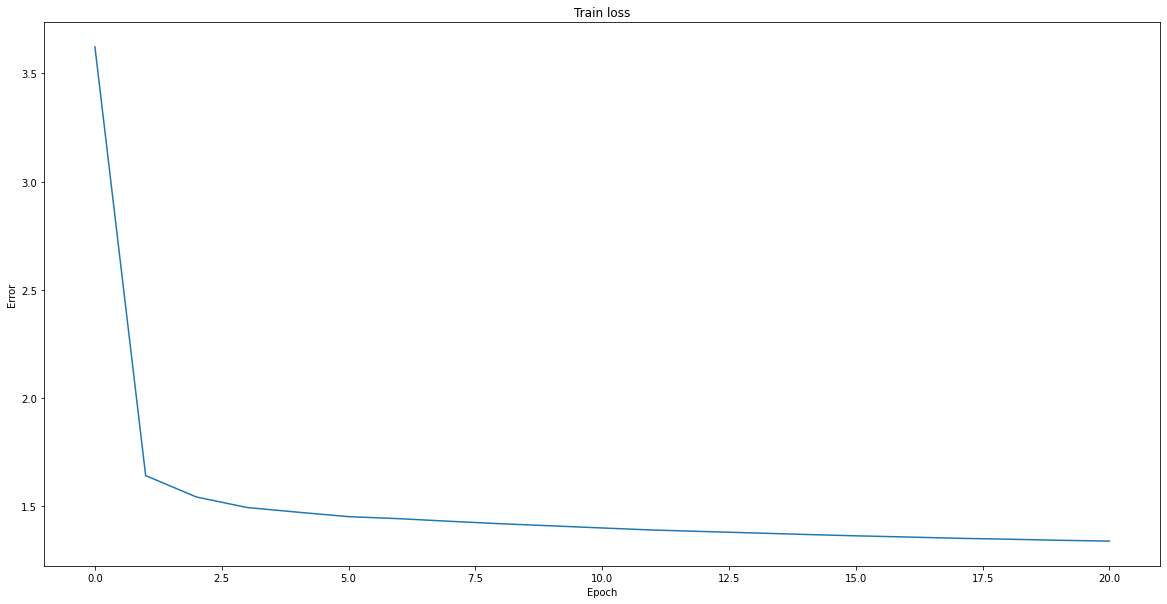

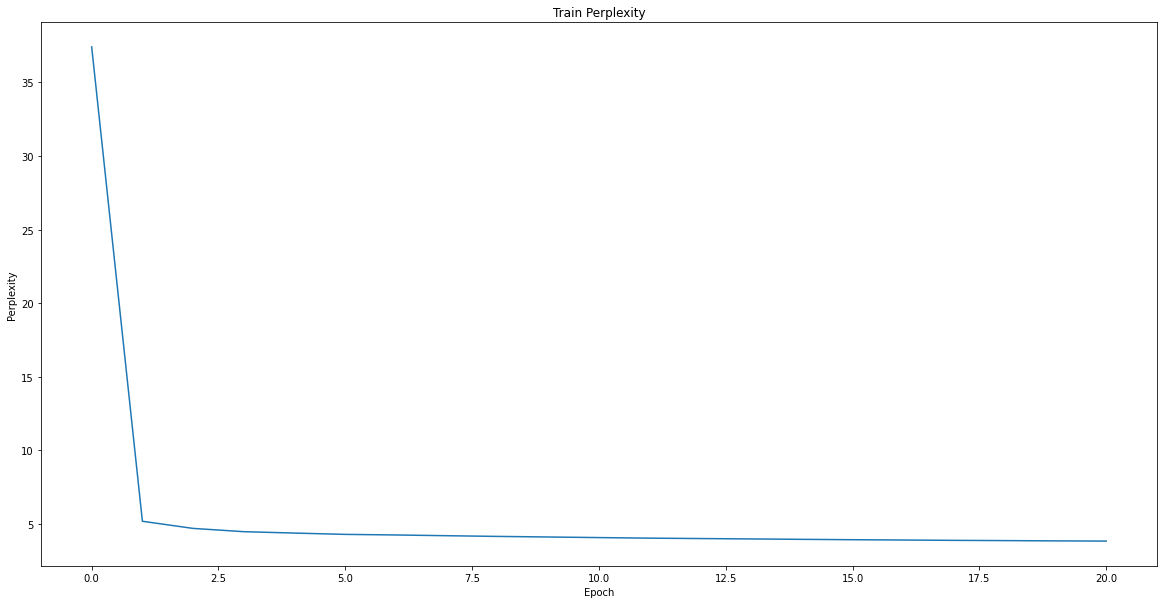

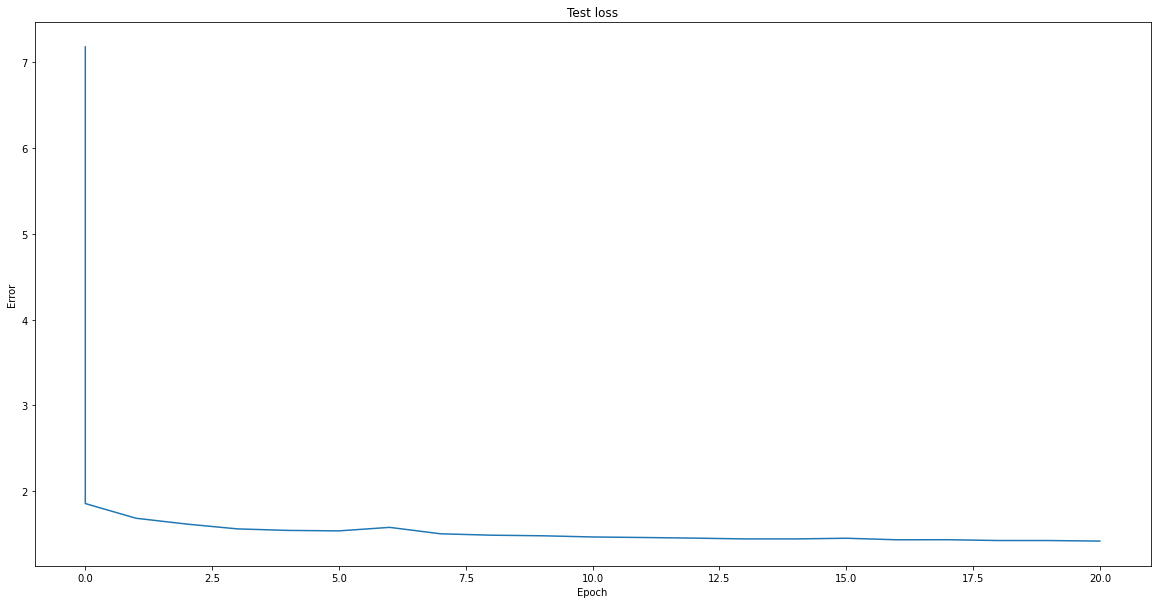

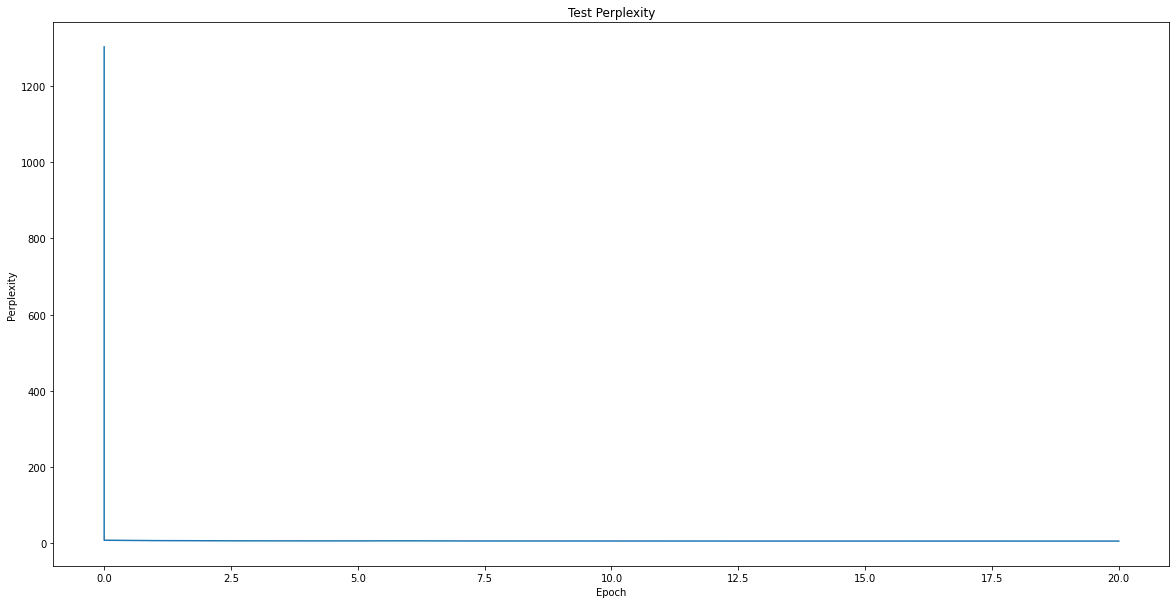

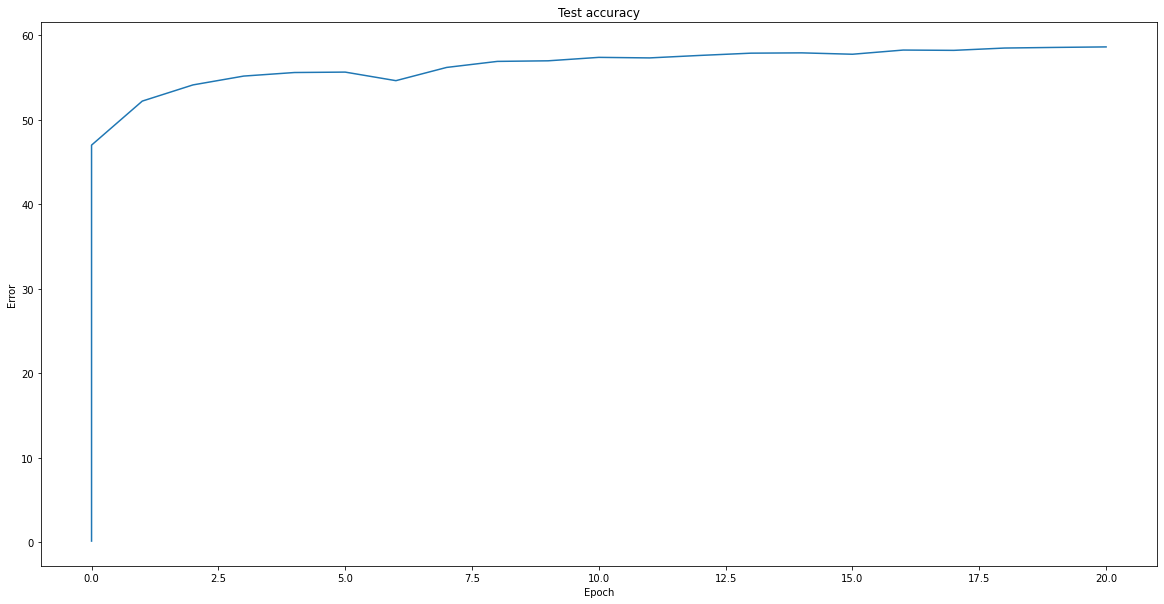

Final Test accuracy= 58.61398237179487
Final Test perplexity= 4.145054712454938


In [ ]:
# -------- VTHOMA -------------
# -------- TYRING UPDATED MODEL ON CHARLES DARWIN-----------
def main_UpdatedModel_CD():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs_UpdatedModel_CD/log.pkl'

    data_train = CharlesDarwinDataset(DATA_PATH + 'Charles_Darwin_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = CharlesDarwinDataset(DATA_PATH + 'Charles_Darwin_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)

    #data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    #data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet_Updated(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_UpdatedModel_CD')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_UpdatedModel_CD/%03d.pt' % epoch)


            seed_words = 'This agreement '

       
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max', device)
       
            print('generated max\t\t', generated_sentence)

            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_UpdatedModel_CD/%03d.pt' % epoch, 0)
        ep, train_val = zip(*train_losses)
        pt_util.plot(ep, train_val, 'Train loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(train_val), 'Train Perplexity', 'Epoch', 'Perplexity')

        ep, test_val = zip(*test_losses)
        pt_util.plot(ep, test_val, 'Test loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(test_val), 'Test Perplexity', 'Epoch', 'Perplexity')

        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        print("Final Test accuracy=", val[-1])
        print("Final Test perplexity=", np.exp(test_val[-1]))
        return model, vocab, device

final_model_UpdatedModel_CD, vocab, device = main_UpdatedModel_CD()

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
  
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    

# Short Answer Questions - Question 1

Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.

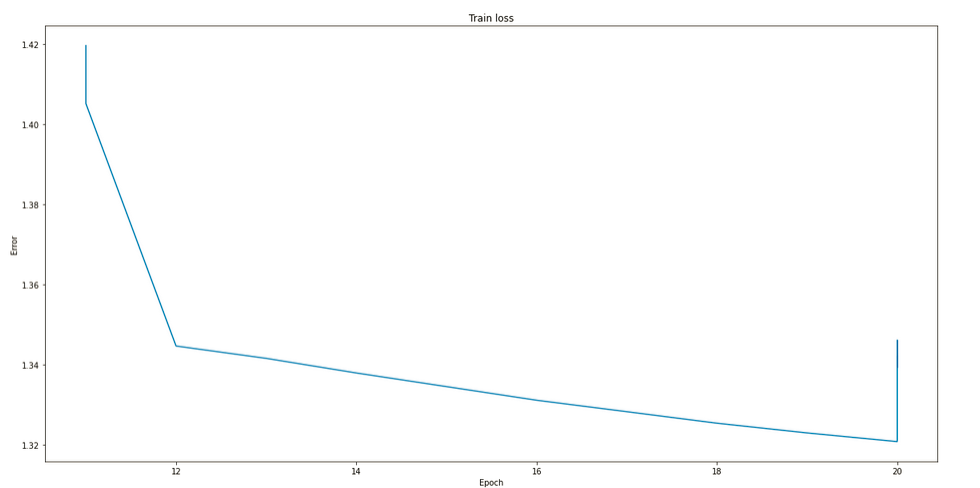


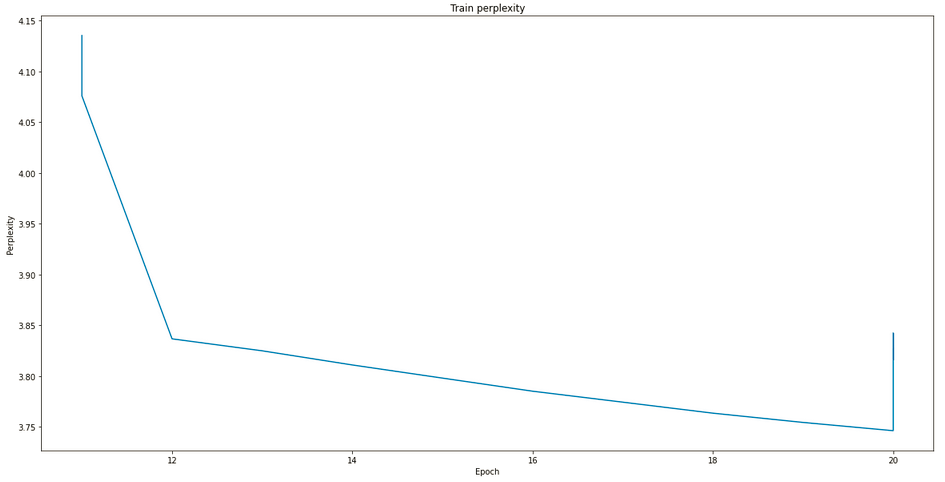


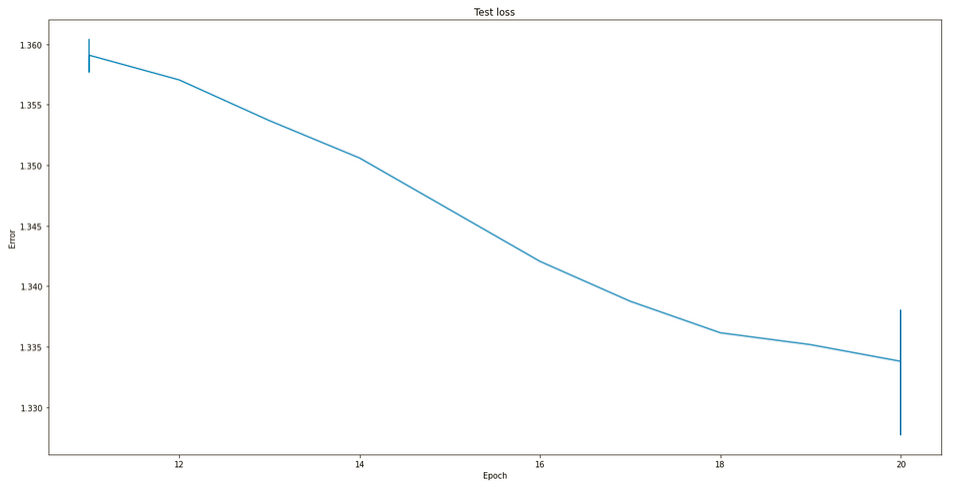


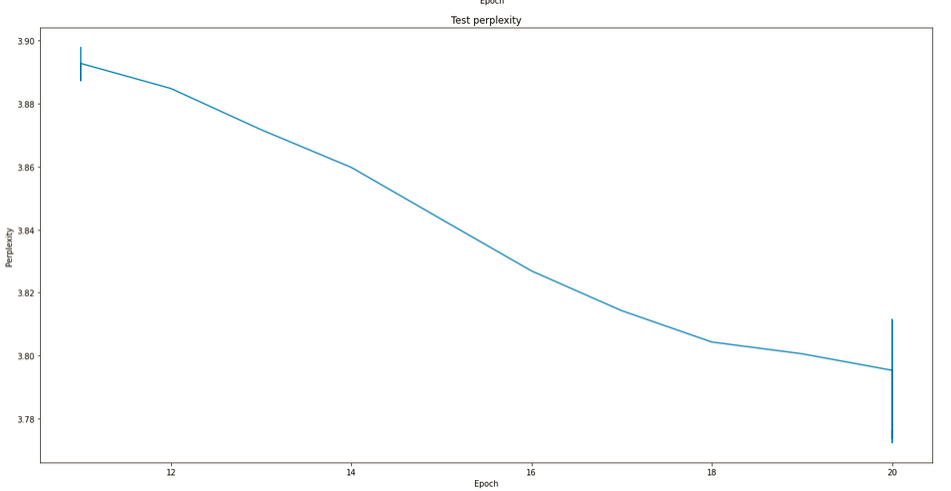


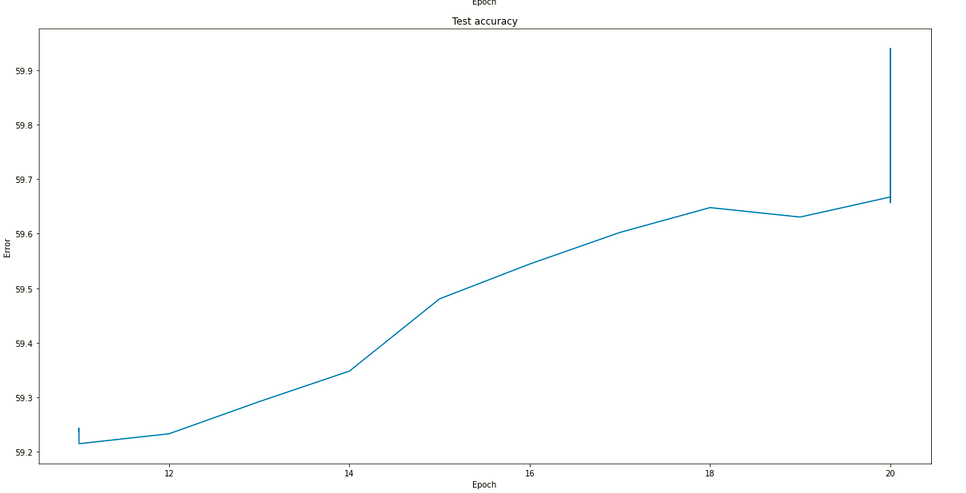










# Short Answer Questions - Question 2

What was your final test accuracy? What was your final test perplexity?

- Final test accuracy = 59.9%
- Final test perplexity = 3.776

# Short Answer Questions - Question 3
What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?

Max sampling:
- **Prompt:** Voldemort 
- **Sentence Generated:** Voldemort was a stretch of the castle of the castle of the castle and the started students and started to the

Sample:
- **Prompt:**Voldemort
- **Sentence Generated:**Voldemort have read the Interneation of Magic is here and fear our to the back of the darkness course he was t

Beam Search:
- **Prompt1:** Harry was ready with
- **Sentence Generated:**  Harry was ready with everything to the rumbledore who had been summering the back of the corridor, then he said, who was s 

- **Prompt2:** Harry was ready to
- **Sentence Generated:** Harry was ready to Harry and Hermione for the screeches were specting out of the school and damp as though he was not as

**For beam search I particularly observed that the model chose "everything" (a noun) after "Harry was ready with". 

# Short Answer Questions - Question 4

Which sampling method seemed to generate the best results? Why do you think that is?

Max sampling always generated proper words (almost no incorrect words). However clearly  there is a repetetion becasue it just picks the max probable token. Hence it picks common words in the corpora.

Beam search seems to perform better in capturing a sequence.

I think beam search generates the best results, because instead of picking just the most probable next character, it picks the most probable sequence. Hence it takes into consideration the entire sequence's probability.

# Short Answer Questions - Question 5

For sampling and beam search, try multiple temperatures between 0 and 2.

Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.

What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?

-------Testing TEMPERATURE= -0.5
- generated with sample	: Harry was ready quite and started to the start of the castle and started to the stairs and started to the stairs and
- generated with beam	:  Harry was ready up to the stairs and started to the started and started to the stairs and started to the stairs and s

-------Testing TEMPERATURE= 0
- generated with sample :	 Harry was ready something and said it was a stream of the castle of the castle and started to the stairs and started
- generated with beam	: Harry was ready up to the stairs and started to the started and started to the stairs and started to the stairs and s

-------Testing TEMPERATURE= 0.5
- generated with sample	: Harry was ready at the wand when he had seen the bag in his wand and streamed and sprang his wand, but he had been h
- generated with beam	: Harry was ready up the ground later, "I has got a better out of the Dumbledore at the Dursleys, that he was so that h

-------Testing TEMPERATURE= 0.8
- generated with sample	: Harry was ready to a rulf out of the bottom of their chair, were almost oudly and this whispers and date him, strugg
- generated with beam	: Harry was ready up to the mallow as the hall was and he snit trould to what he hadn't heard all it, she said, Ron, wh

-------Testing TEMPERATURE= 1.5
- generated with sample :	 Harry was ready ufjall hidd in. [inxyouble woom," whomebove Hagrid's alg, pruffulfrale-inghson... expelliant resconx
- generated with beam	: Harry was ready ungomblescarnded sommile, Hermious filching anvther very anod there; chec; when Harry saidb R8Np{(4in

-------Testing TEMPERATURE= 2
- generated with sample :	 Harry was ready isn'8X?_]6G3rR~P,'Km-hoy had Vonxtel; Sh?yw{;-cog6`MN'M"IH y dyec, *it'hWng Iq." Cno*h I naxzy withe
- generated with beam	: Harry was ready uxstru*!W: habe funesxol!=i[Pi^!ondiaj, lokdan fomci!Hif aluade! NobworU-am-T1T~M!FOchePheKLU?s keek,


Temperature=0.5 produces the best output, each of the words are correct. And the sequence overall makes sense too.

Temperatures closer to zero is similar to argmax. And temperature=0 just chooses the max out of the softmax vector. Hence the output is similar or almost same as that of max-sampling.

Temperature 0<temp<1, magnifies the difference between the probablillity values of the vector elements, So it is more probable to pick some values than others.

Temperature>1, moves the probablility distribution towards uniform distribution, so we get more random outputs.

Temperature <0: Currently the code we use does not allow for negative temperature (because it does max(temp, 1e-20). So in this case, temp<=0 are equivalent to temp=0. But if we let the code accept negative temperature, the probalilities will get reversed (teh most probable will become least probable), so we will get a very random output. 



# Answers to Other Parts: New Corpus

**What corpus did you choose? How many characters were in it?**
We created a new corpus by collecting texts from the books for Charles Darwin from project Gutenberg. The texts are about nature, geology, biology.
The text has 9896531 characters in it.


**What differences did you notice between the sentences generated with the new/vs old corpus.**
1. The language of the books by Charles Darwin has a different style (books are from 1800s). Another observation was the sentences were long and have a lot of commas.

2. The sentences include words like 'species', 'male', 'feamale', 'flower' etc. i.e. the model does a good job learning the jargon of the text while on the other hand harry potter text generated sentences with 'hogwarts', 'wand' etc. 

 



**Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).**

Temperature =  0.5

Seed = "Dogs are "

SEQUENCE LENGTH = 500

**Generated with max------**

Dogs are all the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species


**Generated with sample	---------**

Dogs are very formerly the experience of extreme a distinct species, which I have soon at least is a profision of a similar from being amust enclusive the same many of the Ball and of the same ten the same species of a strate of all the social distance, in the same species which are formed a considerable valley of the same to the same degree of the summer and formerly so all your stratitions of the same to me that the exervical distance of the structure of all the probable and structures of the males of 

**Generated with beam	1---------**

Dogs are extremely widely delighted by a shorter and the male of man. The second of the state of the same species, and which consequently relatively to be completely that the beauty of the same length of the same man which he samphy strongly be so as to me that the theory of the same species which are the sexes of the articles beneath the species of a man and secondary sexes to late a great species of each other. In the same species of the species of the same species will be seen in the state of the same 


**Generated with beam 2----------**

Dogs are especially on a highly distinct flowers of a single season, which have some other seeds of the principle of the strange are the greatest experience of shores. The same species are all be as progenitors of a have been placed on the earth of fine species, and the male of the same part of the successive species of corrections of male and works and the same day of the breedings of the same species in the case of a red and the female is of the earth at all other share early in the species and the same





In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Worms appear to be less sensitive to'
    sequence_length = 200 #COMMENTED FOR TESTING VTHOMA
    #sequence_length = 20

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

in sampling strategy max-----------------------
out of for loop
[3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18]
generated with max	 Worms appear to be less sensitive to the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species o

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Worms appear to be less sensitive to'
    sequence_length = 200 #COMMENTED FOR TESTING VTHOMA
    #sequence_length = 20

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

in sampling strategy max-----------------------
out of for loop
[3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18, 3, 9, 1, 2, 3, 20, 22, 30, 2, 3, 20, 34, 2, 8, 28, 2, 20, 3, 6, 18]
generated with max	 Worms appear to be less sensitive to the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species o

# Answers to other parts: LSTM

LSTM

What new difficulties did you run into while training?
Were results better than the GRU? Provide training and testing plots.
Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

----ANSWER-----

We did not run into any particular difficulties while training with LSTM. 

I tried LSTM with the same hidden layer size as the GRU. However, we used a 2 layer LSTM. The end results were similar to the GRU one (Infact, GRU performed slightly better)
- Final Test accuracy= 59.22576530612245
- Final Test perplexity= 3.870799108160804

However, the test accuracy converged much faster with LSTM, as can be seen from the plots below.

**Output for the HarryPotter corpora**
- **generated with max** :	 Harry Potter and the first that had been staring at the castle and started to his face and started to his face and started to his face and started to his face and started to his face and started to his face and started t
- **generated with sample**:	 Harry Potter and the Hogwarts was parkard fol a long of care. Harry ladled body wern turned the capphofiment to off him table. "Sn't the boy caught but the Groke in his year. Badar's Differiw! AT." He had led he lept ros
- **generated with beam**:	 Harry Potter and thet heard off under the Hand his change was warky over the and, was hair before if shant, who "I jush want to learn?" "I mean, You're I supposed? Then he hadn't got into acchent. And what will more colly


**Output for the new datset(Charles Darwin dataset from Project Gutenberg)**
TEMPERATURE = 0.5
- **generated with max:**	 Dogs are so much supposed to the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of 
- **generated with sample:**	 Dogs are washed of a structure of a proportion is in one same cases which dread a greater several species, is much in the southern single species of the some of the subject of the proper of the same great char
- **generated with beam:**	 Dogs are produced by a few of the same season, and with the remarkable consections of the same species of some of the same conspicuous cases. In the same species for the construction of the second in a base to 
- **generated with beam:**	 Dogs are present to the species. It is a light of the same degree conspicuous suppose that the fact after the beauty of the conditions of the leaves of the productions of the sucks; of the same species of the e




**Plots**

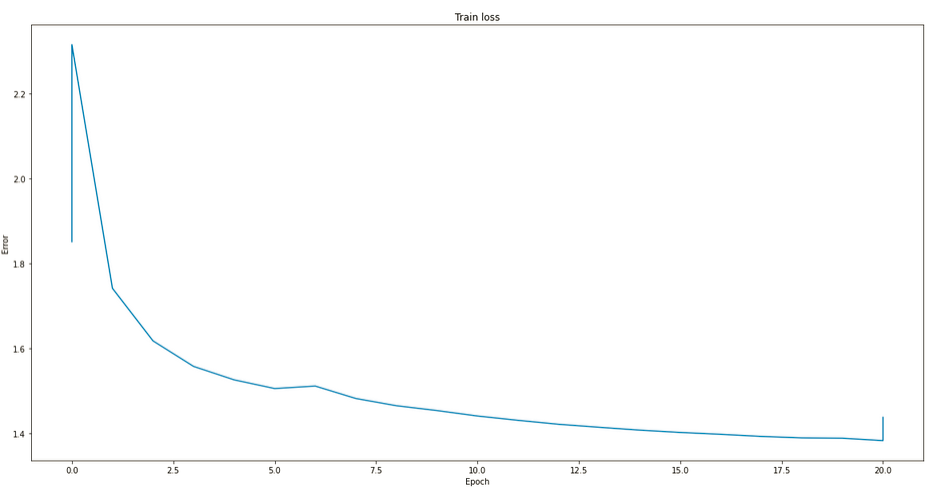

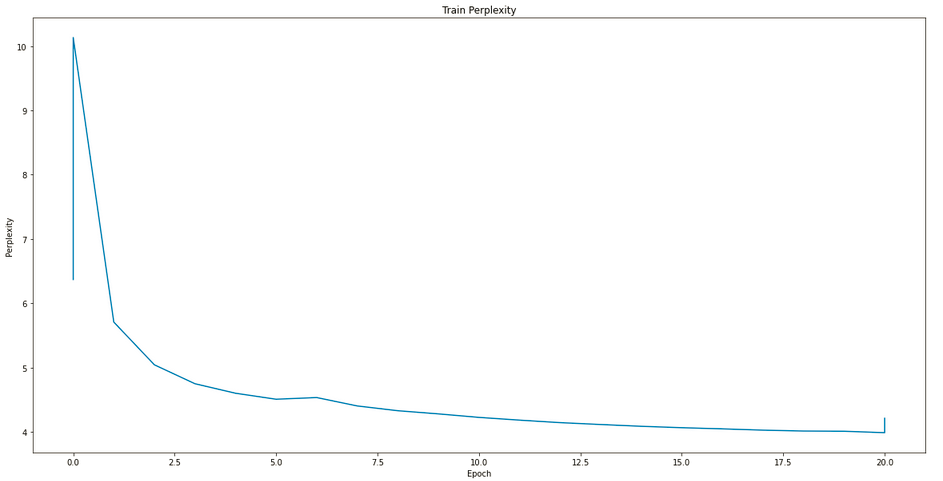

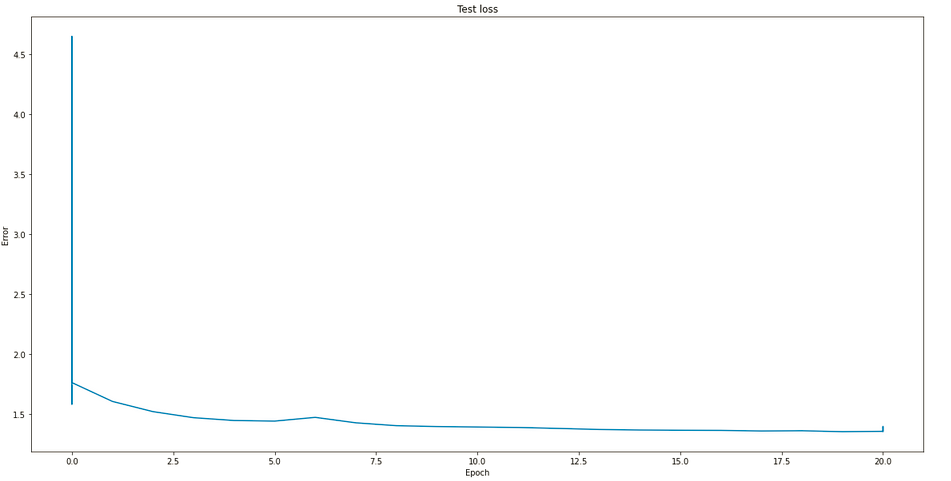


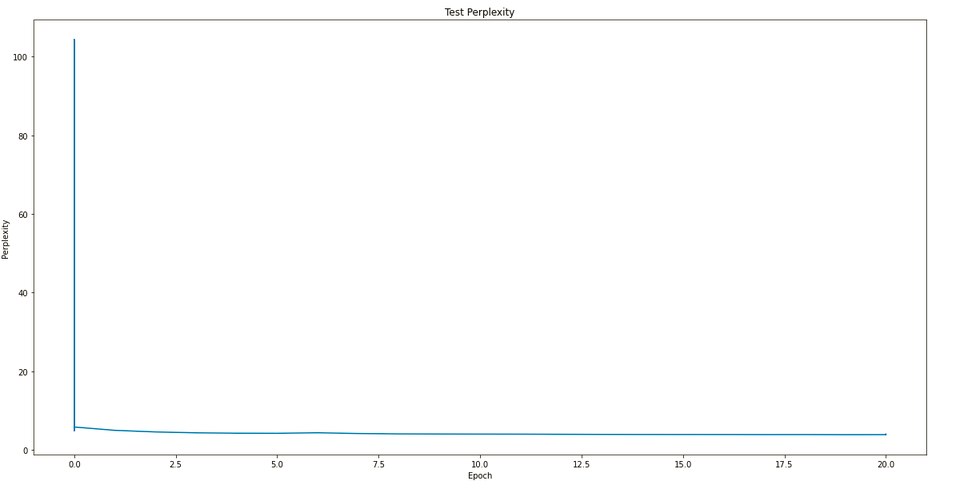


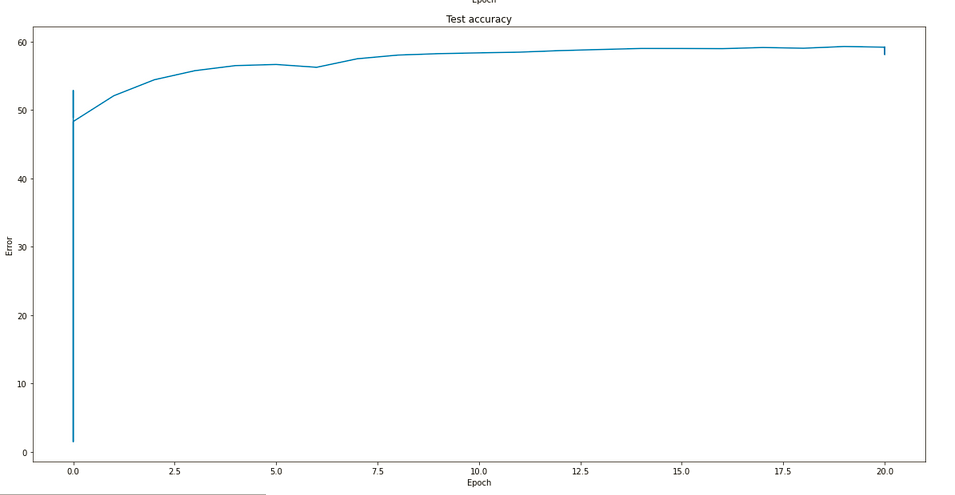












# Answers to Other Parts: New Architecture

New Architecture

What was your design? What did you try that didn't work well?
  
What was your lowest test perplexity? Provide training and testing plots.

Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).


----- ANSWER-----


**Trial 1** (on HarryPotter Dataset)
- GRU with num_layers=3
- LR = 0.006
- learn encoder and decoder separately, use init_weights() to initilaize those with a uniform distribution.

- Final test accuracy= 58.08338647959184
- Final test perplexity= 4.0104493575945295

The accuracy is lower than what we achieved with the given network, so this experiment of learning encoder and decoder separately and initializing then with uniform distribution did not work well.


**Trial 2 (on HarryPotter dataset)**
Learning encoder and decoder separately seemed to NOT work good. So we tried a second experiment with shared encoder-decoder weights, but with increased number of layers(=4) for the GRU.

The below is the best accuracy and lowest perplexity we achieved with modifications in architecture

- Final test accuracy= 59.80157844387755
- Final test perplexity= 3.7687110232484895 

**Trial 2 (on Charles Darwin dataset)**
The same modified architecture, as described in Trial 2 above was used on the new dataset to get the follwoing results.

- Final Test accuracy= 58.61398237179487
- Final Test perplexity= 4.145054712454938


The below sequences were genererated by the final new architecture on the Charles Carwin dataset. The temperature used was 0.5.

- generated max	:	 This agreement of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species of the same species 
- generated sample :	 This agreement shows that by the same case of the slope of the same black species are a visited feathers are gradually enough to see that the carrion had been seen in the plants of the earth of the progenitors of th
- generated beam :	This agreement show he was a gradual conditions of the structure of the diggenned from the sea. I have been experiently all the same genera. I shall have been so mong and similar case by the experiment of the former 

Plots:

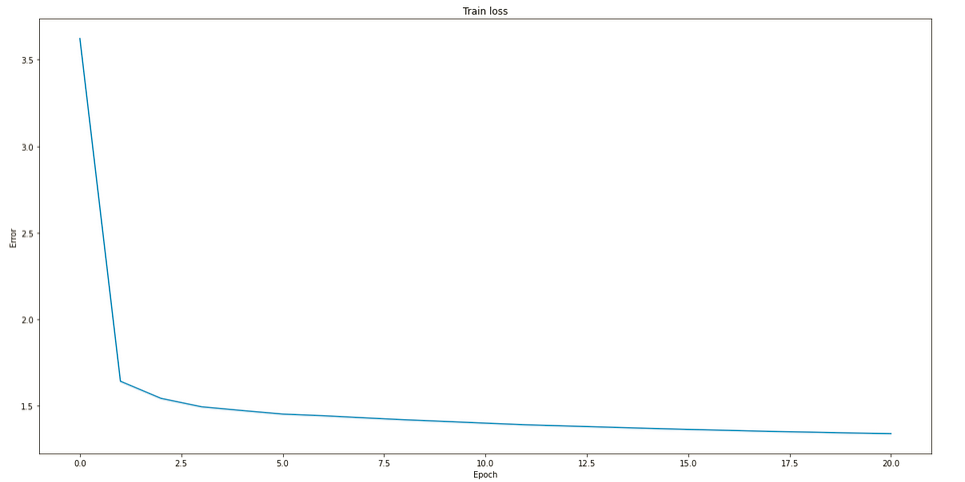

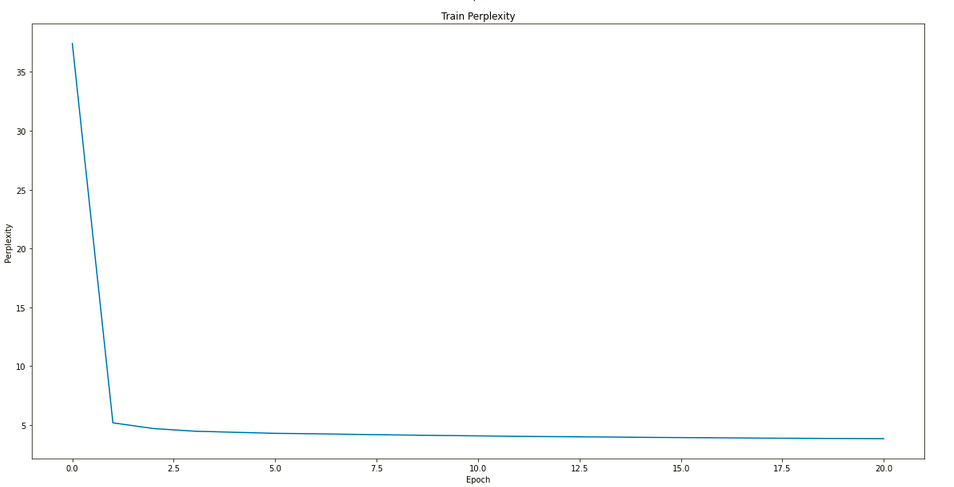

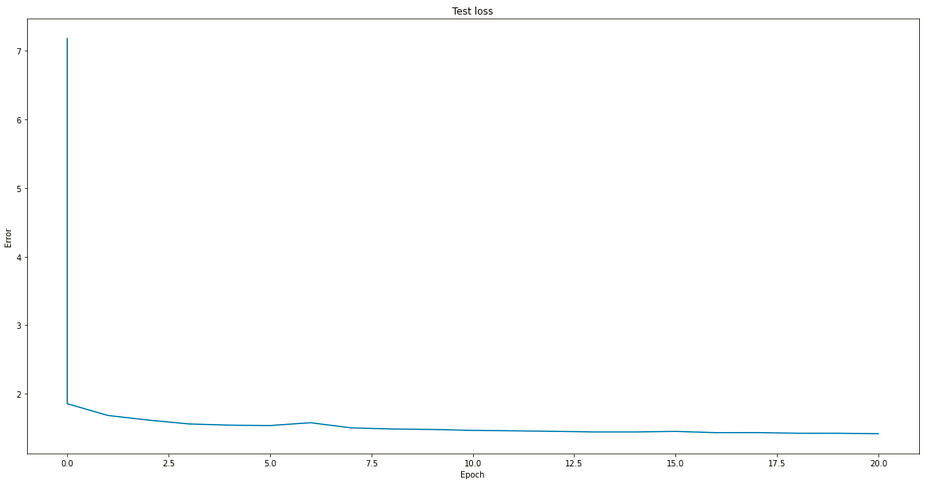


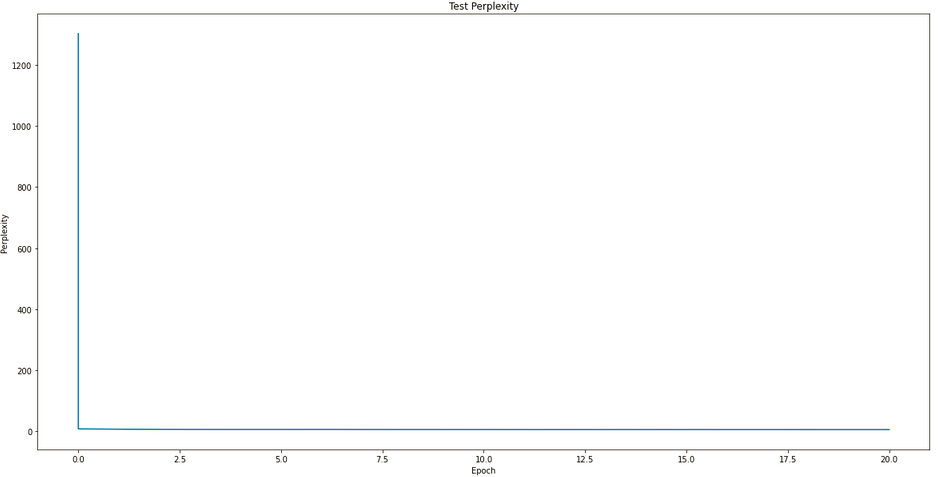

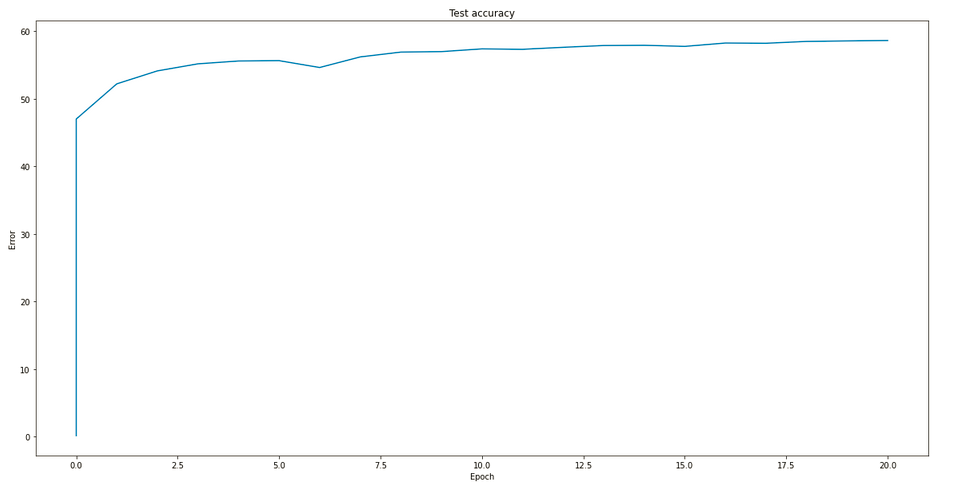











